# Imports

In [1]:
import subprocess
from copy import deepcopy
from pathlib import Path

import trimesh
import pymeshfix
import cc3d
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import nibabel as nib
from nibabel.freesurfer.io import read_geometry, write_geometry
from skimage import measure
from parse import parse
from tqdm.notebook import tqdm
from PIL import Image, ImageFont, ImageDraw
import pandas as pd
import signal
import subprocess as sp
import sys
import csv

import mne
from mne.surface import decimate_surface, _triangle_neighbors
from mne.bem import _get_solids
from mne.io.constants import FIFF
from mne.viz import plot_alignment, set_3d_view

from eegip.atlas import Atlas
from eegip import DatasetMng

# Global variables for the notebook

In [2]:
subjects = ["ANTS2-0Weeks3T", "ANTS1-0Months3T", "ANTS2-0Months3T", "ANTS3-0Months3T", 
            "ANTS4-5Months3T", "ANTS6-0Months3T", "ANTS7-5Months3T", "ANTS9-0Months3T", 
            "ANTS10-5Months3T", "ANTS12-0Months3T", "ANTS15-0Months3T", "ANTS18-0Months3T", 
            "ANTS2-0Years3T"]
                
root = Path("/media/christian/ElementsSE/Richards")

image_output_path = Path("/home/christian/Dropbox/Publications (current)/Journal/infants atlas/")

fs_subject_path = Path("/usr/local/freesurfer/subjects/")

# Cerebellum cortex/wm distinction is not available
# in the youngest infants
labels_vol = [#'Left-Accumbens-area',
             'Left-Amygdala',
             'Left-Caudate',
             #'Left-Cerebellum-Cortex',
             #'Left-Cerebellum-White-Matter',
             'Left-Hippocampus',
             'Left-Pallidum',
             'Left-Putamen',
             'Left-Thalamus',
             #'Right-Accumbens-area',
             'Right-Amygdala',
             'Right-Caudate',
             #'Right-Cerebellum-Cortex',
             #'Right-Cerebellum-White-Matter',
             'Right-Hippocampus',
             'Right-Pallidum',
             'Right-Putamen',
             'Right-Thalamus']     
    
out = widgets.Output(layout={'border': '1px solid black'})


config = {"atlas": {"vol_labels": labels_vol}}     

ages = {"ANTS2-0Weeks3T": "2 weeks",
          "ANTS1-0Months3T": "1 month",
          "ANTS2-0Months3T": "2 months", 
          "ANTS3-0Months3T": "3 months", 
          "ANTS4-5Months3T": "4.5 months", 
          "ANTS6-0Months3T": "6 months", 
          "ANTS7-5Months3T": "7.5 months", 
          "ANTS9-0Months3T": "9 months", 
          "ANTS10-5Months3T": "10.5 months", 
          "ANTS12-0Months3T": "12 months", 
          "ANTS15-0Months3T": "15 months", 
          "ANTS18-0Months3T": "18 months", 
          "ANTS2-0Years3T": "24 months"}     


# Definition of various functions used throughout the notebook 

In [3]:
def run_command(command, dry_run=False):
    print("------------------ RUNNING A COMMAND IN BASH ------------------")
    print(command)    
    print("-------------------------- OUTPUT -----------------------------")
    if not dry_run:
        bash(command.replace("\\", "").split())
    print("------------------------ END OUTPUT ---------------------------\n")    

class VerboseCalledProcessError(sp.CalledProcessError):
    def __str__(self):
        if self.returncode and self.returncode < 0:
            try:
                msg = "Command '%s' died with %r." % (
                    self.cmd, signal.Signals(-self.returncode))
            except ValueError:
                msg = "Command '%s' died with unknown signal %d." % (
                    self.cmd, -self.returncode)
        else:
            msg = "Command '%s' returned non-zero exit status %d." % (
                self.cmd, self.returncode)

        return f'{msg}\n' \
               f'Stdout:\n' \
               f'{self.output}\n' \
               f'Stderr:\n' \
               f'{self.stderr}'


def bash(cmd, print_stdout=True, print_stderr=True):
    proc = sp.Popen(cmd, stderr=sp.PIPE, stdout=sp.PIPE)
                    #, shell=True, universal_newlines=True,
                    #executable='/bin/bash')

    all_stdout = []
    all_stderr = []
    while proc.poll() is None:
        for stdout_line in proc.stdout:
            if stdout_line != '':
                if print_stdout:
                    print(stdout_line.decode(), end='')
                all_stdout.append(stdout_line)
        for stderr_line in proc.stderr:
            if stderr_line != '':
                if print_stderr:
                    print(stderr_line.decode(), end='', file=sys.stderr)
                all_stderr.append(stderr_line)

    stdout_text = ''.join([x.decode() for x in all_stdout])
    stderr_text = ''.join([x.decode() for x in all_stderr] )
    if proc.wait() != 0:
        raise VerboseCalledProcessError(proc.returncode, cmd, stdout_text, stderr_text)

In [4]:
def check_bem(subject_):
    atlas_ = Atlas(subjects_dir=fs_subject_path, fs_subject=subject_)
    atlas_.build_bem(labels_vol=labels_vol)
    atlas_.mesh_atlas_pacels()
    atlas_.compute_parcels_centers_of_masse()


# In some of our MRI, there appears to have artifacts that shows like small line segments
# over the background. We correct these by zeroing any small separated clusted of non null 
# voxels.    
def correct_line_artefact(epi_img_data_):
    components = cc3d.connected_components((epi_img_data_ != 0).astype(int))
    label_id, count = np.unique(components, return_counts=True)
    id_zero, id_non_zero = label_id[count > 500000]
    ind_artefact = np.where((components != id_zero) & (components != id_non_zero))
    epi_img_data_[ind_artefact] = 0

    
def process_bem(bem_path_):
    """
     Main function for BEM extraction.
    """
    subject_ = bem_path_.name.split("_")[0].replace("AVG", "ANTS") #.replace("_edited", "")

    epi_img_ = nib.load(str(bem_path_))

    for file_name_, discard_inds in zip(["outer_skin.surf", "outer_skull.surf", "inner_skull.surf"],
                                       [[1, 2, 3, 4], [1, 2, 3], [1, 2]]):
        epi_img_data_ = deepcopy(epi_img_.get_fdata())

        correct_line_artefact(epi_img_data_)

        cond = np.stack([(epi_img_data_ == i_) for i_ in discard_inds]).sum(0)
        epi_img_data_[np.where(cond)] = 1
        epi_img_data_[np.where(np.logical_not(cond))] = 0
        vertices, simplices = measure.marching_cubes_lewiner(epi_img_data_, spacing=(1, 1, 1),
                                                             allow_degenerate=False)[:2]

        #path_white = fs_subject_path / (subject_ + "_brain") / "surf" / "lh.white"
        path_white = fs_subject_path / subject_ / "surf" / "lh.white"

        try:
            volume_info_ = read_geometry(path_white, read_metadata=True)[2]
        except:
            print("Skipping subject {}...".format(subject_))
            continue

        vertices = vertices @ epi_img_.affine[:3, :3] + epi_img_.affine[:3, 3] - volume_info_["cras"]

        mesh_ = trimesh.Trimesh(vertices=vertices, faces=simplices)
        trimesh.repair.fix_normals(mesh_, multibody=False)

        smooth_mesh = trimesh.smoothing.filter_laplacian(deepcopy(mesh_), lamb=0.8, iterations=15,
                                                         volume_constraint=True)

        bem_output_path_ = fs_subject_path / subject_ / "bem"
        bem_output_path_.mkdir(parents=True, exist_ok=True)

        vertices, faces_ = smooth_mesh.vertices, smooth_mesh.faces

        # Defect corrections for the large meshes
        vertices, faces_ = fix_all_defects(vertices, faces_)

        # Writing a freesufer mesh file
        file_name_large = file_name_.split(".")[0] + "_large.surf"
        write_geometry(str(bem_output_path_ / file_name_large),
                       vertices, faces_)

        # Writing an obj mesh file
        with (bem_output_path_ / file_name_large).with_suffix(".obj").open('w') as file_obj:
            file_obj.write(trimesh.exchange.obj.export_obj(trimesh.Trimesh(vertices, faces_)))

        # Decimating BEM surfaces
        vertices, faces_ = decimate_surface(vertices, faces_,
                                           n_triangles=5120)

        # Defect correction for decimated meshes...
        vertices, faces_ = fix_all_defects(vertices, faces_)

        # Writing an obj mesh file
        with (bem_output_path_ / file_name_).with_suffix(".obj").open('w') as file_obj:
            file_obj.write(trimesh.exchange.obj.export_obj(trimesh.Trimesh(vertices, faces_)))

        # Writing a freesufer mesh file
        print("Writing {}...".format(str(bem_output_path_ / file_name_)))
        write_geometry(str(bem_output_path_ / file_name_),
                       vertices, faces_, volume_info=volume_info_)
        

def check_mesh(vertices, faces_):
    assert (surface_is_complete(vertices, faces_))
    assert (not has_topological_defects(vertices, faces_))
    assert (not has_degenerated_faces(vertices, faces_))
    assert trimesh.Trimesh(vertices, faces_).is_watertight     
        
        
def fix_all_defects(vertices, faces_):   
    if has_degenerated_faces(vertices, faces_):
        vertices, faces_ = remove_degenerated_faces(vertices, faces_)
        assert (not has_degenerated_faces(vertices, faces_))

    if has_topological_defects(vertices, faces_):
        print("The decimated mesh has topological defects. Fixing it.")
        vertices, faces_ = fix_topological_defects(vertices, faces_)
        if has_degenerated_faces(vertices, faces_):
            vertices, faces_ = remove_degenerated_faces(vertices, faces_)
        assert (not has_topological_defects(vertices, faces_))

    if not surface_is_complete(vertices, faces_) or not trimesh.Trimesh(vertices, faces_).is_watertight :
        print("The decimated mesh has holes. Fixing it.")
        vertices, faces_ = repair_holes(vertices, faces_)

    check_mesh(vertices, faces_)

    return vertices, faces_      
            
        
def surface_is_complete(vertices, faces_):
    """Check the sum of solid angles as seen from inside."""
    cm = vertices.mean(axis=0)
    tot_angle = _get_solids(vertices[faces_], cm[np.newaxis, :])[0]
    prop = tot_angle / (2 * np.pi)
    return np.abs(prop - 1.0) < 1e-5


def correction_two_neighboring_tri(vertices, faces_, faulty_vert_ind):
    ind_faces_to_remove = []
    new_faces = []
    for ind in faulty_vert_ind:
        ind_faces = np.where(faces_ == ind)[0]
        ind_faces_to_remove.extend(ind_faces)
        face1, face2 = faces_[ind_faces]
        new_face = np.unique(np.concatenate((face1, face2)))
        new_face = np.delete(new_face, np.where(new_face == ind))
        assert (len(new_face) == 3)  # If == 4, it means that face1 and face2 do not share a common edge

        new_det = np.linalg.det(vertices[new_face])
        assert new_det  # If zero, the three points are colinear

        # Align the normals
        det1 = np.linalg.det(vertices[face1])
        if np.sign(det1) == np.sign(new_det):
            new_face = new_face[[1, 0, 2]]

        new_faces.append(new_face)

    return np.array(ind_faces_to_remove, dtype=int), new_faces
    
    
def reindex_vertices(vertices, faces_, ind_vertices_to_remove):
    decrement = np.cumsum(np.zeros(vertices.shape[0], dtype=int) +
                          np.in1d(np.arange(vertices.shape[0]), ind_vertices_to_remove))
    vertices = np.delete(vertices, ind_vertices_to_remove, axis=0)
    faces_ = faces_ - decrement[faces_]
    return vertices, faces_
    
    
def get_topological_defects(vertices, faces_):
    #    Find neighboring triangles, accumulate vertex normals, normalize
    neighbor_tri = _triangle_neighbors(faces_, len(vertices))

    #   Check for topological defects
    zero, one, two = list(), list(), list()
    for ni, n in enumerate(neighbor_tri):
        if len(n) < 3:
            if len(n) == 0:
                zero.append(ni)
            elif len(n) == 1:
                one.append(ni)
            else:
                two.append(ni)

    return zero, one, two
    
    
def has_topological_defects(vertices, faces_):
    zero, one, two = get_topological_defects(vertices, faces_)
    return len(zero) or len(one) or len(two)
        
    
# Code extracted and slighly modified from mne.surface.complete_surface_info
# for compactness of the example
def fix_topological_defects(vertices, faces_):
    zero, one, two = get_topological_defects(vertices, faces_)
    ind_faces_to_remove = []
    if len(zero) > 0:
        print('    Vertices do not have any neighboring '
              'triangles: [%s]' % ', '.join(str(z) for z in zero))
        print('    Correcting by removing these vertices.')

    if len(one) > 0:
        print('    Vertices have only one neighboring '
              'triangles: [%s]'
              % ', '.join(str(tri) for tri in one))
        print('    Correcting by removing these vertices and their neighboring triangles.')
        ind_faces_to_remove.extend(np.where(faces_ == one)[0].tolist())

    if len(two) > 0:
        print('    Vertices have only two neighboring '
              'triangles, removing neighbors: [%s]'
              % ', '.join(str(tri) for tri in two))
        print('    Correcting by merging the two neighboring '
              'triangles and removing the faulty vertices.')

        ind_faces, faces_to_add = correction_two_neighboring_tri(vertices, faces_, two)
        ind_faces_to_remove.extend(ind_faces)
        faces_ = np.concatenate((np.delete(faces_, np.array(ind_faces_to_remove, dtype=int), axis=0), faces_to_add))

    vertices_to_remove = np.concatenate((zero, one, two)).astype(int)
    if len(vertices_to_remove):
        vertices, faces_ = reindex_vertices(vertices, faces_, vertices_to_remove)
    else:
        print("No issue found with the mesh.")

    return vertices, faces_
        

def has_degenerated_faces(vertices, faces_):
    return not np.all(trimesh.Trimesh(vertices, faces_).remove_degenerate_faces())


def remove_degenerated_faces(vertices, faces_):
    mesh_ = trimesh.Trimesh(vertices, faces_)
    mesh_.remove_degenerate_faces()
    return mesh_.vertices, mesh_.faces  

    
def repair_holes(vertices, faces_):
    # trimesh has a hole fixing function, but it just deals with
    # 3 or 4 vertices holes.
    meshfix = pymeshfix.MeshFix(vertices, faces_)
    meshfix.repair()
    vertices = meshfix.v  # numpy np.float array
    faces_ = meshfix.f  # numpy np.int32 array

    # The return mesh has a solid angle of -1 instead of 1.
    # Correcting this.
    mesh_ = trimesh.Trimesh(vertices=vertices, faces=faces_)
    trimesh.repair.fix_normals(mesh_, multibody=False)
    return mesh_.vertices, mesh_.faces


def show_slices(slices):
    """ Function to display row of image slices """
    axes_ = plt.subplots(1, len(slices), figsize=(12, 5))[1]
    for slice_, ax_ in zip(slices, axes_):
        ax_.imshow(slice_.T, cmap="gray", origin="lower")
        

def save_sfp_montage(montage, fpath):
    assert (montage.dig[0]["kind"] == FIFF.FIFFV_POINT_CARDINAL and
            montage.dig[0]["ident"] == FIFF.FIFFV_POINT_LPA)
    assert (montage.dig[1]["kind"] == FIFF.FIFFV_POINT_CARDINAL and
            montage.dig[1]["ident"] == FIFF.FIFFV_POINT_NASION)
    assert (montage.dig[2]["kind"] == FIFF.FIFFV_POINT_CARDINAL and
            montage.dig[2]["ident"] == FIFF.FIFFV_POINT_RPA)

    with fpath.open("w") as file_obj:
        for dig_, name in zip(montage.dig[:3], ["FidT9", "FidNz", "FidT10"]):
            file_obj.write("{}\t{}\t{}\t{}\n".format(name, dig_["r"][0], dig_["r"][1], dig_["r"][2]))
        for dig_, name in zip(montage.dig[3:], montage.ch_names):
            file_obj.write("{}\t{}\t{}\t{}\n".format(name, dig_["r"][0], dig_["r"][1], dig_["r"][2]))


In [5]:
def surface_intersect(inner_surface_path, outer_surface_path):

    inner_mesh = trimesh.Trimesh(*read_geometry(inner_surface_path, read_metadata=False)) 
    outer_mesh = trimesh.Trimesh(*read_geometry(outer_surface_path, read_metadata=False))  

    ray_interceptor_inner = trimesh.ray.ray_pyembree.RayMeshIntersector(inner_mesh)
    inds = ray_interceptor_inner.intersects_location(ray_origins=outer_mesh.vertices, 
                                                     ray_directions=outer_mesh.vertex_normals,
                                                     multiple_hits=True)[1]    
    return len(inds) != 0



# Displaying the different types of MRI images provided by Richards et al.

In [6]:
subject = "ANTS12-0Months3T"

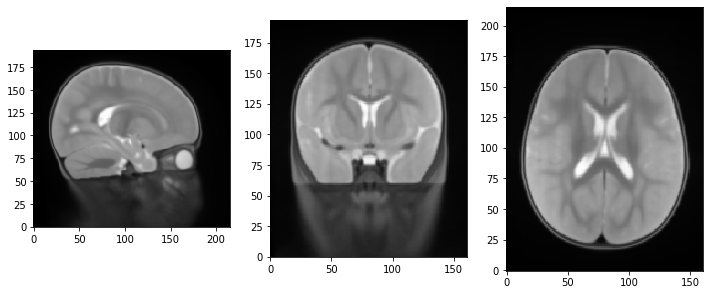

In [7]:
epi_img = nib.load(str(root / "Infants" / "Head" / "{}_t2w_head.nii.gz".format(subject)))
epi_img_data = epi_img.get_fdata()
slice_0 = epi_img_data[100, :, :]
slice_1 = epi_img_data[:, 125, :]
slice_2 = epi_img_data[:, :, 125]
show_slices([slice_0, slice_1, slice_2])

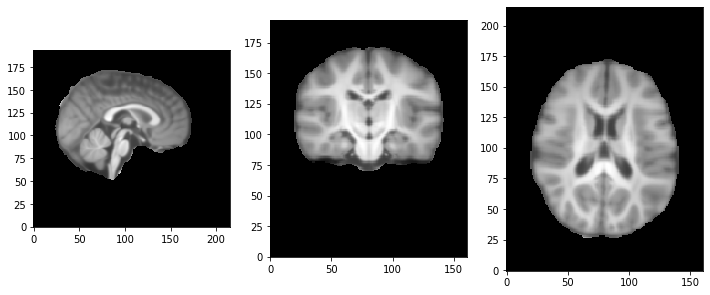

In [8]:
epi_img = nib.load(str(root / "Infants" / "Head" / "{}_head_brain.nii.gz".format(subject)))
epi_img_data = epi_img.get_fdata()
slice_0 = epi_img_data[80, :, :]
slice_1 = epi_img_data[:, 100, :]
slice_2 = epi_img_data[:, :, 125]
show_slices([slice_0, slice_1, slice_2])

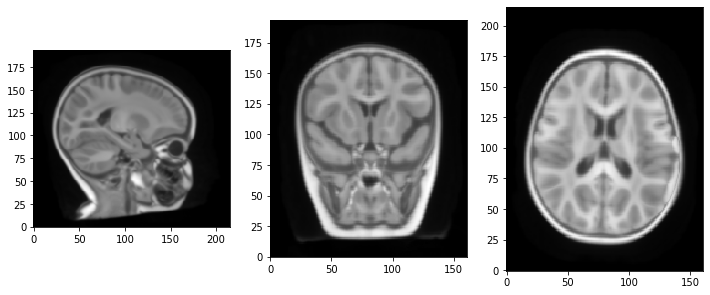

In [9]:
epi_img = nib.load(str(root / "Infants" / "Head" / "{}_head_bias_corrected.nii.gz".format(subject)))
epi_img_data = epi_img.get_fdata()
slice_0 = epi_img_data[100, :, :]
slice_1 = epi_img_data[:, 125, :]
slice_2 = epi_img_data[:, :, 125]
show_slices([slice_0, slice_1, slice_2])

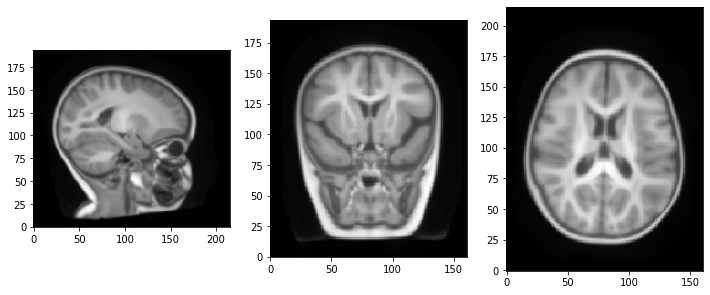

In [10]:
epi_img = nib.load(str(root / "Infants" / "Head" / "{}_head.nii.gz".format(subject)))
epi_img_data = epi_img.get_fdata()
slice_0 = epi_img_data[100, :, :]
slice_1 = epi_img_data[:, 125, :]
slice_2 = epi_img_data[:, :, 125]
show_slices([slice_0, slice_1, slice_2])

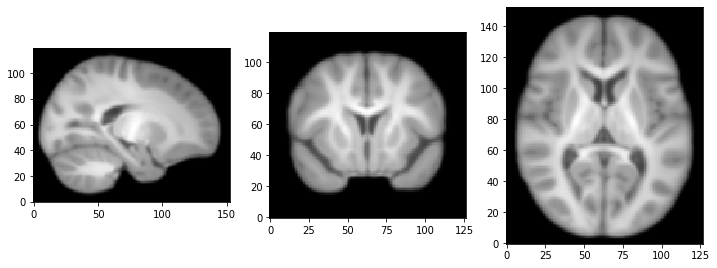

In [11]:
epi_img = nib.load(str(root / "Infants" / "Brain" / "{}_brain.nii.gz".format(subject)))
epi_img_data = epi_img.get_fdata()
slice_0 = epi_img_data[80, :, :]
slice_1 = epi_img_data[:, 100, :]
slice_2 = epi_img_data[:, :, 60]
show_slices([slice_0, slice_1, slice_2])

The file marked as corrected seems to have artifacts that cause problems. Thus, we use the non-corrected ones. According to John Richards using the uncorrected files is fine with this version of the database since the correction was mainly important for T1.5 scans and our averages are based on T3 scans.

# Looking at the different BEM surfaces provided by Richards et al.

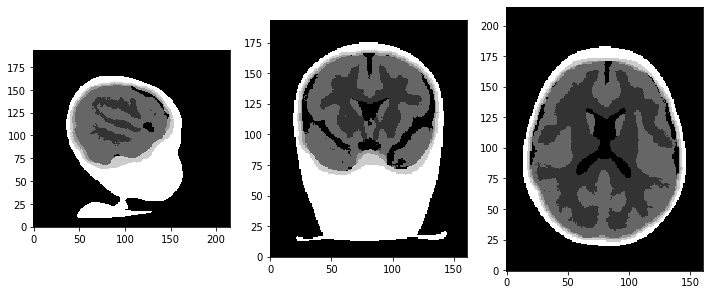

In [12]:
epi_img = nib.load(str(root / "Infants" / "Sources" / "BEM" / "AVG12-0Months3T_segmented_BEM5.nii.gz"))
epi_img_data = epi_img.get_fdata()
slice_0 = epi_img_data[125, :, :]
slice_1 = epi_img_data[:, 125, :]
slice_2 = epi_img_data[:, :, 125]
show_slices([slice_0, slice_1, slice_2])

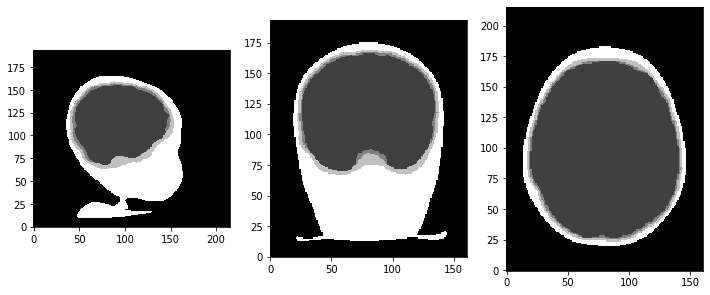

In [13]:
epi_img = nib.load(str(root / "Infants" / "Sources" / "BEM" / "AVG12-0Months3T_segmented_BEM4.nii.gz"))
epi_img_data = epi_img.get_fdata()
slice_0 = epi_img_data[125, :, :]
slice_1 = epi_img_data[:, 125, :]
slice_2 = epi_img_data[:, :, 125]
show_slices([slice_0, slice_1, slice_2])

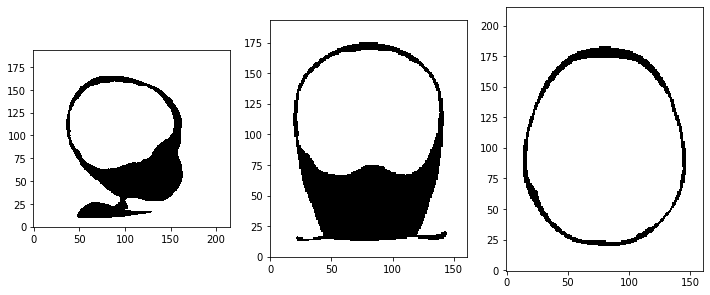

In [14]:
epi_img = nib.load(str(root / "Infants" / "Sources" / "BEM" / "AVG12-0Months3T_segmented_BEM3.nii.gz"))
epi_img_data = epi_img.get_fdata()
epi_img_data[np.where(epi_img_data == 0)] = np.nan # outside
epi_img_data[np.where(epi_img_data == 1)] = np.nan # white matter
epi_img_data[np.where(epi_img_data == 2)] = np.nan # skin
#epi_img_data[np.where(epi_img_data == 3)] = np.nan # CSF
slice_0 = epi_img_data[125, :, :]
slice_1 = epi_img_data[:, 125, :]
slice_2 = epi_img_data[:, :, 125]
show_slices([slice_0, slice_1, slice_2])

Following exchange with John Richards and Eric Larson, we concluded that BEM4 files are best to use to be able to extract the inside surface of the skull.

Some volume need artifact correction:

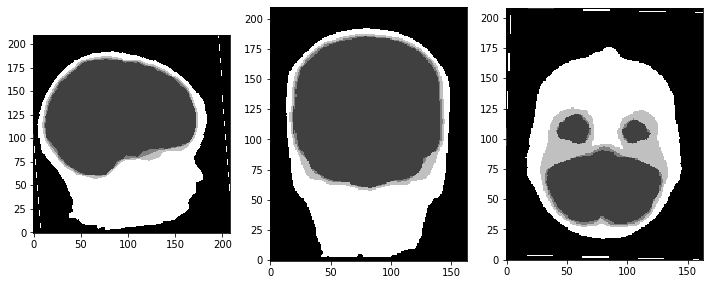

In [15]:
bem_path = root / "Preschool" / "Sources" / "BEM" / "AVG3-0Years3T_segmented_BEM4.nii.gz"
epi_img = nib.load(str(bem_path))
epi_img_data = deepcopy(epi_img.get_fdata())   

slice_0 = epi_img_data[75, :, :]
slice_1 = epi_img_data[:, 75, :]
slice_2 = epi_img_data[:, :, 75]
show_slices([slice_0, slice_1, slice_2])

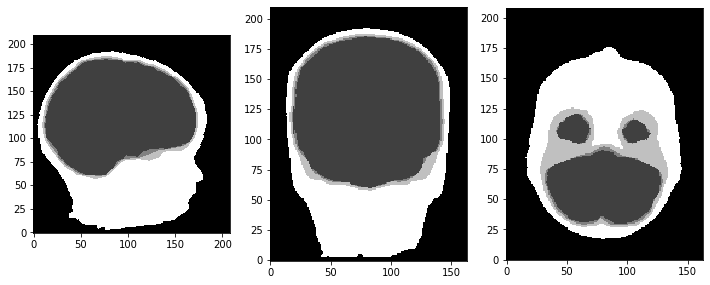

In [16]:
correct_line_artefact(epi_img_data)

slice_0 = epi_img_data[75, :, :]
slice_1 = epi_img_data[:, 75, :]
slice_2 = epi_img_data[:, :, 75]
show_slices([slice_0, slice_1, slice_2])

# Extracting subject brain surfaces

In [6]:
def get_source_file(subject, space, volume_type, extension="nii.gz", missing="raise"):
    for subset in ["Infants", "Preschool"]:
        file_name = "{}_{}.{}".format(subject, volume_type, extension)
        path = root / subset / space / file_name
        
        if path.exists():
            return path        
        
    if missing == "raise":
        raise ValueError("No source file {} available for subject {}.".format(file_name, subject))
    return path

def import_volumes(subject):
    command = ("mri_convert --conform {}\\\n" + 
               "                      {}")    
    for volume_type, space in zip(["brain", "head", "head_brain"], ["Brain", "Head", "Head"]):
        run_command(command.format(get_source_file(subject, space, volume_type), 
                                   fs_subject_path / subject / "{}.nii.gz".format(volume_type)))      

def make_brain_mask(subject):
    command = "mri_binarize --i {} \\\n             --o {}  --min 1 --max 1"      
    bem_path = get_source_file(subject.replace("ANTS", "AVG"), "Sources/BEM", "segmented_BEM4")
    head_brain_mask_path = fs_subject_path / subject / "head_brain_mask.nii.gz" 
    run_command(command.format(bem_path, head_brain_mask_path))
    
    
def create_flirt_mask(subject):
    command = "mri_binarize --i {} \\\n             --o {}  --min 1"
    brain_path = fs_subject_path / subject / "brain.nii.gz"
    brain_mask_path = fs_subject_path / subject / "brain_mask.nii.gz"        
    run_command(command.format(brain_path, brain_mask_path))


def map_brain_to_head_space(subject):
    brain_path = fs_subject_path / subject / "brain.nii.gz"
    head_brain_path = fs_subject_path / subject / "head_brain.nii.gz"

    brain_mask_path = fs_subject_path / subject / "brain_mask.nii.gz"
    head_brain_mask_path = fs_subject_path / subject / "head_brain_mask.nii.gz"        

    #brain_out_path = fs_subject_path / subject / "mprage_unmasked.nii.gz"        
    brain_out_path = fs_subject_path / subject / "mprage.nii.gz"            

    # By not using a weight mask on the ref surface, we want to force the brain to fit within
    # the brain volume defined in the head space. If it does not, the brain meshes cannot be fit 
    # within the bem surfaces of the head. 
    # This seems particularly important for the yougest template    
    command = ("flirt -dof 12 -setbackground 0 \\\n" + 
               "      -in {} \\\n" +
               "      -inweight {} \\\n" +
               "      -ref {} \\\n" +              # "      -refweight {} \\\n" +
               "      -out {}")

    command = command.format(brain_path, brain_mask_path, 
                             head_brain_path, #head_brain_mask_path, 
                             brain_out_path)             
    run_command(command)    
    
def create_recon_mask(subject):
    command = "mri_nu_correct.mni --i {} \\\n                   --o {} --n 2"
    command = command.format(str(fs_subject_path / subject / "mprage.nii.gz"), 
                             str(fs_subject_path / subject / "brainmask_nu.nii.gz"))
    run_command(command)
    
    
def adding_T1(subject):
    
    # Using the head volume as the T1 because this is used
    # for things like general visualization and fiducial localization
    # and having the head structure (not just the skull striped brain)
    # is useful for that purpose.
    orig = str(fs_subject_path / subject / "head.nii.gz")
    target = fs_subject_path / subject / "mri" / "T1.mgz"

    command = ("mri_convert {orig} \\\n"
               "            {target}").format(orig=orig, target=str(target))
    target.parent.mkdir(parents=True, exist_ok=True)
    run_command(command)
    
    
def recon_all(subject):
    age = parse("ANTS{}3T", subject).fixed[0]
    
    if "Weeks" in age:  
        age_in_months = np.round(float(age[:-5].replace("-", "."))*7/30, 2)      
        command = ('infant_recon_all --s {subject} --newborn \\\n' +
                   '                 --masked {path}/brainmask_nu.nii.gz')
        command = command.format(subject=subject, path=str(fs_subject_path / subject))
    else:
        if "Months" in age:
            age_in_months = float(age[:-6].replace("-", "."))
        elif "Years" in age:
            age_in_months = float(age[:-5].replace("-", "."))*12
        else:
            raise ValueError

        command = ('infant_recon_all --s {subject} --age {age} \\\n' + 
                   '                 --masked {path}/brainmask_nu.nii.gz')
        command = command.format(subject=subject, age=int(age_in_months), 
                                 path=str(fs_subject_path / subject))
        
    run_command(command)
    
    
def extract_brain_surfaces(subject):
    
    # Making the FreeSurfer subject folders
    (fs_subject_path / subject).mkdir(exist_ok=True)
    
    # Commands for converting the volumes in the "conform" space
    import_volumes(subject)
    
    # Making a brain mask for the head space, using the BEM
    make_brain_mask(subject)
    
    # Creating flirt masks
    create_flirt_mask(subject)
    
    # FLIRT transform of the brain to the head space
    map_brain_to_head_space(subject)

    # Commands for running intensity normalization for the brain masks for infant-recon-all
    # Since the brain is already skull stripped, we just use the brain as mask. 
    create_recon_mask(subject)
    
    # Commands for adding the mri/T1.mgz file expected by MNE
    adding_T1(subject)
    
    # Commands to run infant_recon_all
    recon_all(subject)

In [ ]:
for subject in tqdm(subjects):
    extract_brain_surfaces(subject)

------------------ RUNNING A COMMAND IN BASH ------------------
mri_convert --conform /media/christian/ElementsSE/Richards/Infants/Brain/ANTS1-0Months3T_brain.nii.gz\
                      /usr/local/freesurfer/subjects/ANTS1-0Months3T/brain.nii.gz
-------------------------- OUTPUT -----------------------------
mri_convert --conform /media/christian/ElementsSE/Richards/Infants/Brain/ANTS1-0Months3T_brain.nii.gz /usr/local/freesurfer/subjects/ANTS1-0Months3T/brain.nii.gz 
$Id: mri_convert.c,v 1.227 2017/02/16 19:15:42 greve Exp $
reading from /media/christian/ElementsSE/Richards/Infants/Brain/ANTS1-0Months3T_brain.nii.gz...
TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (-1, 0, 0)
j_ras = (0, 1, 0)
k_ras = (-0, -0, 1)
changing data type from float to uchar (noscale = 0)...
MRIchangeType: Building histogram 0 173.877 1000, flo=0, fhi=0.999, dest_type=0
Reslicing using trilinear interpolation 
writing to /usr/local/freesurfer/subjects/ANTS1-0Months3T/brain.nii.gz...
------------------

INFO: using NIfTI-1 qform 


$Id: mri_convert.c,v 1.227 2017/02/16 19:15:42 greve Exp $
reading from /media/christian/ElementsSE/Richards/Infants/Head/ANTS1-0Months3T_head.nii.gz...
TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (-1, 0, 0)
j_ras = (0, 1, 0)
k_ras = (-0, -0, 1)
changing data type from float to uchar (noscale = 0)...
MRIchangeType: Building histogram 0 233.996 1000, flo=0, fhi=0.999, dest_type=0
Reslicing using trilinear interpolation 
writing to /usr/local/freesurfer/subjects/ANTS1-0Months3T/head.nii.gz...
------------------------ END OUTPUT ---------------------------

------------------ RUNNING A COMMAND IN BASH ------------------
mri_convert --conform /media/christian/ElementsSE/Richards/Infants/Head/ANTS1-0Months3T_head_brain.nii.gz\
                      /usr/local/freesurfer/subjects/ANTS1-0Months3T/head_brain.nii.gz
-------------------------- OUTPUT -----------------------------
mri_convert --conform /media/christian/ElementsSE/Richards/Infants/Head/ANTS1-0Months3T_head_brain.nii.gz /usr

INFO: using NIfTI-1 qform 


$Id: mri_convert.c,v 1.227 2017/02/16 19:15:42 greve Exp $
reading from /media/christian/ElementsSE/Richards/Infants/Head/ANTS1-0Months3T_head_brain.nii.gz...
TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (-1, 0, 0)
j_ras = (0, 1, 0)
k_ras = (-0, -0, 1)
changing data type from float to uchar (noscale = 0)...
MRIchangeType: Building histogram 0 181.856 1000, flo=0, fhi=0.999, dest_type=0
Reslicing using trilinear interpolation 
writing to /usr/local/freesurfer/subjects/ANTS1-0Months3T/head_brain.nii.gz...
------------------------ END OUTPUT ---------------------------

------------------ RUNNING A COMMAND IN BASH ------------------
mri_binarize --i /media/christian/ElementsSE/Richards/Infants/Sources/BEM/AVG1-0Months3T_segmented_BEM4.nii.gz \
             --o /usr/local/freesurfer/subjects/ANTS1-0Months3T/head_brain_mask.nii.gz  --min 1 --max 1
-------------------------- OUTPUT -----------------------------


INFO: using NIfTI-1 qform 



$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /media/christian/ElementsSE/Richards/Infants/Sources/BEM/AVG1-0Months3T_segmented_BEM4.nii.gz --o /usr/local/freesurfer/subjects/ANTS1-0Months3T/head_brain_mask.nii.gz --min 1 --max 1 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /media/christian/ElementsSE/Richards/Infants/Sources/BEM/AVG1-0Months3T_segmented_BEM4.nii.gz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS1-0Months3T/head_brain_mask.nii.gz
Binarizing based on threshold
min        1
max        1
binval        1
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 455689 values in range
Counting number of voxels in first frame
Found 455688 voxels in final mask
Count: 455688 455688.000000 3149600 14.468123
mri_binarize done
------------------------ END OUTPUT ---------------------------



INFO: using NIfTI-1 qform 



$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS1-0Months3T/brain.nii.gz --o /usr/local/freesurfer/subjects/ANTS1-0Months3T/brain_mask.nii.gz --min 1 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /usr/local/freesurfer/subjects/ANTS1-0Months3T/brain.nii.gz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS1-0Months3T/brain_mask.nii.gz
Binarizing based on threshold
min        1
max        +infinity
binval        1
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 674566 values in range
Counting number of voxels in first frame
Found 674565 voxels in final mask
Count: 674565 674565.000000 16777216 4.020721
mri_binarize done
------------------------ END OUTPUT ---------------------------

------------------ RUNNING A COMMAND IN BASH ------------------
flirt -dof 12 

Voxel Volume is 1 mm^3
Generating list of segmentation ids
Found   1 segmentations
Computing statistics for each segmentation

Reporting on   1 segmentations
Using PrintSegStat
Computing spatial average of each frame
  0
Writing to /dev/shm/tmp.mri_nu_correct.mni.31048/input.mean.dat
mri_segstats done
mri_segstats --id 1 --seg /dev/shm/tmp.mri_nu_correct.mni.31048/ones.mgz --i /dev/shm/tmp.mri_nu_correct.mni.31048/nu2.mnc --sum /dev/shm/tmp.mri_nu_correct.mni.31048/sum.junk --avgwf /dev/shm/tmp.mri_nu_correct.mni.31048/output.mean.dat

$Id: mri_segstats.c,v 1.122 2017/01/23 18:23:14 greve Exp $
cwd 
cmdline mri_segstats --id 1 --seg /dev/shm/tmp.mri_nu_correct.mni.31048/ones.mgz --i /dev/shm/tmp.mri_nu_correct.mni.31048/nu2.mnc --sum /dev/shm/tmp.mri_nu_correct.mni.31048/sum.junk --avgwf /dev/shm/tmp.mri_nu_correct.mni.31048/output.mean.dat 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian
whitesurfname  white
UseRobust  0
Loading /dev/shm/tmp.mri_nu_correct.mn

Saving result to '/dev/shm/tmp.mri_nu_correct.mni.31048/nu2.mnc' (type = MINC )                       [ ok ]


$Id: mri_convert.c,v 1.227 2017/02/16 19:15:42 greve Exp $
reading from /usr/local/freesurfer/subjects/ANTS1-0Months3T/mprage.nii.gz...
TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (-1, 0, 0)
j_ras = (0, 0, -1)
k_ras = (0, 1, 0)
writing to /usr/local/freesurfer/subjects/ANTS1-0Months3T/mri/T1.mgz...
------------------------ END OUTPUT ---------------------------

------------------ RUNNING A COMMAND IN BASH ------------------
infant_recon_all --s ANTS1-0Months3T --age 1 \
                 --masked /usr/local/freesurfer/subjects/ANTS1-0Months3T/brainmask_nu.nii.gz
-------------------------- OUTPUT -----------------------------
InfantReconAll scripts DIR /usr/local/freesurfer/bin
PWD /home/christian/synchedin/infants_atlas_modeling/infant_template_paper

Log file is /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T_infant_recon_all.2010022250.log

Fri Oct 2 22:50:05 EDT 2020
--s ANTS1-0Months3T --age 1 --masked /usr/local/freesurfer/subjects/ANTS1-0Months3T/brainm

[NiftyReg F3D] [130] Current objective function: 1.07891 = (wSIM)1.07898 - (wBE)6.13e-05 - (wLE)1.32e-05 [+ 0.925641 mm]
[NiftyReg F3D] [138] Current objective function: 1.07897 = (wSIM)1.07905 - (wBE)6.31e-05 - (wLE)1.32e-05 [+ 0.46282 mm]
[NiftyReg F3D] [147] Current objective function: 1.07915 = (wSIM)1.07923 - (wBE)6.42e-05 - (wLE)1.32e-05 [+ 0.787373 mm]
[NiftyReg F3D] [156] Current objective function: 1.07918 = (wSIM)1.07926 - (wBE)6.54e-05 - (wLE)1.32e-05 [+ 0.814439 mm]
[NiftyReg F3D] [164] Current objective function: 1.0792 = (wSIM)1.07928 - (wBE)6.70e-05 - (wLE)1.32e-05 [+ 0.407219 mm]
[NiftyReg F3D] [172] Current objective function: 1.07932 = (wSIM)1.0794 - (wBE)6.84e-05 - (wLE)1.33e-05 [+ 0.63119 mm]
[NiftyReg F3D] [180] Current objective function: 1.07937 = (wSIM)1.07945 - (wBE)7.02e-05 - (wLE)1.33e-05 [+ 0.63119 mm]
[NiftyReg F3D] [189] Current objective function: 1.07945 = (wSIM)1.07953 - (wBE)7.22e-05 - (wLE)1.33e-05 [+ 0.978345 mm]
[NiftyReg F3D] [197] Current objectiv

[NiftyReg F3D] [97] Current objective function: 1.08227 = (wSIM)1.08228 - (wBE)2.11e-06 - (wLE)2.08e-06 [+ 0.89514 mm]
[NiftyReg F3D] [105] Current objective function: 1.08256 = (wSIM)1.08257 - (wBE)2.39e-06 - (wLE)2.08e-06 [+ 1.38747 mm]
[NiftyReg F3D] [113] Current objective function: 1.08272 = (wSIM)1.08272 - (wBE)2.92e-06 - (wLE)2.10e-06 [+ 0.693734 mm]
[NiftyReg F3D] [122] Current objective function: 1.08301 = (wSIM)1.08301 - (wBE)3.39e-06 - (wLE)2.12e-06 [+ 0.989438 mm]
[NiftyReg F3D] [130] Current objective function: 1.08321 = (wSIM)1.08322 - (wBE)3.83e-06 - (wLE)2.13e-06 [+ 1.12549 mm]
[NiftyReg F3D] [137] Current objective function: 1.08332 = (wSIM)1.08332 - (wBE)4.44e-06 - (wLE)2.14e-06 [+ 0.562743 mm]
[NiftyReg F3D] [145] Current objective function: 1.08368 = (wSIM)1.08369 - (wBE)4.93e-06 - (wLE)2.16e-06 [+ 1.18176 mm]
[NiftyReg F3D] [153] Current objective function: 1.0837 = (wSIM)1.08371 - (wBE)5.41e-06 - (wLE)2.18e-06 [+ 0.59088 mm]
[NiftyReg F3D] [161] Current objective 

[NiftyReg F3D] [51] Current objective function: 1.06674 = (wSIM)1.06724 - (wBE)4.44e-04 - (wLE)5.00e-05 [+ 1 mm]
[NiftyReg F3D] [60] Current objective function: 1.0668 = (wSIM)1.06733 - (wBE)4.76e-04 - (wLE)5.09e-05 [+ 1 mm]
[NiftyReg F3D] [69] Current objective function: 1.06684 = (wSIM)1.06745 - (wBE)5.61e-04 - (wLE)5.32e-05 [+ 1 mm]
[NiftyReg F3D] [79] Current objective function: 1.06689 = (wSIM)1.06758 - (wBE)6.35e-04 - (wLE)5.51e-05 [+ 0.517187 mm]
[NiftyReg F3D] [87] Current objective function: 1.06691 = (wSIM)1.06763 - (wBE)6.60e-04 - (wLE)5.58e-05 [+ 0.517187 mm]
[NiftyReg F3D] [96] Current objective function: 1.06692 = (wSIM)1.06767 - (wBE)6.95e-04 - (wLE)5.67e-05 [+ 0.276372 mm]
[NiftyReg F3D] [103] Current objective function: 1.06693 = (wSIM)1.06773 - (wBE)7.42e-04 - (wLE)5.80e-05 [+ 0.138186 mm]
[NiftyReg F3D] [109] Current objective function: 1.06693 = (wSIM)1.06775 - (wBE)7.58e-04 - (wLE)5.84e-05 [+ 0.138186 mm]
[NiftyReg F3D] [117] Current objective function: 1.06693 = (

[NiftyReg F3D] [190] Current objective function: 1.07811 = (wSIM)1.07821 - (wBE)9.29e-05 - (wLE)1.03e-05 [+ 0.879716 mm]
[NiftyReg F3D] [198] Current objective function: 1.07813 = (wSIM)1.07824 - (wBE)1.03e-04 - (wLE)1.06e-05 [+ 0.879716 mm]
[NiftyReg F3D] [206] Current objective function: 1.07825 = (wSIM)1.07838 - (wBE)1.14e-04 - (wLE)1.09e-05 [+ 0.879716 mm]
[NiftyReg F3D] [214] Current objective function: 1.07832 = (wSIM)1.07847 - (wBE)1.32e-04 - (wLE)1.15e-05 [+ 0.879716 mm]
[NiftyReg F3D] [222] Current objective function: 1.07846 = (wSIM)1.07862 - (wBE)1.51e-04 - (wLE)1.20e-05 [+ 0.879716 mm]
[NiftyReg F3D] [231] Current objective function: 1.07862 = (wSIM)1.07879 - (wBE)1.58e-04 - (wLE)1.23e-05 [+ 0.909957 mm]
[NiftyReg F3D] [239] Current objective function: 1.07867 = (wSIM)1.07885 - (wBE)1.63e-04 - (wLE)1.24e-05 [+ 0.227489 mm]
[NiftyReg F3D] [246] Current objective function: 1.07872 = (wSIM)1.0789 - (wBE)1.63e-04 - (wLE)1.24e-05 [+ 0.352608 mm]
[NiftyReg F3D] [254] Current obje

[NiftyReg F3D] [95] Current objective function: 1.0788 = (wSIM)1.0788 - (wBE)4.37e-06 - (wLE)4.79e-06 [+ 1.49373 mm]
[NiftyReg F3D] [103] Current objective function: 1.0788 = (wSIM)1.07881 - (wBE)4.57e-06 - (wLE)4.79e-06 [+ 0.186717 mm]
[NiftyReg F3D] [112] Current objective function: 1.07932 = (wSIM)1.07933 - (wBE)4.73e-06 - (wLE)4.79e-06 [+ 0.934895 mm]
[NiftyReg F3D] [119] Current objective function: 1.07934 = (wSIM)1.07935 - (wBE)4.81e-06 - (wLE)4.79e-06 [+ 0.233724 mm]
[NiftyReg F3D] [126] Current objective function: 1.07946 = (wSIM)1.07947 - (wBE)4.97e-06 - (wLE)4.79e-06 [+ 0.632223 mm]
[NiftyReg F3D] [131] Current objective function: 1.07946 = (wSIM)1.07947 - (wBE)4.97e-06 - (wLE)4.79e-06 [+ 0 mm]
[NiftyReg F3D] Current registration level done
[NiftyReg F3D] ***********************************************************
[NiftyReg F3D] Current level: 2 / 3
[NiftyReg F3D] Maximum iteration number: 300
[NiftyReg F3D] Current reference image
[NiftyReg F3D] 	* image dimension: 128 x 128

found 31 unique labels
computing distance maps and prior label probabilities
 1) processing /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/manseg-Template15-2-ANTS1-0Months3T.NIFTYREG.nii.gz
    note: label 2 not found in volume
    note: label 41 not found in volume
 2) processing /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/manseg-Template7-2-ANTS1-0Months3T.NIFTYREG.nii.gz
    note: label 2 not found in volume
    note: label 41 not found in volume
 3) processing /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/manseg-Template8-2-ANTS1-0Months3T.NIFTYREG.nii.gz
 4) processing /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/manseg-Template19-2-ANTS1-0Months3T.NIFTYREG.nii.gz
    note: label 2 not found in volume
    note: label 41 not found in volume
optimizing for intensity parameters and Q (E-step)
running iteration 1
    mean Q increment: 0.021156
    mean Q increment: 0.006192
    mean Q increment: 0.002463
    mean Q increment: 0.001109
    mean Q increment: 0


$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/mri/aseg.nii.gz --o /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/work/aseg.left.9.mgz --min 9 --max 9 --binval 255 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/mri/aseg.nii.gz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/work/aseg.left.9.mgz
Binarizing based on threshold
min        9
max        9
binval        255
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 6265 values in range
Counting number of voxels in first frame
Found 6264 voxels in final mask
Count: 6264 6264.000000 16777216 0.037336
mri_binarize done
mri_binarize --i /usr/local/freesurfer/s


$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/work/aseg.WM.left.mgz --o /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/work/aseg.WM.left.255.mgz --min 1 --max 1 --binval 255 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/work/aseg.WM.left.mgz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/work/aseg.WM.left.255.mgz
Binarizing based on threshold
min        1
max        1
binval        255
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 74367 values in range
Counting number of voxels in first frame
Found 74366 voxels in final mask
Count: 74366 74366.000000 16777216 0.443256
mri_binarize done
mri_binarize -


$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/mri/aseg.nii.gz --o /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/work/aseg.right.60.mgz --min 60 --max 60 --binval 127 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/mri/aseg.nii.gz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/work/aseg.right.60.mgz
Binarizing based on threshold
min        60
max        60
binval        127
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 1002 values in range
Counting number of voxels in first frame
Found 1001 voxels in final mask
Count: 1001 1001.000000 16777216 0.005966
mri_binarize done
mri_or /usr/local/freesurfer/sub

processing 2 input files
processing input volume 1 of 2: /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/work/aseg.left.4.mgz
processing input volume 2 of 2: /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/work/aseg.WM.left.255.mgz
writing output to /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/work/aseg.WM.left.vfilled.mgz
mri_binarize --i /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/work/aseg.WM.left.vfilled.mgz --o /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/work/aseg.WM.left.255.vfilled.mgz --min 1 --max 1 --binval 255

$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/work/aseg.WM.left.vfilled.mgz --o /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/work/aseg.WM.left.255.vfilled.mg

pass   1 (+++):   0 found -   0 modified     |    TOTAL:   0
pass   1 (+++):   0 found -   0 modified     |    TOTAL:   0
pass   1 (+++):   0 found -   0 modified     |    TOTAL:   0
pass   1 (+++):   0 found -   0 modified     |    TOTAL:   0
Iteration Number : 1
pass   1 (++):   8 found -   8 modified     |    TOTAL:   8
pass   2 (++):   0 found -   8 modified     |    TOTAL:   8
pass   1 (+-):   8 found -   8 modified     |    TOTAL:  16
pass   2 (+-):   0 found -   8 modified     |    TOTAL:  16
pass   1 (--):   1 found -   1 modified     |    TOTAL:  17
pass   2 (--):   0 found -   1 modified     |    TOTAL:  17
pass   1 (-+):   3 found -   3 modified     |    TOTAL:  20
pass   2 (-+):   0 found -   3 modified     |    TOTAL:  20
Iteration Number : 2
pass   1 (xy+):   0 found -   0 modified     |    TOTAL:   0
pass   1 (xy-):   0 found -   0 modified     |    TOTAL:   0
pass   1 (yz+):   0 found -   0 modified     |    TOTAL:   0
pass   1 (yz-):   1 found -   1 modified     |    T

365/3000: dt: 0.9000, rms radial error=116.430, avgs=0
370/3000: dt: 0.9000, rms radial error=115.773, avgs=0
375/3000: dt: 0.9000, rms radial error=115.120, avgs=0
380/3000: dt: 0.9000, rms radial error=114.470, avgs=0
385/3000: dt: 0.9000, rms radial error=113.824, avgs=0
390/3000: dt: 0.9000, rms radial error=113.182, avgs=0
395/3000: dt: 0.9000, rms radial error=112.543, avgs=0
400/3000: dt: 0.9000, rms radial error=111.909, avgs=0
405/3000: dt: 0.9000, rms radial error=111.277, avgs=0
410/3000: dt: 0.9000, rms radial error=110.650, avgs=0
415/3000: dt: 0.9000, rms radial error=110.025, avgs=0
420/3000: dt: 0.9000, rms radial error=109.405, avgs=0
425/3000: dt: 0.9000, rms radial error=108.788, avgs=0
430/3000: dt: 0.9000, rms radial error=108.174, avgs=0
435/3000: dt: 0.9000, rms radial error=107.564, avgs=0
440/3000: dt: 0.9000, rms radial error=106.958, avgs=0
445/3000: dt: 0.9000, rms radial error=106.355, avgs=0
450/3000: dt: 0.9000, rms radial error=105.756, avgs=0
455/3000: 

1120/3000: dt: 0.9000, rms radial error=50.030, avgs=0
1125/3000: dt: 0.9000, rms radial error=49.758, avgs=0
1130/3000: dt: 0.9000, rms radial error=49.487, avgs=0
1135/3000: dt: 0.9000, rms radial error=49.217, avgs=0
1140/3000: dt: 0.9000, rms radial error=48.950, avgs=0
1145/3000: dt: 0.9000, rms radial error=48.683, avgs=0
1150/3000: dt: 0.9000, rms radial error=48.419, avgs=0
1155/3000: dt: 0.9000, rms radial error=48.156, avgs=0
1160/3000: dt: 0.9000, rms radial error=47.894, avgs=0
1165/3000: dt: 0.9000, rms radial error=47.634, avgs=0
1170/3000: dt: 0.9000, rms radial error=47.376, avgs=0
1175/3000: dt: 0.9000, rms radial error=47.119, avgs=0
1180/3000: dt: 0.9000, rms radial error=46.864, avgs=0
1185/3000: dt: 0.9000, rms radial error=46.611, avgs=0
1190/3000: dt: 0.9000, rms radial error=46.358, avgs=0
1195/3000: dt: 0.9000, rms radial error=46.108, avgs=0
1200/3000: dt: 0.9000, rms radial error=45.859, avgs=0
1205/3000: dt: 0.9000, rms radial error=45.611, avgs=0
1210/3000:

1865/3000: dt: 0.9000, rms radial error=23.478, avgs=0
1870/3000: dt: 0.9000, rms radial error=23.373, avgs=0
1875/3000: dt: 0.9000, rms radial error=23.270, avgs=0
1880/3000: dt: 0.9000, rms radial error=23.167, avgs=0
1885/3000: dt: 0.9000, rms radial error=23.065, avgs=0
1890/3000: dt: 0.9000, rms radial error=22.963, avgs=0
1895/3000: dt: 0.9000, rms radial error=22.862, avgs=0
1900/3000: dt: 0.9000, rms radial error=22.762, avgs=0
1905/3000: dt: 0.9000, rms radial error=22.663, avgs=0
1910/3000: dt: 0.9000, rms radial error=22.565, avgs=0
1915/3000: dt: 0.9000, rms radial error=22.467, avgs=0
1920/3000: dt: 0.9000, rms radial error=22.370, avgs=0
1925/3000: dt: 0.9000, rms radial error=22.273, avgs=0
1930/3000: dt: 0.9000, rms radial error=22.177, avgs=0
1935/3000: dt: 0.9000, rms radial error=22.082, avgs=0
1940/3000: dt: 0.9000, rms radial error=21.988, avgs=0
1945/3000: dt: 0.9000, rms radial error=21.894, avgs=0
1950/3000: dt: 0.9000, rms radial error=21.801, avgs=0
1955/3000:

2980/3000: dt: 0.9000, rms radial error=12.723, avgs=0
2985/3000: dt: 0.9000, rms radial error=12.709, avgs=0
2990/3000: dt: 0.9000, rms radial error=12.696, avgs=0
2995/3000: dt: 0.9000, rms radial error=12.682, avgs=0
3000/3000: dt: 0.9000, rms radial error=12.669, avgs=0

spherical inflation complete.
/autofs/space/topaz_001/topaz_nightly_build/trunk/ah221-infant/mris_sphere/mris_sphere.cpp:393 should but doesn't set orig x et al here 
projecting onto sphere...
surface projected - minimizing metric distortion...
vertex spacing 1.86 +- 1.00 (0.01-->10.93) (max @ vno 27611 --> 28040)
face area 0.11 +- 0.12 (-0.49-->2.76)
epoch 1 (K=10.0), pass 1, starting sse = 2627.93
taking momentum steps...
taking momentum steps...
taking momentum steps...
pass 1 complete, delta sse/iter = 0.00/10 = 0.00045
epoch 2 (K=40.0), pass 1, starting sse = 270.03
taking momentum steps...
taking momentum steps...
taking momentum steps...
pass 1 complete, delta sse/iter = 0.03/10 = 0.00350
epoch 3 (K=160.0), 

Entering MRISinflateToSphere()
inflating to sphere (rms error < 2.00)
000: dt: 0.0000, rms radial error=175.570, avgs=0
005/3000: dt: 0.9000, rms radial error=175.316, avgs=0
010/3000: dt: 0.9000, rms radial error=174.769, avgs=0
015/3000: dt: 0.9000, rms radial error=174.049, avgs=0
020/3000: dt: 0.9000, rms radial error=173.229, avgs=0
025/3000: dt: 0.9000, rms radial error=172.354, avgs=0
030/3000: dt: 0.9000, rms radial error=171.446, avgs=0
035/3000: dt: 0.9000, rms radial error=170.520, avgs=0
040/3000: dt: 0.9000, rms radial error=169.584, avgs=0
045/3000: dt: 0.9000, rms radial error=168.644, avgs=0
050/3000: dt: 0.9000, rms radial error=167.703, avgs=0
055/3000: dt: 0.9000, rms radial error=166.765, avgs=0
060/3000: dt: 0.9000, rms radial error=165.829, avgs=0
065/3000: dt: 0.9000, rms radial error=164.896, avgs=0
070/3000: dt: 0.9000, rms radial error=163.967, avgs=0
075/3000: dt: 0.9000, rms radial error=163.042, avgs=0
080/3000: dt: 0.9000, rms radial error=162.122, avgs=0


1120/3000: dt: 0.9000, rms radial error=50.310, avgs=0
1125/3000: dt: 0.9000, rms radial error=50.036, avgs=0
1130/3000: dt: 0.9000, rms radial error=49.764, avgs=0
1135/3000: dt: 0.9000, rms radial error=49.493, avgs=0
1140/3000: dt: 0.9000, rms radial error=49.224, avgs=0
1145/3000: dt: 0.9000, rms radial error=48.956, avgs=0
1150/3000: dt: 0.9000, rms radial error=48.690, avgs=0
1155/3000: dt: 0.9000, rms radial error=48.426, avgs=0
1160/3000: dt: 0.9000, rms radial error=48.163, avgs=0
1165/3000: dt: 0.9000, rms radial error=47.902, avgs=0
1170/3000: dt: 0.9000, rms radial error=47.643, avgs=0
1175/3000: dt: 0.9000, rms radial error=47.385, avgs=0
1180/3000: dt: 0.9000, rms radial error=47.128, avgs=0
1185/3000: dt: 0.9000, rms radial error=46.874, avgs=0
1190/3000: dt: 0.9000, rms radial error=46.620, avgs=0
1195/3000: dt: 0.9000, rms radial error=46.369, avgs=0
1200/3000: dt: 0.9000, rms radial error=46.118, avgs=0
1205/3000: dt: 0.9000, rms radial error=45.870, avgs=0
1210/3000:

2235/3000: dt: 0.9000, rms radial error=18.005, avgs=0
2240/3000: dt: 0.9000, rms radial error=17.948, avgs=0
2245/3000: dt: 0.9000, rms radial error=17.892, avgs=0
2250/3000: dt: 0.9000, rms radial error=17.837, avgs=0
2255/3000: dt: 0.9000, rms radial error=17.782, avgs=0
2260/3000: dt: 0.9000, rms radial error=17.727, avgs=0
2265/3000: dt: 0.9000, rms radial error=17.673, avgs=0
2270/3000: dt: 0.9000, rms radial error=17.619, avgs=0
2275/3000: dt: 0.9000, rms radial error=17.566, avgs=0
2280/3000: dt: 0.9000, rms radial error=17.514, avgs=0
2285/3000: dt: 0.9000, rms radial error=17.462, avgs=0
2290/3000: dt: 0.9000, rms radial error=17.410, avgs=0
2295/3000: dt: 0.9000, rms radial error=17.359, avgs=0
2300/3000: dt: 0.9000, rms radial error=17.308, avgs=0
2305/3000: dt: 0.9000, rms radial error=17.258, avgs=0
2310/3000: dt: 0.9000, rms radial error=17.208, avgs=0
2315/3000: dt: 0.9000, rms radial error=17.159, avgs=0
2320/3000: dt: 0.9000, rms radial error=17.110, avgs=0
2325/3000:

2980/3000: dt: 0.9000, rms radial error=13.548, avgs=0
2985/3000: dt: 0.9000, rms radial error=13.536, avgs=0
2990/3000: dt: 0.9000, rms radial error=13.524, avgs=0
2995/3000: dt: 0.9000, rms radial error=13.512, avgs=0
3000/3000: dt: 0.9000, rms radial error=13.501, avgs=0

spherical inflation complete.
/autofs/space/topaz_001/topaz_nightly_build/trunk/ah221-infant/mris_sphere/mris_sphere.cpp:393 should but doesn't set orig x et al here 
projecting onto sphere...
surface projected - minimizing metric distortion...
vertex spacing 1.83 +- 1.08 (0.00-->13.15) (max @ vno 29059 --> 29076)
face area 0.10 +- 0.11 (-0.60-->2.86)
epoch 1 (K=10.0), pass 1, starting sse = 2920.29
taking momentum steps...
taking momentum steps...
taking momentum steps...
pass 1 complete, delta sse/iter = 0.01/10 = 0.00055
epoch 2 (K=40.0), pass 1, starting sse = 349.00
taking momentum steps...
taking momentum steps...
taking momentum steps...
pass 1 complete, delta sse/iter = 0.01/10 = 0.00107
epoch 3 (K=160.0), 

pass   2 (+-):   0 found -  41 modified     |    TOTAL:  62
pass   1 (--):  21 found -  21 modified     |    TOTAL:  83
pass   2 (--):   0 found -  21 modified     |    TOTAL:  83
pass   1 (-+):  27 found -  27 modified     |    TOTAL: 110
pass   2 (-+):   0 found -  27 modified     |    TOTAL: 110
Iteration Number : 2
pass   1 (xy+):   1 found -   1 modified     |    TOTAL:   1
pass   2 (xy+):   0 found -   1 modified     |    TOTAL:   1
pass   1 (xy-):   1 found -   1 modified     |    TOTAL:   2
pass   2 (xy-):   0 found -   1 modified     |    TOTAL:   2
pass   1 (yz+):   2 found -   2 modified     |    TOTAL:   4
pass   2 (yz+):   0 found -   2 modified     |    TOTAL:   4
pass   1 (yz-):   2 found -   2 modified     |    TOTAL:   6
pass   2 (yz-):   0 found -   2 modified     |    TOTAL:   6
pass   1 (xz+):   0 found -   0 modified     |    TOTAL:   6
pass   1 (xz-):   0 found -   0 modified     |    TOTAL:   6
Iteration Number : 2
pass   1 (+++):   0 found -   0 modified     |  

      BEST FITNESS (o)is -452.94120 
         mri =0.000   curv = 0.546 unmri = 450.759
         ( f=0.00 , v=0.00 , c=0.55 , q= 1.09  ) 
         ( f=0.00 , v=0.00 , c=0.55 , q= 1.09 ) 
      BEST FITNESS (M) is 142.04275 
         mri =0.000   curv = 0.715 unmri = -144.903
         ( f=0.00 , v=0.00 , c=0.72 , q= 1.43  ) 
         ( f=0.00 , v=0.00 , c=0.72 , q= 1.43 ) 
      BEST FITNESS (M) is 182.77749 
         mri =0.000   curv = 4.743 unmri = -201.751
         ( f=0.00 , v=0.00 , c=4.74 , q= 9.49  ) 
         ( f=0.00 , v=0.00 , c=4.74 , q= 9.49 ) 
      BEST FITNESS (M) is 202.02136 
         mri =0.000   curv = 1.067 unmri = -206.290
         ( f=0.00 , v=0.00 , c=1.07 , q= 2.13  ) 
         ( f=0.00 , v=0.00 , c=1.07 , q= 2.13 ) 
      BEST FITNESS (M) is 206.15737 
         mri =0.000   curv = 1.299 unmri = -211.352
         ( f=0.00 , v=0.00 , c=1.30 , q= 2.60  ) 
         ( f=0.00 , v=0.00 , c=1.30 , q= 2.60 ) 
      BEST FITNESS (M) is 212.71519 
         mri =0.000   cu

      BEST FITNESS (o)is 253.84264 
         mri =0.000   curv = 1.583 unmri = -260.176
         ( f=0.00 , v=0.00 , c=1.58 , q= 3.17  ) 
         ( f=0.00 , v=0.00 , c=1.58 , q= 3.17 ) 
      BEST FITNESS (o)is 257.62303 
         mri =0.000   curv = 1.810 unmri = -264.865
         ( f=0.00 , v=0.00 , c=1.81 , q= 3.62  ) 
         ( f=0.00 , v=0.00 , c=1.81 , q= 3.62 ) 
      BEST FITNESS (o)is 263.05562 
         mri =0.000   curv = 1.831 unmri = -270.378
         ( f=0.00 , v=0.00 , c=1.83 , q= 3.66  ) 
         ( f=0.00 , v=0.00 , c=1.83 , q= 3.66 ) 
      BEST FITNESS (o)is 281.87682 
         mri =0.000   curv = 3.675 unmri = -296.575
         ( f=0.00 , v=0.00 , c=3.67 , q= 7.35  ) 
         ( f=0.00 , v=0.00 , c=3.67 , q= 7.35 ) 
      BEST FITNESS (o)is 290.02022 
         mri =0.000   curv = 2.471 unmri = -299.903
         ( f=0.00 , v=0.00 , c=2.47 , q= 4.94  ) 
         ( f=0.00 , v=0.00 , c=2.47 , q= 4.94 ) 
      BEST FITNESS (o)is 303.85934 
         mri =0.000   curv = 

      BEST FITNESS (o)is -207.83047 
         mri =0.000   curv = 0.132 unmri = 207.302
         ( f=0.00 , v=0.00 , c=0.13 , q= 0.26  ) 
         ( f=0.00 , v=0.00 , c=0.13 , q= 0.26 ) 
      BEST FITNESS (o)is -109.73927 
         mri =0.000   curv = 0.157 unmri = 109.113
         ( f=0.00 , v=0.00 , c=0.16 , q= 0.31  ) 
         ( f=0.00 , v=0.00 , c=0.16 , q= 0.31 ) 
      BEST FITNESS (M) is 504.78074 
         mri =0.000   curv = 0.602 unmri = -507.188
         ( f=0.00 , v=0.00 , c=0.60 , q= 1.20  ) 
         ( f=0.00 , v=0.00 , c=0.60 , q= 1.20 ) 
      BEST FITNESS (M) is 636.32497 
         mri =0.000   curv = 2.845 unmri = -647.705
         ( f=0.00 , v=0.00 , c=2.84 , q= 5.69  ) 
         ( f=0.00 , v=0.00 , c=2.84 , q= 5.69 ) 
      150 patches have been generated - 64 self-intersected
INITIAL FITNESS :  0.00000 
FINAL FITNESS   :  636.32495 
# generated patches : 150 (64 self-intersecting)
AFTER CORRECTION, EULER IS 2 
Surface Diagnostics:       
   eno=2 (nv=37082, nf=74

      BEST FITNESS (o)is 71.88435 
         mri =0.000   curv = 0.366 unmri = -73.348
         ( f=0.00 , v=0.00 , c=0.37 , q= 0.73  ) 
         ( f=0.00 , v=0.00 , c=0.37 , q= 0.73 ) 
      BEST FITNESS (M) is 150.60137 
         mri =0.000   curv = 2.919 unmri = -162.278
         ( f=0.00 , v=0.00 , c=2.92 , q= 5.84  ) 
         ( f=0.00 , v=0.00 , c=2.92 , q= 5.84 ) 
      BEST FITNESS (M) is 157.67359 
         mri =0.000   curv = 0.840 unmri = -161.035
         ( f=0.00 , v=0.00 , c=0.84 , q= 1.68  ) 
         ( f=0.00 , v=0.00 , c=0.84 , q= 1.68 ) 
      BEST FITNESS (M) is 160.25319 
         mri =0.000   curv = 0.940 unmri = -164.015
         ( f=0.00 , v=0.00 , c=0.94 , q= 1.88  ) 
         ( f=0.00 , v=0.00 , c=0.94 , q= 1.88 ) 
      BEST FITNESS (M) is 161.32275 
         mri =0.000   curv = 0.785 unmri = -164.464
         ( f=0.00 , v=0.00 , c=0.79 , q= 1.57  ) 
         ( f=0.00 , v=0.00 , c=0.79 , q= 1.57 ) 
      50 patches have been generated - 11 self-intersected
INIT

      315 patches have been generated - 119 self-intersected
      max face = 1005(1253) - loop = 2 (2)  - ntries = [152,412]
      BEST FITNESS (o)is 49.01306 
         mri =0.000   curv = 2.306 unmri = -58.239
         ( f=0.00 , v=0.00 , c=2.31 , q= 4.61  ) 
         ( f=0.00 , v=0.00 , c=2.31 , q= 4.61 ) 
      BEST FITNESS (M) is 77.80429 
         mri =0.000   curv = 3.084 unmri = -90.141
         ( f=0.00 , v=0.00 , c=3.08 , q= 6.17  ) 
         ( f=0.00 , v=0.00 , c=3.08 , q= 6.17 ) 
      BEST FITNESS (M) is 158.55485 
         mri =0.000   curv = 2.542 unmri = -168.724
         ( f=0.00 , v=0.00 , c=2.54 , q= 5.08  ) 
         ( f=0.00 , v=0.00 , c=2.54 , q= 5.08 ) 
      BEST FITNESS (M) is 286.13607 
         mri =0.000   curv = 2.200 unmri = -294.938
         ( f=0.00 , v=0.00 , c=2.20 , q= 4.40  ) 
         ( f=0.00 , v=0.00 , c=2.20 , q= 4.40 ) 
      314 patches have been generated - 146 self-intersected
INITIAL FITNESS :  0.00000 
FINAL FITNESS   :  286.13608 
# genera

creating distance transform volume from segmentation
averaging target values for 5 iterations...
Positioning White Surface: tspring = 1, nspring = 0.5, spring = 0, niters = 100 l_repulse = 5, checktol = 0
Entering MRISpositionSurface()
  max_mm = 0.3
  MAX_REDUCTIONS = 2, REDUCTION_PCT = 0.5
  parms->check_tol = 0, niterations = 100
tol=1.0e-04, sigma=2.0, host=chris, nav=4, nbrs=2, l_repulse=5.000, l_tspring=1.000, l_nspring=0.500, l_intensity=0.200, l_curv=1.000
mom=0.00, dt=0.50
complete_dist_mat 0
rms 0
smooth_averages 0
remove_neg 0
ico_order 0
which_surface 0
target_radius 0.000000
nfields 0
scale 0.000000
desired_rms_height 0.000000
momentum 0.000000
nbhd_size 0
max_nbrs 0
niterations 100
nsurfaces 0
SURFACES 3
flags 0 (0)
use curv 0
no sulc 0
no rigid align 0
mris->nsize 2
mris->hemisphere 0
randomSeed 0

000: dt: 0.0000, sse=29627322.0, rms=64.357
rms = 179.9916/64.3567, sse=433091875.8/29627321.0, time step reduction 1 of 3 to 0.250  0 1 1
   RMS increased, rejecting step
rms

only generating white matter surface
using soap bubble smoothing to remove vertex intersections
using orig starting white location...
using aseg volume aseg to prevent surfaces crossing the midline
creating surfaces to cover  segmented volume /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/mri/aseg.nii.gz
not using aparc to prevent surfaces crossing the midline
INFO: assuming MGZ format for volumes.
using brain.finalsurfs as T1 volume...
$Id: mris_make_surfaces.c,v 1.172 2017/02/16 19:42:36 fischl Exp $
$Id$

cd /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/mri
setenv SUBJECTS_DIR /usr/local/freesurfer/subjects/ANTS1-0Months3T/work
mris_make_surfaces -output .dist -soap -orig_white orig -aseg aseg -cover_seg /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/mri/aseg.nii.gz -noaparc -whiteonly -mgz -T1 brain.finalsurfs ANTS1-0Months3T rh 

reading volume /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/mri/fi

averaging target values for 5 iterations...
Positioning White Surface: tspring = 1, nspring = 0.5, spring = 0, niters = 100 l_repulse = 5, checktol = 0
Entering MRISpositionSurface()
  max_mm = 0.3
  MAX_REDUCTIONS = 2, REDUCTION_PCT = 0.5
  parms->check_tol = 0, niterations = 100
tol=1.0e-04, sigma=0.2, host=chris, nav=0, nbrs=2, l_repulse=5.000, l_tspring=1.000, l_nspring=0.500, l_intensity=0.200, l_curv=1.000
mom=0.00, dt=0.50
000: dt: 0.0000, sse=22510994.0, rms=56.436
rms = 180.9663/56.4356, sse=263624867.2/22510994.3, time step reduction 1 of 3 to 0.250  0 1 1
   RMS increased, rejecting step
rms = 180.9401/56.4356, sse=263608076.6/22510994.3, time step reduction 2 of 3 to 0.125  0 1 1
   RMS increased, rejecting step
rms = 180.9345/56.4356, sse=263918052.3/22510994.3, time step reduction 3 of 3 to 0.062  0 1 1
   RMS increased, rejecting step
004: dt: 0.1250, sse=263918048.0, rms=180.934 (-220.603%)
  maximum number of reductions reached, breaking from loop
positioning took 0.1 

scaling brain by 0.564...
/autofs/space/topaz_001/topaz_nightly_build/trunk/ah221-infant/mris_sphere/mris_sphere.cpp:393 should but doesn't set orig x et al here 
projecting onto sphere...
surface projected - minimizing metric distortion...
MRISunfold() max_passes = 1 -------
tol=5.0e-01, sigma=0.0, host=chris, nav=1024, nbrs=2, l_area=1.000, l_dist=1.000
using quadratic fit line minimization
complete_dist_mat 0
rms 0
smooth_averages 0
remove_neg 0
ico_order 0
which_surface 0
target_radius 0.000000
nfields 0
scale 1.000000
desired_rms_height -1.000000
momentum 0.900000
nbhd_size 7
max_nbrs 8
niterations 25
nsurfaces 0
SURFACES 3
flags 0 (0)
use curv 0
no sulc 0
no rigid align 0
mris->nsize 2
mris->hemisphere 0
randomSeed 0

/autofs/space/topaz_001/topaz_nightly_build/trunk/ah221-infant/utils/mrisurf_metricProperties.cpp:3310 using incompatible MRIS_SPHERE MRIS_PATCH
mris_sphere supposed to be reproducible but seed not set
--------------------
  mrisRemoveNegativeArea()
pass 1: epoch 1 

552: dt=0.7660, 1537 negative triangles
553: dt=0.7660, 1533 negative triangles
554: dt=0.7660, 1540 negative triangles
555: dt=0.7660, 1544 negative triangles
556: dt=0.7277, 1545 negative triangles
557: dt=0.7277, 1551 negative triangles
558: dt=0.7277, 1550 negative triangles
559: dt=0.7277, 1552 negative triangles
560: dt=0.7277, 1543 negative triangles
561: dt=0.7277, 1539 negative triangles
562: dt=0.7277, 1545 negative triangles
563: dt=0.7277, 1539 negative triangles
564: dt=0.7277, 1543 negative triangles
565: dt=0.7277, 1546 negative triangles
566: dt=0.6914, 1555 negative triangles
567: dt=0.6914, 1550 negative triangles
568: dt=0.6914, 1542 negative triangles
569: dt=0.6914, 1540 negative triangles
570: dt=0.6914, 1543 negative triangles
571: dt=0.6914, 1547 negative triangles
572: dt=0.6914, 1547 negative triangles
573: dt=0.6914, 1552 negative triangles
574: dt=0.6914, 1548 negative triangles
575: dt=0.6914, 1554 negative triangles
576: dt=0.6568, 1552 negative triangles


758: dt=0.2609, 1572 negative triangles
759: dt=0.2609, 1566 negative triangles
760: dt=0.2609, 1574 negative triangles
761: dt=0.2609, 1571 negative triangles
762: dt=0.2609, 1576 negative triangles
763: dt=0.2609, 1575 negative triangles
764: dt=0.2609, 1576 negative triangles
765: dt=0.2609, 1568 negative triangles
766: dt=0.2478, 1569 negative triangles
767: dt=0.2478, 1568 negative triangles
768: dt=0.2478, 1568 negative triangles
769: dt=0.2478, 1568 negative triangles
770: dt=0.2478, 1569 negative triangles
771: dt=0.2478, 1565 negative triangles
772: dt=0.2478, 1566 negative triangles
773: dt=0.2478, 1569 negative triangles
774: dt=0.2478, 1571 negative triangles
775: dt=0.2478, 1569 negative triangles
776: dt=0.2354, 1571 negative triangles
777: dt=0.2354, 1572 negative triangles
778: dt=0.2354, 1577 negative triangles
779: dt=0.2354, 1575 negative triangles
780: dt=0.2354, 1573 negative triangles
781: dt=0.2354, 1568 negative triangles
782: dt=0.2354, 1568 negative triangles


964: dt=0.0935, 1577 negative triangles
965: dt=0.0935, 1576 negative triangles
966: dt=0.0888, 1577 negative triangles
967: dt=0.0888, 1581 negative triangles
968: dt=0.0888, 1579 negative triangles
969: dt=0.0888, 1578 negative triangles
970: dt=0.0888, 1579 negative triangles
971: dt=0.0888, 1581 negative triangles
972: dt=0.0888, 1580 negative triangles
973: dt=0.0888, 1582 negative triangles
974: dt=0.0888, 1582 negative triangles
975: dt=0.0888, 1579 negative triangles
976: dt=0.0844, 1579 negative triangles
977: dt=0.0844, 1581 negative triangles
978: dt=0.0844, 1577 negative triangles
979: dt=0.0844, 1579 negative triangles
980: dt=0.0844, 1575 negative triangles
981: dt=0.0844, 1581 negative triangles
982: dt=0.0844, 1574 negative triangles
983: dt=0.0844, 1578 negative triangles
984: dt=0.0844, 1576 negative triangles
985: dt=0.0844, 1577 negative triangles
986: dt=0.0802, 1577 negative triangles
987: dt=0.0802, 1577 negative triangles
988: dt=0.0802, 1577 negative triangles


1166: dt=0.0319, 1569 negative triangles
1167: dt=0.0319, 1573 negative triangles
1168: dt=0.0319, 1573 negative triangles
1169: dt=0.0319, 1571 negative triangles
1170: dt=0.0319, 1573 negative triangles
1171: dt=0.0319, 1569 negative triangles
1172: dt=0.0319, 1575 negative triangles
1173: dt=0.0319, 1573 negative triangles
1174: dt=0.0319, 1574 negative triangles
1175: dt=0.0319, 1575 negative triangles
1176: dt=0.0303, 1575 negative triangles
1177: dt=0.0303, 1573 negative triangles
1178: dt=0.0303, 1574 negative triangles
1179: dt=0.0303, 1574 negative triangles
1180: dt=0.0303, 1574 negative triangles
1181: dt=0.0303, 1573 negative triangles
1182: dt=0.0303, 1575 negative triangles
1183: dt=0.0303, 1575 negative triangles
1184: dt=0.0303, 1576 negative triangles
1185: dt=0.0303, 1573 negative triangles
1186: dt=0.0287, 1576 negative triangles
1187: dt=0.0287, 1576 negative triangles
1188: dt=0.0287, 1576 negative triangles
1189: dt=0.0287, 1574 negative triangles
1190: dt=0.0287,

1366: dt=0.0114, 1569 negative triangles
1367: dt=0.0114, 1574 negative triangles
1368: dt=0.0114, 1568 negative triangles
1369: dt=0.0114, 1568 negative triangles
1370: dt=0.0114, 1571 negative triangles
1371: dt=0.0114, 1570 negative triangles
1372: dt=0.0114, 1568 negative triangles
1373: dt=0.0114, 1572 negative triangles
1374: dt=0.0114, 1571 negative triangles
1375: dt=0.0114, 1568 negative triangles
1376: dt=0.0108, 1573 negative triangles
1377: dt=0.0108, 1571 negative triangles
1378: dt=0.0108, 1573 negative triangles
1379: dt=0.0108, 1573 negative triangles
1380: 1573 negative triangles
writing spherical brain to /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/surf/lh.sphere
mris_sphere utimesec    447.666866
mris_sphere stimesec    0.963928
mris_sphere ru_maxrss   1671908
mris_sphere ru_ixrss    0
mris_sphere ru_idrss    0
mris_sphere ru_isrss    0
mris_sphere ru_minflt   628575
mris_sphere ru_majflt   0
mris_sphere ru_nswap    0
mris_sphere ru_inblock  0

210: dt=0.8488, 1620 negative triangles
211: dt=0.8488, 1628 negative triangles
212: dt=0.8488, 1633 negative triangles
213: dt=0.8488, 1625 negative triangles
214: dt=0.8488, 1627 negative triangles
215: dt=0.8488, 1625 negative triangles
216: dt=0.8488, 1626 negative triangles
217: dt=0.8488, 1632 negative triangles
218: dt=0.8488, 1632 negative triangles
219: dt=0.8064, 1623 negative triangles
220: dt=0.8064, 1625 negative triangles
221: dt=0.8064, 1629 negative triangles
222: dt=0.8064, 1634 negative triangles
223: dt=0.8064, 1635 negative triangles
224: dt=0.8064, 1639 negative triangles
225: dt=0.8064, 1635 negative triangles
226: dt=0.8064, 1623 negative triangles
227: dt=0.8064, 1629 negative triangles
228: dt=0.8064, 1622 negative triangles
229: dt=0.7660, 1621 negative triangles
230: dt=0.7660, 1629 negative triangles
231: dt=0.7660, 1630 negative triangles
232: dt=0.7660, 1623 negative triangles
233: dt=0.7660, 1635 negative triangles
234: dt=0.7660, 1628 negative triangles


417: dt=0.3932, 1598 negative triangles
418: dt=0.3932, 1588 negative triangles
419: dt=0.3932, 1594 negative triangles
420: dt=0.3736, 1589 negative triangles
421: dt=0.3736, 1590 negative triangles
422: dt=0.3736, 1593 negative triangles
423: dt=0.3736, 1590 negative triangles
424: dt=0.3736, 1594 negative triangles
425: dt=0.3736, 1593 negative triangles
426: dt=0.3736, 1591 negative triangles
427: dt=0.3736, 1590 negative triangles
428: dt=0.3736, 1599 negative triangles
429: dt=0.3736, 1596 negative triangles
430: dt=0.3549, 1590 negative triangles
431: dt=0.3549, 1592 negative triangles
432: dt=0.3549, 1584 negative triangles
433: dt=0.3549, 1585 negative triangles
434: dt=0.3549, 1582 negative triangles
435: dt=0.3549, 1580 negative triangles
436: dt=0.3549, 1582 negative triangles
437: dt=0.3549, 1582 negative triangles
438: dt=0.3549, 1588 negative triangles
439: dt=0.3549, 1584 negative triangles
440: dt=0.3549, 1586 negative triangles
441: dt=0.3549, 1588 negative triangles


624: dt=0.2019, 1556 negative triangles
625: dt=0.2019, 1554 negative triangles
626: dt=0.2019, 1554 negative triangles
627: dt=0.2019, 1555 negative triangles
628: dt=0.2019, 1556 negative triangles
629: dt=0.2019, 1556 negative triangles
630: dt=0.2019, 1549 negative triangles
631: dt=0.2019, 1556 negative triangles
632: dt=0.1918, 1552 negative triangles
633: dt=0.1918, 1564 negative triangles
634: dt=0.1918, 1555 negative triangles
635: dt=0.1918, 1563 negative triangles
636: dt=0.1918, 1566 negative triangles
637: dt=0.1918, 1575 negative triangles
638: dt=0.1918, 1577 negative triangles
639: dt=0.1918, 1573 negative triangles
640: dt=0.1918, 1583 negative triangles
641: dt=0.1918, 1584 negative triangles
642: dt=0.1822, 1584 negative triangles
643: dt=0.1822, 1597 negative triangles
644: dt=0.1822, 1593 negative triangles
645: dt=0.1822, 1601 negative triangles
646: dt=0.1822, 1599 negative triangles
647: dt=0.1822, 1598 negative triangles
648: dt=0.1822, 1603 negative triangles


831: dt=0.0724, 1638 negative triangles
832: dt=0.0687, 1633 negative triangles
833: dt=0.0687, 1634 negative triangles
834: dt=0.0687, 1640 negative triangles
835: dt=0.0687, 1636 negative triangles
836: dt=0.0687, 1643 negative triangles
837: dt=0.0687, 1636 negative triangles
838: dt=0.0687, 1637 negative triangles
839: dt=0.0687, 1637 negative triangles
840: dt=0.0687, 1633 negative triangles
841: dt=0.0687, 1637 negative triangles
842: dt=0.0653, 1635 negative triangles
843: dt=0.0653, 1639 negative triangles
844: dt=0.0653, 1636 negative triangles
845: dt=0.0653, 1633 negative triangles
846: dt=0.0653, 1639 negative triangles
847: dt=0.0653, 1631 negative triangles
848: dt=0.0653, 1627 negative triangles
849: dt=0.0653, 1632 negative triangles
850: dt=0.0653, 1631 negative triangles
851: dt=0.0653, 1633 negative triangles
852: dt=0.0620, 1634 negative triangles
853: dt=0.0620, 1635 negative triangles
854: dt=0.0620, 1632 negative triangles
855: dt=0.0620, 1633 negative triangles


1035: dt=0.0246, 1641 negative triangles
1036: dt=0.0246, 1648 negative triangles
1037: dt=0.0246, 1644 negative triangles
1038: dt=0.0246, 1646 negative triangles
1039: dt=0.0246, 1644 negative triangles
1040: dt=0.0246, 1640 negative triangles
1041: dt=0.0246, 1637 negative triangles
1042: dt=0.0234, 1637 negative triangles
1043: dt=0.0234, 1638 negative triangles
1044: dt=0.0234, 1640 negative triangles
1045: dt=0.0234, 1641 negative triangles
1046: dt=0.0234, 1645 negative triangles
1047: dt=0.0234, 1645 negative triangles
1048: dt=0.0234, 1641 negative triangles
1049: dt=0.0234, 1645 negative triangles
1050: dt=0.0234, 1641 negative triangles
1051: dt=0.0234, 1642 negative triangles
1052: dt=0.0222, 1643 negative triangles
1053: dt=0.0222, 1645 negative triangles
1054: dt=0.0222, 1640 negative triangles
1055: dt=0.0222, 1651 negative triangles
1056: dt=0.0222, 1648 negative triangles
1057: dt=0.0222, 1648 negative triangles
1058: dt=0.0222, 1648 negative triangles
1059: dt=0.0222,

applying Gaussian smoothing to 0.50000% of the surface
dilating smoothing neighborhood 2 times before smoothing
setting curvature threshold to 6.406
smoothing 184 marked vertices
writing smoothed surface to /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/surf/rh.smoothwm3
mris_smooth -n 3 -nbrs 1 -gt .995 -d 2 -nw /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/surf/rh.smoothwm3 /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/surf/rh.smoothwm4
smoothing for 3 iterations
using neighborhood size = 1
smoothing surface tessellation for 3 iterations...
applying Gaussian smoothing to 0.50000% of the surface
dilating smoothing neighborhood 2 times before smoothing
setting curvature threshold to 3.904
smoothing 184 marked vertices
writing smoothed surface to /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/surf/rh.smoothwm4
mris_smooth -n 3 -nbrs 1 -gt .995 -d 2 -nw /usr/local/freesurfer/subjects/ANTS1-0Months3T/wor

398: dt=0.9405, 88 negative triangles
399: dt=0.9405, 90 negative triangles
400: dt=0.9405, 86 negative triangles
401: dt=0.9405, 84 negative triangles
402: dt=0.9405, 89 negative triangles
403: dt=0.9405, 87 negative triangles
404: dt=0.9405, 85 negative triangles
405: dt=0.9405, 84 negative triangles
406: dt=0.9405, 85 negative triangles
407: dt=0.9405, 83 negative triangles
408: dt=0.9405, 84 negative triangles
409: dt=0.9405, 78 negative triangles
410: dt=0.9405, 88 negative triangles
411: dt=0.9405, 91 negative triangles
412: dt=0.9405, 84 negative triangles
413: dt=0.9405, 83 negative triangles
414: dt=0.9405, 89 negative triangles
415: dt=0.9405, 84 negative triangles
416: dt=0.9405, 80 negative triangles
417: dt=0.9405, 79 negative triangles
418: dt=0.9405, 82 negative triangles
419: dt=0.8935, 78 negative triangles
420: dt=0.8935, 70 negative triangles
421: dt=0.8935, 72 negative triangles
422: dt=0.8935, 72 negative triangles
423: dt=0.8935, 70 negative triangles
424: dt=0.89

614: dt=0.5927, 49 negative triangles
615: dt=0.5927, 51 negative triangles
616: dt=0.5927, 49 negative triangles
617: dt=0.5927, 49 negative triangles
618: dt=0.5927, 49 negative triangles
619: dt=0.5631, 48 negative triangles
620: dt=0.5631, 48 negative triangles
621: dt=0.5631, 48 negative triangles
622: dt=0.5631, 48 negative triangles
623: dt=0.5631, 49 negative triangles
624: dt=0.5631, 48 negative triangles
625: dt=0.5631, 48 negative triangles
626: dt=0.5631, 46 negative triangles
627: dt=0.5631, 46 negative triangles
628: dt=0.5631, 45 negative triangles
629: dt=0.5631, 45 negative triangles
630: dt=0.5631, 45 negative triangles
631: dt=0.5631, 45 negative triangles
632: dt=0.5631, 45 negative triangles
633: dt=0.5631, 45 negative triangles
634: dt=0.5631, 45 negative triangles
635: dt=0.5631, 45 negative triangles
636: dt=0.5631, 47 negative triangles
637: dt=0.5631, 45 negative triangles
638: dt=0.5350, 45 negative triangles
639: dt=0.5350, 45 negative triangles
640: dt=0.53

830: dt=0.2609, 35 negative triangles
831: dt=0.2609, 35 negative triangles
832: dt=0.2609, 35 negative triangles
833: dt=0.2609, 35 negative triangles
834: dt=0.2609, 35 negative triangles
835: dt=0.2609, 36 negative triangles
836: dt=0.2609, 33 negative triangles
837: dt=0.2609, 33 negative triangles
838: dt=0.2609, 32 negative triangles
839: dt=0.2609, 32 negative triangles
840: dt=0.2609, 32 negative triangles
841: dt=0.2609, 32 negative triangles
842: dt=0.2609, 32 negative triangles
843: dt=0.2609, 32 negative triangles
844: dt=0.2609, 32 negative triangles
845: dt=0.2609, 32 negative triangles
846: dt=0.2609, 32 negative triangles
847: dt=0.2609, 32 negative triangles
848: dt=0.2478, 32 negative triangles
849: dt=0.2478, 32 negative triangles
850: dt=0.2478, 32 negative triangles
851: dt=0.2478, 32 negative triangles
852: dt=0.2478, 34 negative triangles
853: dt=0.2478, 32 negative triangles
854: dt=0.2478, 32 negative triangles
855: dt=0.2478, 32 negative triangles
856: dt=0.24

1046: dt=0.1148, 24 negative triangles
1047: dt=0.1091, 24 negative triangles
1048: dt=0.1091, 24 negative triangles
1049: dt=0.1091, 24 negative triangles
1050: dt=0.1091, 24 negative triangles
1051: dt=0.1091, 24 negative triangles
1052: dt=0.1091, 25 negative triangles
1053: dt=0.1091, 24 negative triangles
1054: dt=0.1091, 24 negative triangles
1055: dt=0.1091, 24 negative triangles
1056: dt=0.1091, 24 negative triangles
1057: dt=0.1036, 24 negative triangles
1058: dt=0.1036, 24 negative triangles
1059: dt=0.1036, 24 negative triangles
1060: dt=0.1036, 24 negative triangles
1061: dt=0.1036, 24 negative triangles
1062: dt=0.1036, 25 negative triangles
1063: dt=0.1036, 25 negative triangles
1064: dt=0.1036, 24 negative triangles
1065: dt=0.1036, 24 negative triangles
1066: dt=0.1036, 24 negative triangles
1067: dt=0.0984, 24 negative triangles
1068: dt=0.0984, 24 negative triangles
1069: dt=0.0984, 24 negative triangles
1070: dt=0.0984, 24 negative triangles
1071: dt=0.0984, 24 negat

1258: dt=0.0412, 21 negative triangles
1259: dt=0.0412, 21 negative triangles
1260: dt=0.0412, 21 negative triangles
1261: dt=0.0412, 21 negative triangles
1262: dt=0.0412, 21 negative triangles
1263: dt=0.0412, 20 negative triangles
1264: dt=0.0412, 20 negative triangles
1265: dt=0.0391, 20 negative triangles
1266: dt=0.0391, 20 negative triangles
1267: dt=0.0391, 20 negative triangles
1268: dt=0.0391, 20 negative triangles
1269: dt=0.0391, 20 negative triangles
1270: dt=0.0391, 20 negative triangles
1271: dt=0.0391, 20 negative triangles
1272: dt=0.0391, 20 negative triangles
1273: dt=0.0391, 20 negative triangles
1274: dt=0.0391, 20 negative triangles
1275: dt=0.0371, 20 negative triangles
1276: dt=0.0371, 21 negative triangles
1277: dt=0.0371, 20 negative triangles
1278: dt=0.0371, 21 negative triangles
1279: dt=0.0371, 22 negative triangles
1280: dt=0.0371, 21 negative triangles
1281: dt=0.0371, 21 negative triangles
1282: dt=0.0371, 21 negative triangles
1283: dt=0.0371, 21 negat

132: dt=0.8935, 111 negative triangles
133: dt=0.8935, 111 negative triangles
134: dt=0.8935, 112 negative triangles
135: dt=0.8935, 111 negative triangles
136: dt=0.8935, 111 negative triangles
137: dt=0.8935, 110 negative triangles
138: dt=0.8935, 113 negative triangles
139: dt=0.8488, 111 negative triangles
140: dt=0.8488, 111 negative triangles
141: dt=0.8488, 109 negative triangles
142: dt=0.8488, 111 negative triangles
143: dt=0.8488, 109 negative triangles
144: dt=0.8488, 109 negative triangles
145: dt=0.8488, 107 negative triangles
146: dt=0.8488, 109 negative triangles
147: dt=0.8488, 108 negative triangles
148: dt=0.8488, 107 negative triangles
149: dt=0.8488, 108 negative triangles
150: dt=0.8488, 109 negative triangles
151: dt=0.8488, 108 negative triangles
152: dt=0.8488, 109 negative triangles
153: dt=0.8488, 108 negative triangles
154: dt=0.8488, 110 negative triangles
155: dt=0.8064, 108 negative triangles
156: dt=0.8064, 110 negative triangles
157: dt=0.8064, 108 negat

348: dt=0.5927, 55 negative triangles
349: dt=0.5927, 54 negative triangles
350: dt=0.5927, 54 negative triangles
351: dt=0.5927, 54 negative triangles
352: dt=0.5927, 54 negative triangles
353: dt=0.5631, 54 negative triangles
354: dt=0.5631, 54 negative triangles
355: dt=0.5631, 53 negative triangles
356: dt=0.5631, 53 negative triangles
357: dt=0.5631, 53 negative triangles
358: dt=0.5631, 53 negative triangles
359: dt=0.5631, 54 negative triangles
360: dt=0.5631, 55 negative triangles
361: dt=0.5631, 56 negative triangles
362: dt=0.5631, 55 negative triangles
363: dt=0.5350, 55 negative triangles
364: dt=0.5350, 55 negative triangles
365: dt=0.5350, 55 negative triangles
366: dt=0.5350, 54 negative triangles
367: dt=0.5350, 54 negative triangles
368: dt=0.5350, 54 negative triangles
369: dt=0.5350, 54 negative triangles
370: dt=0.5350, 54 negative triangles
371: dt=0.5350, 54 negative triangles
372: dt=0.5350, 54 negative triangles
373: dt=0.5082, 55 negative triangles
374: dt=0.50

564: dt=0.2125, 50 negative triangles
565: dt=0.2019, 50 negative triangles
566: dt=0.2019, 50 negative triangles
567: dt=0.2019, 50 negative triangles
568: dt=0.2019, 50 negative triangles
569: dt=0.2019, 50 negative triangles
570: dt=0.2019, 50 negative triangles
571: dt=0.2019, 50 negative triangles
572: dt=0.2019, 50 negative triangles
573: dt=0.2019, 51 negative triangles
574: dt=0.2019, 50 negative triangles
575: dt=0.1918, 50 negative triangles
576: dt=0.1918, 50 negative triangles
577: dt=0.1918, 50 negative triangles
578: dt=0.1918, 50 negative triangles
579: dt=0.1918, 50 negative triangles
580: dt=0.1918, 50 negative triangles
581: dt=0.1918, 51 negative triangles
582: dt=0.1918, 51 negative triangles
583: dt=0.1918, 50 negative triangles
584: dt=0.1918, 50 negative triangles
585: dt=0.1822, 50 negative triangles
586: dt=0.1822, 50 negative triangles
587: dt=0.1822, 50 negative triangles
588: dt=0.1822, 50 negative triangles
589: dt=0.1822, 51 negative triangles
590: dt=0.18

780: dt=0.0687, 50 negative triangles
781: dt=0.0687, 50 negative triangles
782: dt=0.0687, 50 negative triangles
783: dt=0.0687, 50 negative triangles
784: dt=0.0687, 50 negative triangles
785: dt=0.0653, 50 negative triangles
786: dt=0.0653, 50 negative triangles
787: dt=0.0653, 50 negative triangles
788: dt=0.0653, 50 negative triangles
789: dt=0.0653, 50 negative triangles
790: dt=0.0653, 50 negative triangles
791: dt=0.0653, 50 negative triangles
792: dt=0.0653, 51 negative triangles
793: dt=0.0653, 50 negative triangles
794: dt=0.0653, 50 negative triangles
795: dt=0.0620, 50 negative triangles
796: dt=0.0620, 50 negative triangles
797: dt=0.0620, 50 negative triangles
798: dt=0.0620, 50 negative triangles
799: dt=0.0620, 50 negative triangles
800: dt=0.0620, 50 negative triangles
801: dt=0.0620, 50 negative triangles
802: dt=0.0620, 50 negative triangles
803: dt=0.0620, 50 negative triangles
804: dt=0.0620, 50 negative triangles
805: dt=0.0589, 50 negative triangles
806: dt=0.05

996: dt=0.0234, 49 negative triangles
997: dt=0.0234, 49 negative triangles
998: dt=0.0234, 49 negative triangles
999: dt=0.0234, 49 negative triangles
1000: dt=0.0234, 49 negative triangles
1001: dt=0.0234, 49 negative triangles
1002: dt=0.0234, 50 negative triangles
1003: dt=0.0234, 49 negative triangles
1004: dt=0.0222, 49 negative triangles
1005: dt=0.0222, 49 negative triangles
1006: dt=0.0222, 49 negative triangles
1007: dt=0.0222, 49 negative triangles
1008: dt=0.0222, 49 negative triangles
1009: dt=0.0222, 49 negative triangles
1010: dt=0.0222, 49 negative triangles
1011: dt=0.0222, 49 negative triangles
1012: dt=0.0222, 49 negative triangles
1013: dt=0.0222, 49 negative triangles
1014: dt=0.0211, 49 negative triangles
1015: dt=0.0211, 49 negative triangles
1016: dt=0.0211, 49 negative triangles
1017: dt=0.0211, 49 negative triangles
1018: dt=0.0211, 49 negative triangles
1019: dt=0.0211, 51 negative triangles
1020: dt=0.0211, 50 negative triangles
1021: dt=0.0211, 50 negative 

reading volume /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/mri/filled.mgz...
reading volume /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/mri/brain.mgz...
resampling filled volume to be in voxel register with T1
reading volume /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/mri/aseg.mgz...
reading volume /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/mri/wm.mgz...
resampling wm volume to be in voxel register with T1
MRIclipBrightWM(): nthresh=151577, wmmin=5, clip=110 
MRIfindBrightNonWM(): 309924 bright non-wm voxels segmented.
reading original surface position from /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/surf/lh.orig...
Input Surface Quality Stats
Area     74160  0.32045  0.11980 0.000420   1.4712
Corner  222480 60.00000 18.12892 1.018797 172.8933
Edge    111240  0.87930  0.21698 0.011106   2.7082
Hinge   111240 12.79144 13.24530 0.000000 173.9567
mean inside = 130.0, me

017: dt: 0.5000, sse=6734329.0, rms=24.664 (0.467%)
018: dt: 0.5000, sse=6688655.0, rms=24.575 (0.358%)
019: dt: 0.5000, sse=6654476.0, rms=24.508 (0.274%)
020: dt: 0.5000, sse=6628980.5, rms=24.458 (0.205%)
rms = 24.4193/24.4578, sse=6609922.0/6628980.7, time step reduction 1 of 3 to 0.250  0 0 1
021: dt: 0.5000, sse=6609922.0, rms=24.419 (0.157%)
rms = 24.3909/24.4193, sse=6596156.0/6609922.0, time step reduction 2 of 3 to 0.125  0 0 1
022: dt: 0.2500, sse=6596156.0, rms=24.391 (0.116%)
rms = 24.3666/24.3909, sse=6584327.7/6596156.0, time step reduction 3 of 3 to 0.062  0 0 1
023: dt: 0.1250, sse=6584327.5, rms=24.367 (0.100%)
  maximum number of reductions reached, breaking from loop
positioning took 0.4 minutes
Iteration 1 pial =========================================
j=0, i=1, sigma=1
smoothing T1 volume with sigma = 1.000
MRImask(): AllowDiffGeom = 1
MRImask(): AllowDiffGeom = 1
adding 0.25 to pial targets
averaging target values for 5 iterations...
Entering MRISpositionSurface(

reading volume /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/mri/filled.mgz...
reading volume /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/mri/brain.mgz...
resampling filled volume to be in voxel register with T1
reading volume /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/mri/aseg.mgz...
reading volume /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/mri/wm.mgz...
resampling wm volume to be in voxel register with T1
MRIclipBrightWM(): nthresh=151577, wmmin=5, clip=110 
MRIfindBrightNonWM(): 309924 bright non-wm voxels segmented.
reading original surface position from /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/surf/lh.orig...
Input Surface Quality Stats
Area     74160  0.32045  0.11980 0.000420   1.4712
Corner  222480 60.00000 18.12892 1.018797 172.8933
Edge    111240  0.87930  0.21698 0.011106   2.7082
Hinge   111240 12.79144 13.24530 0.000000 173.9567
mean inside = 130.0, me

017: dt: 0.5000, sse=6734329.0, rms=24.664 (0.467%)
018: dt: 0.5000, sse=6688655.0, rms=24.575 (0.358%)
019: dt: 0.5000, sse=6654476.0, rms=24.508 (0.274%)
020: dt: 0.5000, sse=6628980.5, rms=24.458 (0.205%)
rms = 24.4193/24.4578, sse=6609922.0/6628980.7, time step reduction 1 of 3 to 0.250  0 0 1
021: dt: 0.5000, sse=6609922.0, rms=24.419 (0.157%)
rms = 24.3909/24.4193, sse=6596156.0/6609922.0, time step reduction 2 of 3 to 0.125  0 0 1
022: dt: 0.2500, sse=6596156.0, rms=24.391 (0.116%)
rms = 24.3666/24.3909, sse=6584327.7/6596156.0, time step reduction 3 of 3 to 0.062  0 0 1
023: dt: 0.1250, sse=6584327.5, rms=24.367 (0.100%)
  maximum number of reductions reached, breaking from loop
positioning took 0.4 minutes
Iteration 1 pial =========================================
j=0, i=1, sigma=1
smoothing T1 volume with sigma = 1.000
MRImask(): AllowDiffGeom = 1
MRImask(): AllowDiffGeom = 1
adding 0.25 to pial targets
averaging target values for 5 iterations...
Entering MRISpositionSurface(

reading previously compute gray/white surface
not using aparc to prevent surfaces crossing the midline
creating surfaces to cover  segmented volume /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/mri/aseg.nii.gz
using white starting pial locations...
$Id: mris_make_surfaces.c,v 1.172 2017/02/16 19:42:36 fischl Exp $
$Id$

cd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
setenv SUBJECTS_DIR /usr/local/freesurfer/subjects/ANTS1-0Months3T/work
mris_make_surfaces -grad_dir 1 -intensity .3 -output .tmp -pial_offset .25 -nowhite -noaparc -cover_seg /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/mri/aseg.nii.gz -orig_pial white ANTS1-0Months3T rh 

reading volume /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/mri/filled.mgz...
reading volume /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/mri/brain.mgz...
resampling filled volume to be in voxel register with T1
reading volume /usr/local/

rms = 252.7355/252.2518, sse=674804739.5/672233968.6, time step reduction 1 of 3 to 0.250  0 1 1
   RMS increased, rejecting step
rms = 252.4949/252.2518, sse=673527836.2/672233968.6, time step reduction 2 of 3 to 0.125  0 1 1
   RMS increased, rejecting step
rms = 252.2880/252.2518, sse=672426585.3/672233968.6, time step reduction 3 of 3 to 0.062  0 1 1
   RMS increased, rejecting step
027: dt: 0.1250, sse=672426560.0, rms=252.288 (-0.014%)
  maximum number of reductions reached, breaking from loop
positioning took 0.1 minutes
writing pial surface to /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/surf/rh.pial.tmp...
writing smoothed curvature to rh.curv.pial.tmp
writing curvature file /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/surf/rh.curv.pial.tmp
writing smoothed area to rh.area.pial.tmp
writing curvature file /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/surf/rh.area.pial.tmp
vertex spacing 1.10 +- 0.55 (0.00-->6.4

rms = 23.5129/23.5439, sse=6042679.1/6057202.2, time step reduction 3 of 3 to 0.062  0 0 1
024: dt: 0.1250, sse=6042679.0, rms=23.513 (0.131%)
  maximum number of reductions reached, breaking from loop
positioning took 0.4 minutes
Iteration 1 pial =========================================
j=0, i=1, sigma=1
smoothing T1 volume with sigma = 1.000
MRImask(): AllowDiffGeom = 1
MRImask(): AllowDiffGeom = 1
adding 0.25 to pial targets
averaging target values for 5 iterations...
Entering MRISpositionSurface()
  max_mm = 0.3
  MAX_REDUCTIONS = 2, REDUCTION_PCT = 0.5
  parms->check_tol = 0, niterations = 100
tol=1.0e-04, sigma=1.0, host=chris, nav=8, nbrs=2, l_surf_repulse=5.000, l_tspring=1.000, l_nspring=0.500, l_intensity=0.300, l_curv=1.000
mom=0.00, dt=0.50
000: dt: 0.0000, sse=674897920.0, rms=252.751
rms = 253.2370/252.7513, sse=677484651.9/674897918.3, time step reduction 1 of 3 to 0.250  0 1 1
   RMS increased, rejecting step
rms = 252.9937/252.7513, sse=676190654.6/674897918.3, time s

reading input surface /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/surf/rh.white...
reading input pial surface /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/surf/rh.pial...
reading input white surface /usr/local/freesurfer/subjects/ANTS1-0Months3T/work/ANTS1-0Months3T/surf/rh.white...
INFO: using TH3 volume calc
INFO: assuming MGZ format for volumes.
Using TH3 vertex volume calc
Total face volume 94354.6
Total vertex volume 93736.1 (mask=0)
reading colortable from annotation file...
colortable with 36 entries read (originally /autofs/space/terrier_001/users/nicks/freesurfer/average/colortable_desikan_killiany.txt)
Saving annotation colortable aparc.annot.ctab

table columns are:
    number of vertices
    total surface area (mm^2)
    total gray matter volume (mm^3)
    average cortical thickness +- standard deviation (mm)
    integrated rectified mean curvature
    integrated rectified Gaussian curvature
    folding index
    intrinsic curv

INFO: using NIfTI-1 qform 


$Id: mri_convert.c,v 1.227 2017/02/16 19:15:42 greve Exp $
reading from /media/christian/ElementsSE/Richards/Infants/Head/ANTS2-0Months3T_head.nii.gz...
TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (-1, 0, 0)
j_ras = (0, 1, 0)
k_ras = (-0, -0, 1)
changing data type from float to uchar (noscale = 0)...
MRIchangeType: Building histogram 0 240.771 1000, flo=0, fhi=0.999, dest_type=0
Reslicing using trilinear interpolation 
writing to /usr/local/freesurfer/subjects/ANTS2-0Months3T/head.nii.gz...
------------------------ END OUTPUT ---------------------------

------------------ RUNNING A COMMAND IN BASH ------------------
mri_convert --conform /media/christian/ElementsSE/Richards/Infants/Head/ANTS2-0Months3T_head_brain.nii.gz\
                      /usr/local/freesurfer/subjects/ANTS2-0Months3T/head_brain.nii.gz
-------------------------- OUTPUT -----------------------------
mri_convert --conform /media/christian/ElementsSE/Richards/Infants/Head/ANTS2-0Months3T_head_brain.nii.gz /usr

INFO: using NIfTI-1 qform 


$Id: mri_convert.c,v 1.227 2017/02/16 19:15:42 greve Exp $
reading from /media/christian/ElementsSE/Richards/Infants/Head/ANTS2-0Months3T_head_brain.nii.gz...
TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (-1, 0, 0)
j_ras = (0, 1, 0)
k_ras = (-0, -0, 1)
changing data type from float to uchar (noscale = 0)...
MRIchangeType: Building histogram 0 203.728 1000, flo=0, fhi=0.999, dest_type=0
Reslicing using trilinear interpolation 
writing to /usr/local/freesurfer/subjects/ANTS2-0Months3T/head_brain.nii.gz...
------------------------ END OUTPUT ---------------------------

------------------ RUNNING A COMMAND IN BASH ------------------
mri_binarize --i /media/christian/ElementsSE/Richards/Infants/Sources/BEM/AVG2-0Months3T_segmented_BEM4.nii.gz \
             --o /usr/local/freesurfer/subjects/ANTS2-0Months3T/head_brain_mask.nii.gz  --min 1 --max 1
-------------------------- OUTPUT -----------------------------


INFO: using NIfTI-1 qform 



$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /media/christian/ElementsSE/Richards/Infants/Sources/BEM/AVG2-0Months3T_segmented_BEM4.nii.gz --o /usr/local/freesurfer/subjects/ANTS2-0Months3T/head_brain_mask.nii.gz --min 1 --max 1 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /media/christian/ElementsSE/Richards/Infants/Sources/BEM/AVG2-0Months3T_segmented_BEM4.nii.gz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS2-0Months3T/head_brain_mask.nii.gz
Binarizing based on threshold
min        1
max        1
binval        1
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 482464 values in range
Counting number of voxels in first frame
Found 482463 voxels in final mask
Count: 482463 482463.000000 3416320 14.122301
mri_binarize done
------------------------ END OUTPUT ---------------------------



INFO: using NIfTI-1 qform 



$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS2-0Months3T/brain.nii.gz --o /usr/local/freesurfer/subjects/ANTS2-0Months3T/brain_mask.nii.gz --min 1 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /usr/local/freesurfer/subjects/ANTS2-0Months3T/brain.nii.gz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS2-0Months3T/brain_mask.nii.gz
Binarizing based on threshold
min        1
max        +infinity
binval        1
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 636915 values in range
Counting number of voxels in first frame
Found 636914 voxels in final mask
Count: 636914 636914.000000 16777216 3.796303
mri_binarize done
------------------------ END OUTPUT ---------------------------

------------------ RUNNING A COMMAND IN BASH ------------------
flirt -dof 12 

Voxel Volume is 1 mm^3
Generating list of segmentation ids
Found   1 segmentations
Computing statistics for each segmentation

Reporting on   1 segmentations
Using PrintSegStat
Computing spatial average of each frame
  0
Writing to /dev/shm/tmp.mri_nu_correct.mni.4148/input.mean.dat
mri_segstats done
mri_segstats --id 1 --seg /dev/shm/tmp.mri_nu_correct.mni.4148/ones.mgz --i /dev/shm/tmp.mri_nu_correct.mni.4148/nu2.mnc --sum /dev/shm/tmp.mri_nu_correct.mni.4148/sum.junk --avgwf /dev/shm/tmp.mri_nu_correct.mni.4148/output.mean.dat

$Id: mri_segstats.c,v 1.122 2017/01/23 18:23:14 greve Exp $
cwd 
cmdline mri_segstats --id 1 --seg /dev/shm/tmp.mri_nu_correct.mni.4148/ones.mgz --i /dev/shm/tmp.mri_nu_correct.mni.4148/nu2.mnc --sum /dev/shm/tmp.mri_nu_correct.mni.4148/sum.junk --avgwf /dev/shm/tmp.mri_nu_correct.mni.4148/output.mean.dat 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian
whitesurfname  white
UseRobust  0
Loading /dev/shm/tmp.mri_nu_correct.mni.4148/on

Saving result to '/dev/shm/tmp.mri_nu_correct.mni.4148/nu2.mnc' (type = MINC )                       [ ok ]


$Id: mri_convert.c,v 1.227 2017/02/16 19:15:42 greve Exp $
reading from /usr/local/freesurfer/subjects/ANTS2-0Months3T/mprage.nii.gz...
TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (-1, 0, 0)
j_ras = (0, 0, -1)
k_ras = (0, 1, 0)
writing to /usr/local/freesurfer/subjects/ANTS2-0Months3T/mri/T1.mgz...
------------------------ END OUTPUT ---------------------------

------------------ RUNNING A COMMAND IN BASH ------------------
infant_recon_all --s ANTS2-0Months3T --age 2 \
                 --masked /usr/local/freesurfer/subjects/ANTS2-0Months3T/brainmask_nu.nii.gz
-------------------------- OUTPUT -----------------------------
InfantReconAll scripts DIR /usr/local/freesurfer/bin
PWD /home/christian/synchedin/infants_atlas_modeling/infant_template_paper

Log file is /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T_infant_recon_all.2010022354.log

Fri Oct 2 23:54:21 EDT 2020
--s ANTS2-0Months3T --age 2 --masked /usr/local/freesurfer/subjects/ANTS2-0Months3T/brainm

[NiftyReg F3D] [179] Current objective function: 1.08078 = (wSIM)1.08086 - (wBE)6.50e-05 - (wLE)1.38e-05 [+ 0.474767 mm]
[NiftyReg F3D] [186] Current objective function: 1.08078 = (wSIM)1.08086 - (wBE)6.53e-05 - (wLE)1.38e-05 [+ 0.237384 mm]
[NiftyReg F3D] [194] Current objective function: 1.08082 = (wSIM)1.0809 - (wBE)6.63e-05 - (wLE)1.38e-05 [+ 0.570314 mm]
[NiftyReg F3D] [203] Current objective function: 1.08086 = (wSIM)1.08095 - (wBE)6.74e-05 - (wLE)1.38e-05 [+ 1.19766 mm]
[NiftyReg F3D] [212] Current objective function: 1.08088 = (wSIM)1.08097 - (wBE)7.10e-05 - (wLE)1.39e-05 [+ 1.19766 mm]
[NiftyReg F3D] [222] Current objective function: 1.08102 = (wSIM)1.08111 - (wBE)7.38e-05 - (wLE)1.39e-05 [+ 1.52702 mm]
[NiftyReg F3D] [232] Current objective function: 1.08103 = (wSIM)1.08112 - (wBE)7.52e-05 - (wLE)1.40e-05 [+ 0.217123 mm]
[NiftyReg F3D] [241] Current objective function: 1.08111 = (wSIM)1.0812 - (wBE)7.55e-05 - (wLE)1.40e-05 [+ 0.7548 mm]
[NiftyReg F3D] [248] Current objective 

[NiftyReg F3D] [94] Current objective function: 1.1082 = (wSIM)1.10822 - (wBE)3.27e-06 - (wLE)1.78e-05 [+ 0.201699 mm]
[NiftyReg F3D] [102] Current objective function: 1.10833 = (wSIM)1.10835 - (wBE)3.28e-06 - (wLE)1.78e-05 [+ 0.612712 mm]
[NiftyReg F3D] [107] Current objective function: 1.10833 = (wSIM)1.10835 - (wBE)3.28e-06 - (wLE)1.78e-05 [+ 0 mm]
[NiftyReg F3D] Current registration level done
[NiftyReg F3D] ***********************************************************
[NiftyReg F3D] Current level: 2 / 3
[NiftyReg F3D] Maximum iteration number: 300
[NiftyReg F3D] Current reference image
[NiftyReg F3D] 	* image dimension: 128 x 128 x 128 x 1
[NiftyReg F3D] 	* image spacing: 2 x 2 x 2 mm
[NiftyReg F3D] Current floating image
[NiftyReg F3D] 	* image dimension: 128 x 128 x 128 x 1
[NiftyReg F3D] 	* image spacing: 2 x 2 x 2 mm
[NiftyReg F3D] Current control point image
[NiftyReg F3D] 	* image dimension: 29 x 29 x 29
[NiftyReg F3D] 	* image spacing: 10 x 10 x 10 mm
[NiftyReg F3D] Initial o

Padding value here nan
[reg_f3d] 
[reg_f3d] Command line:
[reg_f3d] 	 reg_f3d -ref /usr/local/freesurfer/subjects/ANTS2-0Months3T/brainmask_nu.nii.gz -flo /usr/local/freesurfer/average/CNYBCH/Template17/norm.nii.gz -aff /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/Template17-2-ANTS2-0Months3T.NIFTYREG.affine.txt -cpp /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/Template17-2-ANTS2-0Months3T.NIFTYREG.field.nii.gz -res /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/Template17-2-ANTS2-0Months3T.NIFTYREG.nii.gz
[reg_f3d] 
[reg_f3d] OpenMP is used with 12 thread(s)
[NiftyReg F3D] ***********************************************************
[NiftyReg F3D] INPUT PARAMETERS
[NiftyReg F3D] ***********************************************************
[NiftyReg F3D] Reference image:
[NiftyReg F3D] 	* name: /usr/local/freesurfer/subjects/ANTS2-0Months3T/brainmask_nu.nii.gz
[NiftyReg F3D] 	* image dimension: 256 x 256 x 256 x 1
[NiftyReg F3D] 	* image spacing: 1 x 1 x 1 mm
[NiftyReg

[NiftyReg F3D] [89] Current objective function: 1.08799 = (wSIM)1.08808 - (wBE)5.64e-05 - (wLE)3.43e-05 [+ 2.03125 mm]
[NiftyReg F3D] [98] Current objective function: 1.08821 = (wSIM)1.08831 - (wBE)6.17e-05 - (wLE)3.44e-05 [+ 2 mm]
[NiftyReg F3D] [108] Current objective function: 1.08842 = (wSIM)1.08852 - (wBE)6.91e-05 - (wLE)3.45e-05 [+ 3 mm]
[NiftyReg F3D] [117] Current objective function: 1.08849 = (wSIM)1.08861 - (wBE)7.90e-05 - (wLE)3.47e-05 [+ 0.5 mm]
[NiftyReg F3D] [127] Current objective function: 1.08881 = (wSIM)1.08893 - (wBE)8.19e-05 - (wLE)3.48e-05 [+ 1.3525 mm]
[NiftyReg F3D] [137] Current objective function: 1.08882 = (wSIM)1.08894 - (wBE)8.35e-05 - (wLE)3.48e-05 [+ 0.192309 mm]
[NiftyReg F3D] [146] Current objective function: 1.08892 = (wSIM)1.08903 - (wBE)8.36e-05 - (wLE)3.48e-05 [+ 0.584185 mm]
[NiftyReg F3D] [152] Current objective function: 1.08892 = (wSIM)1.08903 - (wBE)8.36e-05 - (wLE)3.48e-05 [+ 0 mm]
[NiftyReg F3D] Current registration level done
[NiftyReg F3D] *

[NiftyReg F3D] [136] Current objective function: 1.08018 = (wSIM)1.08026 - (wBE)6.64e-05 - (wLE)1.53e-05 [+ 1.10375 mm]
[NiftyReg F3D] [146] Current objective function: 1.08028 = (wSIM)1.08036 - (wBE)6.99e-05 - (wLE)1.54e-05 [+ 0.589817 mm]
[NiftyReg F3D] [154] Current objective function: 1.08043 = (wSIM)1.08052 - (wBE)7.27e-05 - (wLE)1.55e-05 [+ 0.589817 mm]
[NiftyReg F3D] [163] Current objective function: 1.08051 = (wSIM)1.0806 - (wBE)7.56e-05 - (wLE)1.56e-05 [+ 0.610092 mm]
[NiftyReg F3D] [173] Current objective function: 1.08059 = (wSIM)1.08069 - (wBE)8.01e-05 - (wLE)1.57e-05 [+ 0.968711 mm]
[NiftyReg F3D] [181] Current objective function: 1.08066 = (wSIM)1.08076 - (wBE)8.59e-05 - (wLE)1.59e-05 [+ 0.484356 mm]
[NiftyReg F3D] [189] Current objective function: 1.08078 = (wSIM)1.08089 - (wBE)8.88e-05 - (wLE)1.60e-05 [+ 0.750751 mm]
[NiftyReg F3D] [198] Current objective function: 1.08083 = (wSIM)1.08094 - (wBE)9.22e-05 - (wLE)1.61e-05 [+ 0.42699 mm]
[NiftyReg F3D] [205] Current object

found 31 unique labels
computing distance maps and prior label probabilities
 1) processing /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/manseg-Template15-2-ANTS2-0Months3T.NIFTYREG.nii.gz
    note: label 2 not found in volume
    note: label 41 not found in volume
 2) processing /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/manseg-Template9-2-ANTS2-0Months3T.NIFTYREG.nii.gz
    note: label 2 not found in volume
    note: label 41 not found in volume
 3) processing /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/manseg-Template17-2-ANTS2-0Months3T.NIFTYREG.nii.gz
    note: label 2 not found in volume
    note: label 41 not found in volume
 4) processing /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/manseg-Template8-2-ANTS2-0Months3T.NIFTYREG.nii.gz
optimizing for intensity parameters and Q (E-step)
running iteration 1
    mean Q increment: 0.016372
    mean Q increment: 0.004766
    mean Q increment: 0.001983
    mean Q increment: 0.000914
    mean Q increment: 0


$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T/mri/aseg.nii.gz --o /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T/work/aseg.left.9.mgz --min 9 --max 9 --binval 255 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T/mri/aseg.nii.gz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T/work/aseg.left.9.mgz
Binarizing based on threshold
min        9
max        9
binval        255
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 6621 values in range
Counting number of voxels in first frame
Found 6620 voxels in final mask
Count: 6620 6620.000000 16777216 0.039458
mri_binarize done
mri_binarize --i /usr/local/freesurfer/s


$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T/work/aseg.WM.left.mgz --o /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T/work/aseg.WM.left.255.mgz --min 1 --max 1 --binval 255 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T/work/aseg.WM.left.mgz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T/work/aseg.WM.left.255.mgz
Binarizing based on threshold
min        1
max        1
binval        255
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 75785 values in range
Counting number of voxels in first frame
Found 75784 voxels in final mask
Count: 75784 75784.000000 16777216 0.451708
mri_binarize done
mri_binarize -


$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T/mri/aseg.nii.gz --o /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T/work/aseg.right.60.mgz --min 60 --max 60 --binval 127 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T/mri/aseg.nii.gz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T/work/aseg.right.60.mgz
Binarizing based on threshold
min        60
max        60
binval        127
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 971 values in range
Counting number of voxels in first frame
Found 970 voxels in final mask
Count: 970 970.000000 16777216 0.005782
mri_binarize done
mri_or /usr/local/freesurfer/subject

processing 2 input files
processing input volume 1 of 2: /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T/work/aseg.left.4.mgz
processing input volume 2 of 2: /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T/work/aseg.WM.left.255.mgz
writing output to /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T/work/aseg.WM.left.vfilled.mgz
mri_binarize --i /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T/work/aseg.WM.left.vfilled.mgz --o /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T/work/aseg.WM.left.255.vfilled.mgz --min 1 --max 1 --binval 255

$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T/work/aseg.WM.left.vfilled.mgz --o /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T/work/aseg.WM.left.255.vfilled.mg

pass   1 (+++):   0 found -   0 modified     |    TOTAL:   0
pass   1 (+++):   0 found -   0 modified     |    TOTAL:   0
pass   1 (+++):   0 found -   0 modified     |    TOTAL:   0
pass   1 (+++):   0 found -   0 modified     |    TOTAL:   0
Iteration Number : 1
pass   1 (++):   2 found -   2 modified     |    TOTAL:   2
pass   2 (++):   0 found -   2 modified     |    TOTAL:   2
pass   1 (+-):  10 found -  10 modified     |    TOTAL:  12
pass   2 (+-):   0 found -  10 modified     |    TOTAL:  12
pass   1 (--):   3 found -   3 modified     |    TOTAL:  15
pass   2 (--):   0 found -   3 modified     |    TOTAL:  15
pass   1 (-+):   5 found -   5 modified     |    TOTAL:  20
pass   2 (-+):   0 found -   5 modified     |    TOTAL:  20
Iteration Number : 2
pass   1 (xy+):   0 found -   0 modified     |    TOTAL:   0
pass   1 (xy-):   0 found -   0 modified     |    TOTAL:   0
pass   1 (yz+):   0 found -   0 modified     |    TOTAL:   0
pass   1 (yz-):   0 found -   0 modified     |    T

365/3000: dt: 0.9000, rms radial error=116.951, avgs=0
370/3000: dt: 0.9000, rms radial error=116.293, avgs=0
375/3000: dt: 0.9000, rms radial error=115.639, avgs=0
380/3000: dt: 0.9000, rms radial error=114.988, avgs=0
385/3000: dt: 0.9000, rms radial error=114.341, avgs=0
390/3000: dt: 0.9000, rms radial error=113.698, avgs=0
395/3000: dt: 0.9000, rms radial error=113.059, avgs=0
400/3000: dt: 0.9000, rms radial error=112.423, avgs=0
405/3000: dt: 0.9000, rms radial error=111.791, avgs=0
410/3000: dt: 0.9000, rms radial error=111.162, avgs=0
415/3000: dt: 0.9000, rms radial error=110.537, avgs=0
420/3000: dt: 0.9000, rms radial error=109.915, avgs=0
425/3000: dt: 0.9000, rms radial error=109.298, avgs=0
430/3000: dt: 0.9000, rms radial error=108.683, avgs=0
435/3000: dt: 0.9000, rms radial error=108.072, avgs=0
440/3000: dt: 0.9000, rms radial error=107.465, avgs=0
445/3000: dt: 0.9000, rms radial error=106.861, avgs=0
450/3000: dt: 0.9000, rms radial error=106.260, avgs=0
455/3000: 

1120/3000: dt: 0.9000, rms radial error=50.536, avgs=0
1125/3000: dt: 0.9000, rms radial error=50.265, avgs=0
1130/3000: dt: 0.9000, rms radial error=49.995, avgs=0
1135/3000: dt: 0.9000, rms radial error=49.726, avgs=0
1140/3000: dt: 0.9000, rms radial error=49.459, avgs=0
1145/3000: dt: 0.9000, rms radial error=49.194, avgs=0
1150/3000: dt: 0.9000, rms radial error=48.931, avgs=0
1155/3000: dt: 0.9000, rms radial error=48.669, avgs=0
1160/3000: dt: 0.9000, rms radial error=48.408, avgs=0
1165/3000: dt: 0.9000, rms radial error=48.150, avgs=0
1170/3000: dt: 0.9000, rms radial error=47.892, avgs=0
1175/3000: dt: 0.9000, rms radial error=47.637, avgs=0
1180/3000: dt: 0.9000, rms radial error=47.383, avgs=0
1185/3000: dt: 0.9000, rms radial error=47.130, avgs=0
1190/3000: dt: 0.9000, rms radial error=46.879, avgs=0
1195/3000: dt: 0.9000, rms radial error=46.630, avgs=0
1200/3000: dt: 0.9000, rms radial error=46.382, avgs=0
1205/3000: dt: 0.9000, rms radial error=46.135, avgs=0
1210/3000:

2235/3000: dt: 0.9000, rms radial error=18.614, avgs=0
2240/3000: dt: 0.9000, rms radial error=18.558, avgs=0
2245/3000: dt: 0.9000, rms radial error=18.503, avgs=0
2250/3000: dt: 0.9000, rms radial error=18.449, avgs=0
2255/3000: dt: 0.9000, rms radial error=18.395, avgs=0
2260/3000: dt: 0.9000, rms radial error=18.342, avgs=0
2265/3000: dt: 0.9000, rms radial error=18.289, avgs=0
2270/3000: dt: 0.9000, rms radial error=18.236, avgs=0
2275/3000: dt: 0.9000, rms radial error=18.185, avgs=0
2280/3000: dt: 0.9000, rms radial error=18.133, avgs=0
2285/3000: dt: 0.9000, rms radial error=18.082, avgs=0
2290/3000: dt: 0.9000, rms radial error=18.031, avgs=0
2295/3000: dt: 0.9000, rms radial error=17.981, avgs=0
2300/3000: dt: 0.9000, rms radial error=17.932, avgs=0
2305/3000: dt: 0.9000, rms radial error=17.883, avgs=0
2310/3000: dt: 0.9000, rms radial error=17.834, avgs=0
2315/3000: dt: 0.9000, rms radial error=17.785, avgs=0
2320/3000: dt: 0.9000, rms radial error=17.738, avgs=0
2325/3000:

2980/3000: dt: 0.9000, rms radial error=14.267, avgs=0
2985/3000: dt: 0.9000, rms radial error=14.256, avgs=0
2990/3000: dt: 0.9000, rms radial error=14.244, avgs=0
2995/3000: dt: 0.9000, rms radial error=14.233, avgs=0
3000/3000: dt: 0.9000, rms radial error=14.222, avgs=0

spherical inflation complete.
/autofs/space/topaz_001/topaz_nightly_build/trunk/ah221-infant/mris_sphere/mris_sphere.cpp:393 should but doesn't set orig x et al here 
projecting onto sphere...
surface projected - minimizing metric distortion...
vertex spacing 1.83 +- 1.05 (0.00-->11.24) (max @ vno 26598 --> 27024)
face area 0.11 +- 0.12 (-0.35-->2.11)
epoch 1 (K=10.0), pass 1, starting sse = 2761.80
taking momentum steps...
taking momentum steps...
taking momentum steps...
pass 1 complete, delta sse/iter = 0.00/10 = 0.00027
epoch 2 (K=40.0), pass 1, starting sse = 307.33
taking momentum steps...
taking momentum steps...
taking momentum steps...
pass 1 complete, delta sse/iter = 0.05/10 = 0.00473
epoch 3 (K=160.0), 

Entering MRISinflateToSphere()
inflating to sphere (rms error < 2.00)
000: dt: 0.0000, rms radial error=176.644, avgs=0
005/3000: dt: 0.9000, rms radial error=176.387, avgs=0
010/3000: dt: 0.9000, rms radial error=175.834, avgs=0
015/3000: dt: 0.9000, rms radial error=175.110, avgs=0
020/3000: dt: 0.9000, rms radial error=174.290, avgs=0
025/3000: dt: 0.9000, rms radial error=173.413, avgs=0
030/3000: dt: 0.9000, rms radial error=172.504, avgs=0
035/3000: dt: 0.9000, rms radial error=171.578, avgs=0
040/3000: dt: 0.9000, rms radial error=170.643, avgs=0
045/3000: dt: 0.9000, rms radial error=169.705, avgs=0
050/3000: dt: 0.9000, rms radial error=168.768, avgs=0
055/3000: dt: 0.9000, rms radial error=167.832, avgs=0
060/3000: dt: 0.9000, rms radial error=166.899, avgs=0
065/3000: dt: 0.9000, rms radial error=165.969, avgs=0
070/3000: dt: 0.9000, rms radial error=165.043, avgs=0
075/3000: dt: 0.9000, rms radial error=164.120, avgs=0
080/3000: dt: 0.9000, rms radial error=163.202, avgs=0


1120/3000: dt: 0.9000, rms radial error=50.700, avgs=0
1125/3000: dt: 0.9000, rms radial error=50.423, avgs=0
1130/3000: dt: 0.9000, rms radial error=50.147, avgs=0
1135/3000: dt: 0.9000, rms radial error=49.873, avgs=0
1140/3000: dt: 0.9000, rms radial error=49.601, avgs=0
1145/3000: dt: 0.9000, rms radial error=49.331, avgs=0
1150/3000: dt: 0.9000, rms radial error=49.062, avgs=0
1155/3000: dt: 0.9000, rms radial error=48.795, avgs=0
1160/3000: dt: 0.9000, rms radial error=48.529, avgs=0
1165/3000: dt: 0.9000, rms radial error=48.265, avgs=0
1170/3000: dt: 0.9000, rms radial error=48.003, avgs=0
1175/3000: dt: 0.9000, rms radial error=47.742, avgs=0
1180/3000: dt: 0.9000, rms radial error=47.482, avgs=0
1185/3000: dt: 0.9000, rms radial error=47.225, avgs=0
1190/3000: dt: 0.9000, rms radial error=46.968, avgs=0
1195/3000: dt: 0.9000, rms radial error=46.714, avgs=0
1200/3000: dt: 0.9000, rms radial error=46.461, avgs=0
1205/3000: dt: 0.9000, rms radial error=46.209, avgs=0
1210/3000:

2235/3000: dt: 0.9000, rms radial error=17.739, avgs=0
2240/3000: dt: 0.9000, rms radial error=17.680, avgs=0
2245/3000: dt: 0.9000, rms radial error=17.621, avgs=0
2250/3000: dt: 0.9000, rms radial error=17.563, avgs=0
2255/3000: dt: 0.9000, rms radial error=17.506, avgs=0
2260/3000: dt: 0.9000, rms radial error=17.448, avgs=0
2265/3000: dt: 0.9000, rms radial error=17.392, avgs=0
2270/3000: dt: 0.9000, rms radial error=17.335, avgs=0
2275/3000: dt: 0.9000, rms radial error=17.280, avgs=0
2280/3000: dt: 0.9000, rms radial error=17.225, avgs=0
2285/3000: dt: 0.9000, rms radial error=17.170, avgs=0
2290/3000: dt: 0.9000, rms radial error=17.115, avgs=0
2295/3000: dt: 0.9000, rms radial error=17.062, avgs=0
2300/3000: dt: 0.9000, rms radial error=17.008, avgs=0
2305/3000: dt: 0.9000, rms radial error=16.955, avgs=0
2310/3000: dt: 0.9000, rms radial error=16.903, avgs=0
2315/3000: dt: 0.9000, rms radial error=16.851, avgs=0
2320/3000: dt: 0.9000, rms radial error=16.800, avgs=0
2325/3000:

2980/3000: dt: 0.9000, rms radial error=12.994, avgs=0
2985/3000: dt: 0.9000, rms radial error=12.981, avgs=0
2990/3000: dt: 0.9000, rms radial error=12.968, avgs=0
2995/3000: dt: 0.9000, rms radial error=12.956, avgs=0
3000/3000: dt: 0.9000, rms radial error=12.943, avgs=0

spherical inflation complete.
/autofs/space/topaz_001/topaz_nightly_build/trunk/ah221-infant/mris_sphere/mris_sphere.cpp:393 should but doesn't set orig x et al here 
projecting onto sphere...
surface projected - minimizing metric distortion...
vertex spacing 1.82 +- 1.05 (0.00-->10.72) (max @ vno 28406 --> 28426)
face area 0.09 +- 0.10 (-0.40-->1.92)
epoch 1 (K=10.0), pass 1, starting sse = 3108.46
taking momentum steps...
taking momentum steps...
taking momentum steps...
pass 1 complete, delta sse/iter = 0.00/10 = 0.00029
epoch 2 (K=40.0), pass 1, starting sse = 376.08
taking momentum steps...
taking momentum steps...
taking momentum steps...
pass 1 complete, delta sse/iter = 0.02/10 = 0.00181
epoch 3 (K=160.0), 

pass   2 (+-):   0 found -  43 modified     |    TOTAL:  61
pass   1 (--):  25 found -  25 modified     |    TOTAL:  86
pass   2 (--):   1 found -  26 modified     |    TOTAL:  87
pass   3 (--):   0 found -  26 modified     |    TOTAL:  87
pass   1 (-+):  32 found -  32 modified     |    TOTAL: 119
pass   2 (-+):   0 found -  32 modified     |    TOTAL: 119
Iteration Number : 2
pass   1 (xy+):   0 found -   0 modified     |    TOTAL:   0
pass   1 (xy-):   1 found -   1 modified     |    TOTAL:   1
pass   2 (xy-):   0 found -   1 modified     |    TOTAL:   1
pass   1 (yz+):   0 found -   0 modified     |    TOTAL:   1
pass   1 (yz-):   1 found -   1 modified     |    TOTAL:   2
pass   2 (yz-):   0 found -   1 modified     |    TOTAL:   2
pass   1 (xz+):   0 found -   0 modified     |    TOTAL:   2
pass   1 (xz-):   0 found -   0 modified     |    TOTAL:   2
Iteration Number : 2
pass   1 (+++):   0 found -   0 modified     |    TOTAL:   0
pass   1 (+++):   0 found -   0 modified     |   

      BEST FITNESS (M) is 926.16193 
         mri =0.000   curv = 1.286 unmri = -931.304
         ( f=0.00 , v=0.00 , c=1.29 , q= 2.57  ) 
         ( f=0.00 , v=0.00 , c=1.29 , q= 2.57 ) 
      BEST FITNESS (M) is 941.68693 
         mri =0.000   curv = 0.414 unmri = -943.345
         ( f=0.00 , v=0.00 , c=0.41 , q= 0.83  ) 
         ( f=0.00 , v=0.00 , c=0.41 , q= 0.83 ) 
      504 patches have been generated - 168 self-intersected
      max face = 1613(1733) - loop = 2 (4)  - ntries = [243,655]
      BEST FITNESS (o)is 998.72184 
         mri =0.000   curv = 0.442 unmri = -1000.488
         ( f=0.00 , v=0.00 , c=0.44 , q= 0.88  ) 
         ( f=0.00 , v=0.00 , c=0.44 , q= 0.88 ) 
      BEST FITNESS (o)is 1014.08151 
         mri =0.000   curv = 0.614 unmri = -1016.536
         ( f=0.00 , v=0.00 , c=0.61 , q= 1.23  ) 
         ( f=0.00 , v=0.00 , c=0.61 , q= 1.23 ) 
      BEST FITNESS (o)is 1365.85146 
         mri =0.000   curv = 0.457 unmri = -1367.679
         ( f=0.00 , v=0.00 , c=

      BEST FITNESS (M) is 411.52245 
         mri =0.000   curv = 0.604 unmri = -413.939
         ( f=0.00 , v=0.00 , c=0.60 , q= 1.21  ) 
         ( f=0.00 , v=0.00 , c=0.60 , q= 1.21 ) 
      BEST FITNESS (M) is 49366.03741 
         mri =0.000   curv = 1.944 unmri = -49373.812
         ( f=0.00 , v=0.00 , c=1.94 , q= 3.89  ) 
         ( f=0.00 , v=0.00 , c=1.94 , q= 3.89 ) 
      123 patches have been generated - 42 self-intersected
INITIAL FITNESS :  0.00000 
FINAL FITNESS   :  49366.03906 
# generated patches : 123 (42 self-intersecting)
AFTER CORRECTION, EULER IS -4 
Surface Diagnostics:       
   eno=-4 (nv=37358, nf=74724, ne=112086)
   # of border vertices [ #v ~ #f ]     0 
   # of edges with single face          0 
   # of edges with more than 2 faces    0 
   # of corner configurations           0

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Correcting Topology of defect 9 with euler number -1 (1 loops) 
   computing statistics for defect 9: 289 vertices
   location: [

Before topology correction, eno=-10 (nv=35778, nf=71576, ne=107364, g=6)
Surface Diagnostics:       
   eno=-10 (nv=35778, nf=71576, ne=107364)
   # of border vertices [ #v ~ #f ]     0 
   # of edges with single face          0 
   # of edges with more than 2 faces    0 
   # of corner configurations           0
   The original surface is a valid manifold
   Counting the number of connected components
   The original surface has one component
   The original surface does not self-intersect

The surface has 6 loops (X=-10)

Finding true center and radius of Spherical Surface...done
Surface centered at (0,0,0) with radius 100.0 in 9 iterations
identify defects...
marking ambiguous vertices...
3621 ambiguous faces found in tessellation
segmenting defects...
analyzing defects for overlaps...
INFO: assuming .mgz format
reading input surface /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T/surf/rh.orig...
reading brain volume from brain...
reading wm segmentation from wm.

      BEST FITNESS (M) is 167.94298 
         mri =0.000   curv = 3.389 unmri = -181.501
         ( f=0.00 , v=0.00 , c=3.39 , q= 6.78  ) 
         ( f=0.00 , v=0.00 , c=3.39 , q= 6.78 ) 
      BEST FITNESS (M) is 208.65511 
         mri =0.000   curv = 9.750 unmri = -247.656
         ( f=0.00 , v=0.00 , c=9.75 , q= 19.50  ) 
         ( f=0.00 , v=0.00 , c=9.75 , q= 19.50 ) 
      BEST FITNESS (M) is 211.29359 
         mri =0.000   curv = 1.644 unmri = -217.870
         ( f=0.00 , v=0.00 , c=1.64 , q= 3.29  ) 
         ( f=0.00 , v=0.00 , c=1.64 , q= 3.29 ) 
      BEST FITNESS (M) is 212.88476 
         mri =0.000   curv = 1.432 unmri = -218.614
         ( f=0.00 , v=0.00 , c=1.43 , q= 2.86  ) 
         ( f=0.00 , v=0.00 , c=1.43 , q= 2.86 ) 
      151 patches have been generated - 47 self-intersected
INITIAL FITNESS :  0.00000 
FINAL FITNESS   :  212.88477 
# generated patches : 151 (47 self-intersecting)
AFTER CORRECTION, EULER IS -6 
Surface Diagnostics:       
   eno=-6 (nv=35960,


The final surface does not self-intersect !
after topology correction, eno=2 (nv=36324, nf=72644, ne=108966, g=0)

0.000 % of the vertices (0 vertices) exhibit an orientation change


topology fixing took 1.0 minutes
vno:816 now has 21 immediate neighbours  mrisurf_topology.cpp:400
vno:817 now has 22 immediate neighbours  mrisurf_topology.cpp:400
vno:832 now has 23 immediate neighbours  mrisurf_topology.cpp:400
vno:833 now has 24 immediate neighbours  mrisurf_topology.cpp:400
cp /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T/surf/rh.orig_corrected /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T/surf/rh.orig
mris_euler_number /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T/surf/rh.orig
euler # = v-e+f = 2g-2: 36324 - 108966 + 72644 = 2 --> 0 holes
      F =2V-4:          72644 = 72648-4 (0)
      2E=3F:            217932 = 217932 (0)

total defect index = 0
mris_remove_intersection /usr/local/freesurfer/subjects/ANTS2-0Months

averaging target values for 5 iterations...
Positioning White Surface: tspring = 1, nspring = 0.5, spring = 0, niters = 100 l_repulse = 5, checktol = 0
Entering MRISpositionSurface()
  max_mm = 0.3
  MAX_REDUCTIONS = 2, REDUCTION_PCT = 0.5
  parms->check_tol = 0, niterations = 100
tol=1.0e-04, sigma=0.5, host=chris, nav=1, nbrs=2, l_repulse=5.000, l_tspring=1.000, l_nspring=0.500, l_intensity=0.200, l_curv=1.000
mom=0.00, dt=0.50
000: dt: 0.0000, sse=29573034.0, rms=63.926
rms = 186.7937/63.9261, sse=418999936.4/29573033.3, time step reduction 1 of 3 to 0.250  0 1 1
   RMS increased, rejecting step
rms = 186.4445/63.9261, sse=418521468.1/29573033.3, time step reduction 2 of 3 to 0.125  0 1 1
   RMS increased, rejecting step
rms = 186.3453/63.9261, sse=418168780.8/29573033.3, time step reduction 3 of 3 to 0.062  0 1 1
   RMS increased, rejecting step
003: dt: 0.1250, sse=418168768.0, rms=186.345 (-191.501%)
  maximum number of reductions reached, breaking from loop
positioning took 0.1 

000: dt: 0.0000, sse=21774260.0, rms=55.807
rms = 170.9773/55.8071, sse=276470923.7/21774260.8, time step reduction 1 of 3 to 0.250  0 1 1
   RMS increased, rejecting step
rms = 170.9195/55.8071, sse=274069432.1/21774260.8, time step reduction 2 of 3 to 0.125  0 1 1
   RMS increased, rejecting step
rms = 170.9054/55.8071, sse=272994491.0/21774260.8, time step reduction 3 of 3 to 0.062  0 1 1
   RMS increased, rejecting step
001: dt: 0.1250, sse=272994496.0, rms=170.905 (-206.243%)
  maximum number of reductions reached, breaking from loop
positioning took 0.1 minutes
Iteration 1 white =========================================
n_averages=2, current_sigma=1
Smoothing T1 volume with sigma = 1.000
vertex spacing 0.88 +- 0.21 (0.02-->4.16) (max @ vno 36163 --> 36166)
face area 0.32 +- 0.12 (0.00-->2.85)
Freezing midline and others
Entering: MRISripMidline(): inhibiting deformation at non-cortical midline structures...
  which=1, fix_mtl=0, using annot = 0
#FML0# MRISripMidline(): nripped=16

applying Gaussian smoothing to 0.50000% of the surface
dilating smoothing neighborhood 2 times before smoothing
setting curvature threshold to 5.606
smoothing 189 marked vertices
writing smoothed surface to /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T/surf/lh.smoothwm2
mris_smooth -n 3 -nbrs 1 -gt .995 -d 2 -nw /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T/surf/lh.smoothwm2 /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T/surf/lh.smoothwm3
smoothing for 3 iterations
using neighborhood size = 1
smoothing surface tessellation for 3 iterations...
applying Gaussian smoothing to 0.50000% of the surface
dilating smoothing neighborhood 2 times before smoothing
setting curvature threshold to 5.806
smoothing 189 marked vertices
writing smoothed surface to /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T/surf/lh.smoothwm3
mris_smooth -n 3 -nbrs 1 -gt .995 -d 2 -nw /usr/local/freesurfer/subjects/ANTS2-0Months3T/wor

321: dt=0.8064, 1592 negative triangles
322: dt=0.8064, 1599 negative triangles
323: dt=0.8064, 1593 negative triangles
324: dt=0.8064, 1572 negative triangles
325: dt=0.8064, 1597 negative triangles
326: dt=0.8064, 1571 negative triangles
327: dt=0.8064, 1569 negative triangles
328: dt=0.8064, 1555 negative triangles
329: dt=0.8064, 1542 negative triangles
330: dt=0.8064, 1562 negative triangles
331: dt=0.8064, 1548 negative triangles
332: dt=0.8064, 1563 negative triangles
333: dt=0.8064, 1551 negative triangles
334: dt=0.8064, 1585 negative triangles
335: dt=0.8064, 1562 negative triangles
336: dt=0.8064, 1551 negative triangles
337: dt=0.8064, 1569 negative triangles
338: dt=0.8064, 1542 negative triangles
339: dt=0.7660, 1551 negative triangles
340: dt=0.7660, 1542 negative triangles
341: dt=0.7660, 1556 negative triangles
342: dt=0.7660, 1550 negative triangles
343: dt=0.7660, 1560 negative triangles
344: dt=0.7660, 1534 negative triangles
345: dt=0.7660, 1547 negative triangles


527: dt=0.8935, 1417 negative triangles
528: dt=0.8935, 1409 negative triangles
529: dt=0.8935, 1414 negative triangles
530: dt=0.8935, 1404 negative triangles
531: dt=0.8935, 1406 negative triangles
532: dt=0.8935, 1413 negative triangles
533: dt=0.8935, 1416 negative triangles
534: dt=0.8488, 1421 negative triangles
535: dt=0.8488, 1417 negative triangles
536: dt=0.8488, 1416 negative triangles
537: dt=0.8488, 1412 negative triangles
538: dt=0.8488, 1407 negative triangles
539: dt=0.8488, 1418 negative triangles
540: dt=0.8488, 1423 negative triangles
541: dt=0.8488, 1416 negative triangles
542: dt=0.8488, 1410 negative triangles
543: dt=0.8488, 1416 negative triangles
544: dt=0.8064, 1408 negative triangles
545: dt=0.8064, 1418 negative triangles
546: dt=0.8064, 1418 negative triangles
547: dt=0.8064, 1408 negative triangles
548: dt=0.8064, 1411 negative triangles
549: dt=0.8064, 1410 negative triangles
550: dt=0.8064, 1416 negative triangles
551: dt=0.8064, 1430 negative triangles


733: dt=0.3372, 1397 negative triangles
734: dt=0.3372, 1397 negative triangles
735: dt=0.3372, 1396 negative triangles
736: dt=0.3372, 1399 negative triangles
737: dt=0.3372, 1407 negative triangles
738: dt=0.3372, 1399 negative triangles
739: dt=0.3372, 1400 negative triangles
740: dt=0.3372, 1393 negative triangles
741: dt=0.3372, 1394 negative triangles
742: dt=0.3372, 1401 negative triangles
743: dt=0.3372, 1395 negative triangles
744: dt=0.3372, 1396 negative triangles
745: dt=0.3372, 1395 negative triangles
746: dt=0.3372, 1398 negative triangles
747: dt=0.3372, 1402 negative triangles
748: dt=0.3372, 1404 negative triangles
749: dt=0.3372, 1398 negative triangles
750: dt=0.3203, 1406 negative triangles
751: dt=0.3203, 1399 negative triangles
752: dt=0.3203, 1396 negative triangles
753: dt=0.3203, 1401 negative triangles
754: dt=0.3203, 1399 negative triangles
755: dt=0.3203, 1405 negative triangles
756: dt=0.3203, 1401 negative triangles
757: dt=0.3203, 1406 negative triangles


939: dt=0.1272, 1406 negative triangles
940: dt=0.1209, 1406 negative triangles
941: dt=0.1209, 1405 negative triangles
942: dt=0.1209, 1406 negative triangles
943: dt=0.1209, 1407 negative triangles
944: dt=0.1209, 1405 negative triangles
945: dt=0.1209, 1407 negative triangles
946: dt=0.1209, 1410 negative triangles
947: dt=0.1209, 1405 negative triangles
948: dt=0.1209, 1413 negative triangles
949: dt=0.1209, 1410 negative triangles
950: dt=0.1148, 1405 negative triangles
951: dt=0.1148, 1409 negative triangles
952: dt=0.1148, 1407 negative triangles
953: dt=0.1148, 1406 negative triangles
954: dt=0.1148, 1406 negative triangles
955: dt=0.1148, 1403 negative triangles
956: dt=0.1148, 1406 negative triangles
957: dt=0.1148, 1402 negative triangles
958: dt=0.1148, 1406 negative triangles
959: dt=0.1148, 1410 negative triangles
960: dt=0.1091, 1406 negative triangles
961: dt=0.1091, 1405 negative triangles
962: dt=0.1091, 1408 negative triangles
963: dt=0.1091, 1409 negative triangles


1141: dt=0.0433, 1412 negative triangles
1142: dt=0.0433, 1411 negative triangles
1143: dt=0.0433, 1413 negative triangles
1144: dt=0.0433, 1413 negative triangles
1145: dt=0.0433, 1414 negative triangles
1146: dt=0.0433, 1414 negative triangles
1147: dt=0.0433, 1413 negative triangles
1148: dt=0.0433, 1410 negative triangles
1149: dt=0.0433, 1413 negative triangles
1150: dt=0.0412, 1416 negative triangles
1151: dt=0.0412, 1415 negative triangles
1152: dt=0.0412, 1415 negative triangles
1153: dt=0.0412, 1410 negative triangles
1154: dt=0.0412, 1411 negative triangles
1155: dt=0.0412, 1415 negative triangles
1156: dt=0.0412, 1408 negative triangles
1157: dt=0.0412, 1413 negative triangles
1158: dt=0.0412, 1409 negative triangles
1159: dt=0.0412, 1409 negative triangles
1160: dt=0.0391, 1411 negative triangles
1161: dt=0.0391, 1413 negative triangles
1162: dt=0.0391, 1409 negative triangles
1163: dt=0.0391, 1406 negative triangles
1164: dt=0.0391, 1405 negative triangles
1165: dt=0.0391,

104: dt=0.9900, 1937 negative triangles
105: dt=0.9900, 1950 negative triangles
106: dt=0.9900, 1949 negative triangles
107: dt=0.9900, 1942 negative triangles
108: dt=0.9900, 1960 negative triangles
109: dt=0.9900, 1958 negative triangles
110: dt=0.9900, 1970 negative triangles
111: dt=0.9900, 1975 negative triangles
112: dt=0.9900, 1947 negative triangles
113: dt=0.9900, 1948 negative triangles
114: dt=0.9900, 1913 negative triangles
115: dt=0.9900, 1922 negative triangles
116: dt=0.9900, 1953 negative triangles
117: dt=0.9900, 1928 negative triangles
118: dt=0.9900, 1938 negative triangles
119: dt=0.9900, 1938 negative triangles
120: dt=0.9900, 1925 negative triangles
121: dt=0.9900, 1919 negative triangles
122: dt=0.9900, 1914 negative triangles
123: dt=0.9900, 1936 negative triangles
124: dt=0.9405, 1931 negative triangles
125: dt=0.9405, 1899 negative triangles
126: dt=0.9405, 1910 negative triangles
127: dt=0.9405, 1922 negative triangles
128: dt=0.9405, 1919 negative triangles


311: dt=0.5927, 1765 negative triangles
312: dt=0.5927, 1753 negative triangles
313: dt=0.5631, 1751 negative triangles
314: dt=0.5631, 1739 negative triangles
315: dt=0.5631, 1748 negative triangles
316: dt=0.5631, 1758 negative triangles
317: dt=0.5631, 1766 negative triangles
318: dt=0.5631, 1749 negative triangles
319: dt=0.5631, 1762 negative triangles
320: dt=0.5631, 1735 negative triangles
321: dt=0.5631, 1730 negative triangles
322: dt=0.5631, 1756 negative triangles
323: dt=0.5631, 1722 negative triangles
324: dt=0.5631, 1749 negative triangles
325: dt=0.5631, 1739 negative triangles
326: dt=0.5631, 1744 negative triangles
327: dt=0.5631, 1730 negative triangles
328: dt=0.5631, 1725 negative triangles
329: dt=0.5631, 1744 negative triangles
330: dt=0.5631, 1747 negative triangles
331: dt=0.5631, 1744 negative triangles
332: dt=0.5631, 1757 negative triangles
333: dt=0.5350, 1758 negative triangles
334: dt=0.5350, 1750 negative triangles
335: dt=0.5350, 1745 negative triangles


518: dt=0.9405, 1531 negative triangles
519: dt=0.9405, 1537 negative triangles
520: dt=0.9405, 1532 negative triangles
521: dt=0.9405, 1545 negative triangles
522: dt=0.9405, 1544 negative triangles
523: dt=0.9405, 1539 negative triangles
524: dt=0.8935, 1543 negative triangles
525: dt=0.8935, 1537 negative triangles
526: dt=0.8935, 1538 negative triangles
527: dt=0.8935, 1547 negative triangles
528: dt=0.8935, 1540 negative triangles
529: dt=0.8935, 1538 negative triangles
530: dt=0.8935, 1541 negative triangles
531: dt=0.8935, 1537 negative triangles
532: dt=0.8935, 1540 negative triangles
533: dt=0.8935, 1540 negative triangles
534: dt=0.8488, 1535 negative triangles
535: dt=0.8488, 1541 negative triangles
536: dt=0.8488, 1539 negative triangles
537: dt=0.8488, 1535 negative triangles
538: dt=0.8488, 1530 negative triangles
539: dt=0.8488, 1528 negative triangles
540: dt=0.8488, 1525 negative triangles
541: dt=0.8488, 1525 negative triangles
542: dt=0.8488, 1532 negative triangles


725: dt=0.3549, 1538 negative triangles
726: dt=0.3549, 1542 negative triangles
727: dt=0.3372, 1540 negative triangles
728: dt=0.3372, 1538 negative triangles
729: dt=0.3372, 1549 negative triangles
730: dt=0.3372, 1544 negative triangles
731: dt=0.3372, 1543 negative triangles
732: dt=0.3372, 1535 negative triangles
733: dt=0.3372, 1533 negative triangles
734: dt=0.3372, 1539 negative triangles
735: dt=0.3372, 1534 negative triangles
736: dt=0.3372, 1537 negative triangles
737: dt=0.3203, 1536 negative triangles
738: dt=0.3203, 1533 negative triangles
739: dt=0.3203, 1536 negative triangles
740: dt=0.3203, 1532 negative triangles
741: dt=0.3203, 1529 negative triangles
742: dt=0.3203, 1531 negative triangles
743: dt=0.3203, 1535 negative triangles
744: dt=0.3203, 1531 negative triangles
745: dt=0.3203, 1530 negative triangles
746: dt=0.3203, 1532 negative triangles
747: dt=0.3043, 1527 negative triangles
748: dt=0.3043, 1525 negative triangles
749: dt=0.3043, 1530 negative triangles


932: dt=0.1209, 1562 negative triangles
933: dt=0.1209, 1564 negative triangles
934: dt=0.1209, 1563 negative triangles
935: dt=0.1209, 1561 negative triangles
936: dt=0.1209, 1559 negative triangles
937: dt=0.1148, 1557 negative triangles
938: dt=0.1148, 1555 negative triangles
939: dt=0.1148, 1558 negative triangles
940: dt=0.1148, 1562 negative triangles
941: dt=0.1148, 1563 negative triangles
942: dt=0.1148, 1563 negative triangles
943: dt=0.1148, 1560 negative triangles
944: dt=0.1148, 1563 negative triangles
945: dt=0.1148, 1567 negative triangles
946: dt=0.1148, 1563 negative triangles
947: dt=0.1091, 1572 negative triangles
948: dt=0.1091, 1569 negative triangles
949: dt=0.1091, 1570 negative triangles
950: dt=0.1091, 1568 negative triangles
951: dt=0.1091, 1567 negative triangles
952: dt=0.1091, 1574 negative triangles
953: dt=0.1091, 1564 negative triangles
954: dt=0.1091, 1566 negative triangles
955: dt=0.1091, 1567 negative triangles
956: dt=0.1091, 1568 negative triangles


using /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T/mri/aseg.mgz aseg volume to correct midline
$Id: mris_ca_label.c,v 1.37 2014/02/04 17:46:42 fischl Exp $
  $Id$
reading atlas from /usr/local/freesurfer/average/lh.destrieux.simple.2009-07-29.gcs...
reading color table from GCSA file....
average std = 3.9 0.2   using min determinant for regularization = 0.000
0 singular and 1066 ill-conditioned covariance matrices regularized
input 1: CURVATURE FILE, flags 0, avgs 0, name sulc
mris_ca_label supposed to be reproducible but seed not set
input 0: MEAN CURVATURE, flags 0, avgs 5, name mean_curvature
labeling surface...
51 labels changed using aseg
relabeling using gibbs priors...
000:   3460 changed, 37542 examined...
001:    866 changed, 13576 examined...
002:    284 changed, 4579 examined...
003:    122 changed, 1503 examined...
004:     71 changed, 700 examined...
005:     28 changed, 397 examined...
006:     13 changed, 166 examined...
007:      8 changed, 75 exa

--------------------
  mrisRemoveNegativeArea()
pass 1: epoch 1 of 3 starting distance error %18.99
pass 1: epoch 2 of 3 starting distance error %18.93
unfolding complete - removing small folds...
starting distance error %18.36
removing remaining folds...
final distance error %18.44
MRISunfold() return, current seed -1601699645
-01: dt=0.0000, 459 negative triangles
404: dt=0.9900, 459 negative triangles
405: dt=0.9900, 359 negative triangles
406: dt=0.9900, 341 negative triangles
407: dt=0.9900, 308 negative triangles
408: dt=0.9900, 292 negative triangles
409: dt=0.9900, 261 negative triangles
410: dt=0.9900, 263 negative triangles
411: dt=0.9900, 254 negative triangles
412: dt=0.9900, 249 negative triangles
413: dt=0.9900, 253 negative triangles
414: dt=0.9900, 249 negative triangles
415: dt=0.9900, 245 negative triangles
416: dt=0.9900, 257 negative triangles
417: dt=0.9900, 246 negative triangles
418: dt=0.9900, 250 negative triangles
419: dt=0.9900, 267 negative triangles
420: dt

607: dt=0.8488, 6 negative triangles
608: dt=0.8488, 7 negative triangles
609: dt=0.8488, 4 negative triangles
610: dt=0.8488, 5 negative triangles
611: dt=0.8488, 10 negative triangles
612: dt=0.8488, 5 negative triangles
613: dt=0.8488, 3 negative triangles
writing spherical brain to /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T/surf/rh.sphere
mris_sphere utimesec    305.041708
mris_sphere stimesec    0.591933
mris_sphere ru_maxrss   1240752
mris_sphere ru_ixrss    0
mris_sphere ru_idrss    0
mris_sphere ru_isrss    0
mris_sphere ru_minflt   460887
mris_sphere ru_majflt   0
mris_sphere ru_nswap    0
mris_sphere ru_inblock  0
mris_sphere ru_oublock  2568
mris_sphere ru_msgsnd   0
mris_sphere ru_msgrcv   0
mris_sphere ru_nsignals 0
mris_sphere ru_nvcsw    0
mris_sphere ru_nivcsw   4253
spherical transformation took 0.0849 hours
FSRUNTIME@ mris_sphere  0.0849 hours 1 threads
/usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T/surf /usr/local/freesur

210: dt=0.7277, 369 negative triangles
211: dt=0.7277, 367 negative triangles
212: dt=0.7277, 369 negative triangles
213: dt=0.7277, 370 negative triangles
214: dt=0.7277, 372 negative triangles
215: dt=0.7277, 373 negative triangles
216: dt=0.7277, 371 negative triangles
217: dt=0.7277, 367 negative triangles
218: dt=0.7277, 372 negative triangles
219: dt=0.7277, 373 negative triangles
220: dt=0.7277, 371 negative triangles
221: dt=0.6914, 375 negative triangles
222: dt=0.6914, 372 negative triangles
223: dt=0.6914, 372 negative triangles
224: dt=0.6914, 373 negative triangles
225: dt=0.6914, 371 negative triangles
226: dt=0.6914, 370 negative triangles
227: dt=0.6914, 371 negative triangles
228: dt=0.6914, 371 negative triangles
229: dt=0.6914, 372 negative triangles
230: dt=0.6914, 373 negative triangles
231: dt=0.6568, 371 negative triangles
232: dt=0.6568, 372 negative triangles
233: dt=0.6568, 370 negative triangles
234: dt=0.6568, 371 negative triangles
235: dt=0.6568, 371 negat

423: dt=0.3372, 348 negative triangles
424: dt=0.3372, 346 negative triangles
425: dt=0.3203, 342 negative triangles
426: dt=0.3203, 343 negative triangles
427: dt=0.3203, 343 negative triangles
428: dt=0.3203, 343 negative triangles
429: dt=0.3203, 345 negative triangles
430: dt=0.3203, 346 negative triangles
431: dt=0.3203, 343 negative triangles
432: dt=0.3203, 343 negative triangles
433: dt=0.3203, 345 negative triangles
434: dt=0.3203, 342 negative triangles
435: dt=0.3043, 343 negative triangles
436: dt=0.3043, 340 negative triangles
437: dt=0.3043, 340 negative triangles
438: dt=0.3043, 340 negative triangles
439: dt=0.3043, 339 negative triangles
440: dt=0.3043, 340 negative triangles
441: dt=0.3043, 339 negative triangles
442: dt=0.3043, 341 negative triangles
443: dt=0.3043, 341 negative triangles
444: dt=0.3043, 339 negative triangles
445: dt=0.3043, 339 negative triangles
446: dt=0.3043, 340 negative triangles
447: dt=0.3043, 339 negative triangles
448: dt=0.3043, 337 negat

636: dt=0.1918, 308 negative triangles
637: dt=0.1918, 306 negative triangles
638: dt=0.1918, 306 negative triangles
639: dt=0.1918, 310 negative triangles
640: dt=0.1918, 312 negative triangles
641: dt=0.1918, 309 negative triangles
642: dt=0.1918, 309 negative triangles
643: dt=0.1918, 308 negative triangles
644: dt=0.1918, 309 negative triangles
645: dt=0.1918, 309 negative triangles
646: dt=0.1822, 310 negative triangles
647: dt=0.1822, 308 negative triangles
648: dt=0.1822, 307 negative triangles
649: dt=0.1822, 306 negative triangles
650: dt=0.1822, 307 negative triangles
651: dt=0.1822, 304 negative triangles
652: dt=0.1822, 308 negative triangles
653: dt=0.1822, 305 negative triangles
654: dt=0.1822, 306 negative triangles
655: dt=0.1822, 306 negative triangles
656: dt=0.1822, 307 negative triangles
657: dt=0.1822, 304 negative triangles
658: dt=0.1822, 307 negative triangles
659: dt=0.1822, 305 negative triangles
660: dt=0.1822, 307 negative triangles
661: dt=0.1731, 307 negat

849: dt=0.0935, 288 negative triangles
850: dt=0.0935, 288 negative triangles
851: dt=0.0935, 288 negative triangles
852: dt=0.0935, 288 negative triangles
853: dt=0.0935, 288 negative triangles
854: dt=0.0935, 289 negative triangles
855: dt=0.0935, 289 negative triangles
856: dt=0.0935, 290 negative triangles
857: dt=0.0935, 290 negative triangles
858: dt=0.0935, 289 negative triangles
859: dt=0.0888, 289 negative triangles
860: dt=0.0888, 289 negative triangles
861: dt=0.0888, 291 negative triangles
862: dt=0.0888, 289 negative triangles
863: dt=0.0888, 288 negative triangles
864: dt=0.0888, 289 negative triangles
865: dt=0.0888, 288 negative triangles
866: dt=0.0888, 288 negative triangles
867: dt=0.0888, 288 negative triangles
868: dt=0.0888, 290 negative triangles
869: dt=0.0844, 287 negative triangles
870: dt=0.0844, 288 negative triangles
871: dt=0.0844, 289 negative triangles
872: dt=0.0844, 290 negative triangles
873: dt=0.0844, 288 negative triangles
874: dt=0.0844, 287 negat

1059: dt=0.0391, 280 negative triangles
1060: dt=0.0391, 279 negative triangles
1061: dt=0.0391, 279 negative triangles
1062: dt=0.0391, 278 negative triangles
1063: dt=0.0391, 277 negative triangles
1064: dt=0.0391, 279 negative triangles
1065: dt=0.0391, 278 negative triangles
1066: dt=0.0391, 277 negative triangles
1067: dt=0.0391, 277 negative triangles
1068: dt=0.0391, 278 negative triangles
1069: dt=0.0391, 278 negative triangles
1070: dt=0.0391, 280 negative triangles
1071: dt=0.0391, 278 negative triangles
1072: dt=0.0391, 282 negative triangles
1073: dt=0.0371, 279 negative triangles
1074: dt=0.0371, 279 negative triangles
1075: dt=0.0371, 280 negative triangles
1076: dt=0.0371, 278 negative triangles
1077: dt=0.0371, 278 negative triangles
1078: dt=0.0371, 277 negative triangles
1079: dt=0.0371, 277 negative triangles
1080: dt=0.0371, 278 negative triangles
1081: dt=0.0371, 278 negative triangles
1082: dt=0.0371, 277 negative triangles
1083: dt=0.0353, 279 negative triangles


000: dt: 0.0000, sse=11666648.0, rms=32.565
001: dt: 0.5000, sse=11238449.0, rms=31.953 (1.879%)
002: dt: 0.5000, sse=10814272.0, rms=31.335 (1.934%)
003: dt: 0.5000, sse=10395109.0, rms=30.710 (1.994%)
004: dt: 0.5000, sse=9984716.0, rms=30.086 (2.034%)
005: dt: 0.5000, sse=9583136.0, rms=29.460 (2.079%)
006: dt: 0.5000, sse=9190963.0, rms=28.836 (2.118%)
007: dt: 0.5000, sse=8816007.0, rms=28.225 (2.119%)
008: dt: 0.5000, sse=8465044.0, rms=27.641 (2.069%)
009: dt: 0.5000, sse=8139878.5, rms=27.088 (2.002%)
010: dt: 0.5000, sse=7842668.5, rms=26.572 (1.903%)
011: dt: 0.5000, sse=7576764.0, rms=26.102 (1.771%)
012: dt: 0.5000, sse=7349590.0, rms=25.693 (1.566%)
013: dt: 0.5000, sse=7158592.0, rms=25.344 (1.360%)
014: dt: 0.5000, sse=7002351.5, rms=25.054 (1.142%)
015: dt: 0.5000, sse=6875402.5, rms=24.816 (0.952%)
016: dt: 0.5000, sse=6775275.5, rms=24.626 (0.763%)
017: dt: 0.5000, sse=6697446.0, rms=24.477 (0.605%)
018: dt: 0.5000, sse=6638795.5, rms=24.364 (0.462%)
019: dt: 0.5000, 

mean inside = 129.5, mean outside = 188.2
inverted contrast detected....



Placing pial surface (pialpial)
Freezing midline and others
Entering: MRISripMidline(): inhibiting deformation at non-cortical midline structures...
  which=2, fix_mtl=0, using annot = 0
#FML0# MRISripMidline(): nripped=0
#FML# MRISripMidline(): nmarked=1393, nmarked2=0, nripped=1393
reading initial pial vertex positions from white...
removing intersecting faces
000: 4 intersecting
step 1 with no progress (num=4, old_num=4)
001: 4 intersecting
step 2 with no progress (num=4, old_num=4)
002: 4 intersecting
step 3 with no progress (num=4, old_num=4)
003: 4 intersecting
step 4 with no progress (num=4, old_num=4)
004: 4 intersecting
step 5 with no progress (num=4, old_num=4)
005: 4 intersecting
step 6 with no progress (num=4, old_num=4)
006: 4 intersecting
step 7 with no progress (num=4, old_num=4)
007: 4 intersecting
step 8 with no progress (num=4, old_num=4)
008: 4 intersecting
step 9 with no progress (num=4, old

smoothing complete - recomputing first and second fundamental forms...
mv /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T/surf/lh.sm.pial.tmp /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T/surf/lh.pial
mv /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T/surf/lh.thickness.tmp /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T/surf/lh.thickness
mris_make_surfaces -grad_dir 1 -intensity .3 -output .tmp -pial_offset .25 -nowhite -noaparc -cover_seg /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T/mri/aseg.nii.gz -orig_pial white ANTS2-0Months3T rh
setting grad dir to 1
l_intensity = 0.300
appending .tmp to output names...
offseting pial target vals by 0.25
reading previously compute gray/white surface
not using aparc to prevent surfaces crossing the midline
creating surfaces to cover  segmented volume /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T/mri/aseg.nii.gz
using white

rms = 252.5560/251.8439, sse=667663903.8/663916118.0, time step reduction 1 of 3 to 0.250  0 1 1
   RMS increased, rejecting step
rms = 252.1369/251.8439, sse=665458755.4/663916118.0, time step reduction 2 of 3 to 0.125  0 1 1
   RMS increased, rejecting step
rms = 251.8861/251.8439, sse=664138068.3/663916118.0, time step reduction 3 of 3 to 0.062  0 1 1
   RMS increased, rejecting step
027: dt: 0.1250, sse=664138048.0, rms=251.886 (-0.017%)
  maximum number of reductions reached, breaking from loop
positioning took 0.1 minutes
Iteration 3 pial =========================================
j=0, i=3, sigma=0.25
smoothing T1 volume with sigma = 0.250
MRImask(): AllowDiffGeom = 1
MRImask(): AllowDiffGeom = 1
adding 0.25 to pial targets
averaging target values for 5 iterations...
Entering MRISpositionSurface()
  max_mm = 0.3
  MAX_REDUCTIONS = 2, REDUCTION_PCT = 0.5
  parms->check_tol = 0, niterations = 100
tol=1.0e-04, sigma=0.2, host=chris, nav=2, nbrs=2, l_surf_repulse=5.000, l_tspring=1.00

006: dt: 0.5000, sse=9237066.0, rms=29.441 (2.293%)
007: dt: 0.5000, sse=8828589.0, rms=28.765 (2.296%)
008: dt: 0.5000, sse=8443882.0, rms=28.114 (2.263%)
009: dt: 0.5000, sse=8087651.5, rms=27.496 (2.198%)
010: dt: 0.5000, sse=7762892.0, rms=26.921 (2.092%)
011: dt: 0.5000, sse=7476718.5, rms=26.403 (1.925%)
012: dt: 0.5000, sse=7227557.0, rms=25.943 (1.739%)
013: dt: 0.5000, sse=7014218.0, rms=25.543 (1.545%)
014: dt: 0.5000, sse=6836060.5, rms=25.204 (1.328%)
015: dt: 0.5000, sse=6689918.0, rms=24.920 (1.123%)
016: dt: 0.5000, sse=6568390.5, rms=24.683 (0.953%)
017: dt: 0.5000, sse=6470005.5, rms=24.488 (0.790%)
018: dt: 0.5000, sse=6390800.0, rms=24.330 (0.644%)
019: dt: 0.5000, sse=6330059.0, rms=24.208 (0.504%)
020: dt: 0.5000, sse=6281399.5, rms=24.109 (0.407%)
021: dt: 0.5000, sse=6244891.5, rms=24.034 (0.311%)
022: dt: 0.5000, sse=6215563.0, rms=23.974 (0.250%)
rms = 23.9287/23.9739, sse=6194013.8/6215562.8, time step reduction 1 of 3 to 0.250  0 0 1
023: dt: 0.5000, sse=6194

reading colortable from annotation file...
colortable with 36 entries read (originally /autofs/space/terrier_001/users/nicks/freesurfer/average/colortable_desikan_killiany.txt)
Saving annotation colortable aparc.annot.ctab

table columns are:
    number of vertices
    total surface area (mm^2)
    total gray matter volume (mm^3)
    average cortical thickness +- standard deviation (mm)
    integrated rectified mean curvature
    integrated rectified Gaussian curvature
    folding index
    intrinsic curvature index
    structure name

atlas_icv (eTIV) = 366622 mm^3    (det: 5.313660 )
computing (and caching) brain volume statistics
ComputeBrainVolumeStats using version with fixed volume (VoxelVol=1)
lhCtxGM: 94492.335 (94745.000)  diff= -252.7  pctdiff=-0.267
rhCtxGM: 96868.720 (96906.000)  diff=  -37.3  pctdiff=-0.038
lhCtxWM: 63410.805 (63420.000)  diff=   -9.2  pctdiff=-0.015
rhCtxWM: 63619.389 (63584.000)  diff=   35.4  pctdiff= 0.056
SubCortGMVol  18437.000
SupraTentVol: 358715.2

SUBJECTS_DIR /usr/local/freesurfer/subjects/ANTS2-0Months3T/work
subject ANTS2-0Months3T
outvol /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T/mri/aparc+aseg.mgz
useribbon 0
baseoffset 0
RipUnknown 0

Reading lh white surface 
 /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T/surf/lh.white

Reading lh pial surface 
 /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T/surf/lh.pial

Loading lh annotations from /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T/label/lh.aparc.annot
reading colortable from annotation file...
colortable with 36 entries read (originally /autofs/space/terrier_001/users/nicks/freesurfer/average/colortable_desikan_killiany.txt)
Have color table for lh white annotation

Building hash of lh white

Building hash of lh pial

Reading rh white surface 
 /usr/local/freesurfer/subjects/ANTS2-0Months3T/work/ANTS2-0Months3T/surf/rh.white

Reading rh pial surface 
 /usr/local/freesurfer/subjects/ANTS

INFO: using NIfTI-1 qform 


$Id: mri_convert.c,v 1.227 2017/02/16 19:15:42 greve Exp $
reading from /media/christian/ElementsSE/Richards/Infants/Head/ANTS3-0Months3T_head.nii.gz...
TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (-1, 0, 0)
j_ras = (0, 1, 0)
k_ras = (-0, -0, 1)
changing data type from float to uchar (noscale = 0)...
MRIchangeType: Building histogram 0 313.521 1000, flo=0, fhi=0.999, dest_type=0
Reslicing using trilinear interpolation 
writing to /usr/local/freesurfer/subjects/ANTS3-0Months3T/head.nii.gz...
------------------------ END OUTPUT ---------------------------

------------------ RUNNING A COMMAND IN BASH ------------------
mri_convert --conform /media/christian/ElementsSE/Richards/Infants/Head/ANTS3-0Months3T_head_brain.nii.gz\
                      /usr/local/freesurfer/subjects/ANTS3-0Months3T/head_brain.nii.gz
-------------------------- OUTPUT -----------------------------
mri_convert --conform /media/christian/ElementsSE/Richards/Infants/Head/ANTS3-0Months3T_head_brain.nii.gz /usr

INFO: using NIfTI-1 qform 


$Id: mri_convert.c,v 1.227 2017/02/16 19:15:42 greve Exp $
reading from /media/christian/ElementsSE/Richards/Infants/Head/ANTS3-0Months3T_head_brain.nii.gz...
TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (-1, 0, 0)
j_ras = (0, 1, 0)
k_ras = (-0, -0, 1)
changing data type from float to uchar (noscale = 0)...
MRIchangeType: Building histogram 0 215.45 1000, flo=0, fhi=0.999, dest_type=0
Reslicing using trilinear interpolation 
writing to /usr/local/freesurfer/subjects/ANTS3-0Months3T/head_brain.nii.gz...
------------------------ END OUTPUT ---------------------------

------------------ RUNNING A COMMAND IN BASH ------------------
mri_binarize --i /media/christian/ElementsSE/Richards/Infants/Sources/BEM/AVG3-0Months3T_segmented_BEM4.nii.gz \
             --o /usr/local/freesurfer/subjects/ANTS3-0Months3T/head_brain_mask.nii.gz  --min 1 --max 1
-------------------------- OUTPUT -----------------------------


INFO: using NIfTI-1 qform 



$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /media/christian/ElementsSE/Richards/Infants/Sources/BEM/AVG3-0Months3T_segmented_BEM4.nii.gz --o /usr/local/freesurfer/subjects/ANTS3-0Months3T/head_brain_mask.nii.gz --min 1 --max 1 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /media/christian/ElementsSE/Richards/Infants/Sources/BEM/AVG3-0Months3T_segmented_BEM4.nii.gz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS3-0Months3T/head_brain_mask.nii.gz
Binarizing based on threshold
min        1
max        1
binval        1
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 746440 values in range
Counting number of voxels in first frame
Found 746439 voxels in final mask
Count: 746439 746439.000000 3510720 21.261707
mri_binarize done
------------------------ END OUTPUT ---------------------------



INFO: using NIfTI-1 qform 



$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS3-0Months3T/brain.nii.gz --o /usr/local/freesurfer/subjects/ANTS3-0Months3T/brain_mask.nii.gz --min 1 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /usr/local/freesurfer/subjects/ANTS3-0Months3T/brain.nii.gz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS3-0Months3T/brain_mask.nii.gz
Binarizing based on threshold
min        1
max        +infinity
binval        1
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 811084 values in range
Counting number of voxels in first frame
Found 811083 voxels in final mask
Count: 811083 811083.000000 16777216 4.834431
mri_binarize done
------------------------ END OUTPUT ---------------------------

------------------ RUNNING A COMMAND IN BASH ------------------
flirt -dof 12 

Loading /dev/shm/tmp.mri_nu_correct.mni.8177/ones.mgz
Loading /dev/shm/tmp.mri_nu_correct.mni.8177/nu2.mnc
Voxel Volume is 1 mm^3
Generating list of segmentation ids
Found   1 segmentations
Computing statistics for each segmentation

Reporting on   1 segmentations
Using PrintSegStat
Computing spatial average of each frame
  0
Writing to /dev/shm/tmp.mri_nu_correct.mni.8177/output.mean.dat
mri_segstats done
mris_calc -o /dev/shm/tmp.mri_nu_correct.mni.8177/nu2.mnc /dev/shm/tmp.mri_nu_correct.mni.8177/nu2.mnc mul .99400200715341747548
mri_convert /dev/shm/tmp.mri_nu_correct.mni.8177/nu2.mnc /usr/local/freesurfer/subjects/ANTS3-0Months3T/brainmask_nu.nii.gz --like /usr/local/freesurfer/subjects/ANTS3-0Months3T/mprage.nii.gz --conform
mri_convert /dev/shm/tmp.mri_nu_correct.mni.8177/nu2.mnc /usr/local/freesurfer/subjects/ANTS3-0Months3T/brainmask_nu.nii.gz --like /usr/local/freesurfer/subjects/ANTS3-0Months3T/mprage.nii.gz --conform 
$Id: mri_convert.c,v 1.227 2017/02/16 19:15:42 greve Exp

Saving result to '/dev/shm/tmp.mri_nu_correct.mni.8177/nu2.mnc' (type = MINC )                       [ ok ]


$Id: mri_convert.c,v 1.227 2017/02/16 19:15:42 greve Exp $
reading from /usr/local/freesurfer/subjects/ANTS3-0Months3T/mprage.nii.gz...
TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (-1, 0, 0)
j_ras = (0, 0, -1)
k_ras = (0, 1, 0)
writing to /usr/local/freesurfer/subjects/ANTS3-0Months3T/mri/T1.mgz...
------------------------ END OUTPUT ---------------------------

------------------ RUNNING A COMMAND IN BASH ------------------
infant_recon_all --s ANTS3-0Months3T --age 3 \
                 --masked /usr/local/freesurfer/subjects/ANTS3-0Months3T/brainmask_nu.nii.gz
-------------------------- OUTPUT -----------------------------
InfantReconAll scripts DIR /usr/local/freesurfer/bin
PWD /home/christian/synchedin/infants_atlas_modeling/infant_template_paper

Log file is /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T_infant_recon_all.2010030052.log

Sat Oct 3 00:52:37 EDT 2020
--s ANTS3-0Months3T --age 3 --masked /usr/local/freesurfer/subjects/ANTS3-0Months3T/brainm

[NiftyReg F3D] [29] Current objective function: 1.10155 = (wSIM)1.10161 - (wBE)4.94e-05 - (wLE)1.37e-05 [+ 2 mm]
[NiftyReg F3D] [38] Current objective function: 1.10217 = (wSIM)1.10225 - (wBE)6.38e-05 - (wLE)1.40e-05 [+ 2 mm]
[NiftyReg F3D] [48] Current objective function: 1.10279 = (wSIM)1.10288 - (wBE)7.47e-05 - (wLE)1.43e-05 [+ 2.0625 mm]
[NiftyReg F3D] [57] Current objective function: 1.10313 = (wSIM)1.10323 - (wBE)8.58e-05 - (wLE)1.46e-05 [+ 1 mm]
[NiftyReg F3D] [68] Current objective function: 1.10372 = (wSIM)1.10383 - (wBE)9.09e-05 - (wLE)1.47e-05 [+ 1.31281 mm]
[NiftyReg F3D] [78] Current objective function: 1.10411 = (wSIM)1.10422 - (wBE)9.54e-05 - (wLE)1.48e-05 [+ 2.03486 mm]
[NiftyReg F3D] [87] Current objective function: 1.10423 = (wSIM)1.10435 - (wBE)1.04e-04 - (wLE)1.51e-05 [+ 2 mm]
[NiftyReg F3D] [96] Current objective function: 1.10432 = (wSIM)1.10445 - (wBE)1.15e-04 - (wLE)1.54e-05 [+ 1 mm]
[NiftyReg F3D] [104] Current objective function: 1.10457 = (wSIM)1.10471 - (wBE

[NiftyReg F3D] [100] Current objective function: 1.10547 = (wSIM)1.10548 - (wBE)9.28e-06 - (wLE)4.01e-06 [+ 0.85178 mm]
[NiftyReg F3D] [107] Current objective function: 1.10583 = (wSIM)1.10585 - (wBE)9.85e-06 - (wLE)4.04e-06 [+ 0.85178 mm]
[NiftyReg F3D] [114] Current objective function: 1.106 = (wSIM)1.10601 - (wBE)1.02e-05 - (wLE)4.05e-06 [+ 0.42589 mm]
[NiftyReg F3D] [121] Current objective function: 1.10625 = (wSIM)1.10627 - (wBE)1.05e-05 - (wLE)4.05e-06 [+ 0.54301 mm]
[NiftyReg F3D] [127] Current objective function: 1.10635 = (wSIM)1.10636 - (wBE)1.10e-05 - (wLE)4.07e-06 [+ 0.54301 mm]
[NiftyReg F3D] [135] Current objective function: 1.10654 = (wSIM)1.10656 - (wBE)1.18e-05 - (wLE)4.11e-06 [+ 0.841665 mm]
[NiftyReg F3D] [145] Current objective function: 1.10677 = (wSIM)1.10678 - (wBE)1.41e-05 - (wLE)4.20e-06 [+ 1.6292 mm]
[NiftyReg F3D] [153] Current objective function: 1.10698 = (wSIM)1.107 - (wBE)1.78e-05 - (wLE)4.35e-06 [+ 1.6292 mm]
[NiftyReg F3D] [162] Current objective functi

[NiftyReg F3D] 	* image dimension: 55 x 55 x 55
[NiftyReg F3D] 	* image spacing: 5 x 5 x 5 mm
[NiftyReg F3D] Initial objective function: 1.08742 = (wSIM)1.08773 - (wBE)0.000207505 - (wLE)9.69893e-05 - (wJAC)0 - (wLAN)0
[NiftyReg F3D] [12] Current objective function: 1.08873 = (wSIM)1.08914 - (wBE)3.08e-04 - (wLE)1.02e-04 [+ 4 mm]
[NiftyReg F3D] [22] Current objective function: 1.08934 = (wSIM)1.08994 - (wBE)4.93e-04 - (wLE)1.08e-04 [+ 2 mm]
[NiftyReg F3D] [32] Current objective function: 1.08981 = (wSIM)1.0906 - (wBE)6.71e-04 - (wLE)1.14e-04 [+ 2 mm]
[NiftyReg F3D] [42] Current objective function: 1.09007 = (wSIM)1.09093 - (wBE)7.46e-04 - (wLE)1.16e-04 [+ 1.5 mm]
[NiftyReg F3D] [51] Current objective function: 1.09011 = (wSIM)1.09115 - (wBE)9.16e-04 - (wLE)1.21e-04 [+ 1 mm]
[NiftyReg F3D] [60] Current objective function: 1.09029 = (wSIM)1.0914 - (wBE)9.96e-04 - (wLE)1.23e-04 [+ 1 mm]
[NiftyReg F3D] [69] Current objective function: 1.09033 = (wSIM)1.09157 - (wBE)1.11e-03 - (wLE)1.27e-04

[NiftyReg F3D] Current reference image
[NiftyReg F3D] 	* image dimension: 128 x 128 x 128 x 1
[NiftyReg F3D] 	* image spacing: 2 x 2 x 2 mm
[NiftyReg F3D] Current floating image
[NiftyReg F3D] 	* image dimension: 128 x 128 x 128 x 1
[NiftyReg F3D] 	* image spacing: 2 x 2 x 2 mm
[NiftyReg F3D] Current control point image
[NiftyReg F3D] 	* image dimension: 29 x 29 x 29
[NiftyReg F3D] 	* image spacing: 10 x 10 x 10 mm
[NiftyReg F3D] Initial objective function: 1.09776 = (wSIM)1.09781 - (wBE)3.2074e-05 - (wLE)1.75266e-05 - (wJAC)0 - (wLAN)0
[NiftyReg F3D] [9] Current objective function: 1.09868 = (wSIM)1.09873 - (wBE)3.28e-05 - (wLE)1.74e-05 [+ 2 mm]
[NiftyReg F3D] [19] Current objective function: 1.09971 = (wSIM)1.09977 - (wBE)3.58e-05 - (wLE)1.74e-05 [+ 3 mm]
[NiftyReg F3D] [29] Current objective function: 1.10037 = (wSIM)1.10043 - (wBE)4.16e-05 - (wLE)1.75e-05 [+ 2.5 mm]
[NiftyReg F3D] [38] Current objective function: 1.10066 = (wSIM)1.10073 - (wBE)5.55e-05 - (wLE)1.78e-05 [+ 2 mm]
[Nif

[NiftyReg F3D] [95] Current objective function: 1.10138 = (wSIM)1.10141 - (wBE)8.33e-06 - (wLE)1.66e-05 [+ 0.775011 mm]
[NiftyReg F3D] [102] Current objective function: 1.10178 = (wSIM)1.1018 - (wBE)9.07e-06 - (wLE)1.65e-05 [+ 0.775011 mm]
[NiftyReg F3D] [110] Current objective function: 1.10212 = (wSIM)1.10214 - (wBE)9.73e-06 - (wLE)1.65e-05 [+ 0.828293 mm]
[NiftyReg F3D] [118] Current objective function: 1.10231 = (wSIM)1.10234 - (wBE)1.06e-05 - (wLE)1.64e-05 [+ 1.05607 mm]
[NiftyReg F3D] [125] Current objective function: 1.10242 = (wSIM)1.10245 - (wBE)1.12e-05 - (wLE)1.64e-05 [+ 0.528037 mm]
[NiftyReg F3D] [132] Current objective function: 1.10262 = (wSIM)1.10264 - (wBE)1.15e-05 - (wLE)1.64e-05 [+ 0.600642 mm]
[NiftyReg F3D] [139] Current objective function: 1.10268 = (wSIM)1.10271 - (wBE)1.22e-05 - (wLE)1.63e-05 [+ 0.600642 mm]
[NiftyReg F3D] [147] Current objective function: 1.10284 = (wSIM)1.10287 - (wBE)1.24e-05 - (wLE)1.63e-05 [+ 0.641936 mm]
[NiftyReg F3D] [154] Current object

[NiftyReg F3D] [11] Current objective function: 1.08535 = (wSIM)1.08575 - (wBE)1.87e-04 - (wLE)2.11e-04 [+ 3 mm]
[NiftyReg F3D] [23] Current objective function: 1.086 = (wSIM)1.08646 - (wBE)2.44e-04 - (wLE)2.13e-04 [+ 2.53437 mm]
[NiftyReg F3D] [34] Current objective function: 1.08638 = (wSIM)1.08691 - (wBE)3.15e-04 - (wLE)2.15e-04 [+ 1.26719 mm]
[NiftyReg F3D] [44] Current objective function: 1.08673 = (wSIM)1.08733 - (wBE)3.84e-04 - (wLE)2.17e-04 [+ 1.0625 mm]
[NiftyReg F3D] [54] Current objective function: 1.08692 = (wSIM)1.08756 - (wBE)4.18e-04 - (wLE)2.18e-04 [+ 1.01562 mm]
[NiftyReg F3D] [63] Current objective function: 1.08709 = (wSIM)1.08782 - (wBE)5.14e-04 - (wLE)2.21e-04 [+ 1 mm]
[NiftyReg F3D] [72] Current objective function: 1.08724 = (wSIM)1.08802 - (wBE)5.51e-04 - (wLE)2.22e-04 [+ 1 mm]
[NiftyReg F3D] [81] Current objective function: 1.08732 = (wSIM)1.08817 - (wBE)6.35e-04 - (wLE)2.24e-04 [+ 1 mm]
[NiftyReg F3D] [90] Current objective function: 1.08744 = (wSIM)1.08832 - (

label=1 distance=3 mode=3
processing 2 input files
processing 2 input files
processing segmentation input volume /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/aseg.GMWM.nii.gz
niiRead(): detected input as 64 bit double, reading in as 32 bit float
output fname /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/aseg.GMWM.edited.nii.gz
writing output to /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/aseg.GMWM.edited.nii.gz
/usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/mri ~/synchedin/infants_atlas_modeling/infant_template_paper 
mri_convert norm.nii.gz norm.mgz 
$Id: mri_convert.c,v 1.227 2017/02/16 19:15:42 greve Exp $
reading from norm.nii.gz...
TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (-1, 0, 0)
j_ras = (0, 0, -1)
k_ras = (0, 1, 0)
writing to norm.mgz...
mri_convert aseg.nii.gz aseg.mgz 
$Id: mri_convert.c,v 1.227 2017/02/16 19:15:42 greve Exp $
reading from aseg.nii.gz...
TR=1000.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (-1, 0, 0)
j_ras


$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/mri/aseg.nii.gz --o /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/work/aseg.left.26.mgz --min 26 --max 26 --binval 255 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/mri/aseg.nii.gz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/work/aseg.left.26.mgz
Binarizing based on threshold
min        26
max        26
binval        255
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 463 values in range
Counting number of voxels in first frame
Found 462 voxels in final mask
Count: 462 462.000000 16777216 0.002754
mri_binarize done
mri_binarize --i /usr/local/freesurfer


$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/mri/aseg.nii.gz --o /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/work/aseg.right.51.mgz --min 51 --max 51 --binval 127 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/mri/aseg.nii.gz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/work/aseg.right.51.mgz
Binarizing based on threshold
min        51
max        51
binval        127
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 2578 values in range
Counting number of voxels in first frame
Found 2577 voxels in final mask
Count: 2577 2577.000000 16777216 0.015360
mri_binarize done
mri_binarize --i /usr/local/free


$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/mri/aseg.nii.gz --o /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/work/aseg.174.mgz --min 174 --max 174 --binval 1 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/mri/aseg.nii.gz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/work/aseg.174.mgz
Binarizing based on threshold
min        174
max        174
binval        1
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 3149 values in range
Counting number of voxels in first frame
Found 3148 voxels in final mask
Count: 3148 3148.000000 16777216 0.018764
mri_binarize done
mri_binarize --i /usr/local/freesurfer/sub

writing to /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/work/aseg.WM.right.127.filled.mgz...
morphological processing took 0 minutes and 5 seconds.
0 holes filled with more than 26 neighbors on
mri_extract_largest_CC -hemi rh -T 1 /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/work/aseg.WM.right.127.filled.mgz /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/work/aseg.WM.right.127.filled.CC.mgz
hemisphere = rh
threshold = 1
writing output to /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/work/aseg.WM.right.127.filled.CC.mgz
mri_morphology /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/work/aseg.WM.left.255.vfilled.mgz fill_holes 26 /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/work/aseg.WM.left.255.filled.mgz
writing to /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/work/aseg.WM.left.255.filled.mgz...
morphological processing took 0 minutes

counting number of connected components...
   62820 voxel in cpt #1: X=-26 [v=62820,e=188538,f=125692] located at (27.511795, -9.117845, 20.216078)
For the whole surface: X=-26 [v=62820,e=188538,f=125692]
One single component has been found
nothing to do
done

mris_smooth -nw /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/work/surf/rh.orig.nofix /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/work/surf/rh.smoothorig.nofix
smoothing surface tessellation for 10 iterations...
smoothing complete - recomputing first and second fundamental forms...
mris_inflate -no-save-sulc /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/work/surf/rh.smoothorig.nofix /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/work/surf/rh.inflated.nofix
Not saving sulc
Reading /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/work/surf/rh.smoothorig.nofix
avg radius = 36.0 mm, total surface area = 34067 mm^2
step 060: RMS

740/3000: dt: 0.9000, rms radial error=77.286, avgs=0
745/3000: dt: 0.9000, rms radial error=76.854, avgs=0
750/3000: dt: 0.9000, rms radial error=76.426, avgs=0
755/3000: dt: 0.9000, rms radial error=75.999, avgs=0
760/3000: dt: 0.9000, rms radial error=75.576, avgs=0
765/3000: dt: 0.9000, rms radial error=75.154, avgs=0
770/3000: dt: 0.9000, rms radial error=74.735, avgs=0
775/3000: dt: 0.9000, rms radial error=74.319, avgs=0
780/3000: dt: 0.9000, rms radial error=73.904, avgs=0
785/3000: dt: 0.9000, rms radial error=73.493, avgs=0
790/3000: dt: 0.9000, rms radial error=73.083, avgs=0
795/3000: dt: 0.9000, rms radial error=72.676, avgs=0
800/3000: dt: 0.9000, rms radial error=72.271, avgs=0
805/3000: dt: 0.9000, rms radial error=71.869, avgs=0
810/3000: dt: 0.9000, rms radial error=71.469, avgs=0
815/3000: dt: 0.9000, rms radial error=71.071, avgs=0
820/3000: dt: 0.9000, rms radial error=70.676, avgs=0
825/3000: dt: 0.9000, rms radial error=70.283, avgs=0
830/3000: dt: 0.9000, rms ra

1490/3000: dt: 0.9000, rms radial error=34.112, avgs=0
1495/3000: dt: 0.9000, rms radial error=33.935, avgs=0
1500/3000: dt: 0.9000, rms radial error=33.760, avgs=0
1505/3000: dt: 0.9000, rms radial error=33.586, avgs=0
1510/3000: dt: 0.9000, rms radial error=33.413, avgs=0
1515/3000: dt: 0.9000, rms radial error=33.241, avgs=0
1520/3000: dt: 0.9000, rms radial error=33.070, avgs=0
1525/3000: dt: 0.9000, rms radial error=32.900, avgs=0
1530/3000: dt: 0.9000, rms radial error=32.731, avgs=0
1535/3000: dt: 0.9000, rms radial error=32.563, avgs=0
1540/3000: dt: 0.9000, rms radial error=32.396, avgs=0
1545/3000: dt: 0.9000, rms radial error=32.231, avgs=0
1550/3000: dt: 0.9000, rms radial error=32.066, avgs=0
1555/3000: dt: 0.9000, rms radial error=31.903, avgs=0
1560/3000: dt: 0.9000, rms radial error=31.740, avgs=0
1565/3000: dt: 0.9000, rms radial error=31.579, avgs=0
1570/3000: dt: 0.9000, rms radial error=31.418, avgs=0
1575/3000: dt: 0.9000, rms radial error=31.259, avgs=0
1580/3000:

2235/3000: dt: 0.9000, rms radial error=17.460, avgs=0
2240/3000: dt: 0.9000, rms radial error=17.398, avgs=0
2245/3000: dt: 0.9000, rms radial error=17.338, avgs=0
2250/3000: dt: 0.9000, rms radial error=17.278, avgs=0
2255/3000: dt: 0.9000, rms radial error=17.218, avgs=0
2260/3000: dt: 0.9000, rms radial error=17.159, avgs=0
2265/3000: dt: 0.9000, rms radial error=17.100, avgs=0
2270/3000: dt: 0.9000, rms radial error=17.042, avgs=0
2275/3000: dt: 0.9000, rms radial error=16.985, avgs=0
2280/3000: dt: 0.9000, rms radial error=16.927, avgs=0
2285/3000: dt: 0.9000, rms radial error=16.871, avgs=0
2290/3000: dt: 0.9000, rms radial error=16.815, avgs=0
2295/3000: dt: 0.9000, rms radial error=16.759, avgs=0
2300/3000: dt: 0.9000, rms radial error=16.704, avgs=0
2305/3000: dt: 0.9000, rms radial error=16.649, avgs=0
2310/3000: dt: 0.9000, rms radial error=16.594, avgs=0
2315/3000: dt: 0.9000, rms radial error=16.541, avgs=0
2320/3000: dt: 0.9000, rms radial error=16.487, avgs=0
2325/3000:

2980/3000: dt: 0.9000, rms radial error=12.481, avgs=0
2985/3000: dt: 0.9000, rms radial error=12.467, avgs=0
2990/3000: dt: 0.9000, rms radial error=12.453, avgs=0
2995/3000: dt: 0.9000, rms radial error=12.439, avgs=0
3000/3000: dt: 0.9000, rms radial error=12.426, avgs=0

spherical inflation complete.
/autofs/space/topaz_001/topaz_nightly_build/trunk/ah221-infant/mris_sphere/mris_sphere.cpp:393 should but doesn't set orig x et al here 
projecting onto sphere...
surface projected - minimizing metric distortion...
vertex spacing 1.39 +- 0.80 (0.00-->9.30) (max @ vno 40539 --> 40540)
face area 0.06 +- 0.07 (-0.34-->1.59)
epoch 1 (K=10.0), pass 1, starting sse = 6097.66
taking momentum steps...
taking momentum steps...
taking momentum steps...
pass 1 complete, delta sse/iter = 0.00/10 = 0.00004
epoch 2 (K=40.0), pass 1, starting sse = 799.90
taking momentum steps...
taking momentum steps...
taking momentum steps...
pass 1 complete, delta sse/iter = 0.01/10 = 0.00114
epoch 3 (K=160.0), p

smoothing complete - recomputing first and second fundamental forms...
mris_inflate -no-save-sulc /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/work/surf/lh.smoothorig.nofix /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/work/surf/lh.inflated.nofix
Not saving sulc
Reading /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/work/surf/lh.smoothorig.nofix
avg radius = 37.1 mm, total surface area = 34937 mm^2
step 060: RMS=0.053 (target=0.015)   writing inflated surface to /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/work/surf/lh.inflated.nofix
inflation took 0.1 minutes

inflation complete.
Not saving sulc
mris_inflate utimesec    8.547439
mris_inflate stimesec    0.051996
mris_inflate ru_maxrss   136304
mris_inflate ru_ixrss    0
mris_inflate ru_idrss    0
mris_inflate ru_isrss    0
mris_inflate ru_minflt   36569
mris_inflate ru_majflt   0
mris_inflate ru_nswap    0
mris_inflate ru_inblock  0
mris_inflate r

740/3000: dt: 0.9000, rms radial error=77.044, avgs=0
745/3000: dt: 0.9000, rms radial error=76.611, avgs=0
750/3000: dt: 0.9000, rms radial error=76.180, avgs=0
755/3000: dt: 0.9000, rms radial error=75.753, avgs=0
760/3000: dt: 0.9000, rms radial error=75.327, avgs=0
765/3000: dt: 0.9000, rms radial error=74.904, avgs=0
770/3000: dt: 0.9000, rms radial error=74.484, avgs=0
775/3000: dt: 0.9000, rms radial error=74.065, avgs=0
780/3000: dt: 0.9000, rms radial error=73.650, avgs=0
785/3000: dt: 0.9000, rms radial error=73.236, avgs=0
790/3000: dt: 0.9000, rms radial error=72.825, avgs=0
795/3000: dt: 0.9000, rms radial error=72.417, avgs=0
800/3000: dt: 0.9000, rms radial error=72.010, avgs=0
805/3000: dt: 0.9000, rms radial error=71.606, avgs=0
810/3000: dt: 0.9000, rms radial error=71.205, avgs=0
815/3000: dt: 0.9000, rms radial error=70.805, avgs=0
820/3000: dt: 0.9000, rms radial error=70.408, avgs=0
825/3000: dt: 0.9000, rms radial error=70.013, avgs=0
830/3000: dt: 0.9000, rms ra

1490/3000: dt: 0.9000, rms radial error=33.652, avgs=0
1495/3000: dt: 0.9000, rms radial error=33.474, avgs=0
1500/3000: dt: 0.9000, rms radial error=33.297, avgs=0
1505/3000: dt: 0.9000, rms radial error=33.121, avgs=0
1510/3000: dt: 0.9000, rms radial error=32.946, avgs=0
1515/3000: dt: 0.9000, rms radial error=32.773, avgs=0
1520/3000: dt: 0.9000, rms radial error=32.600, avgs=0
1525/3000: dt: 0.9000, rms radial error=32.429, avgs=0
1530/3000: dt: 0.9000, rms radial error=32.258, avgs=0
1535/3000: dt: 0.9000, rms radial error=32.089, avgs=0
1540/3000: dt: 0.9000, rms radial error=31.920, avgs=0
1545/3000: dt: 0.9000, rms radial error=31.753, avgs=0
1550/3000: dt: 0.9000, rms radial error=31.587, avgs=0
1555/3000: dt: 0.9000, rms radial error=31.421, avgs=0
1560/3000: dt: 0.9000, rms radial error=31.257, avgs=0
1565/3000: dt: 0.9000, rms radial error=31.094, avgs=0
1570/3000: dt: 0.9000, rms radial error=30.932, avgs=0
1575/3000: dt: 0.9000, rms radial error=30.771, avgs=0
1580/3000:

2235/3000: dt: 0.9000, rms radial error=16.682, avgs=0
2240/3000: dt: 0.9000, rms radial error=16.619, avgs=0
2245/3000: dt: 0.9000, rms radial error=16.555, avgs=0
2250/3000: dt: 0.9000, rms radial error=16.493, avgs=0
2255/3000: dt: 0.9000, rms radial error=16.431, avgs=0
2260/3000: dt: 0.9000, rms radial error=16.369, avgs=0
2265/3000: dt: 0.9000, rms radial error=16.308, avgs=0
2270/3000: dt: 0.9000, rms radial error=16.247, avgs=0
2275/3000: dt: 0.9000, rms radial error=16.187, avgs=0
2280/3000: dt: 0.9000, rms radial error=16.128, avgs=0
2285/3000: dt: 0.9000, rms radial error=16.068, avgs=0
2290/3000: dt: 0.9000, rms radial error=16.010, avgs=0
2295/3000: dt: 0.9000, rms radial error=15.951, avgs=0
2300/3000: dt: 0.9000, rms radial error=15.894, avgs=0
2305/3000: dt: 0.9000, rms radial error=15.836, avgs=0
2310/3000: dt: 0.9000, rms radial error=15.780, avgs=0
2315/3000: dt: 0.9000, rms radial error=15.723, avgs=0
2320/3000: dt: 0.9000, rms radial error=15.667, avgs=0
2325/3000:

2980/3000: dt: 0.9000, rms radial error=11.377, avgs=0
2985/3000: dt: 0.9000, rms radial error=11.362, avgs=0
2990/3000: dt: 0.9000, rms radial error=11.346, avgs=0
2995/3000: dt: 0.9000, rms radial error=11.331, avgs=0
3000/3000: dt: 0.9000, rms radial error=11.316, avgs=0

spherical inflation complete.
/autofs/space/topaz_001/topaz_nightly_build/trunk/ah221-infant/mris_sphere/mris_sphere.cpp:393 should but doesn't set orig x et al here 
projecting onto sphere...
surface projected - minimizing metric distortion...
vertex spacing 1.38 +- 0.76 (0.00-->11.76) (max @ vno 46623 --> 46624)
face area 0.06 +- 0.07 (-0.16-->2.24)
epoch 1 (K=10.0), pass 1, starting sse = 6221.34
taking momentum steps...
taking momentum steps...
taking momentum steps...
pass 1 complete, delta sse/iter = 0.00/10 = 0.00002
epoch 2 (K=40.0), pass 1, starting sse = 808.33
taking momentum steps...
taking momentum steps...
taking momentum steps...
pass 1 complete, delta sse/iter = 0.00/10 = 0.00048
epoch 3 (K=160.0), 

pass   1 (+-):  81 found -  81 modified     |    TOTAL: 134
pass   2 (+-):   0 found -  81 modified     |    TOTAL: 134
pass   1 (--):  68 found -  68 modified     |    TOTAL: 202
pass   2 (--):   0 found -  68 modified     |    TOTAL: 202
pass   1 (-+):  87 found -  87 modified     |    TOTAL: 289
pass   2 (-+):   0 found -  87 modified     |    TOTAL: 289
Iteration Number : 2
pass   1 (xy+):   6 found -   6 modified     |    TOTAL:   6
pass   2 (xy+):   0 found -   6 modified     |    TOTAL:   6
pass   1 (xy-):   5 found -   5 modified     |    TOTAL:  11
pass   2 (xy-):   0 found -   5 modified     |    TOTAL:  11
pass   1 (yz+):   9 found -   9 modified     |    TOTAL:  20
pass   2 (yz+):   0 found -   9 modified     |    TOTAL:  20
pass   1 (yz-):   5 found -   5 modified     |    TOTAL:  25
pass   2 (yz-):   0 found -   5 modified     |    TOTAL:  25
pass   1 (xz+):   5 found -   5 modified     |    TOTAL:  30
pass   2 (xz+):   0 found -   5 modified     |    TOTAL:  30
pass   1 

      454 patches have been generated - 223 self-intersected
INITIAL FITNESS :  0.00000 
FINAL FITNESS   :  18787.95508 
# generated patches : 893 (409 self-intersecting)
AFTER CORRECTION, EULER IS -24 
Surface Diagnostics:       
   eno=-24 (nv=64360, nf=128768, ne=193152)
   # of border vertices [ #v ~ #f ]     0 
   # of edges with single face          0 
   # of edges with more than 2 faces    0 
   # of corner configurations           0

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Correcting Topology of defect 2 with euler number 1 (0 loops) 
   Nothing to correct for defect 2!!
AFTER CORRECTION, EULER IS -24 
Surface Diagnostics:       
   eno=-24 (nv=64360, nf=128768, ne=193152)
   # of border vertices [ #v ~ #f ]     0 
   # of edges with single face          0 
   # of edges with more than 2 faces    0 
   # of corner configurations           0

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Correcting Topology of defect 3 with euler number -1 (1 loops) 
   computing st

      BEST FITNESS (o)is -113555.16633 
         mri =0.000   curv = 1.485 unmri = 113549.227
         ( f=0.00 , v=0.00 , c=1.48 , q= 2.97  ) 
         ( f=0.00 , v=0.00 , c=1.48 , q= 2.97 ) 
      230 patches have been generated - 106 self-intersected
INITIAL FITNESS :  0.00000 
FINAL FITNESS   :  -113555.16406 
# generated patches : 230 (106 self-intersecting)
AFTER CORRECTION, EULER IS -16 
Surface Diagnostics:       
   eno=-16 (nv=64658, nf=129348, ne=194022)
   # of border vertices [ #v ~ #f ]     0 
   # of edges with single face          0 
   # of edges with more than 2 faces    0 
   # of corner configurations           0

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Correcting Topology of defect 8 with euler number 1 (0 loops) 
   Nothing to correct for defect 8!!
AFTER CORRECTION, EULER IS -16 
Surface Diagnostics:       
   eno=-16 (nv=64658, nf=129348, ne=194022)
   # of border vertices [ #v ~ #f ]     0 
   # of edges with single face          0 
   # of edges with 

      BEST FITNESS (o)is 4309.72040 
         mri =0.000   curv = 0.471 unmri = -4311.604
         ( f=0.00 , v=0.00 , c=0.47 , q= 0.94  ) 
         ( f=0.00 , v=0.00 , c=0.47 , q= 0.94 ) 
      BEST FITNESS (o)is 4467.13112 
         mri =0.000   curv = 0.573 unmri = -4469.423
         ( f=0.00 , v=0.00 , c=0.57 , q= 1.15  ) 
         ( f=0.00 , v=0.00 , c=0.57 , q= 1.15 ) 
      BEST FITNESS (o)is 4631.37599 
         mri =0.000   curv = 0.654 unmri = -4633.993
         ( f=0.00 , v=0.00 , c=0.65 , q= 1.31  ) 
         ( f=0.00 , v=0.00 , c=0.65 , q= 1.31 ) 
      BEST FITNESS (o)is 4799.60011 
         mri =0.000   curv = 0.548 unmri = -4801.792
         ( f=0.00 , v=0.00 , c=0.55 , q= 1.10  ) 
         ( f=0.00 , v=0.00 , c=0.55 , q= 1.10 ) 
      BEST FITNESS (o)is 6622.28374 
         mri =0.000   curv = 6.418 unmri = -6647.954
         ( f=0.00 , v=0.00 , c=6.42 , q= 12.84  ) 
         ( f=0.00 , v=0.00 , c=6.42 , q= 12.84 ) 
      170 patches have been generated - 62 self-inter


The final surface does not self-intersect !
after topology correction, eno=2 (nv=65216, nf=130428, ne=195642, g=0)

0.000 % of the vertices (0 vertices) exhibit an orientation change


topology fixing took 2.2 minutes
vno:847 now has 21 immediate neighbours  mrisurf_topology.cpp:400
vno:869 now has 22 immediate neighbours  mrisurf_topology.cpp:400
vno:869 now has 23 immediate neighbours  mrisurf_topology.cpp:400
vno:869 now has 24 immediate neighbours  mrisurf_topology.cpp:400
cp /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/surf/lh.orig_corrected /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/surf/lh.orig
mris_euler_number /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/surf/lh.orig
euler # = v-e+f = 2g-2: 65216 - 195642 + 130428 = 2 --> 0 holes
      F =2V-4:          130428 = 130432-4 (0)
      2E=3F:            391284 = 391284 (0)

total defect index = 0
mris_remove_intersection /usr/local/freesurfer/subjects/ANTS3-0Mo

      BEST FITNESS (o)is -6826.52112 
         mri =0.000   curv = 0.395 unmri = 6824.941
         ( f=0.00 , v=0.00 , c=0.40 , q= 0.79  ) 
         ( f=0.00 , v=0.00 , c=0.40 , q= 0.79 ) 
      BEST FITNESS (o)is -5279.93888 
         mri =0.000   curv = 0.519 unmri = 5277.862
         ( f=0.00 , v=0.00 , c=0.52 , q= 1.04  ) 
         ( f=0.00 , v=0.00 , c=0.52 , q= 1.04 ) 
      62 patches have been generated - 25 self-intersected
INITIAL FITNESS :  0.00000 
FINAL FITNESS   :  -5279.93896 
# generated patches : 62 (25 self-intersecting)
AFTER CORRECTION, EULER IS -22 
Surface Diagnostics:       
   eno=-22 (nv=62974, nf=125992, ne=188988)
   # of border vertices [ #v ~ #f ]     0 
   # of edges with single face          0 
   # of edges with more than 2 faces    0 
   # of corner configurations           0

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Correcting Topology of defect 8 with euler number -1 (1 loops) 
   computing statistics for defect 8: 98 vertices
   location: [ (

      BEST FITNESS (M) is 15113.12452 
         mri =0.000   curv = 0.612 unmri = -15115.573
         ( f=0.00 , v=0.00 , c=0.61 , q= 1.22  ) 
         ( f=0.00 , v=0.00 , c=0.61 , q= 1.22 ) 
      BEST FITNESS (M) is 16319.87904 
         mri =0.000   curv = 0.885 unmri = -16323.419
         ( f=0.00 , v=0.00 , c=0.89 , q= 1.77  ) 
         ( f=0.00 , v=0.00 , c=0.89 , q= 1.77 ) 
      527 patches have been generated - 317 self-intersected
INITIAL FITNESS :  0.00000 
FINAL FITNESS   :  16319.87891 
# generated patches : 991 (553 self-intersecting)
AFTER CORRECTION, EULER IS -14 
Surface Diagnostics:       
   eno=-14 (nv=63468, nf=126964, ne=190446)
   # of border vertices [ #v ~ #f ]     0 
   # of edges with single face          0 
   # of edges with more than 2 faces    0 
   # of corner configurations           0

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Correcting Topology of defect 13 with euler number -1 (1 loops) 
   computing statistics for defect 13: 381 vertices
   

      BEST FITNESS (o)is 13043229.37454 
         mri =0.000   curv = 4.885 unmri = -13043249.000
         ( f=0.00 , v=0.00 , c=4.88 , q= 9.77  ) 
         ( f=0.00 , v=0.00 , c=4.88 , q= 9.77 ) 
      BEST FITNESS (o)is 13506333.88405 
         mri =0.000   curv = 5.117 unmri = -13506354.000
         ( f=0.00 , v=0.00 , c=5.12 , q= 10.23  ) 
         ( f=0.00 , v=0.00 , c=5.12 , q= 10.23 ) 
      368 patches have been generated - 170 self-intersected
INITIAL FITNESS :  0.00000 
FINAL FITNESS   :  13506334.00000 
# generated patches : 725 (337 self-intersecting)
AFTER CORRECTION, EULER IS -4 
Surface Diagnostics:       
   eno=-4 (nv=63946, nf=127900, ne=191850)
   # of border vertices [ #v ~ #f ]     0 
   # of edges with single face          0 
   # of edges with more than 2 faces    0 
   # of corner configurations           0

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Correcting Topology of defect 17 with euler number -1 (1 loops) 
   computing statistics for defect 17: 324

DoAbs = 0
Found 854024 voxels in mask (pct=  5.09)
MRImask(): AllowDiffGeom = 1
Writing masked volume to /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/mri/brain.finalsurfs.mgz...done.
mris_make_surfaces -output .dist -soap -orig_white orig -aseg aseg -cover_seg /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/mri/aseg.nii.gz -noaparc -whiteonly -mgz -T1 brain.finalsurfs ANTS3-0Months3T lh
appending .dist to output names...
only generating white matter surface
using soap bubble smoothing to remove vertex intersections
using orig starting white location...
using aseg volume aseg to prevent surfaces crossing the midline
creating surfaces to cover  segmented volume /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/mri/aseg.nii.gz
not using aparc to prevent surfaces crossing the midline
INFO: assuming MGZ format for volumes.
using brain.finalsurfs as T1 volume...
$Id: mris_make_surfaces.c,v 1.172 2017/02/16 19:42:36 fischl Exp $
$Id

removing 4 vertices from ripped group in thread:0
#FML# MRISripMidline(): nmarked=2495, nmarked2=0, nripped=2495
averaging target values for 5 iterations...
Positioning White Surface: tspring = 1, nspring = 0.5, spring = 0, niters = 100 l_repulse = 5, checktol = 0
Entering MRISpositionSurface()
  max_mm = 0.3
  MAX_REDUCTIONS = 2, REDUCTION_PCT = 0.5
  parms->check_tol = 0, niterations = 100
tol=1.0e-04, sigma=0.2, host=chris, nav=0, nbrs=2, l_repulse=5.000, l_tspring=1.000, l_nspring=0.500, l_intensity=0.200, l_curv=1.000
mom=0.00, dt=0.50
000: dt: 0.0000, sse=49899772.0, rms=62.738
rms = 172.2846/62.7378, sse=539757557.6/49899771.6, time step reduction 1 of 3 to 0.250  0 1 1
   RMS increased, rejecting step
rms = 172.0264/62.7378, sse=538808357.0/49899771.6, time step reduction 2 of 3 to 0.125  0 1 1
   RMS increased, rejecting step
rms = 171.9512/62.7378, sse=537679049.9/49899771.6, time step reduction 3 of 3 to 0.062  0 1 1
   RMS increased, rejecting step
004: dt: 0.1250, sse=5376

000: dt: 0.0000, sse=34670312.0, rms=52.892
rms = 147.3101/52.8923, sse=361140085.9/34670312.9, time step reduction 1 of 3 to 0.250  0 1 1
   RMS increased, rejecting step
rms = 147.3284/52.8923, sse=360976517.7/34670312.9, time step reduction 2 of 3 to 0.125  0 1 1
   RMS increased, rejecting step
rms = 147.3350/52.8923, sse=360990479.4/34670312.9, time step reduction 3 of 3 to 0.062  0 1 1
   RMS increased, rejecting step
002: dt: 0.1250, sse=360990464.0, rms=147.335 (-178.557%)
  maximum number of reductions reached, breaking from loop
positioning took 0.2 minutes
Iteration 2 white =========================================
n_averages=1, current_sigma=0.5
Smoothing T1 volume with sigma = 0.500
vertex spacing 0.88 +- 0.21 (0.00-->4.49) (max @ vno 63814 --> 63815)
face area 0.32 +- 0.12 (0.00-->4.82)
Freezing midline and others
Entering: MRISripMidline(): inhibiting deformation at non-cortical midline structures...
  which=1, fix_mtl=0, using annot = 0
#FML0# MRISripMidline(): nripped=

smoothing surface tessellation for 3 iterations...
applying Gaussian smoothing to 0.50000% of the surface
dilating smoothing neighborhood 2 times before smoothing
setting curvature threshold to 5.005
smoothing 328 marked vertices
writing smoothed surface to /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/surf/lh.smoothwm5
mris_smooth -n 3 -nw /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/surf/lh.white /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/surf/lh.smoothwm
smoothing for 3 iterations
smoothing surface tessellation for 3 iterations...
smoothing complete - recomputing first and second fundamental forms...
mris_inflate /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/surf/lh.smoothwm /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/surf/lh.inflated
Reading /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/surf/lh.smoothwm
avg radius = 37.2 mm, total surface area = 

384: dt=0.9900, 342 negative triangles
385: dt=0.9900, 329 negative triangles
386: dt=0.9900, 325 negative triangles
387: dt=0.9900, 329 negative triangles
388: dt=0.9900, 326 negative triangles
389: dt=0.9900, 319 negative triangles
390: dt=0.9900, 315 negative triangles
391: dt=0.9900, 316 negative triangles
392: dt=0.9900, 308 negative triangles
393: dt=0.9900, 317 negative triangles
394: dt=0.9900, 293 negative triangles
395: dt=0.9900, 306 negative triangles
396: dt=0.9900, 295 negative triangles
397: dt=0.9900, 289 negative triangles
398: dt=0.9900, 283 negative triangles
399: dt=0.9900, 276 negative triangles
400: dt=0.9900, 279 negative triangles
401: dt=0.9900, 271 negative triangles
402: dt=0.9900, 273 negative triangles
403: dt=0.9900, 282 negative triangles
404: dt=0.9900, 259 negative triangles
405: dt=0.9900, 265 negative triangles
406: dt=0.9900, 253 negative triangles
407: dt=0.9900, 252 negative triangles
408: dt=0.9900, 262 negative triangles
409: dt=0.9900, 256 negat

597: dt=0.9405, 48 negative triangles
598: dt=0.9405, 49 negative triangles
599: dt=0.9405, 46 negative triangles
600: dt=0.9405, 44 negative triangles
601: dt=0.9405, 44 negative triangles
602: dt=0.9405, 45 negative triangles
603: dt=0.9405, 46 negative triangles
604: dt=0.9405, 40 negative triangles
605: dt=0.9405, 45 negative triangles
606: dt=0.9405, 46 negative triangles
607: dt=0.9405, 42 negative triangles
608: dt=0.9405, 41 negative triangles
609: dt=0.9405, 47 negative triangles
610: dt=0.9405, 38 negative triangles
611: dt=0.9405, 38 negative triangles
612: dt=0.9405, 34 negative triangles
613: dt=0.9405, 42 negative triangles
614: dt=0.9405, 37 negative triangles
615: dt=0.9405, 33 negative triangles
616: dt=0.9405, 31 negative triangles
617: dt=0.9405, 33 negative triangles
618: dt=0.9405, 30 negative triangles
619: dt=0.9405, 32 negative triangles
620: dt=0.9405, 30 negative triangles
621: dt=0.9405, 32 negative triangles
622: dt=0.9405, 32 negative triangles
623: dt=0.94

104: dt=0.9900, 590 negative triangles
105: dt=0.9900, 536 negative triangles
106: dt=0.9900, 532 negative triangles
107: dt=0.9900, 525 negative triangles
108: dt=0.9900, 525 negative triangles
109: dt=0.9900, 524 negative triangles
110: dt=0.9405, 530 negative triangles
111: dt=0.9405, 528 negative triangles
112: dt=0.9405, 525 negative triangles
113: dt=0.9405, 521 negative triangles
114: dt=0.9405, 510 negative triangles
115: dt=0.9405, 517 negative triangles
116: dt=0.9405, 514 negative triangles
117: dt=0.9405, 518 negative triangles
118: dt=0.9405, 515 negative triangles
119: dt=0.9405, 511 negative triangles
120: dt=0.8935, 514 negative triangles
121: dt=0.8935, 518 negative triangles
122: dt=0.8935, 498 negative triangles
123: dt=0.8935, 507 negative triangles
124: dt=0.8935, 508 negative triangles
125: dt=0.8935, 509 negative triangles
126: dt=0.8935, 504 negative triangles
127: dt=0.8935, 512 negative triangles
128: dt=0.8935, 502 negative triangles
129: dt=0.8935, 508 negat

316: dt=0.7660, 257 negative triangles
317: dt=0.7660, 255 negative triangles
318: dt=0.7660, 256 negative triangles
319: dt=0.7660, 257 negative triangles
320: dt=0.7660, 254 negative triangles
321: dt=0.7660, 250 negative triangles
322: dt=0.7660, 255 negative triangles
323: dt=0.7660, 251 negative triangles
324: dt=0.7660, 248 negative triangles
325: dt=0.7660, 245 negative triangles
326: dt=0.7660, 251 negative triangles
327: dt=0.7660, 244 negative triangles
328: dt=0.7660, 243 negative triangles
329: dt=0.7660, 243 negative triangles
330: dt=0.7660, 246 negative triangles
331: dt=0.7660, 241 negative triangles
332: dt=0.7660, 241 negative triangles
333: dt=0.7660, 238 negative triangles
334: dt=0.7660, 238 negative triangles
335: dt=0.7660, 234 negative triangles
336: dt=0.7660, 234 negative triangles
337: dt=0.7660, 232 negative triangles
338: dt=0.7660, 233 negative triangles
339: dt=0.7660, 230 negative triangles
340: dt=0.7660, 234 negative triangles
341: dt=0.7660, 229 negat

528: dt=0.5350, 146 negative triangles
529: dt=0.5350, 143 negative triangles
530: dt=0.5350, 142 negative triangles
531: dt=0.5350, 146 negative triangles
532: dt=0.5350, 142 negative triangles
533: dt=0.5350, 142 negative triangles
534: dt=0.5350, 143 negative triangles
535: dt=0.5350, 143 negative triangles
536: dt=0.5350, 145 negative triangles
537: dt=0.5350, 143 negative triangles
538: dt=0.5082, 142 negative triangles
539: dt=0.5082, 143 negative triangles
540: dt=0.5082, 140 negative triangles
541: dt=0.5082, 142 negative triangles
542: dt=0.5082, 143 negative triangles
543: dt=0.5082, 145 negative triangles
544: dt=0.5082, 146 negative triangles
545: dt=0.5082, 144 negative triangles
546: dt=0.5082, 144 negative triangles
547: dt=0.5082, 144 negative triangles
548: dt=0.5082, 142 negative triangles
549: dt=0.5082, 143 negative triangles
550: dt=0.4828, 141 negative triangles
551: dt=0.4828, 142 negative triangles
552: dt=0.4828, 139 negative triangles
553: dt=0.4828, 141 negat

740: dt=0.2891, 120 negative triangles
741: dt=0.2746, 120 negative triangles
742: dt=0.2746, 119 negative triangles
743: dt=0.2746, 117 negative triangles
744: dt=0.2746, 119 negative triangles
745: dt=0.2746, 117 negative triangles
746: dt=0.2746, 118 negative triangles
747: dt=0.2746, 119 negative triangles
748: dt=0.2746, 118 negative triangles
749: dt=0.2746, 120 negative triangles
750: dt=0.2746, 117 negative triangles
751: dt=0.2746, 116 negative triangles
752: dt=0.2746, 115 negative triangles
753: dt=0.2746, 113 negative triangles
754: dt=0.2746, 116 negative triangles
755: dt=0.2746, 113 negative triangles
756: dt=0.2746, 114 negative triangles
757: dt=0.2746, 117 negative triangles
758: dt=0.2746, 116 negative triangles
759: dt=0.2746, 115 negative triangles
760: dt=0.2746, 114 negative triangles
761: dt=0.2746, 115 negative triangles
762: dt=0.2746, 114 negative triangles
763: dt=0.2746, 112 negative triangles
764: dt=0.2746, 114 negative triangles
765: dt=0.2746, 113 negat

954: dt=0.2125, 73 negative triangles
955: dt=0.2125, 76 negative triangles
956: dt=0.2125, 75 negative triangles
957: dt=0.2125, 75 negative triangles
958: dt=0.2125, 75 negative triangles
959: dt=0.2125, 75 negative triangles
960: dt=0.2125, 76 negative triangles
961: dt=0.2125, 74 negative triangles
962: dt=0.2125, 71 negative triangles
963: dt=0.2125, 72 negative triangles
964: dt=0.2125, 72 negative triangles
965: dt=0.2125, 71 negative triangles
966: dt=0.2125, 70 negative triangles
967: dt=0.2125, 71 negative triangles
968: dt=0.2125, 71 negative triangles
969: dt=0.2125, 74 negative triangles
970: dt=0.2125, 71 negative triangles
971: dt=0.2125, 72 negative triangles
972: dt=0.2125, 72 negative triangles
973: dt=0.2125, 70 negative triangles
974: dt=0.2125, 69 negative triangles
975: dt=0.2125, 67 negative triangles
976: dt=0.2125, 69 negative triangles
977: dt=0.2125, 68 negative triangles
978: dt=0.2125, 68 negative triangles
979: dt=0.2125, 68 negative triangles
980: dt=0.21

reading atlas from /usr/local/freesurfer/average/lh.destrieux.simple.2009-07-29.gcs...
reading color table from GCSA file....
average std = 3.9 0.2   using min determinant for regularization = 0.000
0 singular and 1066 ill-conditioned covariance matrices regularized
input 1: CURVATURE FILE, flags 0, avgs 0, name sulc
mris_ca_label supposed to be reproducible but seed not set
input 0: MEAN CURVATURE, flags 0, avgs 5, name mean_curvature
labeling surface...
145 labels changed using aseg
relabeling using gibbs priors...
000:   5452 changed, 65216 examined...
001:   1367 changed, 21641 examined...
002:    474 changed, 7227 examined...
003:    220 changed, 2627 examined...
004:    133 changed, 1243 examined...
005:     60 changed, 719 examined...
006:     39 changed, 368 examined...
007:     26 changed, 212 examined...
008:      8 changed, 128 examined...
009:      4 changed, 51 examined...
010:      4 changed, 25 examined...
011:      0 changed, 18 examined...
31 labels changed using aseg


--------------------
  mrisRemoveNegativeArea()
pass 1: epoch 1 of 3 starting distance error %19.52
pass 1: epoch 2 of 3 starting distance error %19.45
unfolding complete - removing small folds...
starting distance error %18.98
removing remaining folds...
final distance error %19.05
MRISunfold() return, current seed -1601703909
-01: dt=0.0000, 786 negative triangles
360: dt=0.9900, 786 negative triangles
361: dt=0.9900, 717 negative triangles
362: dt=0.9900, 701 negative triangles
363: dt=0.9900, 657 negative triangles
364: dt=0.9900, 635 negative triangles
365: dt=0.9900, 614 negative triangles
366: dt=0.9900, 607 negative triangles
367: dt=0.9900, 612 negative triangles
368: dt=0.9900, 583 negative triangles
369: dt=0.9900, 561 negative triangles
370: dt=0.9900, 546 negative triangles
371: dt=0.9900, 536 negative triangles
372: dt=0.9900, 509 negative triangles
373: dt=0.9900, 506 negative triangles
374: dt=0.9900, 481 negative triangles
375: dt=0.9900, 487 negative triangles
376: dt

562: dt=0.8488, 86 negative triangles
563: dt=0.8488, 89 negative triangles
564: dt=0.8488, 90 negative triangles
565: dt=0.8488, 87 negative triangles
566: dt=0.8488, 84 negative triangles
567: dt=0.8488, 87 negative triangles
568: dt=0.8488, 85 negative triangles
569: dt=0.8064, 85 negative triangles
570: dt=0.8064, 87 negative triangles
571: dt=0.8064, 90 negative triangles
572: dt=0.8064, 90 negative triangles
573: dt=0.8064, 82 negative triangles
574: dt=0.8064, 88 negative triangles
575: dt=0.8064, 80 negative triangles
576: dt=0.8064, 84 negative triangles
577: dt=0.8064, 83 negative triangles
578: dt=0.8064, 82 negative triangles
579: dt=0.8064, 88 negative triangles
580: dt=0.8064, 79 negative triangles
581: dt=0.8064, 77 negative triangles
582: dt=0.8064, 80 negative triangles
583: dt=0.8064, 79 negative triangles
584: dt=0.8064, 78 negative triangles
585: dt=0.8064, 79 negative triangles
586: dt=0.8064, 82 negative triangles
587: dt=0.8064, 81 negative triangles
588: dt=0.80

777: dt=0.9405, 21 negative triangles
778: dt=0.9405, 22 negative triangles
779: dt=0.9405, 23 negative triangles
780: dt=0.9405, 21 negative triangles
781: dt=0.9405, 21 negative triangles
782: dt=0.9405, 21 negative triangles
783: dt=0.9405, 22 negative triangles
784: dt=0.9405, 22 negative triangles
785: dt=0.9405, 22 negative triangles
786: dt=0.9405, 21 negative triangles
787: dt=0.8935, 21 negative triangles
788: dt=0.8935, 21 negative triangles
789: dt=0.8935, 22 negative triangles
790: dt=0.8935, 23 negative triangles
791: dt=0.8935, 21 negative triangles
792: dt=0.8935, 21 negative triangles
793: dt=0.8935, 21 negative triangles
794: dt=0.8935, 21 negative triangles
795: dt=0.8935, 21 negative triangles
796: dt=0.8935, 21 negative triangles
797: dt=0.8488, 21 negative triangles
798: dt=0.8488, 20 negative triangles
799: dt=0.8488, 19 negative triangles
800: dt=0.8488, 19 negative triangles
801: dt=0.8488, 19 negative triangles
802: dt=0.8488, 19 negative triangles
803: dt=0.84

127: dt=0.8935, 522 negative triangles
128: dt=0.8935, 526 negative triangles
129: dt=0.8935, 513 negative triangles
130: dt=0.8488, 518 negative triangles
131: dt=0.8488, 510 negative triangles
132: dt=0.8488, 511 negative triangles
133: dt=0.8488, 516 negative triangles
134: dt=0.8488, 519 negative triangles
135: dt=0.8488, 521 negative triangles
136: dt=0.8488, 528 negative triangles
137: dt=0.8488, 522 negative triangles
138: dt=0.8488, 524 negative triangles
139: dt=0.8488, 526 negative triangles
140: dt=0.8064, 526 negative triangles
141: dt=0.8064, 530 negative triangles
142: dt=0.8064, 534 negative triangles
143: dt=0.8064, 533 negative triangles
144: dt=0.8064, 536 negative triangles
145: dt=0.8064, 536 negative triangles
146: dt=0.8064, 536 negative triangles
147: dt=0.8064, 540 negative triangles
148: dt=0.8064, 543 negative triangles
149: dt=0.8064, 540 negative triangles
150: dt=0.7660, 542 negative triangles
151: dt=0.7660, 540 negative triangles
152: dt=0.7660, 538 negat

339: dt=0.4357, 459 negative triangles
340: dt=0.4357, 458 negative triangles
341: dt=0.4357, 459 negative triangles
342: dt=0.4357, 456 negative triangles
343: dt=0.4357, 459 negative triangles
344: dt=0.4357, 459 negative triangles
345: dt=0.4357, 457 negative triangles
346: dt=0.4357, 460 negative triangles
347: dt=0.4357, 454 negative triangles
348: dt=0.4357, 454 negative triangles
349: dt=0.4357, 456 negative triangles
350: dt=0.4357, 461 negative triangles
351: dt=0.4357, 459 negative triangles
352: dt=0.4357, 458 negative triangles
353: dt=0.4357, 455 negative triangles
354: dt=0.4357, 456 negative triangles
355: dt=0.4357, 452 negative triangles
356: dt=0.4357, 451 negative triangles
357: dt=0.4357, 452 negative triangles
358: dt=0.4357, 448 negative triangles
359: dt=0.4357, 449 negative triangles
360: dt=0.4357, 448 negative triangles
361: dt=0.4357, 448 negative triangles
362: dt=0.4357, 448 negative triangles
363: dt=0.4357, 445 negative triangles
364: dt=0.4357, 448 negat

551: dt=0.4357, 269 negative triangles
552: dt=0.4357, 269 negative triangles
553: dt=0.4357, 267 negative triangles
554: dt=0.4357, 262 negative triangles
555: dt=0.4357, 259 negative triangles
556: dt=0.4357, 261 negative triangles
557: dt=0.4357, 263 negative triangles
558: dt=0.4357, 261 negative triangles
559: dt=0.4357, 263 negative triangles
560: dt=0.4357, 261 negative triangles
561: dt=0.4357, 262 negative triangles
562: dt=0.4357, 256 negative triangles
563: dt=0.4357, 257 negative triangles
564: dt=0.4357, 252 negative triangles
565: dt=0.4357, 257 negative triangles
566: dt=0.4357, 254 negative triangles
567: dt=0.4357, 251 negative triangles
568: dt=0.4357, 254 negative triangles
569: dt=0.4357, 253 negative triangles
570: dt=0.4357, 253 negative triangles
571: dt=0.4357, 249 negative triangles
572: dt=0.4357, 247 negative triangles
573: dt=0.4357, 245 negative triangles
574: dt=0.4357, 249 negative triangles
575: dt=0.4357, 245 negative triangles
576: dt=0.4357, 245 negat

763: dt=0.3736, 172 negative triangles
764: dt=0.3736, 169 negative triangles
765: dt=0.3736, 169 negative triangles
766: dt=0.3736, 168 negative triangles
767: dt=0.3549, 171 negative triangles
768: dt=0.3549, 169 negative triangles
769: dt=0.3549, 170 negative triangles
770: dt=0.3549, 169 negative triangles
771: dt=0.3549, 166 negative triangles
772: dt=0.3549, 167 negative triangles
773: dt=0.3549, 166 negative triangles
774: dt=0.3549, 168 negative triangles
775: dt=0.3549, 168 negative triangles
776: dt=0.3549, 170 negative triangles
777: dt=0.3549, 167 negative triangles
778: dt=0.3549, 166 negative triangles
779: dt=0.3549, 167 negative triangles
780: dt=0.3549, 167 negative triangles
781: dt=0.3372, 167 negative triangles
782: dt=0.3372, 168 negative triangles
783: dt=0.3372, 168 negative triangles
784: dt=0.3372, 168 negative triangles
785: dt=0.3372, 167 negative triangles
786: dt=0.3372, 167 negative triangles
787: dt=0.3372, 165 negative triangles
788: dt=0.3372, 167 negat

975: dt=0.1918, 149 negative triangles
976: dt=0.1918, 147 negative triangles
977: dt=0.1918, 150 negative triangles
978: dt=0.1918, 149 negative triangles
979: dt=0.1918, 149 negative triangles
980: dt=0.1918, 149 negative triangles
981: dt=0.1918, 147 negative triangles
982: dt=0.1918, 148 negative triangles
983: dt=0.1918, 147 negative triangles
984: dt=0.1918, 148 negative triangles
985: dt=0.1918, 147 negative triangles
986: dt=0.1822, 147 negative triangles
987: dt=0.1822, 146 negative triangles
988: dt=0.1822, 147 negative triangles
989: dt=0.1822, 147 negative triangles
990: dt=0.1822, 146 negative triangles
991: dt=0.1822, 147 negative triangles
992: dt=0.1822, 144 negative triangles
993: dt=0.1822, 145 negative triangles
994: dt=0.1822, 145 negative triangles
995: dt=0.1822, 145 negative triangles
996: dt=0.1822, 143 negative triangles
997: dt=0.1822, 143 negative triangles
998: dt=0.1822, 143 negative triangles
999: dt=0.1822, 145 negative triangles
1000: dt=0.1822, 143 nega

reading previously compute gray/white surface
not using aparc to prevent surfaces crossing the midline
creating surfaces to cover  segmented volume /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/mri/aseg.nii.gz
using white starting pial locations...
$Id: mris_make_surfaces.c,v 1.172 2017/02/16 19:42:36 fischl Exp $
$Id$

cd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
setenv SUBJECTS_DIR /usr/local/freesurfer/subjects/ANTS3-0Months3T/work
mris_make_surfaces -grad_dir 1 -intensity .3 -output .tmp -pial_offset .25 -nowhite -noaparc -cover_seg /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/mri/aseg.nii.gz -orig_pial white ANTS3-0Months3T lh 

reading volume /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/mri/filled.mgz...
reading volume /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/mri/brain.mgz...
resampling filled volume to be in voxel register with T1
reading volume /usr/local/

000: dt: 0.0000, sse=1179161728.0, rms=249.935
rms = 252.2647/249.9354, sse=1201216573.5/1179161713.7, time step reduction 1 of 3 to 0.250  0 1 1
   RMS increased, rejecting step
rms = 250.6870/249.9354, sse=1186256742.6/1179161713.7, time step reduction 2 of 3 to 0.125  0 1 1
   RMS increased, rejecting step
rms = 250.0355/249.9354, sse=1180105739.2/1179161713.7, time step reduction 3 of 3 to 0.062  0 1 1
   RMS increased, rejecting step
022: dt: 0.1250, sse=1180105728.0, rms=250.036 (-0.040%)
  maximum number of reductions reached, breaking from loop
positioning took 0.1 minutes
writing pial surface to /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/surf/lh.pial.tmp...
writing smoothed curvature to lh.curv.pial.tmp
writing curvature file /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/surf/lh.curv.pial.tmp
writing smoothed area to lh.area.pial.tmp
writing curvature file /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/surf/lh

positioning took 0.6 minutes
Iteration 1 pial =========================================
j=0, i=1, sigma=1
smoothing T1 volume with sigma = 1.000
MRImask(): AllowDiffGeom = 1
MRImask(): AllowDiffGeom = 1
adding 0.25 to pial targets
averaging target values for 5 iterations...
Entering MRISpositionSurface()
  max_mm = 0.3
  MAX_REDUCTIONS = 2, REDUCTION_PCT = 0.5
  parms->check_tol = 0, niterations = 100
tol=1.0e-04, sigma=1.0, host=chris, nav=8, nbrs=2, l_surf_repulse=5.000, l_tspring=1.000, l_nspring=0.500, l_intensity=0.300, l_curv=1.000
mom=0.00, dt=0.50
000: dt: 0.0000, sse=1183871104.0, rms=250.434
rms = 252.7533/250.4342, sse=1205873631.3/1183871166.9, time step reduction 1 of 3 to 0.250  0 1 1
   RMS increased, rejecting step
rms = 251.1810/250.4342, sse=1190935289.8/1183871166.9, time step reduction 2 of 3 to 0.125  0 1 1
   RMS increased, rejecting step
rms = 250.5337/250.4342, sse=1184810606.2/1183871166.9, time step reduction 3 of 3 to 0.062  0 1 1
   RMS increased, rejecting 

000: dt: 0.0000, sse=26017478.0, rms=37.303
001: dt: 0.5000, sse=25296716.0, rms=36.777 (1.410%)
002: dt: 0.5000, sse=24594166.0, rms=36.257 (1.415%)
003: dt: 0.5000, sse=23896916.0, rms=35.731 (1.449%)
004: dt: 0.5000, sse=23209142.0, rms=35.205 (1.474%)
005: dt: 0.5000, sse=22536066.0, rms=34.681 (1.489%)
006: dt: 0.5000, sse=21882114.0, rms=34.163 (1.492%)
007: dt: 0.5000, sse=21269698.0, rms=33.670 (1.443%)
008: dt: 0.5000, sse=20726402.0, rms=33.227 (1.317%)
009: dt: 0.5000, sse=20261566.0, rms=32.842 (1.158%)
010: dt: 0.5000, sse=19875028.0, rms=32.518 (0.985%)
011: dt: 0.5000, sse=19563642.0, rms=32.254 (0.811%)
012: dt: 0.5000, sse=19313108.0, rms=32.041 (0.663%)
013: dt: 0.5000, sse=19116216.0, rms=31.871 (0.531%)
014: dt: 0.5000, sse=18969472.0, rms=31.743 (0.400%)
015: dt: 0.5000, sse=18861336.0, rms=31.648 (0.300%)
016: dt: 0.5000, sse=18780580.0, rms=31.576 (0.226%)
017: dt: 0.5000, sse=18720144.0, rms=31.522 (0.172%)
rms = 31.4809/31.5222, sse=18674287.6/18720144.5, time 

mean inside = 127.2, mean outside = 172.6
inverted contrast detected....



Placing pial surface (pialpial)
Freezing midline and others
Entering: MRISripMidline(): inhibiting deformation at non-cortical midline structures...
  which=2, fix_mtl=0, using annot = 0
#FML0# MRISripMidline(): nripped=0
#FML# MRISripMidline(): nmarked=2482, nmarked2=0, nripped=2482
reading initial pial vertex positions from white...
removing intersecting faces
000: 17 intersecting
001: 8 intersecting
step 1 with no progress (num=20, old_num=8)
002: 20 intersecting
003: 6 intersecting
step 1 with no progress (num=11, old_num=6)
004: 11 intersecting
step 2 with no progress (num=20, old_num=11)
005: 20 intersecting
006: 15 intersecting
step 1 with no progress (num=18, old_num=15)
007: 18 intersecting
step 2 with no progress (num=20, old_num=18)
008: 20 intersecting
009: 10 intersecting
step 1 with no progress (num=34, old_num=10)
010: 34 intersecting
011: 6 intersecting
step 1 with no progress (num=6, old_num=6)

vertex spacing 1.06 +- 0.54 (0.00-->6.49) (max @ vno 37338 --> 38100)
face area 0.44 +- 0.40 (0.00-->5.98)
measuring cortical thickness...
0 of 64126 vertices processed
25000 of 64126 vertices processed
50000 of 64126 vertices processed
0 of 64126 vertices processed
25000 of 64126 vertices processed
50000 of 64126 vertices processed
thickness calculation complete, 1809:6264 truncations.
13606 vertices at 0 distance
38579 vertices at 1 distance
35299 vertices at 2 distance
19340 vertices at 3 distance
8856 vertices at 4 distance
3929 vertices at 5 distance
1669 vertices at 6 distance
809 vertices at 7 distance
391 vertices at 8 distance
245 vertices at 9 distance
169 vertices at 10 distance
105 vertices at 11 distance
63 vertices at 12 distance
42 vertices at 13 distance
47 vertices at 14 distance
36 vertices at 15 distance
25 vertices at 16 distance
19 vertices at 17 distance
20 vertices at 18 distance
13 vertices at 19 distance
26 vertices at 20 distance
writing cortical thickness est

SUBJECTS_DIR /usr/local/freesurfer/subjects/ANTS3-0Months3T/work
subject ANTS3-0Months3T
outvol /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/mri/aparc+aseg.mgz
useribbon 0
baseoffset 0
RipUnknown 0

Reading lh white surface 
 /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/surf/lh.white

Reading lh pial surface 
 /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/surf/lh.pial

Loading lh annotations from /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/label/lh.aparc.annot
reading colortable from annotation file...
colortable with 36 entries read (originally /autofs/space/terrier_001/users/nicks/freesurfer/average/colortable_desikan_killiany.txt)
Have color table for lh white annotation

Building hash of lh white

Building hash of lh pial

Reading rh white surface 
 /usr/local/freesurfer/subjects/ANTS3-0Months3T/work/ANTS3-0Months3T/surf/rh.white

Reading rh pial surface 
 /usr/local/freesurfer/subjects/ANTS

INFO: using NIfTI-1 qform 


$Id: mri_convert.c,v 1.227 2017/02/16 19:15:42 greve Exp $
reading from /media/christian/ElementsSE/Richards/Infants/Head/ANTS4-5Months3T_head.nii.gz...
TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (-1, 0, 0)
j_ras = (0, 1, 0)
k_ras = (-0, -0, 1)
changing data type from float to uchar (noscale = 0)...
MRIchangeType: Building histogram 0 243.122 1000, flo=0, fhi=0.999, dest_type=0
Reslicing using trilinear interpolation 
writing to /usr/local/freesurfer/subjects/ANTS4-5Months3T/head.nii.gz...
------------------------ END OUTPUT ---------------------------

------------------ RUNNING A COMMAND IN BASH ------------------
mri_convert --conform /media/christian/ElementsSE/Richards/Infants/Head/ANTS4-5Months3T_head_brain.nii.gz\
                      /usr/local/freesurfer/subjects/ANTS4-5Months3T/head_brain.nii.gz
-------------------------- OUTPUT -----------------------------
mri_convert --conform /media/christian/ElementsSE/Richards/Infants/Head/ANTS4-5Months3T_head_brain.nii.gz /usr

INFO: using NIfTI-1 qform 


$Id: mri_convert.c,v 1.227 2017/02/16 19:15:42 greve Exp $
reading from /media/christian/ElementsSE/Richards/Infants/Head/ANTS4-5Months3T_head_brain.nii.gz...
TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (-1, 0, 0)
j_ras = (0, 1, 0)
k_ras = (-0, -0, 1)
changing data type from float to uchar (noscale = 0)...
MRIchangeType: Building histogram 0 166.964 1000, flo=0, fhi=0.999, dest_type=0
Reslicing using trilinear interpolation 
writing to /usr/local/freesurfer/subjects/ANTS4-5Months3T/head_brain.nii.gz...
------------------------ END OUTPUT ---------------------------

------------------ RUNNING A COMMAND IN BASH ------------------
mri_binarize --i /media/christian/ElementsSE/Richards/Infants/Sources/BEM/AVG4-5Months3T_segmented_BEM4.nii.gz \
             --o /usr/local/freesurfer/subjects/ANTS4-5Months3T/head_brain_mask.nii.gz  --min 1 --max 1
-------------------------- OUTPUT -----------------------------


INFO: using NIfTI-1 qform 



$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /media/christian/ElementsSE/Richards/Infants/Sources/BEM/AVG4-5Months3T_segmented_BEM4.nii.gz --o /usr/local/freesurfer/subjects/ANTS4-5Months3T/head_brain_mask.nii.gz --min 1 --max 1 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /media/christian/ElementsSE/Richards/Infants/Sources/BEM/AVG4-5Months3T_segmented_BEM4.nii.gz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS4-5Months3T/head_brain_mask.nii.gz
Binarizing based on threshold
min        1
max        1
binval        1
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 818177 values in range
Counting number of voxels in first frame
Found 818176 voxels in final mask
Count: 818176 818176.000000 3477600 23.527030
mri_binarize done
------------------------ END OUTPUT ---------------------------



INFO: using NIfTI-1 qform 



$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS4-5Months3T/brain.nii.gz --o /usr/local/freesurfer/subjects/ANTS4-5Months3T/brain_mask.nii.gz --min 1 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /usr/local/freesurfer/subjects/ANTS4-5Months3T/brain.nii.gz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS4-5Months3T/brain_mask.nii.gz
Binarizing based on threshold
min        1
max        +infinity
binval        1
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 907368 values in range
Counting number of voxels in first frame
Found 907367 voxels in final mask
Count: 907367 907367.000000 16777216 5.408329
mri_binarize done
------------------------ END OUTPUT ---------------------------

------------------ RUNNING A COMMAND IN BASH ------------------
flirt -dof 12 

Loading /dev/shm/tmp.mri_nu_correct.mni.13747/ones.mgz
Loading /dev/shm/tmp.mri_nu_correct.mni.13747/nu2.mnc
Voxel Volume is 1 mm^3
Generating list of segmentation ids
Found   1 segmentations
Computing statistics for each segmentation

Reporting on   1 segmentations
Using PrintSegStat
Computing spatial average of each frame
  0
Writing to /dev/shm/tmp.mri_nu_correct.mni.13747/output.mean.dat
mri_segstats done
mris_calc -o /dev/shm/tmp.mri_nu_correct.mni.13747/nu2.mnc /dev/shm/tmp.mri_nu_correct.mni.13747/nu2.mnc mul .98641105399552974809
mri_convert /dev/shm/tmp.mri_nu_correct.mni.13747/nu2.mnc /usr/local/freesurfer/subjects/ANTS4-5Months3T/brainmask_nu.nii.gz --like /usr/local/freesurfer/subjects/ANTS4-5Months3T/mprage.nii.gz --conform
mri_convert /dev/shm/tmp.mri_nu_correct.mni.13747/nu2.mnc /usr/local/freesurfer/subjects/ANTS4-5Months3T/brainmask_nu.nii.gz --like /usr/local/freesurfer/subjects/ANTS4-5Months3T/mprage.nii.gz --conform 
$Id: mri_convert.c,v 1.227 2017/02/16 19:15:42 gr

Saving result to '/dev/shm/tmp.mri_nu_correct.mni.13747/nu2.mnc' (type = MINC )                       [ ok ]


$Id: mri_convert.c,v 1.227 2017/02/16 19:15:42 greve Exp $
reading from /usr/local/freesurfer/subjects/ANTS4-5Months3T/mprage.nii.gz...
TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (-1, 0, 0)
j_ras = (0, 0, -1)
k_ras = (0, 1, 0)
writing to /usr/local/freesurfer/subjects/ANTS4-5Months3T/mri/T1.mgz...
------------------------ END OUTPUT ---------------------------

------------------ RUNNING A COMMAND IN BASH ------------------
infant_recon_all --s ANTS4-5Months3T --age 4 \
                 --masked /usr/local/freesurfer/subjects/ANTS4-5Months3T/brainmask_nu.nii.gz
-------------------------- OUTPUT -----------------------------
InfantReconAll scripts DIR /usr/local/freesurfer/bin
PWD /home/christian/synchedin/infants_atlas_modeling/infant_template_paper

Log file is /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/ANTS4-5Months3T_infant_recon_all.2010030213.log

Sat Oct 3 02:13:29 EDT 2020
--s ANTS4-5Months3T --age 4 --masked /usr/local/freesurfer/subjects/ANTS4-5Months3T/brainm

[NiftyReg F3D] [50] Current objective function: 1.0981 = (wSIM)1.09817 - (wBE)5.78e-05 - (wLE)1.15e-05 [+ 2 mm]
[NiftyReg F3D] [59] Current objective function: 1.09845 = (wSIM)1.09853 - (wBE)6.64e-05 - (wLE)1.17e-05 [+ 1 mm]
[NiftyReg F3D] [67] Current objective function: 1.09895 = (wSIM)1.09903 - (wBE)7.42e-05 - (wLE)1.20e-05 [+ 1 mm]
[NiftyReg F3D] [76] Current objective function: 1.09931 = (wSIM)1.0994 - (wBE)8.01e-05 - (wLE)1.21e-05 [+ 1.03437 mm]
[NiftyReg F3D] [87] Current objective function: 1.09966 = (wSIM)1.09976 - (wBE)8.43e-05 - (wLE)1.23e-05 [+ 1.1446 mm]
[NiftyReg F3D] [95] Current objective function: 1.09991 = (wSIM)1.10001 - (wBE)9.00e-05 - (wLE)1.24e-05 [+ 1.1446 mm]
[NiftyReg F3D] [103] Current objective function: 1.10001 = (wSIM)1.10012 - (wBE)9.98e-05 - (wLE)1.26e-05 [+ 1.1446 mm]
[NiftyReg F3D] [111] Current objective function: 1.10031 = (wSIM)1.10043 - (wBE)1.04e-04 - (wLE)1.28e-05 [+ 1.1446 mm]
[NiftyReg F3D] [119] Current objective function: 1.10042 = (wSIM)1.100

[NiftyReg F3D] Current reference image
[NiftyReg F3D] 	* image dimension: 128 x 128 x 128 x 1
[NiftyReg F3D] 	* image spacing: 2 x 2 x 2 mm
[NiftyReg F3D] Current floating image
[NiftyReg F3D] 	* image dimension: 128 x 128 x 128 x 1
[NiftyReg F3D] 	* image spacing: 2 x 2 x 2 mm
[NiftyReg F3D] Current control point image
[NiftyReg F3D] 	* image dimension: 29 x 29 x 29
[NiftyReg F3D] 	* image spacing: 10 x 10 x 10 mm
[NiftyReg F3D] Initial objective function: 1.09258 = (wSIM)1.09259 - (wBE)3.58085e-06 - (wLE)4.93577e-06 - (wJAC)0 - (wLAN)0
[NiftyReg F3D] [10] Current objective function: 1.09436 = (wSIM)1.09438 - (wBE)6.80e-06 - (wLE)5.19e-06 [+ 3 mm]
[NiftyReg F3D] [20] Current objective function: 1.09562 = (wSIM)1.09565 - (wBE)1.75e-05 - (wLE)5.67e-06 [+ 3 mm]
[NiftyReg F3D] [29] Current objective function: 1.09601 = (wSIM)1.09606 - (wBE)3.52e-05 - (wLE)6.33e-06 [+ 2 mm]
[NiftyReg F3D] [39] Current objective function: 1.09677 = (wSIM)1.09682 - (wBE)4.46e-05 - (wLE)6.60e-06 [+ 3 mm]
[Nif

[NiftyReg F3D] [94] Current objective function: 1.11707 = (wSIM)1.11708 - (wBE)1.09e-05 - (wLE)2.71e-06 [+ 1.03437 mm]
[NiftyReg F3D] [102] Current objective function: 1.11774 = (wSIM)1.11775 - (wBE)1.16e-05 - (wLE)2.73e-06 [+ 1.10549 mm]
[NiftyReg F3D] [109] Current objective function: 1.11803 = (wSIM)1.11805 - (wBE)1.22e-05 - (wLE)2.76e-06 [+ 1.10549 mm]
[NiftyReg F3D] [116] Current objective function: 1.11808 = (wSIM)1.1181 - (wBE)1.31e-05 - (wLE)2.80e-06 [+ 1.10549 mm]
[NiftyReg F3D] [123] Current objective function: 1.11812 = (wSIM)1.11814 - (wBE)1.45e-05 - (wLE)2.86e-06 [+ 1.10549 mm]
[NiftyReg F3D] [130] Current objective function: 1.11833 = (wSIM)1.11835 - (wBE)1.54e-05 - (wLE)2.88e-06 [+ 1.10549 mm]
[NiftyReg F3D] [137] Current objective function: 1.11843 = (wSIM)1.11845 - (wBE)1.60e-05 - (wLE)2.90e-06 [+ 0.276372 mm]
[NiftyReg F3D] [146] Current objective function: 1.11876 = (wSIM)1.11878 - (wBE)1.66e-05 - (wLE)2.91e-06 [+ 0.793568 mm]
[NiftyReg F3D] [155] Current objective f


* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
Command line:
 reg_resample -ref /usr/local/freesurfer/subjects/ANTS4-5Months3T/brainmask_nu.nii.gz -flo /usr/local/freesurfer/average/CNYBCH/Template23/manualseg.nii.gz -trans /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/Template23-2-ANTS4-5Months3T.NIFTYREG.field.nii.gz -res /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/manseg-Template23-2-ANTS4-5Months3T.NIFTYREG.nii.gz -inter 0
Parameters
Reference image name: /usr/local/freesurfer/subjects/ANTS4-5Months3T/brainmask_nu.nii.gz
	256x256x256 voxels, 1 volumes
	1x1x1 mm
Floating image name: /usr/local/freesurfer/average/CNYBCH/Template23/manualseg.nii.gz
	256x256x256 voxels, 1 volumes
	1x1x1 mm
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *

[NiftyReg] Resampled image has been saved: /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/manseg-Template23-2-ANTS4-5Months3T.NIFTYREG.nii.gz
TEMPLATE SUBJ Template10


[NiftyReg F3D] [117] Current objective function: 1.10701 = (wSIM)1.10708 - (wBE)5.58e-05 - (wLE)7.40e-06 [+ 0.25 mm]
[NiftyReg F3D] [126] Current objective function: 1.10733 = (wSIM)1.10739 - (wBE)5.52e-05 - (wLE)7.37e-06 [+ 0.8275 mm]
[NiftyReg F3D] [134] Current objective function: 1.10734 = (wSIM)1.10741 - (wBE)5.54e-05 - (wLE)7.36e-06 [+ 0.41375 mm]
[NiftyReg F3D] [142] Current objective function: 1.10756 = (wSIM)1.10762 - (wBE)5.59e-05 - (wLE)7.38e-06 [+ 0.868875 mm]
[NiftyReg F3D] [150] Current objective function: 1.1076 = (wSIM)1.10767 - (wBE)5.69e-05 - (wLE)7.40e-06 [+ 0.434438 mm]
[NiftyReg F3D] [158] Current objective function: 1.10771 = (wSIM)1.10778 - (wBE)5.94e-05 - (wLE)7.46e-06 [+ 0.912319 mm]
[NiftyReg F3D] [166] Current objective function: 1.10778 = (wSIM)1.10785 - (wBE)6.65e-05 - (wLE)7.65e-06 [+ 0.912319 mm]
[NiftyReg F3D] [174] Current objective function: 1.10803 = (wSIM)1.1081 - (wBE)6.72e-05 - (wLE)7.67e-06 [+ 0.912319 mm]
[NiftyReg F3D] [182] Current objective fu

found 33 unique labels
computing distance maps and prior label probabilities
 1) processing /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/manseg-Template14-2-ANTS4-5Months3T.NIFTYREG.nii.gz
    note: label 2 not found in volume
    note: label 7 not found in volume
    note: label 41 not found in volume
    note: label 46 not found in volume
 2) processing /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/manseg-Template4-2-ANTS4-5Months3T.NIFTYREG.nii.gz
    note: label 2 not found in volume
    note: label 7 not found in volume
    note: label 41 not found in volume
    note: label 46 not found in volume
 3) processing /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/manseg-Template23-2-ANTS4-5Months3T.NIFTYREG.nii.gz
    note: label 2 not found in volume
    note: label 7 not found in volume
    note: label 41 not found in volume
    note: label 46 not found in volume
 4) processing /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/manseg-Template10-2-ANTS4-5Months3T.NI


$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/ANTS4-5Months3T/mri/aseg.nii.gz --o /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/ANTS4-5Months3T/work/aseg.left.9.mgz --min 9 --max 9 --binval 255 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/ANTS4-5Months3T/mri/aseg.nii.gz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/ANTS4-5Months3T/work/aseg.left.9.mgz
Binarizing based on threshold
min        9
max        9
binval        255
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 6447 values in range
Counting number of voxels in first frame
Found 6446 voxels in final mask
Count: 6446 6446.000000 16777216 0.038421
mri_binarize done
mri_binarize --i /usr/local/freesurfer/s


$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/ANTS4-5Months3T/work/aseg.WM.left.mgz --o /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/ANTS4-5Months3T/work/aseg.WM.left.255.mgz --min 1 --max 1 --binval 255 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/ANTS4-5Months3T/work/aseg.WM.left.mgz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/ANTS4-5Months3T/work/aseg.WM.left.255.mgz
Binarizing based on threshold
min        1
max        1
binval        255
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 84379 values in range
Counting number of voxels in first frame
Found 84378 voxels in final mask
Count: 84378 84378.000000 16777216 0.502932
mri_binarize done
mri_binarize -


$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/ANTS4-5Months3T/mri/aseg.nii.gz --o /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/ANTS4-5Months3T/work/aseg.right.60.mgz --min 60 --max 60 --binval 127 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/ANTS4-5Months3T/mri/aseg.nii.gz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/ANTS4-5Months3T/work/aseg.right.60.mgz
Binarizing based on threshold
min        60
max        60
binval        127
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 1608 values in range
Counting number of voxels in first frame
Found 1607 voxels in final mask
Count: 1607 1607.000000 16777216 0.009578
mri_binarize done
mri_or /usr/local/freesurfer/sub

processing 2 input files
processing input volume 1 of 2: /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/ANTS4-5Months3T/work/aseg.left.4.mgz
processing input volume 2 of 2: /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/ANTS4-5Months3T/work/aseg.WM.left.255.mgz
writing output to /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/ANTS4-5Months3T/work/aseg.WM.left.vfilled.mgz
mri_binarize --i /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/ANTS4-5Months3T/work/aseg.WM.left.vfilled.mgz --o /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/ANTS4-5Months3T/work/aseg.WM.left.255.vfilled.mgz --min 1 --max 1 --binval 255

$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/ANTS4-5Months3T/work/aseg.WM.left.vfilled.mgz --o /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/ANTS4-5Months3T/work/aseg.WM.left.255.vfilled.mg

pass   1 (+++):   0 found -   0 modified     |    TOTAL:   0
pass   1 (+++):   0 found -   0 modified     |    TOTAL:   0
pass   1 (+++):   0 found -   0 modified     |    TOTAL:   0
pass   1 (+++):   0 found -   0 modified     |    TOTAL:   0
Iteration Number : 1
pass   1 (++):   0 found -   0 modified     |    TOTAL:   0
pass   1 (+-):   0 found -   0 modified     |    TOTAL:   0
pass   1 (--):   1 found -   1 modified     |    TOTAL:   1
pass   2 (--):   0 found -   1 modified     |    TOTAL:   1
pass   1 (-+):   8 found -   8 modified     |    TOTAL:   9
pass   2 (-+):   0 found -   8 modified     |    TOTAL:   9
Iteration Number : 2
pass   1 (xy+):   0 found -   0 modified     |    TOTAL:   0
pass   1 (xy-):   0 found -   0 modified     |    TOTAL:   0
pass   1 (yz+):   0 found -   0 modified     |    TOTAL:   0
pass   1 (yz-):   0 found -   0 modified     |    TOTAL:   0
pass   1 (xz+):   0 found -   0 modified     |    TOTAL:   0
pass   1 (xz-):   0 found -   0 modified     |   

365/3000: dt: 0.9000, rms radial error=117.215, avgs=0
370/3000: dt: 0.9000, rms radial error=116.552, avgs=0
375/3000: dt: 0.9000, rms radial error=115.894, avgs=0
380/3000: dt: 0.9000, rms radial error=115.239, avgs=0
385/3000: dt: 0.9000, rms radial error=114.588, avgs=0
390/3000: dt: 0.9000, rms radial error=113.940, avgs=0
395/3000: dt: 0.9000, rms radial error=113.296, avgs=0
400/3000: dt: 0.9000, rms radial error=112.656, avgs=0
405/3000: dt: 0.9000, rms radial error=112.020, avgs=0
410/3000: dt: 0.9000, rms radial error=111.387, avgs=0
415/3000: dt: 0.9000, rms radial error=110.757, avgs=0
420/3000: dt: 0.9000, rms radial error=110.132, avgs=0
425/3000: dt: 0.9000, rms radial error=109.509, avgs=0
430/3000: dt: 0.9000, rms radial error=108.891, avgs=0
435/3000: dt: 0.9000, rms radial error=108.276, avgs=0
440/3000: dt: 0.9000, rms radial error=107.664, avgs=0
445/3000: dt: 0.9000, rms radial error=107.056, avgs=0
450/3000: dt: 0.9000, rms radial error=106.452, avgs=0
455/3000: 

1120/3000: dt: 0.9000, rms radial error=50.304, avgs=0
1125/3000: dt: 0.9000, rms radial error=50.030, avgs=0
1130/3000: dt: 0.9000, rms radial error=49.757, avgs=0
1135/3000: dt: 0.9000, rms radial error=49.486, avgs=0
1140/3000: dt: 0.9000, rms radial error=49.216, avgs=0
1145/3000: dt: 0.9000, rms radial error=48.948, avgs=0
1150/3000: dt: 0.9000, rms radial error=48.682, avgs=0
1155/3000: dt: 0.9000, rms radial error=48.418, avgs=0
1160/3000: dt: 0.9000, rms radial error=48.155, avgs=0
1165/3000: dt: 0.9000, rms radial error=47.893, avgs=0
1170/3000: dt: 0.9000, rms radial error=47.633, avgs=0
1175/3000: dt: 0.9000, rms radial error=47.375, avgs=0
1180/3000: dt: 0.9000, rms radial error=47.118, avgs=0
1185/3000: dt: 0.9000, rms radial error=46.863, avgs=0
1190/3000: dt: 0.9000, rms radial error=46.609, avgs=0
1195/3000: dt: 0.9000, rms radial error=46.357, avgs=0
1200/3000: dt: 0.9000, rms radial error=46.107, avgs=0
1205/3000: dt: 0.9000, rms radial error=45.858, avgs=0
1210/3000:

2235/3000: dt: 0.9000, rms radial error=17.630, avgs=0
2240/3000: dt: 0.9000, rms radial error=17.570, avgs=0
2245/3000: dt: 0.9000, rms radial error=17.512, avgs=0
2250/3000: dt: 0.9000, rms radial error=17.453, avgs=0
2255/3000: dt: 0.9000, rms radial error=17.396, avgs=0
2260/3000: dt: 0.9000, rms radial error=17.338, avgs=0
2265/3000: dt: 0.9000, rms radial error=17.282, avgs=0
2270/3000: dt: 0.9000, rms radial error=17.225, avgs=0
2275/3000: dt: 0.9000, rms radial error=17.170, avgs=0
2280/3000: dt: 0.9000, rms radial error=17.114, avgs=0
2285/3000: dt: 0.9000, rms radial error=17.059, avgs=0
2290/3000: dt: 0.9000, rms radial error=17.005, avgs=0
2295/3000: dt: 0.9000, rms radial error=16.951, avgs=0
2300/3000: dt: 0.9000, rms radial error=16.898, avgs=0
2305/3000: dt: 0.9000, rms radial error=16.845, avgs=0
2310/3000: dt: 0.9000, rms radial error=16.792, avgs=0
2315/3000: dt: 0.9000, rms radial error=16.740, avgs=0
2320/3000: dt: 0.9000, rms radial error=16.688, avgs=0
2325/3000:

2980/3000: dt: 0.9000, rms radial error=12.815, avgs=0
2985/3000: dt: 0.9000, rms radial error=12.801, avgs=0
2990/3000: dt: 0.9000, rms radial error=12.787, avgs=0
2995/3000: dt: 0.9000, rms radial error=12.774, avgs=0
3000/3000: dt: 0.9000, rms radial error=12.761, avgs=0

spherical inflation complete.
/autofs/space/topaz_001/topaz_nightly_build/trunk/ah221-infant/mris_sphere/mris_sphere.cpp:393 should but doesn't set orig x et al here 
projecting onto sphere...
surface projected - minimizing metric distortion...
vertex spacing 1.77 +- 0.92 (0.00-->9.50) (max @ vno 30475 --> 30749)
face area 0.10 +- 0.09 (-0.19-->1.75)
epoch 1 (K=10.0), pass 1, starting sse = 3081.77
taking momentum steps...
taking momentum steps...
taking momentum steps...
pass 1 complete, delta sse/iter = 0.00/10 = 0.00029
epoch 2 (K=40.0), pass 1, starting sse = 317.67
taking momentum steps...
taking momentum steps...
taking momentum steps...
pass 1 complete, delta sse/iter = 0.06/10 = 0.00593
epoch 3 (K=160.0), p

Entering MRISinflateToSphere()
inflating to sphere (rms error < 2.00)
000: dt: 0.0000, rms radial error=175.193, avgs=0
005/3000: dt: 0.9000, rms radial error=174.938, avgs=0
010/3000: dt: 0.9000, rms radial error=174.390, avgs=0
015/3000: dt: 0.9000, rms radial error=173.670, avgs=0
020/3000: dt: 0.9000, rms radial error=172.850, avgs=0
025/3000: dt: 0.9000, rms radial error=171.973, avgs=0
030/3000: dt: 0.9000, rms radial error=171.064, avgs=0
035/3000: dt: 0.9000, rms radial error=170.139, avgs=0
040/3000: dt: 0.9000, rms radial error=169.206, avgs=0
045/3000: dt: 0.9000, rms radial error=168.270, avgs=0
050/3000: dt: 0.9000, rms radial error=167.335, avgs=0
055/3000: dt: 0.9000, rms radial error=166.402, avgs=0
060/3000: dt: 0.9000, rms radial error=165.474, avgs=0
065/3000: dt: 0.9000, rms radial error=164.550, avgs=0
070/3000: dt: 0.9000, rms radial error=163.630, avgs=0
075/3000: dt: 0.9000, rms radial error=162.713, avgs=0
080/3000: dt: 0.9000, rms radial error=161.801, avgs=0


1120/3000: dt: 0.9000, rms radial error=50.288, avgs=0
1125/3000: dt: 0.9000, rms radial error=50.013, avgs=0
1130/3000: dt: 0.9000, rms radial error=49.740, avgs=0
1135/3000: dt: 0.9000, rms radial error=49.469, avgs=0
1140/3000: dt: 0.9000, rms radial error=49.199, avgs=0
1145/3000: dt: 0.9000, rms radial error=48.931, avgs=0
1150/3000: dt: 0.9000, rms radial error=48.665, avgs=0
1155/3000: dt: 0.9000, rms radial error=48.400, avgs=0
1160/3000: dt: 0.9000, rms radial error=48.137, avgs=0
1165/3000: dt: 0.9000, rms radial error=47.875, avgs=0
1170/3000: dt: 0.9000, rms radial error=47.615, avgs=0
1175/3000: dt: 0.9000, rms radial error=47.357, avgs=0
1180/3000: dt: 0.9000, rms radial error=47.100, avgs=0
1185/3000: dt: 0.9000, rms radial error=46.844, avgs=0
1190/3000: dt: 0.9000, rms radial error=46.590, avgs=0
1195/3000: dt: 0.9000, rms radial error=46.338, avgs=0
1200/3000: dt: 0.9000, rms radial error=46.087, avgs=0
1205/3000: dt: 0.9000, rms radial error=45.838, avgs=0
1210/3000:

2235/3000: dt: 0.9000, rms radial error=17.492, avgs=0
2240/3000: dt: 0.9000, rms radial error=17.432, avgs=0
2245/3000: dt: 0.9000, rms radial error=17.372, avgs=0
2250/3000: dt: 0.9000, rms radial error=17.314, avgs=0
2255/3000: dt: 0.9000, rms radial error=17.255, avgs=0
2260/3000: dt: 0.9000, rms radial error=17.197, avgs=0
2265/3000: dt: 0.9000, rms radial error=17.140, avgs=0
2270/3000: dt: 0.9000, rms radial error=17.083, avgs=0
2275/3000: dt: 0.9000, rms radial error=17.026, avgs=0
2280/3000: dt: 0.9000, rms radial error=16.970, avgs=0
2285/3000: dt: 0.9000, rms radial error=16.914, avgs=0
2290/3000: dt: 0.9000, rms radial error=16.859, avgs=0
2295/3000: dt: 0.9000, rms radial error=16.805, avgs=0
2300/3000: dt: 0.9000, rms radial error=16.750, avgs=0
2305/3000: dt: 0.9000, rms radial error=16.697, avgs=0
2310/3000: dt: 0.9000, rms radial error=16.643, avgs=0
2315/3000: dt: 0.9000, rms radial error=16.591, avgs=0
2320/3000: dt: 0.9000, rms radial error=16.538, avgs=0
2325/3000:

2980/3000: dt: 0.9000, rms radial error=12.589, avgs=0
2985/3000: dt: 0.9000, rms radial error=12.575, avgs=0
2990/3000: dt: 0.9000, rms radial error=12.561, avgs=0
2995/3000: dt: 0.9000, rms radial error=12.547, avgs=0
3000/3000: dt: 0.9000, rms radial error=12.534, avgs=0

spherical inflation complete.
/autofs/space/topaz_001/topaz_nightly_build/trunk/ah221-infant/mris_sphere/mris_sphere.cpp:393 should but doesn't set orig x et al here 
projecting onto sphere...
surface projected - minimizing metric distortion...
vertex spacing 1.75 +- 0.87 (0.00-->8.72) (max @ vno 31876 --> 32180)
face area 0.09 +- 0.09 (-0.10-->1.50)
epoch 1 (K=10.0), pass 1, starting sse = 3179.79
taking momentum steps...
taking momentum steps...
taking momentum steps...
pass 1 complete, delta sse/iter = 0.00/10 = 0.00005
epoch 2 (K=40.0), pass 1, starting sse = 315.45
taking momentum steps...
taking momentum steps...
taking momentum steps...
pass 1 complete, delta sse/iter = 0.06/10 = 0.00562
epoch 3 (K=160.0), p

pass   2 (+-):   0 found -  42 modified     |    TOTAL:  55
pass   1 (--):  17 found -  17 modified     |    TOTAL:  72
pass   2 (--):   0 found -  17 modified     |    TOTAL:  72
pass   1 (-+):  76 found -  76 modified     |    TOTAL: 148
pass   2 (-+):   0 found -  76 modified     |    TOTAL: 148
Iteration Number : 2
pass   1 (xy+):   2 found -   2 modified     |    TOTAL:   2
pass   2 (xy+):   0 found -   2 modified     |    TOTAL:   2
pass   1 (xy-):   3 found -   3 modified     |    TOTAL:   5
pass   2 (xy-):   0 found -   3 modified     |    TOTAL:   5
pass   1 (yz+):   6 found -   6 modified     |    TOTAL:  11
pass   2 (yz+):   0 found -   6 modified     |    TOTAL:  11
pass   1 (yz-):   4 found -   4 modified     |    TOTAL:  15
pass   2 (yz-):   0 found -   4 modified     |    TOTAL:  15
pass   1 (xz+):   2 found -   2 modified     |    TOTAL:  17
pass   2 (xz+):   0 found -   2 modified     |    TOTAL:  17
pass   1 (xz-):   1 found -   1 modified     |    TOTAL:  18
pass   2

      BEST FITNESS (M) is -544.85576 
         mri =0.000   curv = 1.259 unmri = 539.819
         ( f=0.00 , v=0.00 , c=1.26 , q= 2.52  ) 
         ( f=0.00 , v=0.00 , c=1.26 , q= 2.52 ) 
      BEST FITNESS (o)is -449.64023 
         mri =0.000   curv = 0.312 unmri = 448.394
         ( f=0.00 , v=0.00 , c=0.31 , q= 0.62  ) 
         ( f=0.00 , v=0.00 , c=0.31 , q= 0.62 ) 
      91 patches have been generated - 34 self-intersected
INITIAL FITNESS :  0.00000 
FINAL FITNESS   :  -449.64023 
# generated patches : 91 (34 self-intersecting)
AFTER CORRECTION, EULER IS 2 
Surface Diagnostics:       
   eno=2 (nv=40822, nf=81640, ne=122460)
   # of border vertices [ #v ~ #f ]     0 
   # of edges with single face          0 
   # of edges with more than 2 faces    0 
   # of corner configurations           0

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Correcting Topology of defect 4 with euler number 1 (0 loops) 
   Nothing to correct for defect 4!!
AFTER CORRECTION, EULER IS 2 
Surface D

      291 patches have been generated - 156 self-intersected
INITIAL FITNESS :  0.00000 
FINAL FITNESS   :  546.20923 
# generated patches : 291 (156 self-intersecting)
AFTER CORRECTION, EULER IS -2 
Surface Diagnostics:       
   eno=-2 (nv=39538, nf=79080, ne=118620)
   # of border vertices [ #v ~ #f ]     0 
   # of edges with single face          0 
   # of edges with more than 2 faces    0 
   # of corner configurations           0

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Correcting Topology of defect 6 with euler number 1 (0 loops) 
   Nothing to correct for defect 6!!
AFTER CORRECTION, EULER IS -2 
Surface Diagnostics:       
   eno=-2 (nv=39538, nf=79080, ne=118620)
   # of border vertices [ #v ~ #f ]     0 
   # of edges with single face          0 
   # of edges with more than 2 faces    0 
   # of corner configurations           0

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Correcting Topology of defect 7 with euler number 1 (0 loops) 
   Nothing to correct fo

AFTER CORRECTION, EULER IS 2 
Surface Diagnostics:       
   eno=2 (nv=39642, nf=79280, ne=118920)
   # of border vertices [ #v ~ #f ]     0 
   # of edges with single face          0 
   # of edges with more than 2 faces    0 
   # of corner configurations           0

The final surface does not self-intersect !
after topology correction, eno=2 (nv=39642, nf=79280, ne=118920, g=0)

0.000 % of the vertices (0 vertices) exhibit an orientation change


topology fixing took 0.3 minutes
vno:637 now has 21 immediate neighbours  mrisurf_topology.cpp:400
vno:649 now has 22 immediate neighbours  mrisurf_topology.cpp:400
vno:653 now has 23 immediate neighbours  mrisurf_topology.cpp:400
cp /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/ANTS4-5Months3T/surf/rh.orig_corrected /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/ANTS4-5Months3T/surf/rh.orig
mris_euler_number /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/ANTS4-5Months3T/surf/rh.orig
euler # = v-e+f = 2g-2: 39642 - 118920 +

removing 4 vertices from ripped group in thread:0
#FML# MRISripMidline(): nmarked=4058, nmarked2=0, nripped=4058
averaging target values for 5 iterations...
Positioning White Surface: tspring = 1, nspring = 0.5, spring = 0, niters = 100 l_repulse = 5, checktol = 0
Entering MRISpositionSurface()
  max_mm = 0.3
  MAX_REDUCTIONS = 2, REDUCTION_PCT = 0.5
  parms->check_tol = 0, niterations = 100
tol=1.0e-04, sigma=0.5, host=chris, nav=1, nbrs=2, l_repulse=5.000, l_tspring=1.000, l_nspring=0.500, l_intensity=0.200, l_curv=1.000
mom=0.00, dt=0.50
000: dt: 0.0000, sse=23575312.0, rms=56.403
rms = 217.1543/56.4032, sse=420491237.7/23575311.7, time step reduction 1 of 3 to 0.250  0 1 1
   RMS increased, rejecting step
rms = 217.2262/56.4032, sse=419979731.4/23575311.7, time step reduction 2 of 3 to 0.125  0 1 1
   RMS increased, rejecting step
rms = 217.2493/56.4032, sse=420095526.2/23575311.7, time step reduction 3 of 3 to 0.062  0 1 1
   RMS increased, rejecting step
003: dt: 0.1250, sse=4200

000: dt: 0.0000, sse=23266828.0, rms=56.949
rms = 214.6105/56.9489, sse=429797795.2/23266827.5, time step reduction 1 of 3 to 0.250  0 1 1
   RMS increased, rejecting step
rms = 214.6725/56.9489, sse=421529728.8/23266827.5, time step reduction 2 of 3 to 0.125  0 1 1
   RMS increased, rejecting step
rms = 214.6920/56.9489, sse=422128889.6/23266827.5, time step reduction 3 of 3 to 0.062  0 1 1
   RMS increased, rejecting step
001: dt: 0.1250, sse=422128896.0, rms=214.692 (-276.991%)
  maximum number of reductions reached, breaking from loop
positioning took 0.1 minutes
Iteration 1 white =========================================
n_averages=2, current_sigma=1
Smoothing T1 volume with sigma = 1.000
vertex spacing 0.89 +- 0.20 (0.04-->4.38) (max @ vno 39531 --> 39532)
face area 0.33 +- 0.12 (0.00-->2.40)
Freezing midline and others
Entering: MRISripMidline(): inhibiting deformation at non-cortical midline structures...
  which=1, fix_mtl=0, using annot = 0
#FML0# MRISripMidline(): nripped=40

applying Gaussian smoothing to 0.50000% of the surface
dilating smoothing neighborhood 2 times before smoothing
setting curvature threshold to 2.402
smoothing 202 marked vertices
writing smoothed surface to /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/ANTS4-5Months3T/surf/lh.smoothwm2
mris_smooth -n 3 -nbrs 1 -gt .995 -d 2 -nw /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/ANTS4-5Months3T/surf/lh.smoothwm2 /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/ANTS4-5Months3T/surf/lh.smoothwm3
smoothing for 3 iterations
using neighborhood size = 1
smoothing surface tessellation for 3 iterations...
applying Gaussian smoothing to 0.50000% of the surface
dilating smoothing neighborhood 2 times before smoothing
setting curvature threshold to 4.605
smoothing 205 marked vertices
writing smoothed surface to /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/ANTS4-5Months3T/surf/lh.smoothwm3
mris_smooth -n 3 -nbrs 1 -gt .995 -d 2 -nw /usr/local/freesurfer/subjects/ANTS4-5Months3T/wor

376: dt=0.9900, 687 negative triangles
377: dt=0.9900, 661 negative triangles
378: dt=0.9900, 662 negative triangles
379: dt=0.9900, 660 negative triangles
380: dt=0.9900, 656 negative triangles
381: dt=0.9900, 655 negative triangles
382: dt=0.9900, 656 negative triangles
383: dt=0.9900, 658 negative triangles
384: dt=0.9900, 647 negative triangles
385: dt=0.9405, 643 negative triangles
386: dt=0.9405, 643 negative triangles
387: dt=0.9405, 647 negative triangles
388: dt=0.9405, 639 negative triangles
389: dt=0.9405, 640 negative triangles
390: dt=0.9405, 638 negative triangles
391: dt=0.9405, 637 negative triangles
392: dt=0.9405, 632 negative triangles
393: dt=0.9405, 624 negative triangles
394: dt=0.9405, 626 negative triangles
395: dt=0.8935, 617 negative triangles
396: dt=0.8935, 616 negative triangles
397: dt=0.8935, 610 negative triangles
398: dt=0.8935, 606 negative triangles
399: dt=0.8935, 600 negative triangles
400: dt=0.8935, 594 negative triangles
401: dt=0.8935, 595 negat

588: dt=0.4357, 465 negative triangles
589: dt=0.4357, 472 negative triangles
590: dt=0.4357, 469 negative triangles
591: dt=0.4357, 465 negative triangles
592: dt=0.4357, 472 negative triangles
593: dt=0.4357, 471 negative triangles
594: dt=0.4357, 467 negative triangles
595: dt=0.4139, 467 negative triangles
596: dt=0.4139, 468 negative triangles
597: dt=0.4139, 472 negative triangles
598: dt=0.4139, 466 negative triangles
599: dt=0.4139, 468 negative triangles
600: dt=0.4139, 466 negative triangles
601: dt=0.4139, 470 negative triangles
602: dt=0.4139, 468 negative triangles
603: dt=0.4139, 465 negative triangles
604: dt=0.4139, 469 negative triangles
605: dt=0.3932, 468 negative triangles
606: dt=0.3932, 474 negative triangles
607: dt=0.3932, 469 negative triangles
608: dt=0.3932, 470 negative triangles
609: dt=0.3932, 471 negative triangles
610: dt=0.3932, 471 negative triangles
611: dt=0.3932, 462 negative triangles
612: dt=0.3932, 470 negative triangles
613: dt=0.3932, 466 negat

800: dt=0.1731, 463 negative triangles
801: dt=0.1731, 461 negative triangles
802: dt=0.1731, 464 negative triangles
803: dt=0.1644, 460 negative triangles
804: dt=0.1644, 460 negative triangles
805: dt=0.1644, 464 negative triangles
806: dt=0.1644, 458 negative triangles
807: dt=0.1644, 462 negative triangles
808: dt=0.1644, 462 negative triangles
809: dt=0.1644, 457 negative triangles
810: dt=0.1644, 463 negative triangles
811: dt=0.1644, 459 negative triangles
812: dt=0.1644, 462 negative triangles
813: dt=0.1562, 461 negative triangles
814: dt=0.1562, 461 negative triangles
815: dt=0.1562, 459 negative triangles
816: dt=0.1562, 460 negative triangles
817: dt=0.1562, 460 negative triangles
818: dt=0.1562, 459 negative triangles
819: dt=0.1562, 461 negative triangles
820: dt=0.1562, 461 negative triangles
821: dt=0.1562, 464 negative triangles
822: dt=0.1562, 463 negative triangles
823: dt=0.1484, 462 negative triangles
824: dt=0.1484, 461 negative triangles
825: dt=0.1484, 466 negat

1010: dt=0.0589, 457 negative triangles
1011: dt=0.0589, 460 negative triangles
1012: dt=0.0589, 458 negative triangles
1013: dt=0.0560, 460 negative triangles
1014: dt=0.0560, 457 negative triangles
1015: dt=0.0560, 458 negative triangles
1016: dt=0.0560, 459 negative triangles
1017: dt=0.0560, 460 negative triangles
1018: dt=0.0560, 459 negative triangles
1019: dt=0.0560, 458 negative triangles
1020: dt=0.0560, 460 negative triangles
1021: dt=0.0560, 456 negative triangles
1022: dt=0.0560, 460 negative triangles
1023: dt=0.0532, 457 negative triangles
1024: dt=0.0532, 458 negative triangles
1025: dt=0.0532, 459 negative triangles
1026: dt=0.0532, 460 negative triangles
1027: dt=0.0532, 455 negative triangles
1028: dt=0.0532, 460 negative triangles
1029: dt=0.0532, 459 negative triangles
1030: dt=0.0532, 453 negative triangles
1031: dt=0.0532, 459 negative triangles
1032: dt=0.0532, 457 negative triangles
1033: dt=0.0505, 457 negative triangles
1034: dt=0.0505, 454 negative triangles


1216: dt=0.0201, 456 negative triangles
1217: dt=0.0201, 455 negative triangles
1218: dt=0.0201, 460 negative triangles
1219: dt=0.0201, 454 negative triangles
1220: dt=0.0201, 459 negative triangles
1221: dt=0.0201, 457 negative triangles
1222: dt=0.0201, 457 negative triangles
1223: dt=0.0201, 459 negative triangles
1224: dt=0.0191, 459 negative triangles
1225: dt=0.0191, 456 negative triangles
1226: dt=0.0191, 457 negative triangles
1227: dt=0.0191, 457 negative triangles
1228: dt=0.0191, 455 negative triangles
1229: dt=0.0191, 457 negative triangles
1230: dt=0.0191, 457 negative triangles
1231: dt=0.0191, 455 negative triangles
1232: dt=0.0191, 456 negative triangles
1233: dt=0.0191, 459 negative triangles
1234: dt=0.0181, 454 negative triangles
1235: dt=0.0181, 458 negative triangles
1236: dt=0.0181, 455 negative triangles
1237: dt=0.0181, 455 negative triangles
1238: dt=0.0181, 457 negative triangles
1239: dt=0.0181, 457 negative triangles
1240: dt=0.0181, 455 negative triangles


111: dt=0.9405, 540 negative triangles
112: dt=0.9405, 545 negative triangles
113: dt=0.9405, 544 negative triangles
114: dt=0.9405, 545 negative triangles
115: dt=0.9405, 535 negative triangles
116: dt=0.9405, 533 negative triangles
117: dt=0.9405, 524 negative triangles
118: dt=0.9405, 528 negative triangles
119: dt=0.9405, 528 negative triangles
120: dt=0.8935, 528 negative triangles
121: dt=0.8935, 518 negative triangles
122: dt=0.8935, 516 negative triangles
123: dt=0.8935, 513 negative triangles
124: dt=0.8935, 518 negative triangles
125: dt=0.8935, 507 negative triangles
126: dt=0.8935, 511 negative triangles
127: dt=0.8935, 511 negative triangles
128: dt=0.8935, 512 negative triangles
129: dt=0.8935, 509 negative triangles
130: dt=0.8935, 515 negative triangles
131: dt=0.8935, 515 negative triangles
132: dt=0.8935, 512 negative triangles
133: dt=0.8935, 516 negative triangles
134: dt=0.8935, 510 negative triangles
135: dt=0.8488, 507 negative triangles
136: dt=0.8488, 511 negat

324: dt=0.4357, 473 negative triangles
325: dt=0.4357, 468 negative triangles
326: dt=0.4139, 476 negative triangles
327: dt=0.4139, 470 negative triangles
328: dt=0.4139, 469 negative triangles
329: dt=0.4139, 476 negative triangles
330: dt=0.4139, 473 negative triangles
331: dt=0.4139, 469 negative triangles
332: dt=0.4139, 476 negative triangles
333: dt=0.4139, 470 negative triangles
334: dt=0.4139, 465 negative triangles
335: dt=0.4139, 474 negative triangles
336: dt=0.4139, 469 negative triangles
337: dt=0.4139, 471 negative triangles
338: dt=0.4139, 474 negative triangles
339: dt=0.4139, 475 negative triangles
340: dt=0.4139, 468 negative triangles
341: dt=0.4139, 475 negative triangles
342: dt=0.4139, 471 negative triangles
343: dt=0.4139, 471 negative triangles
344: dt=0.3932, 473 negative triangles
345: dt=0.3932, 472 negative triangles
346: dt=0.3932, 468 negative triangles
347: dt=0.3932, 476 negative triangles
348: dt=0.3932, 471 negative triangles
349: dt=0.3932, 467 negat

537: dt=0.1484, 465 negative triangles
538: dt=0.1484, 469 negative triangles
539: dt=0.1484, 468 negative triangles
540: dt=0.1484, 465 negative triangles
541: dt=0.1484, 468 negative triangles
542: dt=0.1484, 464 negative triangles
543: dt=0.1484, 469 negative triangles
544: dt=0.1484, 466 negative triangles
545: dt=0.1410, 467 negative triangles
546: dt=0.1410, 467 negative triangles
547: dt=0.1410, 470 negative triangles
548: dt=0.1410, 463 negative triangles
549: dt=0.1410, 469 negative triangles
550: dt=0.1410, 469 negative triangles
551: dt=0.1410, 464 negative triangles
552: dt=0.1410, 467 negative triangles
553: dt=0.1410, 469 negative triangles
554: dt=0.1410, 463 negative triangles
555: dt=0.1339, 467 negative triangles
556: dt=0.1339, 469 negative triangles
557: dt=0.1339, 463 negative triangles
558: dt=0.1339, 465 negative triangles
559: dt=0.1339, 463 negative triangles
560: dt=0.1339, 470 negative triangles
561: dt=0.1339, 460 negative triangles
562: dt=0.1339, 467 negat

750: dt=0.0532, 468 negative triangles
751: dt=0.0505, 470 negative triangles
752: dt=0.0505, 467 negative triangles
753: dt=0.0505, 470 negative triangles
754: dt=0.0505, 467 negative triangles
755: dt=0.0505, 469 negative triangles
756: dt=0.0505, 471 negative triangles
757: dt=0.0505, 465 negative triangles
758: dt=0.0505, 472 negative triangles
759: dt=0.0505, 470 negative triangles
760: dt=0.0505, 467 negative triangles
761: dt=0.0480, 465 negative triangles
762: dt=0.0480, 468 negative triangles
763: dt=0.0480, 469 negative triangles
764: dt=0.0480, 467 negative triangles
765: dt=0.0480, 470 negative triangles
766: dt=0.0480, 469 negative triangles
767: dt=0.0480, 468 negative triangles
768: dt=0.0480, 466 negative triangles
769: dt=0.0480, 471 negative triangles
770: dt=0.0480, 468 negative triangles
771: dt=0.0456, 469 negative triangles
772: dt=0.0456, 466 negative triangles
773: dt=0.0456, 471 negative triangles
774: dt=0.0456, 471 negative triangles
775: dt=0.0456, 471 negat

963: dt=0.0172, 467 negative triangles
964: dt=0.0172, 467 negative triangles
965: dt=0.0172, 466 negative triangles
966: dt=0.0172, 467 negative triangles
967: dt=0.0172, 466 negative triangles
968: dt=0.0172, 470 negative triangles
969: dt=0.0172, 465 negative triangles
970: dt=0.0172, 467 negative triangles
971: dt=0.0164, 468 negative triangles
972: dt=0.0164, 465 negative triangles
973: dt=0.0164, 466 negative triangles
974: dt=0.0164, 467 negative triangles
975: dt=0.0164, 468 negative triangles
976: dt=0.0164, 464 negative triangles
977: dt=0.0164, 468 negative triangles
978: dt=0.0164, 466 negative triangles
979: dt=0.0164, 464 negative triangles
980: dt=0.0164, 466 negative triangles
981: dt=0.0155, 466 negative triangles
982: dt=0.0155, 465 negative triangles
983: dt=0.0155, 465 negative triangles
984: dt=0.0155, 463 negative triangles
985: dt=0.0155, 466 negative triangles
986: dt=0.0155, 463 negative triangles
987: dt=0.0155, 468 negative triangles
988: dt=0.0155, 465 negat

using /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/ANTS4-5Months3T/mri/aseg.mgz aseg volume to correct midline
$Id: mris_ca_label.c,v 1.37 2014/02/04 17:46:42 fischl Exp $
  $Id$
reading atlas from /usr/local/freesurfer/average/lh.destrieux.simple.2009-07-29.gcs...
reading color table from GCSA file....
average std = 3.9 0.2   using min determinant for regularization = 0.000
0 singular and 1066 ill-conditioned covariance matrices regularized
input 1: CURVATURE FILE, flags 0, avgs 0, name sulc
mris_ca_label supposed to be reproducible but seed not set
input 0: MEAN CURVATURE, flags 0, avgs 5, name mean_curvature
labeling surface...
522 labels changed using aseg
relabeling using gibbs priors...
000:   3817 changed, 40822 examined...
001:    936 changed, 15107 examined...
002:    337 changed, 4895 examined...
003:    142 changed, 1821 examined...
004:     67 changed, 782 examined...
005:     43 changed, 370 examined...
006:     20 changed, 232 examined...
007:     12 changed, 109 e

--------------------
  mrisRemoveNegativeArea()
pass 1: epoch 1 of 3 starting distance error %18.62
pass 1: epoch 2 of 3 starting distance error %18.48
unfolding complete - removing small folds...
starting distance error %17.46
removing remaining folds...
final distance error %17.56
MRISunfold() return, current seed -1601708069
-01: dt=0.0000, 584 negative triangles
330: dt=0.9900, 584 negative triangles
expanding nbhd size to 1
331: dt=0.9900, 603 negative triangles
332: dt=0.9900, 629 negative triangles
333: dt=0.9900, 602 negative triangles
334: dt=0.9900, 597 negative triangles
335: dt=0.9900, 600 negative triangles
336: dt=0.9900, 585 negative triangles
337: dt=0.9900, 583 negative triangles
338: dt=0.9900, 586 negative triangles
339: dt=0.9900, 582 negative triangles
340: dt=0.9900, 576 negative triangles
341: dt=0.9900, 585 negative triangles
342: dt=0.9900, 581 negative triangles
343: dt=0.9900, 575 negative triangles
344: dt=0.9900, 585 negative triangles
345: dt=0.9900, 587 n

531: dt=0.8064, 389 negative triangles
532: dt=0.8064, 394 negative triangles
533: dt=0.8064, 395 negative triangles
534: dt=0.8064, 393 negative triangles
535: dt=0.8064, 391 negative triangles
536: dt=0.8064, 394 negative triangles
537: dt=0.7660, 395 negative triangles
538: dt=0.7660, 389 negative triangles
539: dt=0.7660, 391 negative triangles
540: dt=0.7660, 394 negative triangles
541: dt=0.7660, 395 negative triangles
542: dt=0.7660, 391 negative triangles
543: dt=0.7660, 391 negative triangles
544: dt=0.7660, 390 negative triangles
545: dt=0.7660, 391 negative triangles
546: dt=0.7660, 387 negative triangles
547: dt=0.7660, 387 negative triangles
548: dt=0.7660, 383 negative triangles
549: dt=0.7660, 387 negative triangles
550: dt=0.7660, 381 negative triangles
551: dt=0.7660, 374 negative triangles
552: dt=0.7660, 369 negative triangles
553: dt=0.7660, 371 negative triangles
554: dt=0.7660, 369 negative triangles
555: dt=0.7660, 367 negative triangles
556: dt=0.7660, 365 negat

743: dt=0.3372, 363 negative triangles
744: dt=0.3372, 363 negative triangles
745: dt=0.3372, 363 negative triangles
746: dt=0.3372, 363 negative triangles
747: dt=0.3372, 361 negative triangles
748: dt=0.3372, 364 negative triangles
749: dt=0.3372, 363 negative triangles
750: dt=0.3372, 363 negative triangles
751: dt=0.3203, 365 negative triangles
752: dt=0.3203, 361 negative triangles
753: dt=0.3203, 363 negative triangles
754: dt=0.3203, 366 negative triangles
755: dt=0.3203, 363 negative triangles
756: dt=0.3203, 362 negative triangles
757: dt=0.3203, 364 negative triangles
758: dt=0.3203, 363 negative triangles
759: dt=0.3203, 364 negative triangles
760: dt=0.3203, 365 negative triangles
761: dt=0.3043, 361 negative triangles
762: dt=0.3043, 364 negative triangles
763: dt=0.3043, 365 negative triangles
764: dt=0.3043, 361 negative triangles
765: dt=0.3043, 364 negative triangles
766: dt=0.3043, 365 negative triangles
767: dt=0.3043, 365 negative triangles
768: dt=0.3043, 364 negat

955: dt=0.1148, 382 negative triangles
956: dt=0.1148, 382 negative triangles
957: dt=0.1148, 386 negative triangles
958: dt=0.1148, 383 negative triangles
959: dt=0.1148, 383 negative triangles
960: dt=0.1148, 382 negative triangles
961: dt=0.1091, 384 negative triangles
962: dt=0.1091, 384 negative triangles
963: dt=0.1091, 385 negative triangles
964: dt=0.1091, 386 negative triangles
965: dt=0.1091, 382 negative triangles
966: dt=0.1091, 384 negative triangles
967: dt=0.1091, 384 negative triangles
968: dt=0.1091, 383 negative triangles
969: dt=0.1091, 381 negative triangles
970: dt=0.1091, 382 negative triangles
971: dt=0.1036, 382 negative triangles
972: dt=0.1036, 382 negative triangles
973: dt=0.1036, 380 negative triangles
974: dt=0.1036, 384 negative triangles
975: dt=0.1036, 382 negative triangles
976: dt=0.1036, 387 negative triangles
977: dt=0.1036, 387 negative triangles
978: dt=0.1036, 382 negative triangles
979: dt=0.1036, 382 negative triangles
980: dt=0.1036, 385 negat

1161: dt=0.0391, 384 negative triangles
1162: dt=0.0391, 385 negative triangles
1163: dt=0.0391, 387 negative triangles
1164: dt=0.0391, 389 negative triangles
1165: dt=0.0391, 387 negative triangles
1166: dt=0.0391, 387 negative triangles
1167: dt=0.0391, 387 negative triangles
1168: dt=0.0391, 387 negative triangles
1169: dt=0.0391, 386 negative triangles
1170: dt=0.0391, 385 negative triangles
1171: dt=0.0371, 387 negative triangles
1172: dt=0.0371, 384 negative triangles
1173: dt=0.0371, 386 negative triangles
1174: dt=0.0371, 385 negative triangles
1175: dt=0.0371, 386 negative triangles
1176: dt=0.0371, 385 negative triangles
1177: dt=0.0371, 385 negative triangles
1178: dt=0.0371, 386 negative triangles
1179: dt=0.0371, 386 negative triangles
1180: dt=0.0371, 385 negative triangles
1181: dt=0.0353, 383 negative triangles
1182: dt=0.0353, 386 negative triangles
1183: dt=0.0353, 386 negative triangles
1184: dt=0.0353, 385 negative triangles
1185: dt=0.0353, 386 negative triangles


MRISregister() -------
max_passes = 4 
min_degrees = 0.500000 
max_degrees = 64.000000 
nangles = 8 
tol=5.0e-01, sigma=0.0, host=chris, nav=1024, nbrs=1, l_extern=10000.000, l_parea=0.200, l_nlarea=1.000, l_corr=1.000, l_dist=5.000
using quadratic fit line minimization
complete_dist_mat 0
rms 0
smooth_averages 0
remove_neg 0
ico_order 0
which_surface 0
target_radius 0.000000
nfields 0
scale 0.000000
desired_rms_height -1.000000
momentum 0.950000
nbhd_size -10
max_nbrs 10
niterations 25
nsurfaces 0
SURFACES 3
flags 16 (10)
use curv 16
no sulc 0
no rigid align 0
mris->nsize 1
mris->hemisphere 1
randomSeed 0

tol=5.0e-01, sigma=0.0, host=chris, nav=1024, nbrs=1, l_extern=10000.000, l_parea=0.200, l_nlarea=1.000, l_corr=1.000, l_dist=5.000
using quadratic fit line minimization
--------------------
1 Reading rh.sulc
tol=1.0e+00, sigma=0.5, host=chris, nav=1024, nbrs=1, l_extern=10000.000, l_parea=0.200, l_nlarea=1.000, l_corr=0.050, l_spring=0.500, l_dist=5.000
using quadratic fit line min

264: dt=0.4587, 683 negative triangles
265: dt=0.4587, 688 negative triangles
266: dt=0.4587, 682 negative triangles
267: dt=0.4587, 683 negative triangles
268: dt=0.4587, 681 negative triangles
269: dt=0.4587, 678 negative triangles
270: dt=0.4357, 677 negative triangles
271: dt=0.4357, 681 negative triangles
272: dt=0.4357, 681 negative triangles
273: dt=0.4357, 681 negative triangles
274: dt=0.4357, 678 negative triangles
275: dt=0.4357, 681 negative triangles
276: dt=0.4357, 679 negative triangles
277: dt=0.4357, 678 negative triangles
278: dt=0.4357, 677 negative triangles
279: dt=0.4357, 677 negative triangles
280: dt=0.4139, 681 negative triangles
281: dt=0.4139, 679 negative triangles
282: dt=0.4139, 675 negative triangles
283: dt=0.4139, 672 negative triangles
284: dt=0.4139, 679 negative triangles
285: dt=0.4139, 676 negative triangles
286: dt=0.4139, 674 negative triangles
287: dt=0.4139, 674 negative triangles
288: dt=0.4139, 671 negative triangles
289: dt=0.4139, 676 negat

477: dt=0.1562, 620 negative triangles
478: dt=0.1562, 622 negative triangles
479: dt=0.1562, 614 negative triangles
480: dt=0.1484, 615 negative triangles
481: dt=0.1484, 613 negative triangles
482: dt=0.1484, 612 negative triangles
483: dt=0.1484, 614 negative triangles
484: dt=0.1484, 613 negative triangles
485: dt=0.1484, 610 negative triangles
486: dt=0.1484, 611 negative triangles
487: dt=0.1484, 613 negative triangles
488: dt=0.1484, 610 negative triangles
489: dt=0.1484, 611 negative triangles
490: dt=0.1410, 609 negative triangles
491: dt=0.1410, 610 negative triangles
492: dt=0.1410, 611 negative triangles
493: dt=0.1410, 608 negative triangles
494: dt=0.1410, 608 negative triangles
495: dt=0.1410, 608 negative triangles
496: dt=0.1410, 609 negative triangles
497: dt=0.1410, 611 negative triangles
498: dt=0.1410, 610 negative triangles
499: dt=0.1410, 612 negative triangles
500: dt=0.1339, 610 negative triangles
501: dt=0.1339, 606 negative triangles
502: dt=0.1339, 608 negat

690: dt=0.0724, 586 negative triangles
691: dt=0.0687, 588 negative triangles
692: dt=0.0687, 583 negative triangles
693: dt=0.0687, 581 negative triangles
694: dt=0.0687, 576 negative triangles
695: dt=0.0687, 576 negative triangles
696: dt=0.0687, 572 negative triangles
697: dt=0.0687, 576 negative triangles
698: dt=0.0687, 580 negative triangles
699: dt=0.0687, 583 negative triangles
700: dt=0.0687, 582 negative triangles
701: dt=0.0687, 584 negative triangles
702: dt=0.0687, 584 negative triangles
703: dt=0.0687, 585 negative triangles
704: dt=0.0687, 582 negative triangles
705: dt=0.0687, 585 negative triangles
706: dt=0.0653, 583 negative triangles
707: dt=0.0653, 588 negative triangles
708: dt=0.0653, 583 negative triangles
709: dt=0.0653, 587 negative triangles
710: dt=0.0653, 586 negative triangles
711: dt=0.0653, 580 negative triangles
712: dt=0.0653, 576 negative triangles
713: dt=0.0653, 577 negative triangles
714: dt=0.0653, 577 negative triangles
715: dt=0.0653, 579 negat

903: dt=0.0287, 564 negative triangles
904: dt=0.0287, 565 negative triangles
905: dt=0.0273, 569 negative triangles
906: dt=0.0273, 565 negative triangles
907: dt=0.0273, 560 negative triangles
908: dt=0.0273, 562 negative triangles
909: dt=0.0273, 564 negative triangles
910: dt=0.0273, 567 negative triangles
911: dt=0.0273, 566 negative triangles
912: dt=0.0273, 562 negative triangles
913: dt=0.0273, 565 negative triangles
914: dt=0.0273, 563 negative triangles
915: dt=0.0273, 559 negative triangles
916: dt=0.0273, 559 negative triangles
917: dt=0.0273, 559 negative triangles
918: dt=0.0273, 561 negative triangles
919: dt=0.0273, 560 negative triangles
920: dt=0.0273, 560 negative triangles
921: dt=0.0273, 564 negative triangles
922: dt=0.0273, 562 negative triangles
923: dt=0.0273, 566 negative triangles
924: dt=0.0273, 567 negative triangles
925: dt=0.0259, 563 negative triangles
926: dt=0.0259, 564 negative triangles
927: dt=0.0259, 564 negative triangles
928: dt=0.0259, 563 negat

mris_ca_label -l /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/ANTS4-5Months3T/label/rh.cortex.label -aseg /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/ANTS4-5Months3T/mri/aseg.mgz ANTS4-5Months3T rh rh.sphere.reg /usr/local/freesurfer/average/rh.curvature.buckner40.filled.desikan_killiany.2010-03-25.gcs rh.aparc.annot
using /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/ANTS4-5Months3T/mri/aseg.mgz aseg volume to correct midline
$Id: mris_ca_label.c,v 1.37 2014/02/04 17:46:42 fischl Exp $
  $Id$
mris_ca_label supposed to be reproducible but seed not set
reading atlas from /usr/local/freesurfer/average/rh.curvature.buckner40.filled.desikan_killiany.2010-03-25.gcs...
reading color table from GCSA file....
average std = 0.7   using min determinant for regularization = 0.006
0 singular and 311 ill-conditioned covariance matrices regularized
input 0: MEAN CURVATURE, flags 0, avgs 5, name mean_curvature
labeling surface...
1216 labels changed using aseg
relabeling using gi

011: dt: 0.5000, sse=17356998.0, rms=38.797 (1.729%)
012: dt: 0.5000, sse=16777598.0, rms=38.133 (1.712%)
013: dt: 0.5000, sse=16234077.0, rms=37.499 (1.663%)
014: dt: 0.5000, sse=15729928.0, rms=36.901 (1.594%)
015: dt: 0.5000, sse=15270331.0, rms=36.347 (1.501%)
016: dt: 0.5000, sse=14855790.0, rms=35.841 (1.394%)
017: dt: 0.5000, sse=14488445.0, rms=35.385 (1.271%)
018: dt: 0.5000, sse=14161964.0, rms=34.975 (1.158%)
019: dt: 0.5000, sse=13874353.0, rms=34.610 (1.045%)
020: dt: 0.5000, sse=13619756.0, rms=34.284 (0.943%)
021: dt: 0.5000, sse=13397579.0, rms=33.995 (0.841%)
022: dt: 0.5000, sse=13203447.0, rms=33.742 (0.746%)
023: dt: 0.5000, sse=13036377.0, rms=33.521 (0.653%)
024: dt: 0.5000, sse=12892029.0, rms=33.330 (0.571%)
025: dt: 0.5000, sse=12767332.0, rms=33.164 (0.500%)
026: dt: 0.5000, sse=12658278.0, rms=33.017 (0.441%)
027: dt: 0.5000, sse=12565984.0, rms=32.892 (0.378%)
028: dt: 0.5000, sse=12487603.0, rms=32.786 (0.323%)
029: dt: 0.5000, sse=12422628.0, rms=32.697 (0

mean inside = 122.7, mean outside = 176.0
inverted contrast detected....



Placing pial surface (pialpial)
Freezing midline and others
Entering: MRISripMidline(): inhibiting deformation at non-cortical midline structures...
  which=2, fix_mtl=0, using annot = 0
#FML0# MRISripMidline(): nripped=0
#FML# MRISripMidline(): nmarked=2831, nmarked2=0, nripped=2831
reading initial pial vertex positions from white...
repositioning cortical surface to gray/csf boundary.
Iteration 0 pial =========================================
j=0, i=0, sigma=2
smoothing T1 volume with sigma = 2.000
MRImask(): AllowDiffGeom = 1
MRImask(): AllowDiffGeom = 1
creating distance transform volume from segmentation
adding 0.25 to pial targets
averaging target values for 5 iterations...
Entering MRISpositionSurface()
  max_mm = 0.3
  MAX_REDUCTIONS = 2, REDUCTION_PCT = 0.5
  parms->check_tol = 0, niterations = 100
tol=1.0e-04, sigma=2.0, host=chris, nav=16, nbrs=2, l_surf_repulse=5.000, l_tspring=1.000, l_nspring=0.50

smoothing complete - recomputing first and second fundamental forms...
mv /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/ANTS4-5Months3T/surf/lh.sm.pial.tmp /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/ANTS4-5Months3T/surf/lh.pial
mv /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/ANTS4-5Months3T/surf/lh.thickness.tmp /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/ANTS4-5Months3T/surf/lh.thickness
mris_make_surfaces -grad_dir 1 -intensity .3 -output .tmp -pial_offset .25 -nowhite -noaparc -cover_seg /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/ANTS4-5Months3T/mri/aseg.nii.gz -orig_pial white ANTS4-5Months3T rh
setting grad dir to 1
l_intensity = 0.300
appending .tmp to output names...
offseting pial target vals by 0.25
reading previously compute gray/white surface
not using aparc to prevent surfaces crossing the midline
creating surfaces to cover  segmented volume /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/ANTS4-5Months3T/mri/aseg.nii.gz
using white

positioning took 0.1 minutes
Iteration 3 pial =========================================
j=0, i=3, sigma=0.25
smoothing T1 volume with sigma = 0.250
MRImask(): AllowDiffGeom = 1
MRImask(): AllowDiffGeom = 1
adding 0.25 to pial targets
averaging target values for 5 iterations...
Entering MRISpositionSurface()
  max_mm = 0.3
  MAX_REDUCTIONS = 2, REDUCTION_PCT = 0.5
  parms->check_tol = 0, niterations = 100
tol=1.0e-04, sigma=0.2, host=chris, nav=2, nbrs=2, l_surf_repulse=5.000, l_tspring=1.000, l_nspring=0.500, l_intensity=0.300, l_curv=1.000
mom=0.00, dt=0.50
000: dt: 0.0000, sse=699588416.0, rms=251.819
rms = 253.0778/251.8187, sse=706585801.0/699588421.6, time step reduction 1 of 3 to 0.250  0 1 1
   RMS increased, rejecting step
rms = 252.2552/251.8187, sse=702011798.7/699588421.6, time step reduction 2 of 3 to 0.125  0 1 1
   RMS increased, rejecting step
rms = 251.8779/251.8187, sse=699917204.8/699588421.6, time step reduction 3 of 3 to 0.062  0 1 1
   RMS increased, rejecting step

rms = 32.3500/32.3799, sse=11775598.4/11795977.2, time step reduction 3 of 3 to 0.062  0 0 1
036: dt: 0.1250, sse=11775598.0, rms=32.350 (0.092%)
  maximum number of reductions reached, breaking from loop
positioning took 0.7 minutes
Iteration 1 pial =========================================
j=0, i=1, sigma=1
smoothing T1 volume with sigma = 1.000
MRImask(): AllowDiffGeom = 1
MRImask(): AllowDiffGeom = 1
adding 0.25 to pial targets
averaging target values for 5 iterations...
Entering MRISpositionSurface()
  max_mm = 0.3
  MAX_REDUCTIONS = 2, REDUCTION_PCT = 0.5
  parms->check_tol = 0, niterations = 100
tol=1.0e-04, sigma=1.0, host=chris, nav=8, nbrs=2, l_surf_repulse=5.000, l_tspring=1.000, l_nspring=0.500, l_intensity=0.300, l_curv=1.000
mom=0.00, dt=0.50
000: dt: 0.0000, sse=702364288.0, rms=252.318
rms = 253.5658/252.3181, sse=709312497.9/702364269.4, time step reduction 1 of 3 to 0.250  0 1 1
   RMS increased, rejecting step
rms = 252.7499/252.3181, sse=704766111.9/702364269.4, tim

reading input surface /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/ANTS4-5Months3T/surf/rh.white...
reading input pial surface /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/ANTS4-5Months3T/surf/rh.pial...
reading input white surface /usr/local/freesurfer/subjects/ANTS4-5Months3T/work/ANTS4-5Months3T/surf/rh.white...
INFO: using TH3 volume calc
INFO: assuming MGZ format for volumes.
Using TH3 vertex volume calc
Total face volume 171823
Total vertex volume 169108 (mask=0)
reading colortable from annotation file...
colortable with 36 entries read (originally /autofs/space/terrier_001/users/nicks/freesurfer/average/colortable_desikan_killiany.txt)
Saving annotation colortable aparc.annot.ctab

table columns are:
    number of vertices
    total surface area (mm^2)
    total gray matter volume (mm^3)
    average cortical thickness +- standard deviation (mm)
    integrated rectified mean curvature
    integrated rectified Gaussian curvature
    folding index
    intrinsic curvat

INFO: using NIfTI-1 qform 


$Id: mri_convert.c,v 1.227 2017/02/16 19:15:42 greve Exp $
reading from /media/christian/ElementsSE/Richards/Infants/Head/ANTS6-0Months3T_head.nii.gz...
TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (-1, 0, 0)
j_ras = (0, 1, 0)
k_ras = (-0, -0, 1)
changing data type from float to uchar (noscale = 0)...
MRIchangeType: Building histogram 0 264.035 1000, flo=0, fhi=0.999, dest_type=0
Reslicing using trilinear interpolation 
writing to /usr/local/freesurfer/subjects/ANTS6-0Months3T/head.nii.gz...
------------------------ END OUTPUT ---------------------------

------------------ RUNNING A COMMAND IN BASH ------------------
mri_convert --conform /media/christian/ElementsSE/Richards/Infants/Head/ANTS6-0Months3T_head_brain.nii.gz\
                      /usr/local/freesurfer/subjects/ANTS6-0Months3T/head_brain.nii.gz
-------------------------- OUTPUT -----------------------------
mri_convert --conform /media/christian/ElementsSE/Richards/Infants/Head/ANTS6-0Months3T_head_brain.nii.gz /usr

INFO: using NIfTI-1 qform 


$Id: mri_convert.c,v 1.227 2017/02/16 19:15:42 greve Exp $
reading from /media/christian/ElementsSE/Richards/Infants/Head/ANTS6-0Months3T_head_brain.nii.gz...
TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (-1, 0, 0)
j_ras = (0, 1, 0)
k_ras = (-0, -0, 1)
changing data type from float to uchar (noscale = 0)...
MRIchangeType: Building histogram 0 206.069 1000, flo=0, fhi=0.999, dest_type=0
Reslicing using trilinear interpolation 
writing to /usr/local/freesurfer/subjects/ANTS6-0Months3T/head_brain.nii.gz...
------------------------ END OUTPUT ---------------------------

------------------ RUNNING A COMMAND IN BASH ------------------
mri_binarize --i /media/christian/ElementsSE/Richards/Infants/Sources/BEM/AVG6-0Months3T_segmented_BEM4.nii.gz \
             --o /usr/local/freesurfer/subjects/ANTS6-0Months3T/head_brain_mask.nii.gz  --min 1 --max 1
-------------------------- OUTPUT -----------------------------


INFO: using NIfTI-1 qform 



$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /media/christian/ElementsSE/Richards/Infants/Sources/BEM/AVG6-0Months3T_segmented_BEM4.nii.gz --o /usr/local/freesurfer/subjects/ANTS6-0Months3T/head_brain_mask.nii.gz --min 1 --max 1 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /media/christian/ElementsSE/Richards/Infants/Sources/BEM/AVG6-0Months3T_segmented_BEM4.nii.gz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS6-0Months3T/head_brain_mask.nii.gz
Binarizing based on threshold
min        1
max        1
binval        1
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 894733 values in range
Counting number of voxels in first frame
Found 894732 voxels in final mask
Count: 894732 894732.000000 4456480 20.077101
mri_binarize done
------------------------ END OUTPUT ---------------------------



INFO: using NIfTI-1 qform 



$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS6-0Months3T/brain.nii.gz --o /usr/local/freesurfer/subjects/ANTS6-0Months3T/brain_mask.nii.gz --min 1 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /usr/local/freesurfer/subjects/ANTS6-0Months3T/brain.nii.gz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS6-0Months3T/brain_mask.nii.gz
Binarizing based on threshold
min        1
max        +infinity
binval        1
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 1031536 values in range
Counting number of voxels in first frame
Found 1031535 voxels in final mask
Count: 1031535 1031535.000000 16777216 6.148428
mri_binarize done
------------------------ END OUTPUT ---------------------------

------------------ RUNNING A COMMAND IN BASH ------------------
flirt -dof

Loading /dev/shm/tmp.mri_nu_correct.mni.17641/ones.mgz
Loading /usr/local/freesurfer/subjects/ANTS6-0Months3T/mprage.nii.gz
Voxel Volume is 1 mm^3
Generating list of segmentation ids
Found   1 segmentations
Computing statistics for each segmentation

Reporting on   1 segmentations
Using PrintSegStat
Computing spatial average of each frame
  0
Writing to /dev/shm/tmp.mri_nu_correct.mni.17641/input.mean.dat
mri_segstats done
mri_segstats --id 1 --seg /dev/shm/tmp.mri_nu_correct.mni.17641/ones.mgz --i /dev/shm/tmp.mri_nu_correct.mni.17641/nu2.mnc --sum /dev/shm/tmp.mri_nu_correct.mni.17641/sum.junk --avgwf /dev/shm/tmp.mri_nu_correct.mni.17641/output.mean.dat

$Id: mri_segstats.c,v 1.122 2017/01/23 18:23:14 greve Exp $
cwd 
cmdline mri_segstats --id 1 --seg /dev/shm/tmp.mri_nu_correct.mni.17641/ones.mgz --i /dev/shm/tmp.mri_nu_correct.mni.17641/nu2.mnc --sum /dev/shm/tmp.mri_nu_correct.mni.17641/sum.junk --avgwf /dev/shm/tmp.mri_nu_correct.mni.17641/output.mean.dat 
sysname  Linux
hostnam

Saving result to '/dev/shm/tmp.mri_nu_correct.mni.17641/nu2.mnc' (type = MINC )                       [ ok ]


$Id: mri_convert.c,v 1.227 2017/02/16 19:15:42 greve Exp $
reading from /usr/local/freesurfer/subjects/ANTS6-0Months3T/mprage.nii.gz...
TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (-1, 0, 0)
j_ras = (0, 0, -1)
k_ras = (0, 1, 0)
writing to /usr/local/freesurfer/subjects/ANTS6-0Months3T/mri/T1.mgz...
------------------------ END OUTPUT ---------------------------

------------------ RUNNING A COMMAND IN BASH ------------------
infant_recon_all --s ANTS6-0Months3T --age 6 \
                 --masked /usr/local/freesurfer/subjects/ANTS6-0Months3T/brainmask_nu.nii.gz
-------------------------- OUTPUT -----------------------------
InfantReconAll scripts DIR /usr/local/freesurfer/bin
PWD /home/christian/synchedin/infants_atlas_modeling/infant_template_paper

Log file is /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/ANTS6-0Months3T_infant_recon_all.2010030317.log

Sat Oct 3 03:17:06 EDT 2020
--s ANTS6-0Months3T --age 6 --masked /usr/local/freesurfer/subjects/ANTS6-0Months3T/brainm

[NiftyReg F3D] Current control point image
[NiftyReg F3D] 	* image dimension: 55 x 55 x 55
[NiftyReg F3D] 	* image spacing: 5 x 5 x 5 mm
[NiftyReg F3D] Initial objective function: 1.10562 = (wSIM)1.10575 - (wBE)8.11129e-05 - (wLE)4.88163e-05 - (wJAC)0 - (wLAN)0
[NiftyReg F3D] [12] Current objective function: 1.10735 = (wSIM)1.10754 - (wBE)1.36e-04 - (wLE)5.17e-05 [+ 4 mm]
[NiftyReg F3D] [25] Current objective function: 1.10841 = (wSIM)1.10867 - (wBE)2.05e-04 - (wLE)5.41e-05 [+ 3.28437 mm]
[NiftyReg F3D] [37] Current objective function: 1.10908 = (wSIM)1.1094 - (wBE)2.72e-04 - (wLE)5.60e-05 [+ 3.03125 mm]
[NiftyReg F3D] [47] Current objective function: 1.10943 = (wSIM)1.10986 - (wBE)3.73e-04 - (wLE)5.88e-05 [+ 1.25 mm]
[NiftyReg F3D] [57] Current objective function: 1.10976 = (wSIM)1.11022 - (wBE)4.00e-04 - (wLE)5.95e-05 [+ 2 mm]
[NiftyReg F3D] [66] Current objective function: 1.10982 = (wSIM)1.11032 - (wBE)4.38e-04 - (wLE)6.04e-05 [+ 0.5 mm]
[NiftyReg F3D] [77] Current objective functi

[NiftyReg F3D] Current level: 3 / 3
[NiftyReg F3D] Maximum iteration number: 150
[NiftyReg F3D] Current reference image
[NiftyReg F3D] 	* image dimension: 256 x 256 x 256 x 1
[NiftyReg F3D] 	* image spacing: 1 x 1 x 1 mm
[NiftyReg F3D] Current floating image
[NiftyReg F3D] 	* image dimension: 256 x 256 x 256 x 1
[NiftyReg F3D] 	* image spacing: 1 x 1 x 1 mm
[NiftyReg F3D] Current control point image
[NiftyReg F3D] 	* image dimension: 55 x 55 x 55
[NiftyReg F3D] 	* image spacing: 5 x 5 x 5 mm
[NiftyReg F3D] Initial objective function: 1.10666 = (wSIM)1.10676 - (wBE)5.84458e-05 - (wLE)3.77771e-05 - (wJAC)0 - (wLAN)0
[NiftyReg F3D] [13] Current objective function: 1.10817 = (wSIM)1.10834 - (wBE)1.26e-04 - (wLE)4.08e-05 [+ 4.15938 mm]
[NiftyReg F3D] [24] Current objective function: 1.10912 = (wSIM)1.10942 - (wBE)2.58e-04 - (wLE)4.49e-05 [+ 3 mm]
[NiftyReg F3D] [34] Current objective function: 1.10971 = (wSIM)1.11018 - (wBE)4.24e-04 - (wLE)4.93e-05 [+ 2 mm]
[NiftyReg F3D] [44] Current objec

[NiftyReg F3D] 	* image dimension: 256 x 256 x 256 x 1
[NiftyReg F3D] 	* image spacing: 1 x 1 x 1 mm
[NiftyReg F3D] Current floating image
[NiftyReg F3D] 	* image dimension: 256 x 256 x 256 x 1
[NiftyReg F3D] 	* image spacing: 1 x 1 x 1 mm
[NiftyReg F3D] Current control point image
[NiftyReg F3D] 	* image dimension: 55 x 55 x 55
[NiftyReg F3D] 	* image spacing: 5 x 5 x 5 mm
[NiftyReg F3D] Initial objective function: 1.09703 = (wSIM)1.09731 - (wBE)0.000209647 - (wLE)6.87985e-05 - (wJAC)0 - (wLAN)0
[NiftyReg F3D] [12] Current objective function: 1.09842 = (wSIM)1.09877 - (wBE)2.70e-04 - (wLE)7.17e-05 [+ 3.5 mm]
[NiftyReg F3D] [25] Current objective function: 1.09897 = (wSIM)1.09934 - (wBE)2.93e-04 - (wLE)7.23e-05 [+ 6.25 mm]
[NiftyReg F3D] [35] Current objective function: 1.09905 = (wSIM)1.09945 - (wBE)3.20e-04 - (wLE)7.32e-05 [+ 0.534375 mm]
[NiftyReg F3D] [48] Current objective function: 1.09943 = (wSIM)1.09985 - (wBE)3.48e-04 - (wLE)7.43e-05 [+ 2.52893 mm]
[NiftyReg F3D] [59] Current 

[NiftyReg F3D] 	* image spacing: 10 x 10 x 10 mm
[NiftyReg F3D] Initial objective function: 1.10988 = (wSIM)1.10992 - (wBE)2.89218e-05 - (wLE)1.05035e-05 - (wJAC)0 - (wLAN)0
[NiftyReg F3D] [10] Current objective function: 1.11146 = (wSIM)1.1115 - (wBE)2.92e-05 - (wLE)1.02e-05 [+ 3 mm]
[NiftyReg F3D] [19] Current objective function: 1.11235 = (wSIM)1.1124 - (wBE)3.40e-05 - (wLE)1.01e-05 [+ 2 mm]
[NiftyReg F3D] [28] Current objective function: 1.11339 = (wSIM)1.11345 - (wBE)4.28e-05 - (wLE)1.01e-05 [+ 2 mm]
[NiftyReg F3D] [38] Current objective function: 1.1144 = (wSIM)1.11446 - (wBE)4.99e-05 - (wLE)1.03e-05 [+ 2.03125 mm]
[NiftyReg F3D] [47] Current objective function: 1.1148 = (wSIM)1.11487 - (wBE)5.97e-05 - (wLE)1.06e-05 [+ 2 mm]
[NiftyReg F3D] [56] Current objective function: 1.11513 = (wSIM)1.11521 - (wBE)6.90e-05 - (wLE)1.08e-05 [+ 1 mm]
[NiftyReg F3D] [65] Current objective function: 1.11592 = (wSIM)1.11601 - (wBE)7.65e-05 - (wLE)1.10e-05 [+ 1.1375 mm]
[NiftyReg F3D] [75] Current 

found 34 unique labels
computing distance maps and prior label probabilities
 1) processing /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/manseg-Template3-2-ANTS6-0Months3T.NIFTYREG.nii.gz
    note: label 2 not found in volume
    note: label 7 not found in volume
    note: label 41 not found in volume
    note: label 46 not found in volume
 2) processing /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/manseg-Template2-2-ANTS6-0Months3T.NIFTYREG.nii.gz
    note: label 2 not found in volume
    note: label 7 not found in volume
    note: label 41 not found in volume
    note: label 46 not found in volume
    note: label 85 not found in volume
 3) processing /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/manseg-Template4-2-ANTS6-0Months3T.NIFTYREG.nii.gz
    note: label 2 not found in volume
    note: label 7 not found in volume
    note: label 41 not found in volume
    note: label 46 not found in volume
    note: label 85 not found in volume
 4) processing /usr/local/fre


$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/ANTS6-0Months3T/mri/aseg.nii.gz --o /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/ANTS6-0Months3T/work/aseg.left.9.mgz --min 9 --max 9 --binval 255 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/ANTS6-0Months3T/mri/aseg.nii.gz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/ANTS6-0Months3T/work/aseg.left.9.mgz
Binarizing based on threshold
min        9
max        9
binval        255
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 6520 values in range
Counting number of voxels in first frame
Found 6519 voxels in final mask
Count: 6519 6519.000000 16777216 0.038856
mri_binarize done
mri_binarize --i /usr/local/freesurfer/s


$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/ANTS6-0Months3T/work/aseg.WM.left.mgz --o /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/ANTS6-0Months3T/work/aseg.WM.left.255.mgz --min 1 --max 1 --binval 255 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/ANTS6-0Months3T/work/aseg.WM.left.mgz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/ANTS6-0Months3T/work/aseg.WM.left.255.mgz
Binarizing based on threshold
min        1
max        1
binval        255
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 108449 values in range
Counting number of voxels in first frame
Found 108448 voxels in final mask
Count: 108448 108448.000000 16777216 0.646400
mri_binarize done
mri_binari


$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/ANTS6-0Months3T/mri/aseg.nii.gz --o /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/ANTS6-0Months3T/work/aseg.right.60.mgz --min 60 --max 60 --binval 127 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/ANTS6-0Months3T/mri/aseg.nii.gz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/ANTS6-0Months3T/work/aseg.right.60.mgz
Binarizing based on threshold
min        60
max        60
binval        127
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 1808 values in range
Counting number of voxels in first frame
Found 1807 voxels in final mask
Count: 1807 1807.000000 16777216 0.010771
mri_binarize done
mri_or /usr/local/freesurfer/sub

processing 2 input files
processing input volume 1 of 2: /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/ANTS6-0Months3T/work/aseg.left.4.mgz
processing input volume 2 of 2: /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/ANTS6-0Months3T/work/aseg.WM.left.255.mgz
writing output to /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/ANTS6-0Months3T/work/aseg.WM.left.vfilled.mgz
mri_binarize --i /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/ANTS6-0Months3T/work/aseg.WM.left.vfilled.mgz --o /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/ANTS6-0Months3T/work/aseg.WM.left.255.vfilled.mgz --min 1 --max 1 --binval 255

$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/ANTS6-0Months3T/work/aseg.WM.left.vfilled.mgz --o /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/ANTS6-0Months3T/work/aseg.WM.left.255.vfilled.mg

Iteration Number : 1
pass   1 (+++):   0 found -   0 modified     |    TOTAL:   0
pass   1 (+++):   2 found -   2 modified     |    TOTAL:   2
pass   2 (+++):   0 found -   2 modified     |    TOTAL:   2
pass   1 (+++):   0 found -   0 modified     |    TOTAL:   2
pass   1 (+++):   0 found -   0 modified     |    TOTAL:   2
Iteration Number : 1
pass   1 (++):   0 found -   0 modified     |    TOTAL:   0
pass   1 (+-):   1 found -   1 modified     |    TOTAL:   1
pass   2 (+-):   0 found -   1 modified     |    TOTAL:   1
pass   1 (--):   1 found -   1 modified     |    TOTAL:   2
pass   2 (--):   0 found -   1 modified     |    TOTAL:   2
pass   1 (-+):   4 found -   4 modified     |    TOTAL:   6
pass   2 (-+):   0 found -   4 modified     |    TOTAL:   6
Iteration Number : 2
pass   1 (xy+):   0 found -   0 modified     |    TOTAL:   0
pass   1 (xy-):   0 found -   0 modified     |    TOTAL:   0
pass   1 (yz+):   0 found -   0 modified     |    TOTAL:   0
pass   1 (yz-):   0 found -  

365/3000: dt: 0.9000, rms radial error=117.587, avgs=0
370/3000: dt: 0.9000, rms radial error=116.924, avgs=0
375/3000: dt: 0.9000, rms radial error=116.265, avgs=0
380/3000: dt: 0.9000, rms radial error=115.610, avgs=0
385/3000: dt: 0.9000, rms radial error=114.959, avgs=0
390/3000: dt: 0.9000, rms radial error=114.311, avgs=0
395/3000: dt: 0.9000, rms radial error=113.666, avgs=0
400/3000: dt: 0.9000, rms radial error=113.026, avgs=0
405/3000: dt: 0.9000, rms radial error=112.389, avgs=0
410/3000: dt: 0.9000, rms radial error=111.756, avgs=0
415/3000: dt: 0.9000, rms radial error=111.126, avgs=0
420/3000: dt: 0.9000, rms radial error=110.500, avgs=0
425/3000: dt: 0.9000, rms radial error=109.877, avgs=0
430/3000: dt: 0.9000, rms radial error=109.258, avgs=0
435/3000: dt: 0.9000, rms radial error=108.643, avgs=0
440/3000: dt: 0.9000, rms radial error=108.031, avgs=0
445/3000: dt: 0.9000, rms radial error=107.422, avgs=0
450/3000: dt: 0.9000, rms radial error=106.817, avgs=0
455/3000: 

1120/3000: dt: 0.9000, rms radial error=50.520, avgs=0
1125/3000: dt: 0.9000, rms radial error=50.245, avgs=0
1130/3000: dt: 0.9000, rms radial error=49.971, avgs=0
1135/3000: dt: 0.9000, rms radial error=49.698, avgs=0
1140/3000: dt: 0.9000, rms radial error=49.428, avgs=0
1145/3000: dt: 0.9000, rms radial error=49.159, avgs=0
1150/3000: dt: 0.9000, rms radial error=48.891, avgs=0
1155/3000: dt: 0.9000, rms radial error=48.625, avgs=0
1160/3000: dt: 0.9000, rms radial error=48.361, avgs=0
1165/3000: dt: 0.9000, rms radial error=48.098, avgs=0
1170/3000: dt: 0.9000, rms radial error=47.837, avgs=0
1175/3000: dt: 0.9000, rms radial error=47.578, avgs=0
1180/3000: dt: 0.9000, rms radial error=47.320, avgs=0
1185/3000: dt: 0.9000, rms radial error=47.063, avgs=0
1190/3000: dt: 0.9000, rms radial error=46.808, avgs=0
1195/3000: dt: 0.9000, rms radial error=46.555, avgs=0
1200/3000: dt: 0.9000, rms radial error=46.303, avgs=0
1205/3000: dt: 0.9000, rms radial error=46.053, avgs=0
1210/3000:

2235/3000: dt: 0.9000, rms radial error=17.772, avgs=0
2240/3000: dt: 0.9000, rms radial error=17.714, avgs=0
2245/3000: dt: 0.9000, rms radial error=17.656, avgs=0
2250/3000: dt: 0.9000, rms radial error=17.599, avgs=0
2255/3000: dt: 0.9000, rms radial error=17.542, avgs=0
2260/3000: dt: 0.9000, rms radial error=17.485, avgs=0
2265/3000: dt: 0.9000, rms radial error=17.430, avgs=0
2270/3000: dt: 0.9000, rms radial error=17.374, avgs=0
2275/3000: dt: 0.9000, rms radial error=17.319, avgs=0
2280/3000: dt: 0.9000, rms radial error=17.265, avgs=0
2285/3000: dt: 0.9000, rms radial error=17.211, avgs=0
2290/3000: dt: 0.9000, rms radial error=17.157, avgs=0
2295/3000: dt: 0.9000, rms radial error=17.104, avgs=0
2300/3000: dt: 0.9000, rms radial error=17.051, avgs=0
2305/3000: dt: 0.9000, rms radial error=16.999, avgs=0
2310/3000: dt: 0.9000, rms radial error=16.948, avgs=0
2315/3000: dt: 0.9000, rms radial error=16.896, avgs=0
2320/3000: dt: 0.9000, rms radial error=16.846, avgs=0
2325/3000:

2980/3000: dt: 0.9000, rms radial error=13.123, avgs=0
2985/3000: dt: 0.9000, rms radial error=13.110, avgs=0
2990/3000: dt: 0.9000, rms radial error=13.098, avgs=0
2995/3000: dt: 0.9000, rms radial error=13.086, avgs=0
3000/3000: dt: 0.9000, rms radial error=13.074, avgs=0

spherical inflation complete.
/autofs/space/topaz_001/topaz_nightly_build/trunk/ah221-infant/mris_sphere/mris_sphere.cpp:393 should but doesn't set orig x et al here 
projecting onto sphere...
surface projected - minimizing metric distortion...
vertex spacing 1.60 +- 0.84 (0.00-->7.86) (max @ vno 32238 --> 32245)
face area 0.08 +- 0.09 (-0.10-->1.28)
epoch 1 (K=10.0), pass 1, starting sse = 4130.90
taking momentum steps...
taking momentum steps...
taking momentum steps...
pass 1 complete, delta sse/iter = 0.00/10 = 0.00003
epoch 2 (K=40.0), pass 1, starting sse = 455.70
taking momentum steps...
taking momentum steps...
taking momentum steps...
pass 1 complete, delta sse/iter = 0.03/10 = 0.00269
epoch 3 (K=160.0), p

scaling brain by 0.493...
inflating...
Entering MRISinflateToSphere()
inflating to sphere (rms error < 2.00)
000: dt: 0.0000, rms radial error=176.257, avgs=0
005/3000: dt: 0.9000, rms radial error=176.000, avgs=0
010/3000: dt: 0.9000, rms radial error=175.449, avgs=0
015/3000: dt: 0.9000, rms radial error=174.724, avgs=0
020/3000: dt: 0.9000, rms radial error=173.899, avgs=0
025/3000: dt: 0.9000, rms radial error=173.017, avgs=0
030/3000: dt: 0.9000, rms radial error=172.103, avgs=0
035/3000: dt: 0.9000, rms radial error=171.172, avgs=0
040/3000: dt: 0.9000, rms radial error=170.233, avgs=0
045/3000: dt: 0.9000, rms radial error=169.291, avgs=0
050/3000: dt: 0.9000, rms radial error=168.350, avgs=0
055/3000: dt: 0.9000, rms radial error=167.410, avgs=0
060/3000: dt: 0.9000, rms radial error=166.474, avgs=0
065/3000: dt: 0.9000, rms radial error=165.543, avgs=0
070/3000: dt: 0.9000, rms radial error=164.617, avgs=0
075/3000: dt: 0.9000, rms radial error=163.695, avgs=0
080/3000: dt: 0.

740/3000: dt: 0.9000, rms radial error=77.143, avgs=0
745/3000: dt: 0.9000, rms radial error=76.710, avgs=0
750/3000: dt: 0.9000, rms radial error=76.280, avgs=0
755/3000: dt: 0.9000, rms radial error=75.852, avgs=0
760/3000: dt: 0.9000, rms radial error=75.427, avgs=0
765/3000: dt: 0.9000, rms radial error=75.004, avgs=0
770/3000: dt: 0.9000, rms radial error=74.584, avgs=0
775/3000: dt: 0.9000, rms radial error=74.166, avgs=0
780/3000: dt: 0.9000, rms radial error=73.751, avgs=0
785/3000: dt: 0.9000, rms radial error=73.338, avgs=0
790/3000: dt: 0.9000, rms radial error=72.927, avgs=0
795/3000: dt: 0.9000, rms radial error=72.519, avgs=0
800/3000: dt: 0.9000, rms radial error=72.113, avgs=0
805/3000: dt: 0.9000, rms radial error=71.710, avgs=0
810/3000: dt: 0.9000, rms radial error=71.308, avgs=0
815/3000: dt: 0.9000, rms radial error=70.910, avgs=0
820/3000: dt: 0.9000, rms radial error=70.513, avgs=0
825/3000: dt: 0.9000, rms radial error=70.119, avgs=0
830/3000: dt: 0.9000, rms ra

1490/3000: dt: 0.9000, rms radial error=34.002, avgs=0
1495/3000: dt: 0.9000, rms radial error=33.826, avgs=0
1500/3000: dt: 0.9000, rms radial error=33.652, avgs=0
1505/3000: dt: 0.9000, rms radial error=33.479, avgs=0
1510/3000: dt: 0.9000, rms radial error=33.307, avgs=0
1515/3000: dt: 0.9000, rms radial error=33.136, avgs=0
1520/3000: dt: 0.9000, rms radial error=32.966, avgs=0
1525/3000: dt: 0.9000, rms radial error=32.797, avgs=0
1530/3000: dt: 0.9000, rms radial error=32.630, avgs=0
1535/3000: dt: 0.9000, rms radial error=32.463, avgs=0
1540/3000: dt: 0.9000, rms radial error=32.298, avgs=0
1545/3000: dt: 0.9000, rms radial error=32.133, avgs=0
1550/3000: dt: 0.9000, rms radial error=31.970, avgs=0
1555/3000: dt: 0.9000, rms radial error=31.807, avgs=0
1560/3000: dt: 0.9000, rms radial error=31.646, avgs=0
1565/3000: dt: 0.9000, rms radial error=31.486, avgs=0
1570/3000: dt: 0.9000, rms radial error=31.327, avgs=0
1575/3000: dt: 0.9000, rms radial error=31.168, avgs=0
1580/3000:

2235/3000: dt: 0.9000, rms radial error=17.528, avgs=0
2240/3000: dt: 0.9000, rms radial error=17.468, avgs=0
2245/3000: dt: 0.9000, rms radial error=17.408, avgs=0
2250/3000: dt: 0.9000, rms radial error=17.349, avgs=0
2255/3000: dt: 0.9000, rms radial error=17.290, avgs=0
2260/3000: dt: 0.9000, rms radial error=17.232, avgs=0
2265/3000: dt: 0.9000, rms radial error=17.175, avgs=0
2270/3000: dt: 0.9000, rms radial error=17.118, avgs=0
2275/3000: dt: 0.9000, rms radial error=17.061, avgs=0
2280/3000: dt: 0.9000, rms radial error=17.005, avgs=0
2285/3000: dt: 0.9000, rms radial error=16.949, avgs=0
2290/3000: dt: 0.9000, rms radial error=16.894, avgs=0
2295/3000: dt: 0.9000, rms radial error=16.839, avgs=0
2300/3000: dt: 0.9000, rms radial error=16.785, avgs=0
2305/3000: dt: 0.9000, rms radial error=16.731, avgs=0
2310/3000: dt: 0.9000, rms radial error=16.678, avgs=0
2315/3000: dt: 0.9000, rms radial error=16.625, avgs=0
2320/3000: dt: 0.9000, rms radial error=16.572, avgs=0
2325/3000:

2980/3000: dt: 0.9000, rms radial error=12.633, avgs=0
2985/3000: dt: 0.9000, rms radial error=12.619, avgs=0
2990/3000: dt: 0.9000, rms radial error=12.605, avgs=0
2995/3000: dt: 0.9000, rms radial error=12.592, avgs=0
3000/3000: dt: 0.9000, rms radial error=12.578, avgs=0

spherical inflation complete.
/autofs/space/topaz_001/topaz_nightly_build/trunk/ah221-infant/mris_sphere/mris_sphere.cpp:393 should but doesn't set orig x et al here 
projecting onto sphere...
surface projected - minimizing metric distortion...
vertex spacing 1.58 +- 0.82 (0.00-->8.39) (max @ vno 37171 --> 37556)
face area 0.07 +- 0.07 (-0.16-->1.46)
epoch 1 (K=10.0), pass 1, starting sse = 4345.13
taking momentum steps...
taking momentum steps...
taking momentum steps...
pass 1 complete, delta sse/iter = 0.00/10 = 0.00015
epoch 2 (K=40.0), pass 1, starting sse = 496.19
taking momentum steps...
taking momentum steps...
taking momentum steps...
pass 1 complete, delta sse/iter = 0.05/10 = 0.00458
epoch 3 (K=160.0), p

pass   1 (+-):  62 found -  62 modified     |    TOTAL:  77
pass   2 (+-):   0 found -  62 modified     |    TOTAL:  77
pass   1 (--):  22 found -  22 modified     |    TOTAL:  99
pass   2 (--):   0 found -  22 modified     |    TOTAL:  99
pass   1 (-+):  60 found -  60 modified     |    TOTAL: 159
pass   2 (-+):   0 found -  60 modified     |    TOTAL: 159
Iteration Number : 2
pass   1 (xy+):   4 found -   4 modified     |    TOTAL:   4
pass   2 (xy+):   0 found -   4 modified     |    TOTAL:   4
pass   1 (xy-):   9 found -   9 modified     |    TOTAL:  13
pass   2 (xy-):   0 found -   9 modified     |    TOTAL:  13
pass   1 (yz+):   2 found -   2 modified     |    TOTAL:  15
pass   2 (yz+):   0 found -   2 modified     |    TOTAL:  15
pass   1 (yz-):   2 found -   2 modified     |    TOTAL:  17
pass   2 (yz-):   0 found -   2 modified     |    TOTAL:  17
pass   1 (xz+):   1 found -   1 modified     |    TOTAL:  18
pass   2 (xz+):   0 found -   1 modified     |    TOTAL:  18
pass   1 

      BEST FITNESS (o)is 28.35320 
         mri =0.000   curv = 0.536 unmri = -30.499
         ( f=0.00 , v=0.00 , c=0.54 , q= 1.07  ) 
         ( f=0.00 , v=0.00 , c=0.54 , q= 1.07 ) 
      BEST FITNESS (o)is 29.84458 
         mri =0.000   curv = 3.114 unmri = -42.301
         ( f=0.00 , v=0.00 , c=3.11 , q= 6.23  ) 
         ( f=0.00 , v=0.00 , c=3.11 , q= 6.23 ) 
      BEST FITNESS (o)is 49.82649 
         mri =0.000   curv = 0.994 unmri = -53.802
         ( f=0.00 , v=0.00 , c=0.99 , q= 1.99  ) 
         ( f=0.00 , v=0.00 , c=0.99 , q= 1.99 ) 
      304 patches have been generated - 185 self-intersected
INITIAL FITNESS :  0.00000 
FINAL FITNESS   :  49.82649 
# generated patches : 304 (185 self-intersecting)
AFTER CORRECTION, EULER IS 2 
Surface Diagnostics:       
   eno=2 (nv=49312, nf=98620, ne=147930)
   # of border vertices [ #v ~ #f ]     0 
   # of edges with single face          0 
   # of edges with more than 2 faces    0 
   # of corner configurations           0

XXXXXX

      BEST FITNESS (o)is -138956.06782 
         mri =0.000   curv = 0.388 unmri = 138954.516
         ( f=0.00 , v=0.00 , c=0.39 , q= 0.78  ) 
         ( f=0.00 , v=0.00 , c=0.39 , q= 0.78 ) 
      BEST FITNESS (o)is -103419.76706 
         mri =0.000   curv = 0.309 unmri = 103418.531
         ( f=0.00 , v=0.00 , c=0.31 , q= 0.62  ) 
         ( f=0.00 , v=0.00 , c=0.31 , q= 0.62 ) 
      BEST FITNESS (M) is 248977.93772 
         mri =0.000   curv = 0.338 unmri = -248979.297
         ( f=0.00 , v=0.00 , c=0.34 , q= 0.68  ) 
         ( f=0.00 , v=0.00 , c=0.34 , q= 0.68 ) 
      BEST FITNESS (M) is 255305.82283 
         mri =0.000   curv = 0.362 unmri = -255307.266
         ( f=0.00 , v=0.00 , c=0.36 , q= 0.72  ) 
         ( f=0.00 , v=0.00 , c=0.36 , q= 0.72 ) 
      BEST FITNESS (M) is 272141.17474 
         mri =0.000   curv = 0.377 unmri = -272142.688
         ( f=0.00 , v=0.00 , c=0.38 , q= 0.75  ) 
         ( f=0.00 , v=0.00 , c=0.38 , q= 0.75 ) 
      BEST FITNESS (M) is 349801

000: dt: 0.0000, sse=29580458.0, rms=57.171
rms = 225.3584/57.1711, sse=796879338.0/29580457.1, time step reduction 1 of 3 to 0.250  0 1 1
   RMS increased, rejecting step
rms = 225.3010/57.1711, sse=796615053.0/29580457.1, time step reduction 2 of 3 to 0.125  0 1 1
   RMS increased, rejecting step
rms = 225.2846/57.1711, sse=797363355.6/29580457.1, time step reduction 3 of 3 to 0.062  0 1 1
   RMS increased, rejecting step
001: dt: 0.1250, sse=797363328.0, rms=225.285 (-294.053%)
  maximum number of reductions reached, breaking from loop
positioning took 0.1 minutes
Iteration 1 white =========================================
n_averages=2, current_sigma=1
Smoothing T1 volume with sigma = 1.000
vertex spacing 0.90 +- 0.20 (0.01-->1.61) (max @ vno 4447 --> 4457)
face area 0.33 +- 0.11 (0.00-->0.84)
Freezing midline and others
Entering: MRISripMidline(): inhibiting deformation at non-cortical midline structures...
  which=1, fix_mtl=0, using annot = 0
#FML0# MRISripMidline(): nripped=4422

reading volume /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/ANTS6-0Months3T/mri/filled.mgz...
reading volume /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/ANTS6-0Months3T/mri/brain.finalsurfs.mgz...
resampling filled volume to be in voxel register with T1
reading volume /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/ANTS6-0Months3T/mri/aseg.mgz...
reading volume /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/ANTS6-0Months3T/mri/wm.mgz...
resampling wm volume to be in voxel register with T1
MRIclipBrightWM(): nthresh=226703, wmmin=5, clip=110 
MRIfindBrightNonWM(): 633877 bright non-wm voxels segmented.
reading original surface position from /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/ANTS6-0Months3T/surf/rh.orig...
  .. but with overwrite the positions with orig...
Input Surface Quality Stats
Area     96552  0.33121  0.12172 0.001403   3.7044
Corner  289656 60.00000 18.27458 1.521906 176.5716
Edge    144828  0.89777  0.21067 0.036459   4.8935
Hinge   1448

 Generating cortex label... RemoveHipAmgy=0
7 non-cortical segments detected
only using segment with 4607 vertices
erasing segment 0 (vno[0] = 10096)
erasing segment 1 (vno[0] = 12903)
erasing segment 3 (vno[0] = 18491)
erasing segment 4 (vno[0] = 36150)
erasing segment 5 (vno[0] = 38211)
erasing segment 6 (vno[0] = 38805)
Writing cortical label to /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/ANTS6-0Months3T/label/rh.cortex.dist.label
writing smoothed curvature to rh.curv.dist
writing curvature file /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/ANTS6-0Months3T/surf/rh.curv.dist
writing smoothed area to rh.area.dist
writing curvature file /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/ANTS6-0Months3T/surf/rh.area.dist
vertex spacing 0.90 +- 0.21 (0.04-->4.89) (max @ vno 48256 --> 48272)
face area 0.33 +- 0.12 (0.00-->3.70)
refinement took 0.9 minutes
#VMPC# mris_make_surfaces VmPeak  1754688
mv /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/ANTS6-0Months3T/surf/rh

mris_sphere supposed to be reproducible but seed not set
--------------------
  mrisRemoveNegativeArea()
pass 1: epoch 1 of 3 starting distance error %19.40
pass 1: epoch 2 of 3 starting distance error %19.25
unfolding complete - removing small folds...
starting distance error %18.89
removing remaining folds...
final distance error %18.96
MRISunfold() return, current seed -1601711520
-01: dt=0.0000, 798 negative triangles
341: dt=0.9900, 798 negative triangles
342: dt=0.9900, 760 negative triangles
343: dt=0.9900, 758 negative triangles
344: dt=0.9900, 774 negative triangles
345: dt=0.9900, 784 negative triangles
346: dt=0.9900, 790 negative triangles
347: dt=0.9900, 796 negative triangles
348: dt=0.9900, 774 negative triangles
349: dt=0.9900, 790 negative triangles
350: dt=0.9900, 771 negative triangles
351: dt=0.9900, 783 negative triangles
352: dt=0.9900, 785 negative triangles
353: dt=0.9405, 776 negative triangles
354: dt=0.9405, 781 negative triangles
355: dt=0.9405, 793 negative

540: dt=0.6914, 697 negative triangles
541: dt=0.6914, 694 negative triangles
542: dt=0.6914, 694 negative triangles
543: dt=0.6914, 685 negative triangles
544: dt=0.6914, 688 negative triangles
545: dt=0.6914, 686 negative triangles
546: dt=0.6914, 685 negative triangles
547: dt=0.6914, 678 negative triangles
548: dt=0.6914, 685 negative triangles
549: dt=0.6914, 683 negative triangles
550: dt=0.6914, 683 negative triangles
551: dt=0.6914, 678 negative triangles
552: dt=0.6914, 682 negative triangles
553: dt=0.6914, 683 negative triangles
554: dt=0.6914, 682 negative triangles
555: dt=0.6914, 681 negative triangles
556: dt=0.6914, 690 negative triangles
557: dt=0.6568, 684 negative triangles
558: dt=0.6568, 688 negative triangles
559: dt=0.6568, 681 negative triangles
560: dt=0.6568, 681 negative triangles
561: dt=0.6568, 680 negative triangles
562: dt=0.6568, 677 negative triangles
563: dt=0.6568, 679 negative triangles
564: dt=0.6568, 681 negative triangles
565: dt=0.6568, 679 negat

751: dt=0.2891, 678 negative triangles
752: dt=0.2891, 678 negative triangles
753: dt=0.2891, 679 negative triangles
754: dt=0.2891, 678 negative triangles
755: dt=0.2746, 673 negative triangles
756: dt=0.2746, 674 negative triangles
757: dt=0.2746, 674 negative triangles
758: dt=0.2746, 672 negative triangles
759: dt=0.2746, 682 negative triangles
760: dt=0.2746, 680 negative triangles
761: dt=0.2746, 676 negative triangles
762: dt=0.2746, 673 negative triangles
763: dt=0.2746, 678 negative triangles
764: dt=0.2746, 678 negative triangles
765: dt=0.2609, 682 negative triangles
766: dt=0.2609, 679 negative triangles
767: dt=0.2609, 678 negative triangles
768: dt=0.2609, 670 negative triangles
769: dt=0.2609, 674 negative triangles
770: dt=0.2609, 677 negative triangles
771: dt=0.2609, 680 negative triangles
772: dt=0.2609, 674 negative triangles
773: dt=0.2609, 678 negative triangles
774: dt=0.2609, 671 negative triangles
775: dt=0.2478, 675 negative triangles
776: dt=0.2478, 676 negat

962: dt=0.0984, 675 negative triangles
963: dt=0.0984, 670 negative triangles
964: dt=0.0984, 673 negative triangles
965: dt=0.0935, 671 negative triangles
966: dt=0.0935, 672 negative triangles
967: dt=0.0935, 668 negative triangles
968: dt=0.0935, 670 negative triangles
969: dt=0.0935, 670 negative triangles
970: dt=0.0935, 673 negative triangles
971: dt=0.0935, 668 negative triangles
972: dt=0.0935, 672 negative triangles
973: dt=0.0935, 672 negative triangles
974: dt=0.0935, 670 negative triangles
975: dt=0.0888, 669 negative triangles
976: dt=0.0888, 668 negative triangles
977: dt=0.0888, 672 negative triangles
978: dt=0.0888, 673 negative triangles
979: dt=0.0888, 672 negative triangles
980: dt=0.0888, 673 negative triangles
981: dt=0.0888, 669 negative triangles
982: dt=0.0888, 668 negative triangles
983: dt=0.0888, 665 negative triangles
984: dt=0.0888, 672 negative triangles
985: dt=0.0844, 669 negative triangles
986: dt=0.0844, 669 negative triangles
987: dt=0.0844, 670 negat

1168: dt=0.0335, 672 negative triangles
1169: dt=0.0335, 672 negative triangles
1170: dt=0.0335, 669 negative triangles
1171: dt=0.0335, 676 negative triangles
1172: dt=0.0335, 670 negative triangles
1173: dt=0.0335, 672 negative triangles
1174: dt=0.0335, 672 negative triangles
1175: dt=0.0319, 676 negative triangles
1176: dt=0.0319, 670 negative triangles
1177: dt=0.0319, 671 negative triangles
1178: dt=0.0319, 675 negative triangles
1179: dt=0.0319, 676 negative triangles
1180: dt=0.0319, 675 negative triangles
1181: dt=0.0319, 673 negative triangles
1182: dt=0.0319, 673 negative triangles
1183: dt=0.0319, 672 negative triangles
1184: dt=0.0319, 673 negative triangles
1185: dt=0.0303, 674 negative triangles
1186: dt=0.0303, 676 negative triangles
1187: dt=0.0303, 674 negative triangles
1188: dt=0.0303, 672 negative triangles
1189: dt=0.0303, 672 negative triangles
1190: dt=0.0303, 675 negative triangles
1191: dt=0.0303, 672 negative triangles
1192: dt=0.0303, 672 negative triangles


reading template parameterization from /usr/local/freesurfer/average/lh.average.curvature.filled.buckner40.tif...
MRISregister() -------
max_passes = 4 
min_degrees = 0.500000 
max_degrees = 64.000000 
nangles = 8 
tol=5.0e-01, sigma=0.0, host=chris, nav=1024, nbrs=1, l_extern=10000.000, l_parea=0.200, l_nlarea=1.000, l_corr=1.000, l_dist=5.000
using quadratic fit line minimization
complete_dist_mat 0
rms 0
smooth_averages 0
remove_neg 0
ico_order 0
which_surface 0
target_radius 0.000000
nfields 0
scale 0.000000
desired_rms_height -1.000000
momentum 0.950000
nbhd_size -10
max_nbrs 10
niterations 25
nsurfaces 0
SURFACES 3
flags 16 (10)
use curv 16
no sulc 0
no rigid align 0
mris->nsize 1
mris->hemisphere 0
randomSeed 0

tol=5.0e-01, sigma=0.0, host=chris, nav=1024, nbrs=1, l_extern=10000.000, l_parea=0.200, l_nlarea=1.000, l_corr=1.000, l_dist=5.000
using quadratic fit line minimization
--------------------
1 Reading lh.sulc
tol=1.0e+00, sigma=0.5, host=chris, nav=1024, nbrs=1, l_extern

250: dt=0.4357, 760 negative triangles
251: dt=0.4357, 766 negative triangles
252: dt=0.4357, 765 negative triangles
253: dt=0.4357, 765 negative triangles
254: dt=0.4357, 759 negative triangles
255: dt=0.4357, 768 negative triangles
256: dt=0.4357, 770 negative triangles
257: dt=0.4357, 768 negative triangles
258: dt=0.4357, 761 negative triangles
259: dt=0.4357, 767 negative triangles
260: dt=0.4139, 768 negative triangles
261: dt=0.4139, 764 negative triangles
262: dt=0.4139, 765 negative triangles
263: dt=0.4139, 771 negative triangles
264: dt=0.4139, 769 negative triangles
265: dt=0.4139, 764 negative triangles
266: dt=0.4139, 771 negative triangles
267: dt=0.4139, 770 negative triangles
268: dt=0.4139, 768 negative triangles
269: dt=0.4139, 770 negative triangles
270: dt=0.3932, 762 negative triangles
271: dt=0.3932, 767 negative triangles
272: dt=0.3932, 768 negative triangles
273: dt=0.3932, 765 negative triangles
274: dt=0.3932, 764 negative triangles
275: dt=0.3932, 767 negat

462: dt=0.1484, 760 negative triangles
463: dt=0.1484, 765 negative triangles
464: dt=0.1484, 767 negative triangles
465: dt=0.1484, 759 negative triangles
466: dt=0.1484, 763 negative triangles
467: dt=0.1484, 762 negative triangles
468: dt=0.1484, 764 negative triangles
469: dt=0.1484, 763 negative triangles
470: dt=0.1410, 765 negative triangles
471: dt=0.1410, 762 negative triangles
472: dt=0.1410, 765 negative triangles
473: dt=0.1410, 764 negative triangles
474: dt=0.1410, 764 negative triangles
475: dt=0.1410, 764 negative triangles
476: dt=0.1410, 763 negative triangles
477: dt=0.1410, 764 negative triangles
478: dt=0.1410, 762 negative triangles
479: dt=0.1410, 764 negative triangles
480: dt=0.1339, 766 negative triangles
481: dt=0.1339, 759 negative triangles
482: dt=0.1339, 762 negative triangles
483: dt=0.1339, 760 negative triangles
484: dt=0.1339, 763 negative triangles
485: dt=0.1339, 767 negative triangles
486: dt=0.1339, 760 negative triangles
487: dt=0.1339, 761 negat

673: dt=0.0532, 758 negative triangles
674: dt=0.0532, 756 negative triangles
675: dt=0.0532, 759 negative triangles
676: dt=0.0505, 759 negative triangles
677: dt=0.0505, 761 negative triangles
678: dt=0.0505, 759 negative triangles
679: dt=0.0505, 759 negative triangles
680: dt=0.0505, 759 negative triangles
681: dt=0.0505, 760 negative triangles
682: dt=0.0505, 758 negative triangles
683: dt=0.0505, 760 negative triangles
684: dt=0.0505, 759 negative triangles
685: dt=0.0505, 754 negative triangles
686: dt=0.0480, 758 negative triangles
687: dt=0.0480, 759 negative triangles
688: dt=0.0480, 758 negative triangles
689: dt=0.0480, 759 negative triangles
690: dt=0.0480, 757 negative triangles
691: dt=0.0480, 758 negative triangles
692: dt=0.0480, 757 negative triangles
693: dt=0.0480, 758 negative triangles
694: dt=0.0480, 757 negative triangles
695: dt=0.0480, 758 negative triangles
696: dt=0.0456, 755 negative triangles
697: dt=0.0456, 756 negative triangles
698: dt=0.0456, 754 negat

885: dt=0.0191, 755 negative triangles
886: dt=0.0191, 750 negative triangles
887: dt=0.0191, 753 negative triangles
888: dt=0.0191, 756 negative triangles
889: dt=0.0191, 755 negative triangles
890: dt=0.0181, 754 negative triangles
891: dt=0.0181, 756 negative triangles
892: dt=0.0181, 754 negative triangles
893: dt=0.0181, 754 negative triangles
894: dt=0.0181, 755 negative triangles
895: dt=0.0181, 756 negative triangles
896: dt=0.0181, 753 negative triangles
897: dt=0.0181, 756 negative triangles
898: dt=0.0181, 755 negative triangles
899: dt=0.0181, 757 negative triangles
900: dt=0.0172, 758 negative triangles
901: dt=0.0172, 755 negative triangles
902: dt=0.0172, 758 negative triangles
903: dt=0.0172, 758 negative triangles
904: dt=0.0172, 758 negative triangles
905: dt=0.0172, 755 negative triangles
906: dt=0.0172, 759 negative triangles
907: dt=0.0172, 757 negative triangles
908: dt=0.0172, 756 negative triangles
909: dt=0.0172, 754 negative triangles
910: dt=0.0164, 756 negat

1095: dt=0.0098, 747 negative triangles
writing registered surface to lh.sphere.reg...
1096: dt=0.0098, 749 negative triangles
1097: 747 negative triangles
registration took 0.06 hours
#VMPC# mris_register VmPeak  1547036
FSRUNTIME@ mris_register  0.0609 hours 1 threads
mris_ca_label -l /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/ANTS6-0Months3T/label/lh.cortex.label -aseg /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/ANTS6-0Months3T/mri/aseg.mgz ANTS6-0Months3T lh lh.sphere.reg /usr/local/freesurfer/average/lh.curvature.buckner40.filled.desikan_killiany.2010-03-25.gcs lh.aparc.annot
using /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/ANTS6-0Months3T/mri/aseg.mgz aseg volume to correct midline
$Id: mris_ca_label.c,v 1.37 2014/02/04 17:46:42 fischl Exp $
  $Id$
mris_ca_label supposed to be reproducible but seed not set
reading atlas from /usr/local/freesurfer/average/lh.curvature.buckner40.filled.desikan_killiany.2010-03-25.gcs...
reading color table from GCSA file..

mris_curvature supposed to be reproducible but seed not set
39 vertices thresholded to be in k1 ~ [-14.90 0.92], k2 ~ [-10.45 0.24]
total integrated curvature = 0.458*4pi (5.760) --> 1 handles
ICI = 1.2, FI = 6.3, variation=114.564
126 vertices thresholded to be in [-0.07 81.42]
writing Gaussian curvature to /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/ANTS6-0Months3T/surf/rh.inflated.K...thresholding curvature at 99.90% level
curvature mean = 0.003, std = 0.094
25 vertices thresholded to be in [-7.68 0.26]
done.
writing mean curvature to /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/ANTS6-0Months3T/surf/rh.inflated.H...curvature mean = -0.032, std = 0.053
done.
mris_sphere /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/ANTS6-0Months3T/surf/rh.inflated /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/ANTS6-0Months3T/surf/rh.sphere
$Id: mris_sphere.c,v 1.62 2017/02/07 19:04:37 fischl Exp $
  $Id$

== Number of threads available to mris_sphere for OpenMP = 1 == 
read

434: dt=0.6914, 143 negative triangles
435: dt=0.6914, 143 negative triangles
436: dt=0.6914, 145 negative triangles
437: dt=0.6914, 148 negative triangles
438: dt=0.6568, 147 negative triangles
439: dt=0.6568, 147 negative triangles
440: dt=0.6568, 145 negative triangles
441: dt=0.6568, 144 negative triangles
442: dt=0.6568, 144 negative triangles
443: dt=0.6568, 144 negative triangles
444: dt=0.6568, 144 negative triangles
445: dt=0.6568, 144 negative triangles
446: dt=0.6568, 145 negative triangles
447: dt=0.6568, 145 negative triangles
448: dt=0.6239, 147 negative triangles
449: dt=0.6239, 147 negative triangles
450: dt=0.6239, 148 negative triangles
451: dt=0.6239, 149 negative triangles
452: dt=0.6239, 146 negative triangles
453: dt=0.6239, 146 negative triangles
454: dt=0.6239, 146 negative triangles
455: dt=0.6239, 144 negative triangles
456: dt=0.6239, 144 negative triangles
457: dt=0.6239, 144 negative triangles
458: dt=0.5927, 144 negative triangles
459: dt=0.5927, 144 negat

645: dt=0.2354, 144 negative triangles
646: dt=0.2354, 144 negative triangles
647: dt=0.2354, 144 negative triangles
648: dt=0.2237, 143 negative triangles
649: dt=0.2237, 143 negative triangles
650: dt=0.2237, 144 negative triangles
651: dt=0.2237, 143 negative triangles
652: dt=0.2237, 143 negative triangles
653: dt=0.2237, 142 negative triangles
654: dt=0.2237, 142 negative triangles
655: dt=0.2237, 142 negative triangles
656: dt=0.2237, 143 negative triangles
657: dt=0.2237, 142 negative triangles
658: dt=0.2125, 142 negative triangles
659: dt=0.2125, 142 negative triangles
660: dt=0.2125, 143 negative triangles
661: dt=0.2125, 143 negative triangles
662: dt=0.2125, 144 negative triangles
663: dt=0.2125, 143 negative triangles
664: dt=0.2125, 143 negative triangles
665: dt=0.2125, 143 negative triangles
666: dt=0.2125, 144 negative triangles
667: dt=0.2125, 144 negative triangles
668: dt=0.2019, 145 negative triangles
669: dt=0.2019, 144 negative triangles
670: dt=0.2019, 143 negat

856: dt=0.0802, 143 negative triangles
857: dt=0.0802, 141 negative triangles
858: dt=0.0762, 142 negative triangles
859: dt=0.0762, 141 negative triangles
860: dt=0.0762, 141 negative triangles
861: dt=0.0762, 142 negative triangles
862: dt=0.0762, 141 negative triangles
863: dt=0.0762, 142 negative triangles
864: dt=0.0762, 141 negative triangles
865: dt=0.0762, 142 negative triangles
866: dt=0.0762, 142 negative triangles
867: dt=0.0762, 144 negative triangles
868: dt=0.0724, 142 negative triangles
869: dt=0.0724, 142 negative triangles
870: dt=0.0724, 141 negative triangles
871: dt=0.0724, 141 negative triangles
872: dt=0.0724, 143 negative triangles
873: dt=0.0724, 141 negative triangles
874: dt=0.0724, 141 negative triangles
875: dt=0.0724, 141 negative triangles
876: dt=0.0724, 141 negative triangles
877: dt=0.0724, 142 negative triangles
878: dt=0.0687, 142 negative triangles
879: dt=0.0687, 141 negative triangles
880: dt=0.0687, 141 negative triangles
881: dt=0.0687, 141 negat

1065: dt=0.0273, 141 negative triangles
1066: dt=0.0273, 141 negative triangles
1067: dt=0.0273, 140 negative triangles
1068: dt=0.0259, 140 negative triangles
1069: dt=0.0259, 140 negative triangles
1070: dt=0.0259, 140 negative triangles
1071: dt=0.0259, 140 negative triangles
1072: dt=0.0259, 141 negative triangles
1073: dt=0.0259, 140 negative triangles
1074: dt=0.0259, 141 negative triangles
1075: dt=0.0259, 140 negative triangles
1076: dt=0.0259, 140 negative triangles
1077: dt=0.0259, 141 negative triangles
1078: dt=0.0246, 140 negative triangles
1079: dt=0.0246, 140 negative triangles
1080: dt=0.0246, 140 negative triangles
1081: dt=0.0246, 140 negative triangles
1082: dt=0.0246, 141 negative triangles
1083: dt=0.0246, 140 negative triangles
1084: dt=0.0246, 141 negative triangles
1085: dt=0.0246, 140 negative triangles
1086: dt=0.0246, 140 negative triangles
1087: dt=0.0246, 141 negative triangles
1088: dt=0.0234, 140 negative triangles
1089: dt=0.0234, 140 negative triangles


1270: dt=0.0098, 142 negative triangles
1271: dt=0.0098, 141 negative triangles
1272: dt=0.0098, 142 negative triangles
1273: dt=0.0098, 141 negative triangles
1274: dt=0.0098, 141 negative triangles
1275: dt=0.0098, 142 negative triangles
1276: dt=0.0098, 141 negative triangles
1277: dt=0.0098, 141 negative triangles
1278: dt=0.0098, 143 negative triangles
1279: dt=0.0098, 141 negative triangles
1280: dt=0.0098, 141 negative triangles
1281: dt=0.0098, 142 negative triangles
1282: dt=0.0098, 141 negative triangles
1283: dt=0.0098, 141 negative triangles
1284: dt=0.0098, 142 negative triangles
1285: 141 negative triangles
writing spherical brain to /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/ANTS6-0Months3T/surf/rh.sphere
mris_sphere utimesec    461.480478
mris_sphere stimesec    0.947927
mris_sphere ru_maxrss   1842100
mris_sphere ru_ixrss    0
mris_sphere ru_idrss    0
mris_sphere ru_isrss    0
mris_sphere ru_minflt   737088
mris_sphere ru_majflt   0
mris_sphere ru_nswap    0


205: dt=0.6568, 206 negative triangles
206: dt=0.6568, 207 negative triangles
207: dt=0.6568, 207 negative triangles
208: dt=0.6568, 207 negative triangles
209: dt=0.6568, 207 negative triangles
210: dt=0.6568, 207 negative triangles
211: dt=0.6568, 210 negative triangles
212: dt=0.6568, 211 negative triangles
213: dt=0.6239, 208 negative triangles
214: dt=0.6239, 209 negative triangles
215: dt=0.6239, 208 negative triangles
216: dt=0.6239, 208 negative triangles
217: dt=0.6239, 207 negative triangles
218: dt=0.6239, 207 negative triangles
219: dt=0.6239, 205 negative triangles
220: dt=0.6239, 208 negative triangles
221: dt=0.6239, 207 negative triangles
222: dt=0.6239, 206 negative triangles
223: dt=0.5927, 204 negative triangles
224: dt=0.5927, 205 negative triangles
225: dt=0.5927, 204 negative triangles
226: dt=0.5927, 206 negative triangles
227: dt=0.5927, 205 negative triangles
228: dt=0.5927, 206 negative triangles
229: dt=0.5927, 207 negative triangles
230: dt=0.5927, 208 negat

417: dt=0.2237, 210 negative triangles
418: dt=0.2237, 209 negative triangles
419: dt=0.2237, 211 negative triangles
420: dt=0.2237, 210 negative triangles
421: dt=0.2237, 210 negative triangles
422: dt=0.2237, 209 negative triangles
423: dt=0.2125, 209 negative triangles
424: dt=0.2125, 209 negative triangles
425: dt=0.2125, 211 negative triangles
426: dt=0.2125, 211 negative triangles
427: dt=0.2125, 212 negative triangles
428: dt=0.2125, 211 negative triangles
429: dt=0.2125, 211 negative triangles
430: dt=0.2125, 211 negative triangles
431: dt=0.2125, 211 negative triangles
432: dt=0.2125, 211 negative triangles
433: dt=0.2019, 211 negative triangles
434: dt=0.2019, 212 negative triangles
435: dt=0.2019, 210 negative triangles
436: dt=0.2019, 214 negative triangles
437: dt=0.2019, 213 negative triangles
438: dt=0.2019, 212 negative triangles
439: dt=0.2019, 212 negative triangles
440: dt=0.2019, 212 negative triangles
441: dt=0.2019, 212 negative triangles
442: dt=0.2019, 213 negat

628: dt=0.0762, 213 negative triangles
629: dt=0.0762, 214 negative triangles
630: dt=0.0762, 213 negative triangles
631: dt=0.0762, 214 negative triangles
632: dt=0.0762, 213 negative triangles
633: dt=0.0724, 213 negative triangles
634: dt=0.0724, 214 negative triangles
635: dt=0.0724, 214 negative triangles
636: dt=0.0724, 215 negative triangles
637: dt=0.0724, 214 negative triangles
638: dt=0.0724, 214 negative triangles
639: dt=0.0724, 214 negative triangles
640: dt=0.0724, 213 negative triangles
641: dt=0.0724, 213 negative triangles
642: dt=0.0724, 214 negative triangles
643: dt=0.0687, 214 negative triangles
644: dt=0.0687, 213 negative triangles
645: dt=0.0687, 213 negative triangles
646: dt=0.0687, 213 negative triangles
647: dt=0.0687, 213 negative triangles
648: dt=0.0687, 213 negative triangles
649: dt=0.0687, 214 negative triangles
650: dt=0.0687, 213 negative triangles
651: dt=0.0687, 213 negative triangles
652: dt=0.0687, 215 negative triangles
653: dt=0.0653, 214 negat

841: dt=0.0259, 214 negative triangles
842: dt=0.0259, 214 negative triangles
843: dt=0.0246, 214 negative triangles
844: dt=0.0246, 215 negative triangles
845: dt=0.0246, 215 negative triangles
846: dt=0.0246, 216 negative triangles
847: dt=0.0246, 215 negative triangles
848: dt=0.0246, 216 negative triangles
849: dt=0.0246, 215 negative triangles
850: dt=0.0246, 215 negative triangles
851: dt=0.0246, 216 negative triangles
852: dt=0.0246, 215 negative triangles
853: dt=0.0234, 215 negative triangles
854: dt=0.0234, 215 negative triangles
855: dt=0.0234, 215 negative triangles
856: dt=0.0234, 216 negative triangles
857: dt=0.0234, 215 negative triangles
858: dt=0.0234, 214 negative triangles
859: dt=0.0234, 214 negative triangles
860: dt=0.0234, 214 negative triangles
861: dt=0.0234, 214 negative triangles
862: dt=0.0234, 214 negative triangles
863: dt=0.0222, 213 negative triangles
864: dt=0.0222, 213 negative triangles
865: dt=0.0222, 213 negative triangles
866: dt=0.0222, 214 negat

1051: dt=0.0098, 214 negative triangles
1052: dt=0.0098, 213 negative triangles
1053: dt=0.0098, 213 negative triangles
1054: dt=0.0098, 213 negative triangles
1055: dt=0.0098, 213 negative triangles
1056: dt=0.0098, 213 negative triangles
1057: dt=0.0098, 213 negative triangles
1058: dt=0.0098, 214 negative triangles
1059: dt=0.0098, 213 negative triangles
1060: dt=0.0098, 213 negative triangles
1061: dt=0.0098, 213 negative triangles
1062: dt=0.0098, 215 negative triangles
1063: dt=0.0098, 214 negative triangles
1064: dt=0.0098, 214 negative triangles
1065: dt=0.0098, 214 negative triangles
1066: dt=0.0098, 214 negative triangles
1067: dt=0.0098, 213 negative triangles
1068: dt=0.0098, 213 negative triangles
1069: dt=0.0098, 214 negative triangles
1070: dt=0.0098, 215 negative triangles
1071: dt=0.0098, 213 negative triangles
1072: dt=0.0098, 213 negative triangles
1073: dt=0.0098, 213 negative triangles
1074: dt=0.0098, 214 negative triangles
1075: dt=0.0098, 212 negative triangles


mean inside = 121.3, mean outside = 171.9
inverted contrast detected....



Placing pial surface (pialpial)
Freezing midline and others
Entering: MRISripMidline(): inhibiting deformation at non-cortical midline structures...
  which=2, fix_mtl=0, using annot = 0
#FML0# MRISripMidline(): nripped=0
#FML# MRISripMidline(): nmarked=3140, nmarked2=0, nripped=3140
reading initial pial vertex positions from white...
removing intersecting faces
000: 2 intersecting
step 1 with no progress (num=2, old_num=2)
001: 2 intersecting
step 2 with no progress (num=2, old_num=2)
002: 2 intersecting
step 3 with no progress (num=2, old_num=2)
003: 2 intersecting
step 4 with no progress (num=2, old_num=2)
004: 2 intersecting
step 5 with no progress (num=2, old_num=2)
005: 2 intersecting
step 6 with no progress (num=2, old_num=2)
006: 2 intersecting
step 7 with no progress (num=2, old_num=2)
007: 2 intersecting
step 8 with no progress (num=2, old_num=2)
008: 2 intersecting
step 9 with no progress (num=2, old

vertex spacing 1.22 +- 0.68 (0.00-->9.57) (max @ vno 40613 --> 40610)
face area 0.57 +- 0.57 (0.00-->15.91)
measuring cortical thickness...
0 of 49312 vertices processed
25000 of 49312 vertices processed
0 of 49312 vertices processed
25000 of 49312 vertices processed
thickness calculation complete, 17628:25904 truncations.
8078 vertices at 0 distance
23241 vertices at 1 distance
23658 vertices at 2 distance
15350 vertices at 3 distance
8943 vertices at 4 distance
5580 vertices at 5 distance
3243 vertices at 6 distance
1852 vertices at 7 distance
1016 vertices at 8 distance
512 vertices at 9 distance
258 vertices at 10 distance
150 vertices at 11 distance
81 vertices at 12 distance
68 vertices at 13 distance
47 vertices at 14 distance
57 vertices at 15 distance
47 vertices at 16 distance
34 vertices at 17 distance
45 vertices at 18 distance
41 vertices at 19 distance
43 vertices at 20 distance
writing cortical thickness estimate to 'thickness' file.
writing curvature file /usr/local/fre

000: dt: 0.0000, sse=867574976.0, rms=250.192
rms = 252.6341/250.1917, sse=884574298.4/867574970.2, time step reduction 1 of 3 to 0.250  0 1 1
   RMS increased, rejecting step
rms = 250.9523/250.1917, sse=872852335.8/867574970.2, time step reduction 2 of 3 to 0.125  0 1 1
   RMS increased, rejecting step
rms = 250.2925/250.1917, sse=868273917.6/867574970.2, time step reduction 3 of 3 to 0.062  0 1 1
   RMS increased, rejecting step
033: dt: 0.1250, sse=868273920.0, rms=250.293 (-0.040%)
  maximum number of reductions reached, breaking from loop
positioning took 0.1 minutes
Iteration 2 pial =========================================
j=0, i=2, sigma=0.5
smoothing T1 volume with sigma = 0.500
MRImask(): AllowDiffGeom = 1
MRImask(): AllowDiffGeom = 1
adding 0.25 to pial targets
averaging target values for 5 iterations...
Entering MRISpositionSurface()
  max_mm = 0.3
  MAX_REDUCTIONS = 2, REDUCTION_PCT = 0.5
  parms->check_tol = 0, niterations = 100
tol=1.0e-04, sigma=0.5, host=chris, nav=4,

mean inside = 121.7, mean outside = 171.7
inverted contrast detected....



Placing pial surface (pialpial)
Freezing midline and others
Entering: MRISripMidline(): inhibiting deformation at non-cortical midline structures...
  which=2, fix_mtl=0, using annot = 0
#FML0# MRISripMidline(): nripped=0
#FML# MRISripMidline(): nmarked=3269, nmarked2=0, nripped=3269
reading initial pial vertex positions from white...
removing intersecting faces
000: 17 intersecting
001: 11 intersecting
step 1 with no progress (num=11, old_num=11)
002: 11 intersecting
step 2 with no progress (num=11, old_num=11)
003: 11 intersecting
step 3 with no progress (num=11, old_num=11)
004: 11 intersecting
step 4 with no progress (num=11, old_num=11)
005: 11 intersecting
step 5 with no progress (num=11, old_num=11)
006: 11 intersecting
step 6 with no progress (num=11, old_num=11)
007: 11 intersecting
step 7 with no progress (num=11, old_num=11)
008: 11 intersecting
step 8 with no progress (num=11, old_num=11)
009: 11 in

vertex spacing 1.23 +- 0.69 (0.01-->9.84) (max @ vno 40065 --> 40061)
face area 0.57 +- 0.56 (0.00-->15.65)
measuring cortical thickness...
0 of 48278 vertices processed
25000 of 48278 vertices processed
0 of 48278 vertices processed
25000 of 48278 vertices processed
thickness calculation complete, 18554:26476 truncations.
8171 vertices at 0 distance
22845 vertices at 1 distance
22247 vertices at 2 distance
14723 vertices at 3 distance
8865 vertices at 4 distance
5623 vertices at 5 distance
3460 vertices at 6 distance
1967 vertices at 7 distance
980 vertices at 8 distance
447 vertices at 9 distance
198 vertices at 10 distance
99 vertices at 11 distance
70 vertices at 12 distance
49 vertices at 13 distance
54 vertices at 14 distance
41 vertices at 15 distance
38 vertices at 16 distance
33 vertices at 17 distance
26 vertices at 18 distance
26 vertices at 19 distance
56 vertices at 20 distance
writing cortical thickness estimate to 'thickness' file.
writing curvature file /usr/local/frees

000: dt: 0.0000, sse=847928768.0, rms=250.517
rms = 253.0225/250.5167, sse=864954397.9/847928788.1, time step reduction 1 of 3 to 0.250  0 1 1
   RMS increased, rejecting step
rms = 251.3119/250.5167, sse=853314560.3/847928788.1, time step reduction 2 of 3 to 0.125  0 1 1
   RMS increased, rejecting step
rms = 250.6227/250.5167, sse=848645856.3/847928788.1, time step reduction 3 of 3 to 0.062  0 1 1
   RMS increased, rejecting step
034: dt: 0.1250, sse=848645888.0, rms=250.623 (-0.042%)
  maximum number of reductions reached, breaking from loop
positioning took 0.1 minutes
Iteration 2 pial =========================================
j=0, i=2, sigma=0.5
smoothing T1 volume with sigma = 0.500
MRImask(): AllowDiffGeom = 1
MRImask(): AllowDiffGeom = 1
adding 0.25 to pial targets
averaging target values for 5 iterations...
Entering MRISpositionSurface()
  max_mm = 0.3
  MAX_REDUCTIONS = 2, REDUCTION_PCT = 0.5
  parms->check_tol = 0, niterations = 100
tol=1.0e-04, sigma=0.5, host=chris, nav=4,

reading input surface /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/ANTS6-0Months3T/surf/rh.white...
reading input pial surface /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/ANTS6-0Months3T/surf/rh.pial...
reading input white surface /usr/local/freesurfer/subjects/ANTS6-0Months3T/work/ANTS6-0Months3T/surf/rh.white...
INFO: using TH3 volume calc
INFO: assuming MGZ format for volumes.
Using TH3 vertex volume calc
Total face volume 204931
Total vertex volume 198324 (mask=0)
reading colortable from annotation file...
colortable with 36 entries read (originally /autofs/space/terrier_001/users/nicks/freesurfer/average/colortable_desikan_killiany.txt)
Saving annotation colortable aparc.annot.ctab

table columns are:
    number of vertices
    total surface area (mm^2)
    total gray matter volume (mm^3)
    average cortical thickness +- standard deviation (mm)
    integrated rectified mean curvature
    integrated rectified Gaussian curvature
    folding index
    intrinsic curvat

INFO: using NIfTI-1 qform 


$Id: mri_convert.c,v 1.227 2017/02/16 19:15:42 greve Exp $
reading from /media/christian/ElementsSE/Richards/Infants/Head/ANTS7-5Months3T_head.nii.gz...
TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (-1, 0, 0)
j_ras = (0, 1, 0)
k_ras = (-0, -0, 1)
changing data type from float to uchar (noscale = 0)...
MRIchangeType: Building histogram 0 263.428 1000, flo=0, fhi=0.999, dest_type=0
Reslicing using trilinear interpolation 
writing to /usr/local/freesurfer/subjects/ANTS7-5Months3T/head.nii.gz...
------------------------ END OUTPUT ---------------------------

------------------ RUNNING A COMMAND IN BASH ------------------
mri_convert --conform /media/christian/ElementsSE/Richards/Infants/Head/ANTS7-5Months3T_head_brain.nii.gz\
                      /usr/local/freesurfer/subjects/ANTS7-5Months3T/head_brain.nii.gz
-------------------------- OUTPUT -----------------------------
mri_convert --conform /media/christian/ElementsSE/Richards/Infants/Head/ANTS7-5Months3T_head_brain.nii.gz /usr

INFO: using NIfTI-1 qform 


$Id: mri_convert.c,v 1.227 2017/02/16 19:15:42 greve Exp $
reading from /media/christian/ElementsSE/Richards/Infants/Head/ANTS7-5Months3T_head_brain.nii.gz...
TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (-1, 0, 0)
j_ras = (0, 1, 0)
k_ras = (-0, -0, 1)
changing data type from float to uchar (noscale = 0)...
MRIchangeType: Building histogram 0 206.56 1000, flo=0, fhi=0.999, dest_type=0
Reslicing using trilinear interpolation 
writing to /usr/local/freesurfer/subjects/ANTS7-5Months3T/head_brain.nii.gz...
------------------------ END OUTPUT ---------------------------

------------------ RUNNING A COMMAND IN BASH ------------------
mri_binarize --i /media/christian/ElementsSE/Richards/Infants/Sources/BEM/AVG7-5Months3T_segmented_BEM4.nii.gz \
             --o /usr/local/freesurfer/subjects/ANTS7-5Months3T/head_brain_mask.nii.gz  --min 1 --max 1
-------------------------- OUTPUT -----------------------------

$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christ

INFO: using NIfTI-1 qform 



$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS7-5Months3T/brain.nii.gz --o /usr/local/freesurfer/subjects/ANTS7-5Months3T/brain_mask.nii.gz --min 1 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /usr/local/freesurfer/subjects/ANTS7-5Months3T/brain.nii.gz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS7-5Months3T/brain_mask.nii.gz
Binarizing based on threshold
min        1
max        +infinity
binval        1
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 1021888 values in range
Counting number of voxels in first frame
Found 1021887 voxels in final mask
Count: 1021887 1021887.000000 16777216 6.090921
mri_binarize done
------------------------ END OUTPUT ---------------------------

------------------ RUNNING A COMMAND IN BASH ------------------
flirt -dof

Loading /dev/shm/tmp.mri_nu_correct.mni.23907/ones.mgz
Loading /usr/local/freesurfer/subjects/ANTS7-5Months3T/mprage.nii.gz
Voxel Volume is 1 mm^3
Generating list of segmentation ids
Found   1 segmentations
Computing statistics for each segmentation

Reporting on   1 segmentations
Using PrintSegStat
Computing spatial average of each frame
  0
Writing to /dev/shm/tmp.mri_nu_correct.mni.23907/input.mean.dat
mri_segstats done
mri_segstats --id 1 --seg /dev/shm/tmp.mri_nu_correct.mni.23907/ones.mgz --i /dev/shm/tmp.mri_nu_correct.mni.23907/nu2.mnc --sum /dev/shm/tmp.mri_nu_correct.mni.23907/sum.junk --avgwf /dev/shm/tmp.mri_nu_correct.mni.23907/output.mean.dat

$Id: mri_segstats.c,v 1.122 2017/01/23 18:23:14 greve Exp $
cwd 
cmdline mri_segstats --id 1 --seg /dev/shm/tmp.mri_nu_correct.mni.23907/ones.mgz --i /dev/shm/tmp.mri_nu_correct.mni.23907/nu2.mnc --sum /dev/shm/tmp.mri_nu_correct.mni.23907/sum.junk --avgwf /dev/shm/tmp.mri_nu_correct.mni.23907/output.mean.dat 
sysname  Linux
hostnam

Saving result to '/dev/shm/tmp.mri_nu_correct.mni.23907/nu2.mnc' (type = MINC )                       [ ok ]


$Id: mri_convert.c,v 1.227 2017/02/16 19:15:42 greve Exp $
reading from /usr/local/freesurfer/subjects/ANTS7-5Months3T/mprage.nii.gz...
TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (-1, 0, 0)
j_ras = (0, 0, -1)
k_ras = (0, 1, 0)
writing to /usr/local/freesurfer/subjects/ANTS7-5Months3T/mri/T1.mgz...
------------------------ END OUTPUT ---------------------------

------------------ RUNNING A COMMAND IN BASH ------------------
infant_recon_all --s ANTS7-5Months3T --age 7 \
                 --masked /usr/local/freesurfer/subjects/ANTS7-5Months3T/brainmask_nu.nii.gz
-------------------------- OUTPUT -----------------------------
InfantReconAll scripts DIR /usr/local/freesurfer/bin
PWD /home/christian/synchedin/infants_atlas_modeling/infant_template_paper

Log file is /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T_infant_recon_all.2010030430.log

Sat Oct 3 04:30:33 EDT 2020
--s ANTS7-5Months3T --age 7 --masked /usr/local/freesurfer/subjects/ANTS7-5Months3T/brainm

[NiftyReg F3D] [113] Current objective function: 1.11466 = (wSIM)1.11483 - (wBE)1.51e-04 - (wLE)1.16e-05 [+ 1.97436 mm]
[NiftyReg F3D] [122] Current objective function: 1.11468 = (wSIM)1.11486 - (wBE)1.67e-04 - (wLE)1.21e-05 [+ 0.98718 mm]
[NiftyReg F3D] [131] Current objective function: 1.11523 = (wSIM)1.11541 - (wBE)1.69e-04 - (wLE)1.22e-05 [+ 1.25866 mm]
[NiftyReg F3D] [141] Current objective function: 1.11525 = (wSIM)1.11544 - (wBE)1.71e-04 - (wLE)1.22e-05 [+ 0.336297 mm]
[NiftyReg F3D] [149] Current objective function: 1.11549 = (wSIM)1.11567 - (wBE)1.72e-04 - (wLE)1.22e-05 [+ 0.706223 mm]
[NiftyReg F3D] [157] Current objective function: 1.1155 = (wSIM)1.11568 - (wBE)1.73e-04 - (wLE)1.23e-05 [+ 0.176556 mm]
[NiftyReg F3D] [165] Current objective function: 1.11561 = (wSIM)1.1158 - (wBE)1.74e-04 - (wLE)1.23e-05 [+ 0.5844 mm]
[NiftyReg F3D] [173] Current objective function: 1.11562 = (wSIM)1.11581 - (wBE)1.75e-04 - (wLE)1.23e-05 [+ 0.2922 mm]
[NiftyReg F3D] [181] Current objective fu

[NiftyReg F3D] [98] Current objective function: 1.12017 = (wSIM)1.12018 - (wBE)9.22e-06 - (wLE)2.03e-06 [+ 1.41339 mm]
[NiftyReg F3D] [107] Current objective function: 1.12047 = (wSIM)1.12049 - (wBE)1.02e-05 - (wLE)2.07e-06 [+ 1.51056 mm]
[NiftyReg F3D] [115] Current objective function: 1.12055 = (wSIM)1.12057 - (wBE)1.19e-05 - (wLE)2.15e-06 [+ 1.51056 mm]
[NiftyReg F3D] [123] Current objective function: 1.12058 = (wSIM)1.1206 - (wBE)1.29e-05 - (wLE)2.19e-06 [+ 0.377641 mm]
[NiftyReg F3D] [131] Current objective function: 1.12129 = (wSIM)1.1213 - (wBE)1.28e-05 - (wLE)2.19e-06 [+ 1.02152 mm]
[NiftyReg F3D] [138] Current objective function: 1.12134 = (wSIM)1.12135 - (wBE)1.28e-05 - (wLE)2.20e-06 [+ 0.510759 mm]
[NiftyReg F3D] [145] Current objective function: 1.12157 = (wSIM)1.12158 - (wBE)1.28e-05 - (wLE)2.20e-06 [+ 1.07259 mm]
[NiftyReg F3D] [154] Current objective function: 1.12157 = (wSIM)1.12159 - (wBE)1.29e-05 - (wLE)2.20e-06 [+ 0.207815 mm]
[NiftyReg F3D] [161] Current objective f

[NiftyReg F3D] [97] Current objective function: 1.10248 = (wSIM)1.10299 - (wBE)4.48e-04 - (wLE)6.08e-05 [+ 1.5 mm]
[NiftyReg F3D] [106] Current objective function: 1.10271 = (wSIM)1.10327 - (wBE)4.94e-04 - (wLE)6.23e-05 [+ 1 mm]
[NiftyReg F3D] [116] Current objective function: 1.10296 = (wSIM)1.10355 - (wBE)5.21e-04 - (wLE)6.31e-05 [+ 1.125 mm]
[NiftyReg F3D] [127] Current objective function: 1.10315 = (wSIM)1.10377 - (wBE)5.58e-04 - (wLE)6.43e-05 [+ 1.07969 mm]
[NiftyReg F3D] [136] Current objective function: 1.10331 = (wSIM)1.10397 - (wBE)5.92e-04 - (wLE)6.54e-05 [+ 1 mm]
[NiftyReg F3D] [145] Current objective function: 1.10345 = (wSIM)1.10414 - (wBE)6.23e-04 - (wLE)6.64e-05 [+ 1 mm]
[NiftyReg F3D] [150] Current objective function: 1.10356 = (wSIM)1.10428 - (wBE)6.54e-04 - (wLE)6.74e-05 [+ 1 mm]
[NiftyReg WARNING] The current level reached the maximum number of iteration
[NiftyReg F3D] Current registration level done
[NiftyReg F3D] ****************************************************

[NiftyReg F3D] [357] Current objective function: 1.12599 = (wSIM)1.12604 - (wBE)5.01e-05 - (wLE)4.45e-06 [+ 0.505075 mm]
[NiftyReg F3D] [364] Current objective function: 1.12605 = (wSIM)1.12611 - (wBE)4.99e-05 - (wLE)4.44e-06 [+ 0.574523 mm]
[NiftyReg F3D] [370] Current objective function: 1.12606 = (wSIM)1.12612 - (wBE)4.96e-05 - (wLE)4.44e-06 [+ 0.287261 mm]
[NiftyReg F3D] [375] Current objective function: 1.12609 = (wSIM)1.12615 - (wBE)4.94e-05 - (wLE)4.43e-06 [+ 0.287261 mm]
[NiftyReg F3D] [380] Current objective function: 1.12612 = (wSIM)1.12617 - (wBE)4.93e-05 - (wLE)4.42e-06 [+ 0.143631 mm]
[NiftyReg F3D] [386] Current objective function: 1.12618 = (wSIM)1.12624 - (wBE)4.93e-05 - (wLE)4.42e-06 [+ 0.222628 mm]
[NiftyReg F3D] [391] Current objective function: 1.1262 = (wSIM)1.12625 - (wBE)4.93e-05 - (wLE)4.42e-06 [+ 0.222628 mm]
[NiftyReg F3D] [396] Current objective function: 1.1262 = (wSIM)1.12626 - (wBE)4.94e-05 - (wLE)4.43e-06 [+ 0.111314 mm]
[NiftyReg F3D] [401] Current objec

[NiftyReg F3D] [111] Current objective function: 1.10269 = (wSIM)1.10346 - (wBE)6.69e-04 - (wLE)9.41e-05 [+ 1 mm]
[NiftyReg F3D] [120] Current objective function: 1.10278 = (wSIM)1.10356 - (wBE)6.87e-04 - (wLE)9.46e-05 [+ 1 mm]
[NiftyReg F3D] [130] Current objective function: 1.10285 = (wSIM)1.10369 - (wBE)7.42e-04 - (wLE)9.62e-05 [+ 1.01562 mm]
[NiftyReg F3D] [139] Current objective function: 1.10293 = (wSIM)1.10378 - (wBE)7.56e-04 - (wLE)9.66e-05 [+ 0.5 mm]
[NiftyReg F3D] [147] Current objective function: 1.10294 = (wSIM)1.10382 - (wBE)7.87e-04 - (wLE)9.75e-05 [+ 0.5 mm]
[NiftyReg F3D] [150] Current objective function: 1.103 = (wSIM)1.10389 - (wBE)7.91e-04 - (wLE)9.77e-05 [+ 0.5 mm]
[NiftyReg WARNING] The current level reached the maximum number of iteration
[NiftyReg F3D] Current registration level done
[NiftyReg F3D] ***********************************************************
[reg_f3d] Registration performed in 1 min 44 sec
[reg_f3d] Have a good day !

* * * * * * * * * * * * * * *

[NiftyReg F3D] 	* image spacing: 2 x 2 x 2 mm
[NiftyReg F3D] Current control point image
[NiftyReg F3D] 	* image dimension: 29 x 29 x 29
[NiftyReg F3D] 	* image spacing: 10 x 10 x 10 mm
[NiftyReg F3D] Initial objective function: 1.10659 = (wSIM)1.10666 - (wBE)5.18566e-05 - (wLE)1.68217e-05 - (wJAC)0 - (wLAN)0
[NiftyReg F3D] [10] Current objective function: 1.10808 = (wSIM)1.10816 - (wBE)5.88e-05 - (wLE)1.73e-05 [+ 4 mm]
[NiftyReg F3D] [21] Current objective function: 1.10966 = (wSIM)1.10975 - (wBE)7.63e-05 - (wLE)1.79e-05 [+ 4.03125 mm]
[NiftyReg F3D] [31] Current objective function: 1.11084 = (wSIM)1.11095 - (wBE)9.73e-05 - (wLE)1.85e-05 [+ 3 mm]
[NiftyReg F3D] [42] Current objective function: 1.11163 = (wSIM)1.11176 - (wBE)1.11e-04 - (wLE)1.90e-05 [+ 2.15937 mm]
[NiftyReg F3D] [51] Current objective function: 1.1124 = (wSIM)1.11255 - (wBE)1.35e-04 - (wLE)1.99e-05 [+ 2 mm]
[NiftyReg F3D] [60] Current objective function: 1.1131 = (wSIM)1.11327 - (wBE)1.49e-04 - (wLE)2.04e-05 [+ 2 mm]
[

found 34 unique labels
computing distance maps and prior label probabilities
 1) processing /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/manseg-Template2-2-ANTS7-5Months3T.NIFTYREG.nii.gz
    note: label 2 not found in volume
    note: label 7 not found in volume
    note: label 41 not found in volume
    note: label 46 not found in volume
    note: label 85 not found in volume
 2) processing /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/manseg-Template10-2-ANTS7-5Months3T.NIFTYREG.nii.gz
    note: label 85 not found in volume
 3) processing /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/manseg-Template3-2-ANTS7-5Months3T.NIFTYREG.nii.gz
    note: label 2 not found in volume
    note: label 7 not found in volume
    note: label 41 not found in volume
    note: label 46 not found in volume
 4) processing /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/manseg-Template1-2-ANTS7-5Months3T.NIFTYREG.nii.gz
    note: label 2 not found in volume
    note: label 7 not foun


$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/mri/aseg.nii.gz --o /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/work/aseg.left.9.mgz --min 9 --max 9 --binval 255 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/mri/aseg.nii.gz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/work/aseg.left.9.mgz
Binarizing based on threshold
min        9
max        9
binval        255
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 5602 values in range
Counting number of voxels in first frame
Found 5601 voxels in final mask
Count: 5601 5601.000000 16777216 0.033385
mri_binarize done
mri_binarize --i /usr/local/freesurfer/s


$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/work/aseg.WM.left.mgz --o /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/work/aseg.WM.left.255.mgz --min 1 --max 1 --binval 255 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/work/aseg.WM.left.mgz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/work/aseg.WM.left.255.mgz
Binarizing based on threshold
min        1
max        1
binval        255
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 98914 values in range
Counting number of voxels in first frame
Found 98913 voxels in final mask
Count: 98913 98913.000000 16777216 0.589567
mri_binarize done
mri_binarize -


$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/mri/aseg.nii.gz --o /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/work/aseg.right.60.mgz --min 60 --max 60 --binval 127 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/mri/aseg.nii.gz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/work/aseg.right.60.mgz
Binarizing based on threshold
min        60
max        60
binval        127
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 1519 values in range
Counting number of voxels in first frame
Found 1518 voxels in final mask
Count: 1518 1518.000000 16777216 0.009048
mri_binarize done
mri_or /usr/local/freesurfer/sub

processing 2 input files
processing input volume 1 of 2: /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/work/aseg.left.4.mgz
processing input volume 2 of 2: /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/work/aseg.WM.left.255.mgz
writing output to /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/work/aseg.WM.left.vfilled.mgz
mri_binarize --i /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/work/aseg.WM.left.vfilled.mgz --o /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/work/aseg.WM.left.255.vfilled.mgz --min 1 --max 1 --binval 255

$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/work/aseg.WM.left.vfilled.mgz --o /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/work/aseg.WM.left.255.vfilled.mg

pass   1 (+++):   0 found -   0 modified     |    TOTAL:   0
pass   1 (+++):   0 found -   0 modified     |    TOTAL:   0
pass   1 (+++):   0 found -   0 modified     |    TOTAL:   0
Iteration Number : 1
pass   1 (++):   0 found -   0 modified     |    TOTAL:   0
pass   1 (+-):   2 found -   2 modified     |    TOTAL:   2
pass   2 (+-):   0 found -   2 modified     |    TOTAL:   2
pass   1 (--):   1 found -   1 modified     |    TOTAL:   3
pass   2 (--):   0 found -   1 modified     |    TOTAL:   3
pass   1 (-+):   8 found -   8 modified     |    TOTAL:  11
pass   2 (-+):   0 found -   8 modified     |    TOTAL:  11
Iteration Number : 2
pass   1 (xy+):   0 found -   0 modified     |    TOTAL:   0
pass   1 (xy-):   0 found -   0 modified     |    TOTAL:   0
pass   1 (yz+):   0 found -   0 modified     |    TOTAL:   0
pass   1 (yz-):   0 found -   0 modified     |    TOTAL:   0
pass   1 (xz+):   0 found -   0 modified     |    TOTAL:   0
pass   1 (xz-):   0 found -   0 modified     |    

365/3000: dt: 0.9000, rms radial error=117.888, avgs=0
370/3000: dt: 0.9000, rms radial error=117.224, avgs=0
375/3000: dt: 0.9000, rms radial error=116.563, avgs=0
380/3000: dt: 0.9000, rms radial error=115.906, avgs=0
385/3000: dt: 0.9000, rms radial error=115.253, avgs=0
390/3000: dt: 0.9000, rms radial error=114.603, avgs=0
395/3000: dt: 0.9000, rms radial error=113.957, avgs=0
400/3000: dt: 0.9000, rms radial error=113.315, avgs=0
405/3000: dt: 0.9000, rms radial error=112.676, avgs=0
410/3000: dt: 0.9000, rms radial error=112.041, avgs=0
415/3000: dt: 0.9000, rms radial error=111.410, avgs=0
420/3000: dt: 0.9000, rms radial error=110.782, avgs=0
425/3000: dt: 0.9000, rms radial error=110.158, avgs=0
430/3000: dt: 0.9000, rms radial error=109.537, avgs=0
435/3000: dt: 0.9000, rms radial error=108.920, avgs=0
440/3000: dt: 0.9000, rms radial error=108.306, avgs=0
445/3000: dt: 0.9000, rms radial error=107.696, avgs=0
450/3000: dt: 0.9000, rms radial error=107.089, avgs=0
455/3000: 

1120/3000: dt: 0.9000, rms radial error=50.669, avgs=0
1125/3000: dt: 0.9000, rms radial error=50.393, avgs=0
1130/3000: dt: 0.9000, rms radial error=50.118, avgs=0
1135/3000: dt: 0.9000, rms radial error=49.845, avgs=0
1140/3000: dt: 0.9000, rms radial error=49.574, avgs=0
1145/3000: dt: 0.9000, rms radial error=49.305, avgs=0
1150/3000: dt: 0.9000, rms radial error=49.037, avgs=0
1155/3000: dt: 0.9000, rms radial error=48.770, avgs=0
1160/3000: dt: 0.9000, rms radial error=48.506, avgs=0
1165/3000: dt: 0.9000, rms radial error=48.242, avgs=0
1170/3000: dt: 0.9000, rms radial error=47.981, avgs=0
1175/3000: dt: 0.9000, rms radial error=47.721, avgs=0
1180/3000: dt: 0.9000, rms radial error=47.462, avgs=0
1185/3000: dt: 0.9000, rms radial error=47.206, avgs=0
1190/3000: dt: 0.9000, rms radial error=46.950, avgs=0
1195/3000: dt: 0.9000, rms radial error=46.696, avgs=0
1200/3000: dt: 0.9000, rms radial error=46.444, avgs=0
1205/3000: dt: 0.9000, rms radial error=46.193, avgs=0
1210/3000:

2235/3000: dt: 0.9000, rms radial error=17.822, avgs=0
2240/3000: dt: 0.9000, rms radial error=17.763, avgs=0
2245/3000: dt: 0.9000, rms radial error=17.705, avgs=0
2250/3000: dt: 0.9000, rms radial error=17.647, avgs=0
2255/3000: dt: 0.9000, rms radial error=17.589, avgs=0
2260/3000: dt: 0.9000, rms radial error=17.532, avgs=0
2265/3000: dt: 0.9000, rms radial error=17.476, avgs=0
2270/3000: dt: 0.9000, rms radial error=17.420, avgs=0
2275/3000: dt: 0.9000, rms radial error=17.364, avgs=0
2280/3000: dt: 0.9000, rms radial error=17.309, avgs=0
2285/3000: dt: 0.9000, rms radial error=17.255, avgs=0
2290/3000: dt: 0.9000, rms radial error=17.201, avgs=0
2295/3000: dt: 0.9000, rms radial error=17.147, avgs=0
2300/3000: dt: 0.9000, rms radial error=17.094, avgs=0
2305/3000: dt: 0.9000, rms radial error=17.041, avgs=0
2310/3000: dt: 0.9000, rms radial error=16.989, avgs=0
2315/3000: dt: 0.9000, rms radial error=16.937, avgs=0
2320/3000: dt: 0.9000, rms radial error=16.886, avgs=0
2325/3000:

2980/3000: dt: 0.9000, rms radial error=13.092, avgs=0
2985/3000: dt: 0.9000, rms radial error=13.079, avgs=0
2990/3000: dt: 0.9000, rms radial error=13.067, avgs=0
2995/3000: dt: 0.9000, rms radial error=13.054, avgs=0
3000/3000: dt: 0.9000, rms radial error=13.042, avgs=0

spherical inflation complete.
/autofs/space/topaz_001/topaz_nightly_build/trunk/ah221-infant/mris_sphere/mris_sphere.cpp:393 should but doesn't set orig x et al here 
projecting onto sphere...
surface projected - minimizing metric distortion...
vertex spacing 1.64 +- 0.85 (0.00-->8.28) (max @ vno 31914 --> 31915)
face area 0.08 +- 0.08 (-0.08-->1.46)
epoch 1 (K=10.0), pass 1, starting sse = 3924.55
taking momentum steps...
taking momentum steps...
taking momentum steps...
pass 1 complete, delta sse/iter = 0.00/10 = 0.00002
epoch 2 (K=40.0), pass 1, starting sse = 431.19
taking momentum steps...
taking momentum steps...
taking momentum steps...
pass 1 complete, delta sse/iter = 0.03/10 = 0.00305
epoch 3 (K=160.0), p

scaling brain by 0.503...
inflating...
Entering MRISinflateToSphere()
inflating to sphere (rms error < 2.00)
000: dt: 0.0000, rms radial error=176.224, avgs=0
005/3000: dt: 0.9000, rms radial error=175.969, avgs=0
010/3000: dt: 0.9000, rms radial error=175.420, avgs=0
015/3000: dt: 0.9000, rms radial error=174.700, avgs=0
020/3000: dt: 0.9000, rms radial error=173.879, avgs=0
025/3000: dt: 0.9000, rms radial error=172.999, avgs=0
030/3000: dt: 0.9000, rms radial error=172.088, avgs=0
035/3000: dt: 0.9000, rms radial error=171.159, avgs=0
040/3000: dt: 0.9000, rms radial error=170.221, avgs=0
045/3000: dt: 0.9000, rms radial error=169.281, avgs=0
050/3000: dt: 0.9000, rms radial error=168.341, avgs=0
055/3000: dt: 0.9000, rms radial error=167.402, avgs=0
060/3000: dt: 0.9000, rms radial error=166.467, avgs=0
065/3000: dt: 0.9000, rms radial error=165.536, avgs=0
070/3000: dt: 0.9000, rms radial error=164.609, avgs=0
075/3000: dt: 0.9000, rms radial error=163.689, avgs=0
080/3000: dt: 0.

740/3000: dt: 0.9000, rms radial error=77.326, avgs=0
745/3000: dt: 0.9000, rms radial error=76.894, avgs=0
750/3000: dt: 0.9000, rms radial error=76.465, avgs=0
755/3000: dt: 0.9000, rms radial error=76.037, avgs=0
760/3000: dt: 0.9000, rms radial error=75.613, avgs=0
765/3000: dt: 0.9000, rms radial error=75.191, avgs=0
770/3000: dt: 0.9000, rms radial error=74.771, avgs=0
775/3000: dt: 0.9000, rms radial error=74.354, avgs=0
780/3000: dt: 0.9000, rms radial error=73.939, avgs=0
785/3000: dt: 0.9000, rms radial error=73.526, avgs=0
790/3000: dt: 0.9000, rms radial error=73.116, avgs=0
795/3000: dt: 0.9000, rms radial error=72.708, avgs=0
800/3000: dt: 0.9000, rms radial error=72.303, avgs=0
805/3000: dt: 0.9000, rms radial error=71.900, avgs=0
810/3000: dt: 0.9000, rms radial error=71.499, avgs=0
815/3000: dt: 0.9000, rms radial error=71.101, avgs=0
820/3000: dt: 0.9000, rms radial error=70.705, avgs=0
825/3000: dt: 0.9000, rms radial error=70.311, avgs=0
830/3000: dt: 0.9000, rms ra

1490/3000: dt: 0.9000, rms radial error=34.231, avgs=0
1495/3000: dt: 0.9000, rms radial error=34.055, avgs=0
1500/3000: dt: 0.9000, rms radial error=33.881, avgs=0
1505/3000: dt: 0.9000, rms radial error=33.708, avgs=0
1510/3000: dt: 0.9000, rms radial error=33.537, avgs=0
1515/3000: dt: 0.9000, rms radial error=33.366, avgs=0
1520/3000: dt: 0.9000, rms radial error=33.196, avgs=0
1525/3000: dt: 0.9000, rms radial error=33.028, avgs=0
1530/3000: dt: 0.9000, rms radial error=32.860, avgs=0
1535/3000: dt: 0.9000, rms radial error=32.694, avgs=0
1540/3000: dt: 0.9000, rms radial error=32.528, avgs=0
1545/3000: dt: 0.9000, rms radial error=32.364, avgs=0
1550/3000: dt: 0.9000, rms radial error=32.201, avgs=0
1555/3000: dt: 0.9000, rms radial error=32.039, avgs=0
1560/3000: dt: 0.9000, rms radial error=31.877, avgs=0
1565/3000: dt: 0.9000, rms radial error=31.717, avgs=0
1570/3000: dt: 0.9000, rms radial error=31.558, avgs=0
1575/3000: dt: 0.9000, rms radial error=31.400, avgs=0
1580/3000:

2235/3000: dt: 0.9000, rms radial error=17.784, avgs=0
2240/3000: dt: 0.9000, rms radial error=17.724, avgs=0
2245/3000: dt: 0.9000, rms radial error=17.664, avgs=0
2250/3000: dt: 0.9000, rms radial error=17.605, avgs=0
2255/3000: dt: 0.9000, rms radial error=17.547, avgs=0
2260/3000: dt: 0.9000, rms radial error=17.489, avgs=0
2265/3000: dt: 0.9000, rms radial error=17.431, avgs=0
2270/3000: dt: 0.9000, rms radial error=17.374, avgs=0
2275/3000: dt: 0.9000, rms radial error=17.318, avgs=0
2280/3000: dt: 0.9000, rms radial error=17.262, avgs=0
2285/3000: dt: 0.9000, rms radial error=17.206, avgs=0
2290/3000: dt: 0.9000, rms radial error=17.151, avgs=0
2295/3000: dt: 0.9000, rms radial error=17.097, avgs=0
2300/3000: dt: 0.9000, rms radial error=17.043, avgs=0
2305/3000: dt: 0.9000, rms radial error=16.989, avgs=0
2310/3000: dt: 0.9000, rms radial error=16.936, avgs=0
2315/3000: dt: 0.9000, rms radial error=16.883, avgs=0
2320/3000: dt: 0.9000, rms radial error=16.831, avgs=0
2325/3000:

2980/3000: dt: 0.9000, rms radial error=12.900, avgs=0
2985/3000: dt: 0.9000, rms radial error=12.886, avgs=0
2990/3000: dt: 0.9000, rms radial error=12.872, avgs=0
2995/3000: dt: 0.9000, rms radial error=12.859, avgs=0
3000/3000: dt: 0.9000, rms radial error=12.845, avgs=0

spherical inflation complete.
/autofs/space/topaz_001/topaz_nightly_build/trunk/ah221-infant/mris_sphere/mris_sphere.cpp:393 should but doesn't set orig x et al here 
projecting onto sphere...
surface projected - minimizing metric distortion...
vertex spacing 1.65 +- 0.83 (0.00-->9.43) (max @ vno 31965 --> 32476)
face area 0.08 +- 0.07 (-0.00-->1.21)
epoch 1 (K=10.0), pass 1, starting sse = 3913.48
taking momentum steps...
taking momentum steps...
taking momentum steps...
pass 1 complete, delta sse/iter = 0.00/10 = 0.00010
epoch 2 (K=40.0), pass 1, starting sse = 422.61
taking momentum steps...
taking momentum steps...
taking momentum steps...
pass 1 complete, delta sse/iter = 0.07/11 = 0.00591
epoch 3 (K=160.0), p

pass   1 (+-):  58 found -  58 modified     |    TOTAL:  75
pass   2 (+-):   1 found -  59 modified     |    TOTAL:  76
pass   3 (+-):   0 found -  59 modified     |    TOTAL:  76
pass   1 (--):  16 found -  16 modified     |    TOTAL:  92
pass   2 (--):   1 found -  17 modified     |    TOTAL:  93
pass   3 (--):   0 found -  17 modified     |    TOTAL:  93
pass   1 (-+):  50 found -  50 modified     |    TOTAL: 143
pass   2 (-+):   0 found -  50 modified     |    TOTAL: 143
Iteration Number : 2
pass   1 (xy+):   1 found -   1 modified     |    TOTAL:   1
pass   2 (xy+):   0 found -   1 modified     |    TOTAL:   1
pass   1 (xy-):   1 found -   1 modified     |    TOTAL:   2
pass   2 (xy-):   0 found -   1 modified     |    TOTAL:   2
pass   1 (yz+):   1 found -   1 modified     |    TOTAL:   3
pass   2 (yz+):   0 found -   1 modified     |    TOTAL:   3
pass   1 (yz-):   4 found -   4 modified     |    TOTAL:   7
pass   2 (yz-):   0 found -   4 modified     |    TOTAL:   7
pass   1 (x


The final surface does not self-intersect !
after topology correction, eno=2 (nv=45802, nf=91600, ne=137400, g=0)

0.000 % of the vertices (0 vertices) exhibit an orientation change


topology fixing took 0.6 minutes
vno:917 now has 21 immediate neighbours  mrisurf_topology.cpp:400
vno:917 now has 22 immediate neighbours  mrisurf_topology.cpp:400
vno:920 now has 23 immediate neighbours  mrisurf_topology.cpp:400
vno:930 now has 24 immediate neighbours  mrisurf_topology.cpp:400
cp /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/surf/rh.orig_corrected /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/surf/rh.orig
mris_euler_number /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/surf/rh.orig
euler # = v-e+f = 2g-2: 45802 - 137400 + 91600 = 2 --> 0 holes
      F =2V-4:          91600 = 91604-4 (0)
      2E=3F:            274800 = 274800 (0)

total defect index = 0
mris_remove_intersection /usr/local/freesurfer/subjects/ANTS7-5Months

#FML# MRISripMidline(): nmarked=3732, nmarked2=0, nripped=3732
averaging target values for 5 iterations...
Positioning White Surface: tspring = 1, nspring = 0.5, spring = 0, niters = 100 l_repulse = 5, checktol = 0
Entering MRISpositionSurface()
  max_mm = 0.3
  MAX_REDUCTIONS = 2, REDUCTION_PCT = 0.5
  parms->check_tol = 0, niterations = 100
tol=1.0e-04, sigma=0.5, host=chris, nav=1, nbrs=2, l_repulse=5.000, l_tspring=1.000, l_nspring=0.500, l_intensity=0.200, l_curv=1.000
mom=0.00, dt=0.50
000: dt: 0.0000, sse=41200328.0, rms=70.127
rms = 217.6339/70.1268, sse=431457985.3/41200328.6, time step reduction 1 of 3 to 0.250  0 1 1
   RMS increased, rejecting step
rms = 217.6845/70.1268, sse=431337912.7/41200328.6, time step reduction 2 of 3 to 0.125  0 1 1
   RMS increased, rejecting step
rms = 217.6988/70.1268, sse=432205870.0/41200328.6, time step reduction 3 of 3 to 0.062  0 1 1
   RMS increased, rejecting step
003: dt: 0.1250, sse=432205856.0, rms=217.699 (-210.436%)
  maximum number 

000: dt: 0.0000, sse=25028974.0, rms=54.562
rms = 219.0057/54.5622, sse=627300751.2/25028974.1, time step reduction 1 of 3 to 0.250  0 1 1
   RMS increased, rejecting step
rms = 218.7417/54.5622, sse=626226618.3/25028974.1, time step reduction 2 of 3 to 0.125  0 1 1
   RMS increased, rejecting step
rms = 218.6637/54.5622, sse=625699017.0/25028974.1, time step reduction 3 of 3 to 0.062  0 1 1
   RMS increased, rejecting step
001: dt: 0.1250, sse=625699008.0, rms=218.664 (-300.761%)
  maximum number of reductions reached, breaking from loop
positioning took 0.1 minutes
Iteration 1 white =========================================
n_averages=2, current_sigma=1
Smoothing T1 volume with sigma = 1.000
vertex spacing 0.90 +- 0.20 (0.10-->1.61) (max @ vno 882 --> 1158)
face area 0.33 +- 0.11 (0.01-->0.83)
Freezing midline and others
Entering: MRISripMidline(): inhibiting deformation at non-cortical midline structures...
  which=1, fix_mtl=0, using annot = 0
#FML0# MRISripMidline(): nripped=4118


applying Gaussian smoothing to 0.50000% of the surface
dilating smoothing neighborhood 2 times before smoothing
setting curvature threshold to 4.605
smoothing 202 marked vertices
writing smoothed surface to /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/surf/lh.smoothwm3
mris_smooth -n 3 -nbrs 1 -gt .995 -d 2 -nw /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/surf/lh.smoothwm3 /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/surf/lh.smoothwm4
smoothing for 3 iterations
using neighborhood size = 1
smoothing surface tessellation for 3 iterations...
applying Gaussian smoothing to 0.50000% of the surface
dilating smoothing neighborhood 2 times before smoothing
setting curvature threshold to 4.204
smoothing 200 marked vertices
writing smoothed surface to /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/surf/lh.smoothwm4
mris_smooth -n 3 -nbrs 1 -gt .995 -d 2 -nw /usr/local/freesurfer/subjects/ANTS7-5Months3T/wor

393: dt=0.9900, 96 negative triangles
394: dt=0.9900, 89 negative triangles
395: dt=0.9900, 87 negative triangles
396: dt=0.9900, 83 negative triangles
397: dt=0.9900, 83 negative triangles
398: dt=0.9900, 80 negative triangles
399: dt=0.9900, 79 negative triangles
400: dt=0.9900, 78 negative triangles
401: dt=0.9405, 77 negative triangles
402: dt=0.9405, 76 negative triangles
403: dt=0.9405, 75 negative triangles
404: dt=0.9405, 75 negative triangles
405: dt=0.9405, 74 negative triangles
406: dt=0.9405, 74 negative triangles
407: dt=0.9405, 75 negative triangles
408: dt=0.9405, 75 negative triangles
409: dt=0.9405, 74 negative triangles
410: dt=0.9405, 72 negative triangles
411: dt=0.9405, 75 negative triangles
412: dt=0.9405, 74 negative triangles
413: dt=0.9405, 75 negative triangles
414: dt=0.9405, 71 negative triangles
415: dt=0.9405, 70 negative triangles
416: dt=0.9405, 71 negative triangles
417: dt=0.9405, 74 negative triangles
418: dt=0.9405, 72 negative triangles
419: dt=0.94

609: dt=0.5082, 43 negative triangles
610: dt=0.5082, 42 negative triangles
611: dt=0.4828, 43 negative triangles
612: dt=0.4828, 43 negative triangles
613: dt=0.4828, 43 negative triangles
614: dt=0.4828, 43 negative triangles
615: dt=0.4828, 42 negative triangles
616: dt=0.4828, 42 negative triangles
617: dt=0.4828, 42 negative triangles
618: dt=0.4828, 44 negative triangles
619: dt=0.4828, 44 negative triangles
620: dt=0.4828, 45 negative triangles
621: dt=0.4587, 44 negative triangles
622: dt=0.4587, 45 negative triangles
623: dt=0.4587, 43 negative triangles
624: dt=0.4587, 42 negative triangles
625: dt=0.4587, 42 negative triangles
626: dt=0.4587, 43 negative triangles
627: dt=0.4587, 43 negative triangles
628: dt=0.4587, 42 negative triangles
629: dt=0.4587, 43 negative triangles
630: dt=0.4587, 43 negative triangles
631: dt=0.4357, 43 negative triangles
632: dt=0.4357, 42 negative triangles
633: dt=0.4357, 43 negative triangles
634: dt=0.4357, 42 negative triangles
635: dt=0.43

825: dt=0.2609, 21 negative triangles
826: dt=0.2609, 23 negative triangles
827: dt=0.2609, 20 negative triangles
828: dt=0.2478, 21 negative triangles
829: dt=0.2478, 20 negative triangles
830: dt=0.2478, 21 negative triangles
831: dt=0.2478, 20 negative triangles
832: dt=0.2478, 22 negative triangles
833: dt=0.2478, 21 negative triangles
834: dt=0.2478, 20 negative triangles
835: dt=0.2478, 22 negative triangles
836: dt=0.2478, 20 negative triangles
837: dt=0.2478, 20 negative triangles
838: dt=0.2354, 20 negative triangles
839: dt=0.2354, 21 negative triangles
840: dt=0.2354, 19 negative triangles
841: dt=0.2354, 19 negative triangles
842: dt=0.2354, 22 negative triangles
843: dt=0.2354, 18 negative triangles
844: dt=0.2354, 19 negative triangles
845: dt=0.2354, 20 negative triangles
846: dt=0.2354, 19 negative triangles
847: dt=0.2354, 19 negative triangles
848: dt=0.2354, 17 negative triangles
849: dt=0.2354, 19 negative triangles
850: dt=0.2354, 16 negative triangles
851: dt=0.23

MRISregister() -------
max_passes = 4 
min_degrees = 0.500000 
max_degrees = 64.000000 
nangles = 8 
tol=5.0e-01, sigma=0.0, host=chris, nav=1024, nbrs=1, l_extern=10000.000, l_parea=0.200, l_nlarea=1.000, l_corr=1.000, l_dist=5.000
using quadratic fit line minimization
complete_dist_mat 0
rms 0
smooth_averages 0
remove_neg 0
ico_order 0
which_surface 0
target_radius 0.000000
nfields 0
scale 0.000000
desired_rms_height -1.000000
momentum 0.950000
nbhd_size -10
max_nbrs 10
niterations 25
nsurfaces 0
SURFACES 3
flags 16 (10)
use curv 16
no sulc 0
no rigid align 0
mris->nsize 1
mris->hemisphere 0
randomSeed 0

tol=5.0e-01, sigma=0.0, host=chris, nav=1024, nbrs=1, l_extern=10000.000, l_parea=0.200, l_nlarea=1.000, l_corr=1.000, l_dist=5.000
using quadratic fit line minimization
--------------------
1 Reading lh.sulc
tol=1.0e+00, sigma=0.5, host=chris, nav=1024, nbrs=1, l_extern=10000.000, l_parea=0.200, l_nlarea=1.000, l_corr=0.050, l_spring=0.500, l_dist=5.000
using quadratic fit line min

249: dt=0.4587, 114 negative triangles
250: dt=0.4587, 115 negative triangles
251: dt=0.4587, 113 negative triangles
252: dt=0.4587, 114 negative triangles
253: dt=0.4587, 113 negative triangles
254: dt=0.4587, 115 negative triangles
255: dt=0.4587, 114 negative triangles
256: dt=0.4587, 115 negative triangles
257: dt=0.4587, 116 negative triangles
258: dt=0.4587, 116 negative triangles
259: dt=0.4357, 114 negative triangles
260: dt=0.4357, 116 negative triangles
261: dt=0.4357, 115 negative triangles
262: dt=0.4357, 113 negative triangles
263: dt=0.4357, 113 negative triangles
264: dt=0.4357, 115 negative triangles
265: dt=0.4357, 114 negative triangles
266: dt=0.4357, 116 negative triangles
267: dt=0.4357, 116 negative triangles
268: dt=0.4357, 116 negative triangles
269: dt=0.4139, 115 negative triangles
270: dt=0.4139, 117 negative triangles
271: dt=0.4139, 116 negative triangles
272: dt=0.4139, 117 negative triangles
273: dt=0.4139, 113 negative triangles
274: dt=0.4139, 113 negat

462: dt=0.1562, 113 negative triangles
463: dt=0.1562, 112 negative triangles
464: dt=0.1562, 113 negative triangles
465: dt=0.1562, 112 negative triangles
466: dt=0.1562, 113 negative triangles
467: dt=0.1562, 112 negative triangles
468: dt=0.1562, 113 negative triangles
469: dt=0.1484, 113 negative triangles
470: dt=0.1484, 113 negative triangles
471: dt=0.1484, 113 negative triangles
472: dt=0.1484, 112 negative triangles
473: dt=0.1484, 112 negative triangles
474: dt=0.1484, 113 negative triangles
475: dt=0.1484, 113 negative triangles
476: dt=0.1484, 112 negative triangles
477: dt=0.1484, 113 negative triangles
478: dt=0.1484, 114 negative triangles
479: dt=0.1410, 113 negative triangles
480: dt=0.1410, 113 negative triangles
481: dt=0.1410, 113 negative triangles
482: dt=0.1410, 112 negative triangles
483: dt=0.1410, 112 negative triangles
484: dt=0.1410, 112 negative triangles
485: dt=0.1410, 114 negative triangles
486: dt=0.1410, 112 negative triangles
487: dt=0.1410, 113 negat

675: dt=0.0532, 112 negative triangles
676: dt=0.0532, 111 negative triangles
677: dt=0.0532, 113 negative triangles
678: dt=0.0532, 111 negative triangles
679: dt=0.0505, 111 negative triangles
680: dt=0.0505, 114 negative triangles
681: dt=0.0505, 112 negative triangles
682: dt=0.0505, 112 negative triangles
683: dt=0.0505, 112 negative triangles
684: dt=0.0505, 114 negative triangles
685: dt=0.0505, 112 negative triangles
686: dt=0.0505, 112 negative triangles
687: dt=0.0505, 113 negative triangles
688: dt=0.0505, 113 negative triangles
689: dt=0.0480, 112 negative triangles
690: dt=0.0480, 113 negative triangles
691: dt=0.0480, 112 negative triangles
692: dt=0.0480, 113 negative triangles
693: dt=0.0480, 113 negative triangles
694: dt=0.0480, 114 negative triangles
695: dt=0.0480, 114 negative triangles
696: dt=0.0480, 113 negative triangles
697: dt=0.0480, 112 negative triangles
698: dt=0.0480, 113 negative triangles
699: dt=0.0456, 113 negative triangles
700: dt=0.0456, 112 negat

888: dt=0.0181, 112 negative triangles
889: dt=0.0172, 112 negative triangles
890: dt=0.0172, 113 negative triangles
891: dt=0.0172, 113 negative triangles
892: dt=0.0172, 112 negative triangles
893: dt=0.0172, 113 negative triangles
894: dt=0.0172, 113 negative triangles
895: dt=0.0172, 112 negative triangles
896: dt=0.0172, 113 negative triangles
897: dt=0.0172, 113 negative triangles
898: dt=0.0172, 113 negative triangles
899: dt=0.0164, 112 negative triangles
900: dt=0.0164, 113 negative triangles
901: dt=0.0164, 113 negative triangles
902: dt=0.0164, 112 negative triangles
903: dt=0.0164, 113 negative triangles
904: dt=0.0164, 113 negative triangles
905: dt=0.0164, 112 negative triangles
906: dt=0.0164, 113 negative triangles
907: dt=0.0164, 112 negative triangles
908: dt=0.0164, 113 negative triangles
909: dt=0.0155, 113 negative triangles
910: dt=0.0155, 113 negative triangles
911: dt=0.0155, 112 negative triangles
912: dt=0.0155, 113 negative triangles
913: dt=0.0155, 112 negat

mris_ca_label -l /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/label/lh.cortex.label -aseg /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/mri/aseg.mgz ANTS7-5Months3T lh lh.sphere.reg /usr/local/freesurfer/average/lh.curvature.buckner40.filled.desikan_killiany.2010-03-25.gcs lh.aparc.annot
using /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/mri/aseg.mgz aseg volume to correct midline
$Id: mris_ca_label.c,v 1.37 2014/02/04 17:46:42 fischl Exp $
  $Id$
mris_ca_label supposed to be reproducible but seed not set
reading atlas from /usr/local/freesurfer/average/lh.curvature.buckner40.filled.desikan_killiany.2010-03-25.gcs...
reading color table from GCSA file....
average std = 1.0   using min determinant for regularization = 0.011
0 singular and 384 ill-conditioned covariance matrices regularized
input 0: MEAN CURVATURE, flags 0, avgs 5, name mean_curvature
labeling surface...
1035 labels changed using aseg
relabeling using gi

mris_curvature supposed to be reproducible but seed not set
60 vertices thresholded to be in k1 ~ [-21.19 1.12], k2 ~ [-8.61 0.27]
total integrated curvature = 0.530*4pi (6.657) --> 0 handles
ICI = 1.1, FI = 7.2, variation=120.807
15 vertices thresholded to be in [-0.26 103.30]
writing Gaussian curvature to /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/surf/rh.inflated.K...thresholding curvature at 99.90% level
curvature mean = 0.009, std = 0.297
34 vertices thresholded to be in [-10.76 0.38]
done.
writing mean curvature to /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/surf/rh.inflated.H...curvature mean = -0.034, std = 0.080
done.
mris_sphere /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/surf/rh.inflated /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/surf/rh.sphere
$Id: mris_sphere.c,v 1.62 2017/02/07 19:04:37 fischl Exp $
  $Id$

== Number of threads available to mris_sphere for OpenMP = 1 == 
read

488: dt=0.6568, 558 negative triangles
489: dt=0.6568, 545 negative triangles
490: dt=0.6568, 556 negative triangles
491: dt=0.6568, 551 negative triangles
492: dt=0.6568, 555 negative triangles
493: dt=0.6568, 547 negative triangles
494: dt=0.6568, 552 negative triangles
495: dt=0.6239, 545 negative triangles
496: dt=0.6239, 550 negative triangles
497: dt=0.6239, 543 negative triangles
498: dt=0.6239, 552 negative triangles
499: dt=0.6239, 547 negative triangles
500: dt=0.6239, 553 negative triangles
501: dt=0.6239, 543 negative triangles
502: dt=0.6239, 544 negative triangles
503: dt=0.6239, 544 negative triangles
504: dt=0.6239, 541 negative triangles
505: dt=0.6239, 540 negative triangles
506: dt=0.6239, 545 negative triangles
507: dt=0.6239, 539 negative triangles
508: dt=0.6239, 541 negative triangles
509: dt=0.6239, 539 negative triangles
510: dt=0.6239, 543 negative triangles
511: dt=0.6239, 538 negative triangles
512: dt=0.6239, 542 negative triangles
513: dt=0.6239, 535 negat

700: dt=0.3203, 518 negative triangles
701: dt=0.3203, 516 negative triangles
702: dt=0.3203, 520 negative triangles
703: dt=0.3203, 516 negative triangles
704: dt=0.3203, 520 negative triangles
705: dt=0.3203, 517 negative triangles
706: dt=0.3203, 519 negative triangles
707: dt=0.3203, 513 negative triangles
708: dt=0.3203, 519 negative triangles
709: dt=0.3203, 518 negative triangles
710: dt=0.3203, 520 negative triangles
711: dt=0.3203, 515 negative triangles
712: dt=0.3203, 517 negative triangles
713: dt=0.3203, 515 negative triangles
714: dt=0.3203, 518 negative triangles
715: dt=0.3203, 515 negative triangles
716: dt=0.3203, 519 negative triangles
717: dt=0.3043, 517 negative triangles
718: dt=0.3043, 519 negative triangles
719: dt=0.3043, 518 negative triangles
720: dt=0.3043, 521 negative triangles
721: dt=0.3043, 518 negative triangles
722: dt=0.3043, 520 negative triangles
723: dt=0.3043, 516 negative triangles
724: dt=0.3043, 516 negative triangles
725: dt=0.3043, 517 negat

912: dt=0.1209, 521 negative triangles
913: dt=0.1148, 520 negative triangles
914: dt=0.1148, 522 negative triangles
915: dt=0.1148, 523 negative triangles
916: dt=0.1148, 524 negative triangles
917: dt=0.1148, 521 negative triangles
918: dt=0.1148, 525 negative triangles
919: dt=0.1148, 521 negative triangles
920: dt=0.1148, 524 negative triangles
921: dt=0.1148, 518 negative triangles
922: dt=0.1148, 526 negative triangles
923: dt=0.1091, 522 negative triangles
924: dt=0.1091, 523 negative triangles
925: dt=0.1091, 522 negative triangles
926: dt=0.1091, 524 negative triangles
927: dt=0.1091, 523 negative triangles
928: dt=0.1091, 524 negative triangles
929: dt=0.1091, 523 negative triangles
930: dt=0.1091, 526 negative triangles
931: dt=0.1091, 527 negative triangles
932: dt=0.1091, 523 negative triangles
933: dt=0.1036, 530 negative triangles
934: dt=0.1036, 527 negative triangles
935: dt=0.1036, 526 negative triangles
936: dt=0.1036, 525 negative triangles
937: dt=0.1036, 526 negat

1120: dt=0.0412, 531 negative triangles
1121: dt=0.0412, 532 negative triangles
1122: dt=0.0412, 532 negative triangles
1123: dt=0.0391, 531 negative triangles
1124: dt=0.0391, 533 negative triangles
1125: dt=0.0391, 533 negative triangles
1126: dt=0.0391, 530 negative triangles
1127: dt=0.0391, 532 negative triangles
1128: dt=0.0391, 531 negative triangles
1129: dt=0.0391, 531 negative triangles
1130: dt=0.0391, 531 negative triangles
1131: dt=0.0391, 532 negative triangles
1132: dt=0.0391, 530 negative triangles
1133: dt=0.0371, 531 negative triangles
1134: dt=0.0371, 532 negative triangles
1135: dt=0.0371, 531 negative triangles
1136: dt=0.0371, 529 negative triangles
1137: dt=0.0371, 534 negative triangles
1138: dt=0.0371, 533 negative triangles
1139: dt=0.0371, 535 negative triangles
1140: dt=0.0371, 535 negative triangles
1141: dt=0.0371, 534 negative triangles
1142: dt=0.0371, 535 negative triangles
1143: dt=0.0353, 535 negative triangles
1144: dt=0.0353, 536 negative triangles


1326: dt=0.0140, 520 negative triangles
1327: dt=0.0140, 522 negative triangles
1328: dt=0.0140, 521 negative triangles
1329: dt=0.0140, 521 negative triangles
1330: dt=0.0140, 520 negative triangles
1331: dt=0.0140, 522 negative triangles
1332: dt=0.0140, 521 negative triangles
1333: dt=0.0133, 527 negative triangles
1334: dt=0.0133, 521 negative triangles
1335: dt=0.0133, 523 negative triangles
1336: dt=0.0133, 517 negative triangles
1337: dt=0.0133, 516 negative triangles
1338: dt=0.0133, 521 negative triangles
1339: 519 negative triangles
writing spherical brain to /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/surf/rh.sphere
mris_sphere utimesec    486.762421
mris_sphere stimesec    1.051962
mris_sphere ru_maxrss   1942008
mris_sphere ru_ixrss    0
mris_sphere ru_idrss    0
mris_sphere ru_isrss    0
mris_sphere ru_minflt   770840
mris_sphere ru_majflt   0
mris_sphere ru_nswap    0
mris_sphere ru_inblock  0
mris_sphere ru_oublock  3232
mris_sphere ru_msgsnd   0

203: dt=0.6239, 637 negative triangles
204: dt=0.6239, 636 negative triangles
205: dt=0.6239, 638 negative triangles
206: dt=0.6239, 637 negative triangles
207: dt=0.6239, 638 negative triangles
208: dt=0.6239, 633 negative triangles
209: dt=0.6239, 633 negative triangles
210: dt=0.6239, 634 negative triangles
211: dt=0.5927, 639 negative triangles
212: dt=0.5927, 637 negative triangles
213: dt=0.5927, 632 negative triangles
214: dt=0.5927, 629 negative triangles
215: dt=0.5927, 630 negative triangles
216: dt=0.5927, 631 negative triangles
217: dt=0.5927, 630 negative triangles
218: dt=0.5927, 634 negative triangles
219: dt=0.5927, 628 negative triangles
220: dt=0.5927, 642 negative triangles
221: dt=0.5631, 632 negative triangles
222: dt=0.5631, 632 negative triangles
223: dt=0.5631, 630 negative triangles
224: dt=0.5631, 635 negative triangles
225: dt=0.5631, 632 negative triangles
226: dt=0.5631, 633 negative triangles
227: dt=0.5631, 623 negative triangles
228: dt=0.5631, 635 negat

415: dt=0.2609, 615 negative triangles
416: dt=0.2609, 615 negative triangles
417: dt=0.2609, 617 negative triangles
418: dt=0.2609, 616 negative triangles
419: dt=0.2478, 609 negative triangles
420: dt=0.2478, 616 negative triangles
421: dt=0.2478, 615 negative triangles
422: dt=0.2478, 612 negative triangles
423: dt=0.2478, 617 negative triangles
424: dt=0.2478, 611 negative triangles
425: dt=0.2478, 614 negative triangles
426: dt=0.2478, 611 negative triangles
427: dt=0.2478, 611 negative triangles
428: dt=0.2478, 609 negative triangles
429: dt=0.2354, 610 negative triangles
430: dt=0.2354, 609 negative triangles
431: dt=0.2354, 610 negative triangles
432: dt=0.2354, 609 negative triangles
433: dt=0.2354, 612 negative triangles
434: dt=0.2354, 611 negative triangles
435: dt=0.2354, 614 negative triangles
436: dt=0.2354, 612 negative triangles
437: dt=0.2354, 613 negative triangles
438: dt=0.2354, 616 negative triangles
439: dt=0.2237, 610 negative triangles
440: dt=0.2237, 612 negat

628: dt=0.0935, 614 negative triangles
629: dt=0.0935, 615 negative triangles
630: dt=0.0935, 618 negative triangles
631: dt=0.0935, 613 negative triangles
632: dt=0.0935, 615 negative triangles
633: dt=0.0935, 610 negative triangles
634: dt=0.0935, 614 negative triangles
635: dt=0.0888, 611 negative triangles
636: dt=0.0888, 609 negative triangles
637: dt=0.0888, 613 negative triangles
638: dt=0.0888, 616 negative triangles
639: dt=0.0888, 613 negative triangles
640: dt=0.0888, 612 negative triangles
641: dt=0.0888, 614 negative triangles
642: dt=0.0888, 616 negative triangles
643: dt=0.0888, 610 negative triangles
644: dt=0.0888, 613 negative triangles
645: dt=0.0844, 611 negative triangles
646: dt=0.0844, 614 negative triangles
647: dt=0.0844, 614 negative triangles
648: dt=0.0844, 612 negative triangles
649: dt=0.0844, 609 negative triangles
650: dt=0.0844, 612 negative triangles
651: dt=0.0844, 610 negative triangles
652: dt=0.0844, 613 negative triangles
653: dt=0.0844, 615 negat

841: dt=0.0319, 610 negative triangles
842: dt=0.0319, 614 negative triangles
843: dt=0.0319, 613 negative triangles
844: dt=0.0319, 614 negative triangles
845: dt=0.0303, 615 negative triangles
846: dt=0.0303, 613 negative triangles
847: dt=0.0303, 611 negative triangles
848: dt=0.0303, 611 negative triangles
849: dt=0.0303, 611 negative triangles
850: dt=0.0303, 613 negative triangles
851: dt=0.0303, 613 negative triangles
852: dt=0.0303, 612 negative triangles
853: dt=0.0303, 610 negative triangles
854: dt=0.0303, 607 negative triangles
855: dt=0.0287, 607 negative triangles
856: dt=0.0287, 607 negative triangles
857: dt=0.0287, 608 negative triangles
858: dt=0.0287, 611 negative triangles
859: dt=0.0287, 611 negative triangles
860: dt=0.0287, 612 negative triangles
861: dt=0.0287, 608 negative triangles
862: dt=0.0287, 611 negative triangles
863: dt=0.0287, 612 negative triangles
864: dt=0.0287, 608 negative triangles
865: dt=0.0273, 611 negative triangles
866: dt=0.0273, 611 negat

1051: dt=0.0108, 618 negative triangles
1052: dt=0.0108, 615 negative triangles
1053: dt=0.0108, 617 negative triangles
1054: dt=0.0108, 617 negative triangles
1055: dt=0.0103, 618 negative triangles
1056: dt=0.0103, 614 negative triangles
1057: dt=0.0103, 615 negative triangles
1058: dt=0.0103, 615 negative triangles
1059: dt=0.0103, 619 negative triangles
1060: dt=0.0103, 617 negative triangles
1061: dt=0.0103, 616 negative triangles
1062: dt=0.0103, 616 negative triangles
1063: dt=0.0103, 614 negative triangles
1064: dt=0.0103, 612 negative triangles
1065: dt=0.0098, 615 negative triangles
1066: dt=0.0098, 616 negative triangles
1067: dt=0.0098, 616 negative triangles
1068: dt=0.0098, 615 negative triangles
1069: dt=0.0098, 613 negative triangles
1070: dt=0.0098, 614 negative triangles
1071: dt=0.0098, 611 negative triangles
1072: dt=0.0098, 613 negative triangles
1073: dt=0.0098, 613 negative triangles
1074: dt=0.0098, 614 negative triangles
1075: dt=0.0098, 615 negative triangles


mean inside = 124.9, mean outside = 171.1
inverted contrast detected....



Placing pial surface (pialpial)
Freezing midline and others
Entering: MRISripMidline(): inhibiting deformation at non-cortical midline structures...
  which=2, fix_mtl=0, using annot = 0
#FML0# MRISripMidline(): nripped=0
#FML# MRISripMidline(): nmarked=2724, nmarked2=0, nripped=2724
reading initial pial vertex positions from white...
removing intersecting faces
000: 6 intersecting
terminating search with 0 intersecting
repositioning cortical surface to gray/csf boundary.
Iteration 0 pial =========================================
j=0, i=0, sigma=2
smoothing T1 volume with sigma = 2.000
MRImask(): AllowDiffGeom = 1
MRImask(): AllowDiffGeom = 1
creating distance transform volume from segmentation
adding 0.25 to pial targets
averaging target values for 5 iterations...
Entering MRISpositionSurface()
  max_mm = 0.3
  MAX_REDUCTIONS = 2, REDUCTION_PCT = 0.5
  parms->check_tol = 0, niterations = 100
tol=1.0e-04, sigma

reading previously compute gray/white surface
not using aparc to prevent surfaces crossing the midline
creating surfaces to cover  segmented volume /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/mri/aseg.nii.gz
using white starting pial locations...
$Id: mris_make_surfaces.c,v 1.172 2017/02/16 19:42:36 fischl Exp $
$Id$

cd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
setenv SUBJECTS_DIR /usr/local/freesurfer/subjects/ANTS7-5Months3T/work
mris_make_surfaces -grad_dir 1 -intensity .3 -output .tmp -pial_offset .25 -nowhite -noaparc -cover_seg /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/mri/aseg.nii.gz -orig_pial white ANTS7-5Months3T lh 

reading volume /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/mri/filled.mgz...
reading volume /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/mri/brain.mgz...
resampling filled volume to be in voxel register with T1
reading volume /usr/local/

positioning took 0.1 minutes
writing pial surface to /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/surf/lh.pial.tmp...
writing smoothed curvature to lh.curv.pial.tmp
writing curvature file /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/surf/lh.curv.pial.tmp
writing smoothed area to lh.area.pial.tmp
writing curvature file /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/surf/lh.area.pial.tmp
vertex spacing 1.23 +- 0.65 (0.01-->9.75) (max @ vno 24907 --> 24895)
face area 0.57 +- 0.52 (0.00-->10.26)
measuring cortical thickness...
0 of 45352 vertices processed
25000 of 45352 vertices processed
0 of 45352 vertices processed
25000 of 45352 vertices processed
thickness calculation complete, 15206:20273 truncations.
5674 vertices at 0 distance
17804 vertices at 1 distance
21926 vertices at 2 distance
16214 vertices at 3 distance
9954 vertices at 4 distance
5984 vertices at 5 distance
3437 vertices at 6 distance
1881 vertices at 7 d

027: dt: 0.5000, sse=11569398.0, rms=29.649 (0.240%)
028: dt: 0.5000, sse=11525589.0, rms=29.590 (0.199%)
rms = 29.5422/29.5904, sse=11490241.8/11525588.5, time step reduction 1 of 3 to 0.250  0 0 1
029: dt: 0.5000, sse=11490242.0, rms=29.542 (0.163%)
rms = 29.5013/29.5422, sse=11460609.1/11490241.8, time step reduction 2 of 3 to 0.125  0 0 1
030: dt: 0.2500, sse=11460609.0, rms=29.501 (0.139%)
rms = 29.4658/29.5013, sse=11434814.6/11460609.1, time step reduction 3 of 3 to 0.062  0 0 1
031: dt: 0.1250, sse=11434815.0, rms=29.466 (0.120%)
  maximum number of reductions reached, breaking from loop
positioning took 0.7 minutes
Iteration 1 pial =========================================
j=0, i=1, sigma=1
smoothing T1 volume with sigma = 1.000
MRImask(): AllowDiffGeom = 1
MRImask(): AllowDiffGeom = 1
adding 0.25 to pial targets
averaging target values for 5 iterations...
Entering MRISpositionSurface()
  max_mm = 0.3
  MAX_REDUCTIONS = 2, REDUCTION_PCT = 0.5
  parms->check_tol = 0, niteration

mean inside = 121.0, mean outside = 172.2
inverted contrast detected....



Placing pial surface (pialpial)
Freezing midline and others
Entering: MRISripMidline(): inhibiting deformation at non-cortical midline structures...
  which=2, fix_mtl=0, using annot = 0
#FML0# MRISripMidline(): nripped=0
#FML# MRISripMidline(): nmarked=2946, nmarked2=0, nripped=2946
reading initial pial vertex positions from white...
removing intersecting faces
000: 2 intersecting
step 1 with no progress (num=2, old_num=2)
001: 2 intersecting
step 2 with no progress (num=2, old_num=2)
002: 2 intersecting
step 3 with no progress (num=2, old_num=2)
003: 2 intersecting
step 4 with no progress (num=2, old_num=2)
004: 2 intersecting
step 5 with no progress (num=2, old_num=2)
005: 2 intersecting
step 6 with no progress (num=2, old_num=2)
006: 2 intersecting
step 7 with no progress (num=2, old_num=2)
007: 2 intersecting
step 8 with no progress (num=2, old_num=2)
008: 2 intersecting
step 9 with no progress (num=2, old

vertex spacing 1.22 +- 0.67 (0.01-->9.26) (max @ vno 38026 --> 38326)
face area 0.56 +- 0.53 (0.00-->13.87)
measuring cortical thickness...
0 of 45802 vertices processed
25000 of 45802 vertices processed
0 of 45802 vertices processed
25000 of 45802 vertices processed
thickness calculation complete, 15232:23703 truncations.
8127 vertices at 0 distance
22240 vertices at 1 distance
21470 vertices at 2 distance
13778 vertices at 3 distance
8226 vertices at 4 distance
5126 vertices at 5 distance
3009 vertices at 6 distance
1597 vertices at 7 distance
806 vertices at 8 distance
396 vertices at 9 distance
225 vertices at 10 distance
172 vertices at 11 distance
116 vertices at 12 distance
104 vertices at 13 distance
67 vertices at 14 distance
63 vertices at 15 distance
51 vertices at 16 distance
36 vertices at 17 distance
36 vertices at 18 distance
26 vertices at 19 distance
41 vertices at 20 distance
writing cortical thickness estimate to 'thickness' file.
writing curvature file /usr/local/fr

SUBJECTS_DIR /usr/local/freesurfer/subjects/ANTS7-5Months3T/work
subject ANTS7-5Months3T
outvol /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/mri/aparc+aseg.mgz
useribbon 0
baseoffset 0
RipUnknown 0

Reading lh white surface 
 /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/surf/lh.white

Reading lh pial surface 
 /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/surf/lh.pial

Loading lh annotations from /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/label/lh.aparc.annot
reading colortable from annotation file...
colortable with 36 entries read (originally /autofs/space/terrier_001/users/nicks/freesurfer/average/colortable_desikan_killiany.txt)
Have color table for lh white annotation

Building hash of lh white

Building hash of lh pial

Reading rh white surface 
 /usr/local/freesurfer/subjects/ANTS7-5Months3T/work/ANTS7-5Months3T/surf/rh.white

Reading rh pial surface 
 /usr/local/freesurfer/subjects/ANTS

INFO: using NIfTI-1 qform 


$Id: mri_convert.c,v 1.227 2017/02/16 19:15:42 greve Exp $
reading from /media/christian/ElementsSE/Richards/Infants/Head/ANTS9-0Months3T_head.nii.gz...
TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (-1, 0, 0)
j_ras = (0, 1, 0)
k_ras = (-0, -0, 1)
changing data type from float to uchar (noscale = 0)...
MRIchangeType: Building histogram 0 213.338 1000, flo=0, fhi=0.999, dest_type=0
Reslicing using trilinear interpolation 
writing to /usr/local/freesurfer/subjects/ANTS9-0Months3T/head.nii.gz...
------------------------ END OUTPUT ---------------------------

------------------ RUNNING A COMMAND IN BASH ------------------
mri_convert --conform /media/christian/ElementsSE/Richards/Infants/Head/ANTS9-0Months3T_head_brain.nii.gz\
                      /usr/local/freesurfer/subjects/ANTS9-0Months3T/head_brain.nii.gz
-------------------------- OUTPUT -----------------------------
mri_convert --conform /media/christian/ElementsSE/Richards/Infants/Head/ANTS9-0Months3T_head_brain.nii.gz /usr

INFO: using NIfTI-1 qform 


$Id: mri_convert.c,v 1.227 2017/02/16 19:15:42 greve Exp $
reading from /media/christian/ElementsSE/Richards/Infants/Head/ANTS9-0Months3T_head_brain.nii.gz...
TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (-1, 0, 0)
j_ras = (0, 1, 0)
k_ras = (-0, -0, 1)
changing data type from float to uchar (noscale = 0)...
MRIchangeType: Building histogram 0 154.646 1000, flo=0, fhi=0.999, dest_type=0
Reslicing using trilinear interpolation 
writing to /usr/local/freesurfer/subjects/ANTS9-0Months3T/head_brain.nii.gz...
------------------------ END OUTPUT ---------------------------

------------------ RUNNING A COMMAND IN BASH ------------------
mri_binarize --i /media/christian/ElementsSE/Richards/Infants/Sources/BEM/AVG9-0Months3T_segmented_BEM4.nii.gz \
             --o /usr/local/freesurfer/subjects/ANTS9-0Months3T/head_brain_mask.nii.gz  --min 1 --max 1
-------------------------- OUTPUT -----------------------------

$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/chris

INFO: using NIfTI-1 qform 



$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS9-0Months3T/brain.nii.gz --o /usr/local/freesurfer/subjects/ANTS9-0Months3T/brain_mask.nii.gz --min 1 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /usr/local/freesurfer/subjects/ANTS9-0Months3T/brain.nii.gz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS9-0Months3T/brain_mask.nii.gz
Binarizing based on threshold
min        1
max        +infinity
binval        1
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 1057254 values in range
Counting number of voxels in first frame
Found 1057253 voxels in final mask
Count: 1057253 1057253.000000 16777216 6.301719
mri_binarize done
------------------------ END OUTPUT ---------------------------

------------------ RUNNING A COMMAND IN BASH ------------------
flirt -dof

Loading /dev/shm/tmp.mri_nu_correct.mni.28129/ones.mgz
Loading /usr/local/freesurfer/subjects/ANTS9-0Months3T/mprage.nii.gz
Voxel Volume is 1 mm^3
Generating list of segmentation ids
Found   1 segmentations
Computing statistics for each segmentation

Reporting on   1 segmentations
Using PrintSegStat
Computing spatial average of each frame
  0
Writing to /dev/shm/tmp.mri_nu_correct.mni.28129/input.mean.dat
mri_segstats done
mri_segstats --id 1 --seg /dev/shm/tmp.mri_nu_correct.mni.28129/ones.mgz --i /dev/shm/tmp.mri_nu_correct.mni.28129/nu2.mnc --sum /dev/shm/tmp.mri_nu_correct.mni.28129/sum.junk --avgwf /dev/shm/tmp.mri_nu_correct.mni.28129/output.mean.dat

$Id: mri_segstats.c,v 1.122 2017/01/23 18:23:14 greve Exp $
cwd 
cmdline mri_segstats --id 1 --seg /dev/shm/tmp.mri_nu_correct.mni.28129/ones.mgz --i /dev/shm/tmp.mri_nu_correct.mni.28129/nu2.mnc --sum /dev/shm/tmp.mri_nu_correct.mni.28129/sum.junk --avgwf /dev/shm/tmp.mri_nu_correct.mni.28129/output.mean.dat 
sysname  Linux
hostnam

Saving result to '/dev/shm/tmp.mri_nu_correct.mni.28129/nu2.mnc' (type = MINC )                       [ ok ]


$Id: mri_convert.c,v 1.227 2017/02/16 19:15:42 greve Exp $
reading from /usr/local/freesurfer/subjects/ANTS9-0Months3T/mprage.nii.gz...
TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (-1, 0, 0)
j_ras = (0, 0, -1)
k_ras = (0, 1, 0)
writing to /usr/local/freesurfer/subjects/ANTS9-0Months3T/mri/T1.mgz...
------------------------ END OUTPUT ---------------------------

------------------ RUNNING A COMMAND IN BASH ------------------
infant_recon_all --s ANTS9-0Months3T --age 9 \
                 --masked /usr/local/freesurfer/subjects/ANTS9-0Months3T/brainmask_nu.nii.gz
-------------------------- OUTPUT -----------------------------
InfantReconAll scripts DIR /usr/local/freesurfer/bin
PWD /home/christian/synchedin/infants_atlas_modeling/infant_template_paper

Log file is /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T_infant_recon_all.2010030538.log

Sat Oct 3 05:38:37 EDT 2020
--s ANTS9-0Months3T --age 9 --masked /usr/local/freesurfer/subjects/ANTS9-0Months3T/brainm

[NiftyReg F3D] [115] Current objective function: 1.11654 = (wSIM)1.11686 - (wBE)2.98e-04 - (wLE)2.23e-05 [+ 2 mm]
[NiftyReg F3D] [124] Current objective function: 1.1168 = (wSIM)1.11715 - (wBE)3.22e-04 - (wLE)2.30e-05 [+ 2 mm]
[NiftyReg F3D] [133] Current objective function: 1.11693 = (wSIM)1.11732 - (wBE)3.64e-04 - (wLE)2.43e-05 [+ 2 mm]
[NiftyReg F3D] [143] Current objective function: 1.11727 = (wSIM)1.11768 - (wBE)3.87e-04 - (wLE)2.50e-05 [+ 2.125 mm]
[NiftyReg F3D] [152] Current objective function: 1.11743 = (wSIM)1.11787 - (wBE)4.14e-04 - (wLE)2.58e-05 [+ 2 mm]
[NiftyReg F3D] [161] Current objective function: 1.11754 = (wSIM)1.118 - (wBE)4.42e-04 - (wLE)2.67e-05 [+ 1 mm]
[NiftyReg F3D] [170] Current objective function: 1.11779 = (wSIM)1.11827 - (wBE)4.55e-04 - (wLE)2.71e-05 [+ 1.275 mm]
[NiftyReg F3D] [180] Current objective function: 1.11788 = (wSIM)1.11838 - (wBE)4.73e-04 - (wLE)2.76e-05 [+ 1.29691 mm]
[NiftyReg F3D] [189] Current objective function: 1.11788 = (wSIM)1.11841 - (w

[NiftyReg F3D] [96] Current objective function: 1.14089 = (wSIM)1.14092 - (wBE)2.05e-05 - (wLE)8.24e-06 [+ 0.905345 mm]
[NiftyReg F3D] [104] Current objective function: 1.14169 = (wSIM)1.14172 - (wBE)2.19e-05 - (wLE)8.27e-06 [+ 1.15432 mm]
[NiftyReg F3D] [111] Current objective function: 1.14198 = (wSIM)1.14201 - (wBE)2.29e-05 - (wLE)8.27e-06 [+ 1.15432 mm]
[NiftyReg F3D] [120] Current objective function: 1.14251 = (wSIM)1.14254 - (wBE)2.32e-05 - (wLE)8.26e-06 [+ 1.23367 mm]
[NiftyReg F3D] [128] Current objective function: 1.14265 = (wSIM)1.14269 - (wBE)2.34e-05 - (wLE)8.22e-06 [+ 1.23367 mm]
[NiftyReg F3D] [137] Current objective function: 1.1428 = (wSIM)1.14283 - (wBE)2.36e-05 - (wLE)8.18e-06 [+ 0.659245 mm]
[NiftyReg F3D] [145] Current objective function: 1.14322 = (wSIM)1.14325 - (wBE)2.36e-05 - (wLE)8.15e-06 [+ 1.02183 mm]
[NiftyReg F3D] [152] Current objective function: 1.14337 = (wSIM)1.1434 - (wBE)2.38e-05 - (wLE)8.13e-06 [+ 0.510915 mm]
[NiftyReg F3D] [159] Current objective f


* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
Command line:
 reg_resample -ref /usr/local/freesurfer/subjects/ANTS9-0Months3T/brainmask_nu.nii.gz -flo /usr/local/freesurfer/average/CNYBCH/Template11/manualseg.nii.gz -trans /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/Template11-2-ANTS9-0Months3T.NIFTYREG.field.nii.gz -res /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/manseg-Template11-2-ANTS9-0Months3T.NIFTYREG.nii.gz -inter 0
Parameters
Reference image name: /usr/local/freesurfer/subjects/ANTS9-0Months3T/brainmask_nu.nii.gz
	256x256x256 voxels, 1 volumes
	1x1x1 mm
Floating image name: /usr/local/freesurfer/average/CNYBCH/Template11/manualseg.nii.gz
	256x256x256 voxels, 1 volumes
	1x1x1 mm
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *

[NiftyReg] Resampled image has been saved: /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/manseg-Template11-2-ANTS9-0Months3T.NIFTYREG.nii.gz
TEMPLATE SUBJ Template12


[NiftyReg F3D] Current floating image
[NiftyReg F3D] 	* image dimension: 128 x 128 x 128 x 1
[NiftyReg F3D] 	* image spacing: 2 x 2 x 2 mm
[NiftyReg F3D] Current control point image
[NiftyReg F3D] 	* image dimension: 29 x 29 x 29
[NiftyReg F3D] 	* image spacing: 10 x 10 x 10 mm
[NiftyReg F3D] Initial objective function: 1.12175 = (wSIM)1.12182 - (wBE)3.12115e-05 - (wLE)3.44541e-05 - (wJAC)0 - (wLAN)0
[NiftyReg F3D] [11] Current objective function: 1.12283 = (wSIM)1.1229 - (wBE)3.18e-05 - (wLE)3.44e-05 [+ 2.31875 mm]
[NiftyReg F3D] [20] Current objective function: 1.12371 = (wSIM)1.12378 - (wBE)3.59e-05 - (wLE)3.44e-05 [+ 2 mm]
[NiftyReg F3D] [29] Current objective function: 1.12462 = (wSIM)1.12469 - (wBE)4.22e-05 - (wLE)3.46e-05 [+ 2 mm]
[NiftyReg F3D] [38] Current objective function: 1.12548 = (wSIM)1.12557 - (wBE)5.05e-05 - (wLE)3.48e-05 [+ 2 mm]
[NiftyReg F3D] [47] Current objective function: 1.12615 = (wSIM)1.12625 - (wBE)5.78e-05 - (wLE)3.49e-05 [+ 2 mm]
[NiftyReg F3D] [56] Curren

Padding value here nan
[reg_f3d] 
[reg_f3d] Command line:
[reg_f3d] 	 reg_f3d -ref /usr/local/freesurfer/subjects/ANTS9-0Months3T/brainmask_nu.nii.gz -flo /usr/local/freesurfer/average/CNYBCH/Template10/norm.nii.gz -aff /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/Template10-2-ANTS9-0Months3T.NIFTYREG.affine.txt -cpp /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/Template10-2-ANTS9-0Months3T.NIFTYREG.field.nii.gz -res /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/Template10-2-ANTS9-0Months3T.NIFTYREG.nii.gz
[reg_f3d] 
[reg_f3d] OpenMP is used with 12 thread(s)
[NiftyReg F3D] ***********************************************************
[NiftyReg F3D] INPUT PARAMETERS
[NiftyReg F3D] ***********************************************************
[NiftyReg F3D] Reference image:
[NiftyReg F3D] 	* name: /usr/local/freesurfer/subjects/ANTS9-0Months3T/brainmask_nu.nii.gz
[NiftyReg F3D] 	* image dimension: 256 x 256 x 256 x 1
[NiftyReg F3D] 	* image spacing: 1 x 1 x 1 mm
[NiftyReg

[NiftyReg F3D] [192] Current objective function: 1.11425 = (wSIM)1.11439 - (wBE)1.30e-04 - (wLE)1.51e-05 [+ 0.0340424 mm]
[NiftyReg F3D] [201] Current objective function: 1.11431 = (wSIM)1.11445 - (wBE)1.30e-04 - (wLE)1.51e-05 [+ 0.262658 mm]
[NiftyReg F3D] [210] Current objective function: 1.1144 = (wSIM)1.11454 - (wBE)1.32e-04 - (wLE)1.51e-05 [+ 0.869399 mm]
[NiftyReg F3D] [218] Current objective function: 1.1144 = (wSIM)1.11455 - (wBE)1.33e-04 - (wLE)1.51e-05 [+ 0.108675 mm]
[NiftyReg F3D] [225] Current objective function: 1.11448 = (wSIM)1.11463 - (wBE)1.34e-04 - (wLE)1.52e-05 [+ 0.359714 mm]
[NiftyReg F3D] [233] Current objective function: 1.11451 = (wSIM)1.11466 - (wBE)1.36e-04 - (wLE)1.52e-05 [+ 0.409174 mm]
[NiftyReg F3D] [241] Current objective function: 1.11459 = (wSIM)1.11475 - (wBE)1.42e-04 - (wLE)1.54e-05 [+ 0.859266 mm]
[NiftyReg F3D] [250] Current objective function: 1.11479 = (wSIM)1.11496 - (wBE)1.54e-04 - (wLE)1.57e-05 [+ 1.33186 mm]
[NiftyReg F3D] [259] Current objec

niiRead(): detected input as 64 bit double, reading in as 32 bit float

$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/aseg.nii.gz --o /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/alllabelmask.nii.gz --min 1 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/aseg.nii.gz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/alllabelmask.nii.gz
Binarizing based on threshold
min        1
max        +infinity
binval        1
binvalnot     0
niiRead(): detected input as 64 bit double, reading in as 32 bit float
fstart = 0, fend = 0, nframes = 1
Found 751839 values in range
Counting number of voxels in first frame
Found 751838 voxels in final mask
Count: 751838 751838.000000 16777216 4.4813


$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/mri/aseg.nii.gz --o /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/work/aseg.left.13.mgz --min 13 --max 13 --binval 255 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/mri/aseg.nii.gz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/work/aseg.left.13.mgz
Binarizing based on threshold
min        13
max        13
binval        255
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 1318 values in range
Counting number of voxels in first frame
Found 1317 voxels in final mask
Count: 1317 1317.000000 16777216 0.007850
mri_binarize done
mri_binarize --i /usr/local/freesu


$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/mri/aseg.nii.gz --o /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/work/aseg.right.50.mgz --min 50 --max 50 --binval 127 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/mri/aseg.nii.gz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/work/aseg.right.50.mgz
Binarizing based on threshold
min        50
max        50
binval        127
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 2500 values in range
Counting number of voxels in first frame
Found 2499 voxels in final mask
Count: 2499 2499.000000 16777216 0.014895
mri_binarize done
mri_binarize --i /usr/local/free


$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/mri/aseg.nii.gz --o /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/work/aseg.173.mgz --min 173 --max 173 --binval 1 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/mri/aseg.nii.gz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/work/aseg.173.mgz
Binarizing based on threshold
min        173
max        173
binval        1
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 2960 values in range
Counting number of voxels in first frame
Found 2959 voxels in final mask
Count: 2959 2959.000000 16777216 0.017637
mri_binarize done
mri_binarize --i /usr/local/freesurfer/sub


$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/work/aseg.WM.right.vfilled.mgz --o /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/work/aseg.WM.right.127.vfilled.mgz --min 1 --max 1 --binval 127 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/work/aseg.WM.right.vfilled.mgz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/work/aseg.WM.right.127.vfilled.mgz
Binarizing based on threshold
min        1
max        1
binval        127
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 117983 values in range
Counting number of voxels in first frame
Found 117982 voxels in final mask
Count: 117982 117982.000000 16777216 0

nothing to do
done

mris_smooth -nw /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/work/surf/rh.orig.nofix /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/work/surf/rh.smoothorig.nofix
smoothing surface tessellation for 10 iterations...
smoothing complete - recomputing first and second fundamental forms...
mris_inflate -no-save-sulc /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/work/surf/rh.smoothorig.nofix /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/work/surf/rh.inflated.nofix
Not saving sulc
Reading /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/work/surf/rh.smoothorig.nofix
avg radius = 34.9 mm, total surface area = 28660 mm^2
step 060: RMS=0.037 (target=0.015)   writing inflated surface to /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/work/surf/rh.inflated.nofix
inflation took 0.1 minutes

inflation complete.
Not saving sulc
mris_inflate utimesec    6.26

740/3000: dt: 0.9000, rms radial error=76.917, avgs=0
745/3000: dt: 0.9000, rms radial error=76.487, avgs=0
750/3000: dt: 0.9000, rms radial error=76.060, avgs=0
755/3000: dt: 0.9000, rms radial error=75.635, avgs=0
760/3000: dt: 0.9000, rms radial error=75.212, avgs=0
765/3000: dt: 0.9000, rms radial error=74.792, avgs=0
770/3000: dt: 0.9000, rms radial error=74.375, avgs=0
775/3000: dt: 0.9000, rms radial error=73.959, avgs=0
780/3000: dt: 0.9000, rms radial error=73.547, avgs=0
785/3000: dt: 0.9000, rms radial error=73.136, avgs=0
790/3000: dt: 0.9000, rms radial error=72.728, avgs=0
795/3000: dt: 0.9000, rms radial error=72.322, avgs=0
800/3000: dt: 0.9000, rms radial error=71.919, avgs=0
805/3000: dt: 0.9000, rms radial error=71.518, avgs=0
810/3000: dt: 0.9000, rms radial error=71.119, avgs=0
815/3000: dt: 0.9000, rms radial error=70.722, avgs=0
820/3000: dt: 0.9000, rms radial error=70.328, avgs=0
825/3000: dt: 0.9000, rms radial error=69.936, avgs=0
830/3000: dt: 0.9000, rms ra

1490/3000: dt: 0.9000, rms radial error=33.952, avgs=0
1495/3000: dt: 0.9000, rms radial error=33.777, avgs=0
1500/3000: dt: 0.9000, rms radial error=33.603, avgs=0
1505/3000: dt: 0.9000, rms radial error=33.430, avgs=0
1510/3000: dt: 0.9000, rms radial error=33.258, avgs=0
1515/3000: dt: 0.9000, rms radial error=33.087, avgs=0
1520/3000: dt: 0.9000, rms radial error=32.917, avgs=0
1525/3000: dt: 0.9000, rms radial error=32.748, avgs=0
1530/3000: dt: 0.9000, rms radial error=32.581, avgs=0
1535/3000: dt: 0.9000, rms radial error=32.414, avgs=0
1540/3000: dt: 0.9000, rms radial error=32.249, avgs=0
1545/3000: dt: 0.9000, rms radial error=32.084, avgs=0
1550/3000: dt: 0.9000, rms radial error=31.921, avgs=0
1555/3000: dt: 0.9000, rms radial error=31.758, avgs=0
1560/3000: dt: 0.9000, rms radial error=31.597, avgs=0
1565/3000: dt: 0.9000, rms radial error=31.437, avgs=0
1570/3000: dt: 0.9000, rms radial error=31.278, avgs=0
1575/3000: dt: 0.9000, rms radial error=31.119, avgs=0
1580/3000:

2235/3000: dt: 0.9000, rms radial error=17.443, avgs=0
2240/3000: dt: 0.9000, rms radial error=17.382, avgs=0
2245/3000: dt: 0.9000, rms radial error=17.322, avgs=0
2250/3000: dt: 0.9000, rms radial error=17.263, avgs=0
2255/3000: dt: 0.9000, rms radial error=17.204, avgs=0
2260/3000: dt: 0.9000, rms radial error=17.146, avgs=0
2265/3000: dt: 0.9000, rms radial error=17.088, avgs=0
2270/3000: dt: 0.9000, rms radial error=17.030, avgs=0
2275/3000: dt: 0.9000, rms radial error=16.973, avgs=0
2280/3000: dt: 0.9000, rms radial error=16.917, avgs=0
2285/3000: dt: 0.9000, rms radial error=16.861, avgs=0
2290/3000: dt: 0.9000, rms radial error=16.805, avgs=0
2295/3000: dt: 0.9000, rms radial error=16.750, avgs=0
2300/3000: dt: 0.9000, rms radial error=16.696, avgs=0
2305/3000: dt: 0.9000, rms radial error=16.641, avgs=0
2310/3000: dt: 0.9000, rms radial error=16.588, avgs=0
2315/3000: dt: 0.9000, rms radial error=16.535, avgs=0
2320/3000: dt: 0.9000, rms radial error=16.482, avgs=0
2325/3000:

2980/3000: dt: 0.9000, rms radial error=12.531, avgs=0
2985/3000: dt: 0.9000, rms radial error=12.518, avgs=0
2990/3000: dt: 0.9000, rms radial error=12.504, avgs=0
2995/3000: dt: 0.9000, rms radial error=12.491, avgs=0
3000/3000: dt: 0.9000, rms radial error=12.477, avgs=0

spherical inflation complete.
/autofs/space/topaz_001/topaz_nightly_build/trunk/ah221-infant/mris_sphere/mris_sphere.cpp:393 should but doesn't set orig x et al here 
projecting onto sphere...
surface projected - minimizing metric distortion...
vertex spacing 1.61 +- 0.80 (0.01-->9.31) (max @ vno 33005 --> 33568)
face area 0.08 +- 0.08 (-0.13-->1.82)
epoch 1 (K=10.0), pass 1, starting sse = 4061.14
taking momentum steps...
taking momentum steps...
taking momentum steps...
pass 1 complete, delta sse/iter = 0.00/10 = 0.00000
epoch 2 (K=40.0), pass 1, starting sse = 417.85
taking momentum steps...
taking momentum steps...
taking momentum steps...
pass 1 complete, delta sse/iter = 0.03/10 = 0.00338
epoch 3 (K=160.0), p

scaling brain by 0.514...
inflating...
Entering MRISinflateToSphere()
inflating to sphere (rms error < 2.00)
000: dt: 0.0000, rms radial error=175.644, avgs=0
005/3000: dt: 0.9000, rms radial error=175.388, avgs=0
010/3000: dt: 0.9000, rms radial error=174.839, avgs=0
015/3000: dt: 0.9000, rms radial error=174.118, avgs=0
020/3000: dt: 0.9000, rms radial error=173.295, avgs=0
025/3000: dt: 0.9000, rms radial error=172.415, avgs=0
030/3000: dt: 0.9000, rms radial error=171.504, avgs=0
035/3000: dt: 0.9000, rms radial error=170.576, avgs=0
040/3000: dt: 0.9000, rms radial error=169.640, avgs=0
045/3000: dt: 0.9000, rms radial error=168.702, avgs=0
050/3000: dt: 0.9000, rms radial error=167.763, avgs=0
055/3000: dt: 0.9000, rms radial error=166.827, avgs=0
060/3000: dt: 0.9000, rms radial error=165.894, avgs=0
065/3000: dt: 0.9000, rms radial error=164.965, avgs=0
070/3000: dt: 0.9000, rms radial error=164.039, avgs=0
075/3000: dt: 0.9000, rms radial error=163.118, avgs=0
080/3000: dt: 0.

740/3000: dt: 0.9000, rms radial error=77.080, avgs=0
745/3000: dt: 0.9000, rms radial error=76.650, avgs=0
750/3000: dt: 0.9000, rms radial error=76.221, avgs=0
755/3000: dt: 0.9000, rms radial error=75.796, avgs=0
760/3000: dt: 0.9000, rms radial error=75.372, avgs=0
765/3000: dt: 0.9000, rms radial error=74.951, avgs=0
770/3000: dt: 0.9000, rms radial error=74.533, avgs=0
775/3000: dt: 0.9000, rms radial error=74.117, avgs=0
780/3000: dt: 0.9000, rms radial error=73.703, avgs=0
785/3000: dt: 0.9000, rms radial error=73.292, avgs=0
790/3000: dt: 0.9000, rms radial error=72.883, avgs=0
795/3000: dt: 0.9000, rms radial error=72.476, avgs=0
800/3000: dt: 0.9000, rms radial error=72.072, avgs=0
805/3000: dt: 0.9000, rms radial error=71.670, avgs=0
810/3000: dt: 0.9000, rms radial error=71.271, avgs=0
815/3000: dt: 0.9000, rms radial error=70.874, avgs=0
820/3000: dt: 0.9000, rms radial error=70.479, avgs=0
825/3000: dt: 0.9000, rms radial error=70.086, avgs=0
830/3000: dt: 0.9000, rms ra

1490/3000: dt: 0.9000, rms radial error=34.030, avgs=0
1495/3000: dt: 0.9000, rms radial error=33.854, avgs=0
1500/3000: dt: 0.9000, rms radial error=33.679, avgs=0
1505/3000: dt: 0.9000, rms radial error=33.506, avgs=0
1510/3000: dt: 0.9000, rms radial error=33.333, avgs=0
1515/3000: dt: 0.9000, rms radial error=33.162, avgs=0
1520/3000: dt: 0.9000, rms radial error=32.992, avgs=0
1525/3000: dt: 0.9000, rms radial error=32.822, avgs=0
1530/3000: dt: 0.9000, rms radial error=32.654, avgs=0
1535/3000: dt: 0.9000, rms radial error=32.487, avgs=0
1540/3000: dt: 0.9000, rms radial error=32.321, avgs=0
1545/3000: dt: 0.9000, rms radial error=32.156, avgs=0
1550/3000: dt: 0.9000, rms radial error=31.992, avgs=0
1555/3000: dt: 0.9000, rms radial error=31.829, avgs=0
1560/3000: dt: 0.9000, rms radial error=31.667, avgs=0
1565/3000: dt: 0.9000, rms radial error=31.506, avgs=0
1570/3000: dt: 0.9000, rms radial error=31.347, avgs=0
1575/3000: dt: 0.9000, rms radial error=31.188, avgs=0
1580/3000:

2235/3000: dt: 0.9000, rms radial error=17.406, avgs=0
2240/3000: dt: 0.9000, rms radial error=17.344, avgs=0
2245/3000: dt: 0.9000, rms radial error=17.283, avgs=0
2250/3000: dt: 0.9000, rms radial error=17.223, avgs=0
2255/3000: dt: 0.9000, rms radial error=17.163, avgs=0
2260/3000: dt: 0.9000, rms radial error=17.104, avgs=0
2265/3000: dt: 0.9000, rms radial error=17.045, avgs=0
2270/3000: dt: 0.9000, rms radial error=16.986, avgs=0
2275/3000: dt: 0.9000, rms radial error=16.928, avgs=0
2280/3000: dt: 0.9000, rms radial error=16.871, avgs=0
2285/3000: dt: 0.9000, rms radial error=16.814, avgs=0
2290/3000: dt: 0.9000, rms radial error=16.757, avgs=0
2295/3000: dt: 0.9000, rms radial error=16.701, avgs=0
2300/3000: dt: 0.9000, rms radial error=16.645, avgs=0
2305/3000: dt: 0.9000, rms radial error=16.590, avgs=0
2310/3000: dt: 0.9000, rms radial error=16.535, avgs=0
2315/3000: dt: 0.9000, rms radial error=16.481, avgs=0
2320/3000: dt: 0.9000, rms radial error=16.427, avgs=0
2325/3000:

2980/3000: dt: 0.9000, rms radial error=12.344, avgs=0
2985/3000: dt: 0.9000, rms radial error=12.329, avgs=0
2990/3000: dt: 0.9000, rms radial error=12.315, avgs=0
2995/3000: dt: 0.9000, rms radial error=12.301, avgs=0
3000/3000: dt: 0.9000, rms radial error=12.287, avgs=0

spherical inflation complete.
/autofs/space/topaz_001/topaz_nightly_build/trunk/ah221-infant/mris_sphere/mris_sphere.cpp:393 should but doesn't set orig x et al here 
projecting onto sphere...
surface projected - minimizing metric distortion...
vertex spacing 1.65 +- 0.78 (0.02-->8.41) (max @ vno 31990 --> 32539)
face area 0.08 +- 0.07 (-0.28-->1.22)
epoch 1 (K=10.0), pass 1, starting sse = 3936.84
taking momentum steps...
taking momentum steps...
taking momentum steps...
pass 1 complete, delta sse/iter = 0.00/10 = 0.00009
epoch 2 (K=40.0), pass 1, starting sse = 393.69
taking momentum steps...
taking momentum steps...
taking momentum steps...
pass 1 complete, delta sse/iter = 0.08/11 = 0.00723
epoch 3 (K=160.0), p

pass   1 (+-):  61 found -  61 modified     |    TOTAL:  73
pass   2 (+-):   0 found -  61 modified     |    TOTAL:  73
pass   1 (--):  18 found -  18 modified     |    TOTAL:  91
pass   2 (--):   0 found -  18 modified     |    TOTAL:  91
pass   1 (-+):  46 found -  46 modified     |    TOTAL: 137
pass   2 (-+):   0 found -  46 modified     |    TOTAL: 137
Iteration Number : 2
pass   1 (xy+):   2 found -   2 modified     |    TOTAL:   2
pass   2 (xy+):   0 found -   2 modified     |    TOTAL:   2
pass   1 (xy-):   3 found -   3 modified     |    TOTAL:   5
pass   2 (xy-):   0 found -   3 modified     |    TOTAL:   5
pass   1 (yz+):   2 found -   2 modified     |    TOTAL:   7
pass   2 (yz+):   0 found -   2 modified     |    TOTAL:   7
pass   1 (yz-):   2 found -   2 modified     |    TOTAL:   9
pass   2 (yz-):   0 found -   2 modified     |    TOTAL:   9
pass   1 (xz+):   3 found -   3 modified     |    TOTAL:  12
pass   2 (xz+):   0 found -   3 modified     |    TOTAL:  12
pass   1 

Surface Diagnostics:       
   eno=2 (nv=46996, nf=93988, ne=140982)
   # of border vertices [ #v ~ #f ]     0 
   # of edges with single face          0 
   # of edges with more than 2 faces    0 
   # of corner configurations           0

The final surface does not self-intersect !
after topology correction, eno=2 (nv=46996, nf=93988, ne=140982, g=0)

0.000 % of the vertices (0 vertices) exhibit an orientation change


topology fixing took 0.1 minutes
cp /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/surf/lh.orig_corrected /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/surf/lh.orig
mris_euler_number /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/surf/lh.orig
euler # = v-e+f = 2g-2: 46996 - 140982 + 93988 = 2 --> 0 holes
      F =2V-4:          93988 = 93992-4 (0)
      2E=3F:            281964 = 281964 (0)

total defect index = 0
mris_remove_intersection /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/

mean inside = 122.4, mean outside = 182.3
inverted contrast detected....
smoothing surface for 5 iterations...
  .. but with overwrite the positions with orig...
reading initial white vertex positions from orig...
repositioning cortical surface to gray/white boundary
MRImask(): AllowDiffGeom = 1
MRImask(): AllowDiffGeom = 1
Placing white surface white_sigma=2, max_white_averages=4
Iteration 0 white =========================================
n_averages=4, current_sigma=2
Smoothing T1 volume with sigma = 2.000
vertex spacing 0.90 +- 0.20 (0.01-->1.67) (max @ vno 27319 --> 27917)
face area 0.33 +- 0.11 (0.00-->0.85)
Freezing midline and others
Entering: MRISripMidline(): inhibiting deformation at non-cortical midline structures...
  which=1, fix_mtl=0, using annot = 0
#FML0# MRISripMidline(): nripped=0
#FML# MRISripMidline(): nmarked=3912, nmarked2=0, nripped=3912
creating distance transform volume from segmentation
averaging target values for 5 iterations...
Positioning White Surface: tsp

appending .dist to output names...
only generating white matter surface
using soap bubble smoothing to remove vertex intersections
using orig starting white location...
using aseg volume aseg to prevent surfaces crossing the midline
creating surfaces to cover  segmented volume /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/mri/aseg.nii.gz
not using aparc to prevent surfaces crossing the midline
INFO: assuming MGZ format for volumes.
using brain.finalsurfs as T1 volume...
$Id: mris_make_surfaces.c,v 1.172 2017/02/16 19:42:36 fischl Exp $
$Id$

cd /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/mri
setenv SUBJECTS_DIR /usr/local/freesurfer/subjects/ANTS9-0Months3T/work
mris_make_surfaces -output .dist -soap -orig_white orig -aseg aseg -cover_seg /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/mri/aseg.nii.gz -noaparc -whiteonly -mgz -T1 brain.finalsurfs ANTS9-0Months3T rh 

reading volume /usr/local/freesurfer/subjects/ANTS9-0M

rms = 229.3811/55.6481, sse=781164975.9/27588388.3, time step reduction 1 of 3 to 0.250  0 1 1
   RMS increased, rejecting step
rms = 229.4294/55.6481, sse=780464242.8/27588388.3, time step reduction 2 of 3 to 0.125  0 1 1
   RMS increased, rejecting step
rms = 229.4415/55.6481, sse=780584545.7/27588388.3, time step reduction 3 of 3 to 0.062  0 1 1
   RMS increased, rejecting step
004: dt: 0.1250, sse=780584576.0, rms=229.442 (-312.308%)
  maximum number of reductions reached, breaking from loop
positioning took 0.1 minutes
Done placing white
Unripping vertices
writing white surface to /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/surf/rh.white.dist...
Output Surface Quality Stats
Area     96448  0.33209  0.11051 0.000740   0.8213
Corner  289344 60.00000 17.82135 4.056930 159.1997
Edge    144672  0.89931  0.19962 0.013296   1.5925
Hinge   144672  9.67383 10.02656 0.000000 131.2430
 Generating cortex label... RemoveHipAmgy=0
7 non-cortical segments detected
only us

reading original vertex positions...
scaling brain by 0.510...
/autofs/space/topaz_001/topaz_nightly_build/trunk/ah221-infant/mris_sphere/mris_sphere.cpp:393 should but doesn't set orig x et al here 
projecting onto sphere...
surface projected - minimizing metric distortion...
MRISunfold() max_passes = 1 -------
tol=5.0e-01, sigma=0.0, host=chris, nav=1024, nbrs=2, l_area=1.000, l_dist=1.000
using quadratic fit line minimization
complete_dist_mat 0
rms 0
smooth_averages 0
remove_neg 0
ico_order 0
which_surface 0
target_radius 0.000000
nfields 0
scale 1.000000
desired_rms_height -1.000000
momentum 0.900000
nbhd_size 7
max_nbrs 8
niterations 25
nsurfaces 0
SURFACES 3
flags 0 (0)
use curv 0
no sulc 0
no rigid align 0
mris->nsize 2
mris->hemisphere 0
randomSeed 0

/autofs/space/topaz_001/topaz_nightly_build/trunk/ah221-infant/utils/mrisurf_metricProperties.cpp:3310 using incompatible MRIS_SPHERE MRIS_PATCH
mris_sphere supposed to be reproducible but seed not set
--------------------
  mris

407: dt=0.7660, 14 negative triangles
408: dt=0.7660, 14 negative triangles
409: dt=0.7660, 14 negative triangles
410: dt=0.7660, 14 negative triangles
411: dt=0.7660, 13 negative triangles
412: dt=0.7660, 13 negative triangles
413: dt=0.7660, 13 negative triangles
414: dt=0.7660, 12 negative triangles
415: dt=0.7660, 10 negative triangles
416: dt=0.7660, 10 negative triangles
417: dt=0.7660, 11 negative triangles
418: dt=0.7660, 11 negative triangles
419: dt=0.7660, 10 negative triangles
420: dt=0.7660, 10 negative triangles
421: dt=0.7660, 11 negative triangles
422: dt=0.7660, 9 negative triangles
423: dt=0.7660, 9 negative triangles
424: dt=0.7660, 10 negative triangles
425: dt=0.7660, 9 negative triangles
426: dt=0.7660, 9 negative triangles
427: dt=0.7660, 10 negative triangles
428: dt=0.7660, 9 negative triangles
429: dt=0.7660, 9 negative triangles
430: dt=0.7660, 10 negative triangles
431: dt=0.7660, 9 negative triangles
432: dt=0.7277, 9 negative triangles
433: dt=0.7277, 7 ne

140: dt=0.9405, 65 negative triangles
141: dt=0.9405, 63 negative triangles
142: dt=0.9405, 62 negative triangles
143: dt=0.9405, 57 negative triangles
144: dt=0.9405, 56 negative triangles
145: dt=0.9405, 56 negative triangles
146: dt=0.9405, 55 negative triangles
147: dt=0.9405, 56 negative triangles
148: dt=0.9405, 53 negative triangles
149: dt=0.9405, 54 negative triangles
150: dt=0.9405, 55 negative triangles
151: dt=0.9405, 53 negative triangles
152: dt=0.9405, 52 negative triangles
153: dt=0.9405, 51 negative triangles
154: dt=0.9405, 49 negative triangles
155: dt=0.9405, 49 negative triangles
156: dt=0.9405, 47 negative triangles
157: dt=0.9405, 47 negative triangles
158: dt=0.9405, 49 negative triangles
159: dt=0.9405, 47 negative triangles
160: dt=0.9405, 46 negative triangles
161: dt=0.9405, 48 negative triangles
162: dt=0.9405, 46 negative triangles
163: dt=0.9405, 46 negative triangles
164: dt=0.9405, 46 negative triangles
165: dt=0.9405, 48 negative triangles
166: dt=0.94

358: dt=0.6914, 13 negative triangles
359: dt=0.6568, 13 negative triangles
360: dt=0.6568, 12 negative triangles
361: dt=0.6568, 13 negative triangles
362: dt=0.6568, 11 negative triangles
363: dt=0.6568, 10 negative triangles
364: dt=0.6568, 11 negative triangles
365: dt=0.6568, 10 negative triangles
366: dt=0.6568, 10 negative triangles
367: dt=0.6568, 11 negative triangles
368: dt=0.6568, 10 negative triangles
369: dt=0.6568, 9 negative triangles
370: dt=0.6568, 10 negative triangles
371: dt=0.6568, 9 negative triangles
372: dt=0.6568, 9 negative triangles
373: dt=0.6568, 10 negative triangles
374: dt=0.6568, 9 negative triangles
375: dt=0.6568, 9 negative triangles
376: dt=0.6568, 10 negative triangles
377: dt=0.6568, 9 negative triangles
378: dt=0.6568, 8 negative triangles
379: dt=0.6568, 7 negative triangles
380: dt=0.6568, 6 negative triangles
381: dt=0.6568, 7 negative triangles
382: dt=0.6568, 8 negative triangles
383: dt=0.6568, 7 negative triangles
384: dt=0.6568, 8 negati

smoothing surface tessellation for 3 iterations...
applying Gaussian smoothing to 0.50000% of the surface
dilating smoothing neighborhood 2 times before smoothing
setting curvature threshold to 3.103
smoothing 242 marked vertices
writing smoothed surface to /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/surf/rh.smoothwm3
mris_smooth -n 3 -nbrs 1 -gt .995 -d 2 -nw /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/surf/rh.smoothwm3 /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/surf/rh.smoothwm4
smoothing for 3 iterations
using neighborhood size = 1
smoothing surface tessellation for 3 iterations...
applying Gaussian smoothing to 0.50000% of the surface
dilating smoothing neighborhood 2 times before smoothing
setting curvature threshold to 2.102
smoothing 245 marked vertices
writing smoothed surface to /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/surf/rh.smoothwm4
mris_smooth -n 3 -nbrs 1 -gt .995 -d 2 -nw

328: dt=0.9900, 479 negative triangles
329: dt=0.9900, 478 negative triangles
330: dt=0.9900, 483 negative triangles
331: dt=0.9405, 483 negative triangles
332: dt=0.9405, 477 negative triangles
333: dt=0.9405, 478 negative triangles
334: dt=0.9405, 478 negative triangles
335: dt=0.9405, 485 negative triangles
336: dt=0.9405, 480 negative triangles
337: dt=0.9405, 481 negative triangles
338: dt=0.9405, 481 negative triangles
339: dt=0.9405, 483 negative triangles
340: dt=0.9405, 480 negative triangles
341: dt=0.8935, 482 negative triangles
342: dt=0.8935, 486 negative triangles
343: dt=0.8935, 483 negative triangles
344: dt=0.8935, 488 negative triangles
345: dt=0.8935, 488 negative triangles
346: dt=0.8935, 484 negative triangles
347: dt=0.8935, 482 negative triangles
348: dt=0.8935, 477 negative triangles
349: dt=0.8935, 474 negative triangles
350: dt=0.8935, 473 negative triangles
351: dt=0.8935, 478 negative triangles
352: dt=0.8935, 475 negative triangles
353: dt=0.8935, 477 negat

540: dt=0.6568, 385 negative triangles
541: dt=0.6239, 386 negative triangles
542: dt=0.6239, 384 negative triangles
543: dt=0.6239, 385 negative triangles
544: dt=0.6239, 385 negative triangles
545: dt=0.6239, 384 negative triangles
546: dt=0.6239, 386 negative triangles
547: dt=0.6239, 385 negative triangles
548: dt=0.6239, 385 negative triangles
549: dt=0.6239, 384 negative triangles
550: dt=0.6239, 384 negative triangles
551: dt=0.5927, 384 negative triangles
552: dt=0.5927, 386 negative triangles
553: dt=0.5927, 384 negative triangles
554: dt=0.5927, 384 negative triangles
555: dt=0.5927, 384 negative triangles
556: dt=0.5927, 384 negative triangles
557: dt=0.5927, 386 negative triangles
558: dt=0.5927, 386 negative triangles
559: dt=0.5927, 385 negative triangles
560: dt=0.5927, 385 negative triangles
561: dt=0.5631, 383 negative triangles
562: dt=0.5631, 384 negative triangles
563: dt=0.5631, 384 negative triangles
564: dt=0.5631, 387 negative triangles
565: dt=0.5631, 385 negat

752: dt=0.2237, 389 negative triangles
753: dt=0.2237, 386 negative triangles
754: dt=0.2237, 387 negative triangles
755: dt=0.2237, 389 negative triangles
756: dt=0.2237, 389 negative triangles
757: dt=0.2237, 389 negative triangles
758: dt=0.2125, 388 negative triangles
759: dt=0.2125, 390 negative triangles
760: dt=0.2125, 389 negative triangles
761: dt=0.2125, 389 negative triangles
762: dt=0.2125, 389 negative triangles
763: dt=0.2125, 388 negative triangles
764: dt=0.2125, 388 negative triangles
765: dt=0.2125, 389 negative triangles
766: dt=0.2125, 388 negative triangles
767: dt=0.2125, 389 negative triangles
768: dt=0.2019, 386 negative triangles
769: dt=0.2019, 389 negative triangles
770: dt=0.2019, 389 negative triangles
771: dt=0.2019, 389 negative triangles
772: dt=0.2019, 390 negative triangles
773: dt=0.2019, 386 negative triangles
774: dt=0.2019, 389 negative triangles
775: dt=0.2019, 388 negative triangles
776: dt=0.2019, 389 negative triangles
777: dt=0.2019, 388 negat

964: dt=0.0762, 385 negative triangles
965: dt=0.0762, 386 negative triangles
966: dt=0.0762, 387 negative triangles
967: dt=0.0762, 384 negative triangles
968: dt=0.0724, 387 negative triangles
969: dt=0.0724, 385 negative triangles
970: dt=0.0724, 388 negative triangles
971: dt=0.0724, 387 negative triangles
972: dt=0.0724, 386 negative triangles
973: dt=0.0724, 386 negative triangles
974: dt=0.0724, 386 negative triangles
975: dt=0.0724, 387 negative triangles
976: dt=0.0724, 387 negative triangles
977: dt=0.0724, 387 negative triangles
978: dt=0.0687, 385 negative triangles
979: dt=0.0687, 386 negative triangles
980: dt=0.0687, 386 negative triangles
981: dt=0.0687, 387 negative triangles
982: dt=0.0687, 387 negative triangles
983: dt=0.0687, 385 negative triangles
984: dt=0.0687, 386 negative triangles
985: dt=0.0687, 386 negative triangles
986: dt=0.0687, 386 negative triangles
987: dt=0.0687, 386 negative triangles
988: dt=0.0653, 386 negative triangles
989: dt=0.0653, 388 negat

1171: dt=0.0259, 391 negative triangles
1172: dt=0.0259, 389 negative triangles
1173: dt=0.0259, 389 negative triangles
1174: dt=0.0259, 390 negative triangles
1175: dt=0.0259, 390 negative triangles
1176: dt=0.0259, 391 negative triangles
1177: dt=0.0259, 390 negative triangles
1178: dt=0.0246, 390 negative triangles
1179: dt=0.0246, 389 negative triangles
1180: dt=0.0246, 388 negative triangles
1181: dt=0.0246, 390 negative triangles
1182: dt=0.0246, 387 negative triangles
1183: dt=0.0246, 388 negative triangles
1184: dt=0.0246, 389 negative triangles
1185: dt=0.0246, 389 negative triangles
1186: dt=0.0246, 390 negative triangles
1187: dt=0.0246, 388 negative triangles
1188: dt=0.0234, 390 negative triangles
1189: dt=0.0234, 389 negative triangles
1190: dt=0.0234, 391 negative triangles
1191: dt=0.0234, 389 negative triangles
1192: dt=0.0234, 388 negative triangles
1193: dt=0.0234, 390 negative triangles
1194: dt=0.0234, 389 negative triangles
1195: dt=0.0234, 390 negative triangles


117: dt=0.8935, 450 negative triangles
118: dt=0.8935, 451 negative triangles
119: dt=0.8935, 452 negative triangles
120: dt=0.8488, 459 negative triangles
121: dt=0.8488, 457 negative triangles
122: dt=0.8488, 457 negative triangles
123: dt=0.8488, 452 negative triangles
124: dt=0.8488, 453 negative triangles
125: dt=0.8488, 459 negative triangles
126: dt=0.8488, 457 negative triangles
127: dt=0.8488, 465 negative triangles
128: dt=0.8488, 453 negative triangles
129: dt=0.8488, 458 negative triangles
130: dt=0.8064, 456 negative triangles
131: dt=0.8064, 455 negative triangles
132: dt=0.8064, 458 negative triangles
133: dt=0.8064, 450 negative triangles
134: dt=0.8064, 457 negative triangles
135: dt=0.8064, 457 negative triangles
136: dt=0.8064, 459 negative triangles
137: dt=0.8064, 459 negative triangles
138: dt=0.8064, 459 negative triangles
139: dt=0.8064, 466 negative triangles
140: dt=0.7660, 460 negative triangles
141: dt=0.7660, 461 negative triangles
142: dt=0.7660, 465 negat

328: dt=0.3043, 467 negative triangles
329: dt=0.3043, 467 negative triangles
330: dt=0.2891, 465 negative triangles
331: dt=0.2891, 468 negative triangles
332: dt=0.2891, 464 negative triangles
333: dt=0.2891, 465 negative triangles
334: dt=0.2891, 470 negative triangles
335: dt=0.2891, 469 negative triangles
336: dt=0.2891, 468 negative triangles
337: dt=0.2891, 467 negative triangles
338: dt=0.2891, 470 negative triangles
339: dt=0.2891, 464 negative triangles
340: dt=0.2746, 467 negative triangles
341: dt=0.2746, 469 negative triangles
342: dt=0.2746, 467 negative triangles
343: dt=0.2746, 466 negative triangles
344: dt=0.2746, 466 negative triangles
345: dt=0.2746, 466 negative triangles
346: dt=0.2746, 465 negative triangles
347: dt=0.2746, 467 negative triangles
348: dt=0.2746, 467 negative triangles
349: dt=0.2746, 467 negative triangles
350: dt=0.2609, 466 negative triangles
351: dt=0.2609, 469 negative triangles
352: dt=0.2609, 466 negative triangles
353: dt=0.2609, 466 negat

539: dt=0.1036, 468 negative triangles
540: dt=0.0984, 465 negative triangles
541: dt=0.0984, 465 negative triangles
542: dt=0.0984, 469 negative triangles
543: dt=0.0984, 468 negative triangles
544: dt=0.0984, 472 negative triangles
545: dt=0.0984, 469 negative triangles
546: dt=0.0984, 471 negative triangles
547: dt=0.0984, 465 negative triangles
548: dt=0.0984, 469 negative triangles
549: dt=0.0984, 468 negative triangles
550: dt=0.0935, 471 negative triangles
551: dt=0.0935, 471 negative triangles
552: dt=0.0935, 468 negative triangles
553: dt=0.0935, 469 negative triangles
554: dt=0.0935, 465 negative triangles
555: dt=0.0935, 468 negative triangles
556: dt=0.0935, 468 negative triangles
557: dt=0.0935, 467 negative triangles
558: dt=0.0935, 467 negative triangles
559: dt=0.0935, 470 negative triangles
560: dt=0.0888, 468 negative triangles
561: dt=0.0888, 468 negative triangles
562: dt=0.0888, 467 negative triangles
563: dt=0.0888, 469 negative triangles
564: dt=0.0888, 466 negat

750: dt=0.0335, 469 negative triangles
751: dt=0.0335, 468 negative triangles
752: dt=0.0335, 466 negative triangles
753: dt=0.0335, 466 negative triangles
754: dt=0.0335, 469 negative triangles
755: dt=0.0335, 467 negative triangles
756: dt=0.0335, 470 negative triangles
757: dt=0.0335, 467 negative triangles
758: dt=0.0335, 468 negative triangles
759: dt=0.0335, 468 negative triangles
760: dt=0.0319, 470 negative triangles
761: dt=0.0319, 469 negative triangles
762: dt=0.0319, 468 negative triangles
763: dt=0.0319, 468 negative triangles
764: dt=0.0319, 469 negative triangles
765: dt=0.0319, 469 negative triangles
766: dt=0.0319, 469 negative triangles
767: dt=0.0319, 469 negative triangles
768: dt=0.0319, 469 negative triangles
769: dt=0.0319, 469 negative triangles
770: dt=0.0303, 467 negative triangles
771: dt=0.0303, 470 negative triangles
772: dt=0.0303, 468 negative triangles
773: dt=0.0303, 473 negative triangles
774: dt=0.0303, 471 negative triangles
775: dt=0.0303, 470 negat

961: dt=0.0114, 471 negative triangles
962: dt=0.0114, 472 negative triangles
963: dt=0.0114, 470 negative triangles
964: dt=0.0114, 470 negative triangles
965: dt=0.0114, 470 negative triangles
966: dt=0.0114, 467 negative triangles
967: dt=0.0114, 468 negative triangles
968: dt=0.0114, 469 negative triangles
969: dt=0.0114, 468 negative triangles
970: dt=0.0108, 464 negative triangles
971: dt=0.0108, 467 negative triangles
972: dt=0.0108, 466 negative triangles
973: dt=0.0108, 466 negative triangles
974: dt=0.0108, 468 negative triangles
975: dt=0.0108, 470 negative triangles
976: dt=0.0108, 467 negative triangles
977: dt=0.0108, 468 negative triangles
978: dt=0.0108, 470 negative triangles
979: dt=0.0108, 468 negative triangles
980: dt=0.0103, 468 negative triangles
981: dt=0.0103, 467 negative triangles
982: dt=0.0103, 469 negative triangles
983: dt=0.0103, 466 negative triangles
984: dt=0.0103, 467 negative triangles
985: dt=0.0103, 468 negative triangles
986: dt=0.0103, 469 negat

reading initial pial vertex positions from white...
repositioning cortical surface to gray/csf boundary.
Iteration 0 pial =========================================
j=0, i=0, sigma=2
smoothing T1 volume with sigma = 2.000
MRImask(): AllowDiffGeom = 1
MRImask(): AllowDiffGeom = 1
creating distance transform volume from segmentation
adding 0.25 to pial targets
averaging target values for 5 iterations...
Entering MRISpositionSurface()
  max_mm = 0.3
  MAX_REDUCTIONS = 2, REDUCTION_PCT = 0.5
  parms->check_tol = 0, niterations = 100
tol=1.0e-04, sigma=2.0, host=chris, nav=16, nbrs=2, l_surf_repulse=5.000, l_tspring=1.000, l_nspring=0.500, l_intensity=0.300, l_curv=1.000
mom=0.00, dt=0.50
complete_dist_mat 0
rms 0
smooth_averages 0
remove_neg 0
ico_order 0
which_surface 0
target_radius 0.000000
nfields 0
scale 0.000000
desired_rms_height 0.000000
momentum 0.000000
nbhd_size 0
max_nbrs 0
niterations 100
nsurfaces 0
SURFACES 3
flags 0 (0)
use curv 0
no sulc 0
no rigid align 0
mris->nsize 2
mri

reading previously compute gray/white surface
not using aparc to prevent surfaces crossing the midline
creating surfaces to cover  segmented volume /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/mri/aseg.nii.gz
using white starting pial locations...
$Id: mris_make_surfaces.c,v 1.172 2017/02/16 19:42:36 fischl Exp $
$Id$

cd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
setenv SUBJECTS_DIR /usr/local/freesurfer/subjects/ANTS9-0Months3T/work
mris_make_surfaces -grad_dir 1 -intensity .3 -output .tmp -pial_offset .25 -nowhite -noaparc -cover_seg /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/mri/aseg.nii.gz -orig_pial white ANTS9-0Months3T lh 

reading volume /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/mri/filled.mgz...
reading volume /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/mri/brain.mgz...
resampling filled volume to be in voxel register with T1
reading volume /usr/local/

positioning took 0.1 minutes
writing pial surface to /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/surf/lh.pial.tmp...
writing smoothed curvature to lh.curv.pial.tmp
writing curvature file /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/surf/lh.curv.pial.tmp
writing smoothed area to lh.area.pial.tmp
writing curvature file /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/surf/lh.area.pial.tmp
vertex spacing 1.18 +- 0.66 (0.02-->9.78) (max @ vno 20307 --> 19622)
face area 0.53 +- 0.51 (0.00-->13.20)
measuring cortical thickness...
0 of 46996 vertices processed
25000 of 46996 vertices processed
0 of 46996 vertices processed
25000 of 46996 vertices processed
thickness calculation complete, 18553:25930 truncations.
7894 vertices at 0 distance
22470 vertices at 1 distance
22358 vertices at 2 distance
14318 vertices at 3 distance
8669 vertices at 4 distance
5366 vertices at 5 distance
3256 vertices at 6 distance
1827 vertices at 7 d

000: dt: 0.0000, sse=851588224.0, rms=250.028
rms = 252.5212/250.0283, sse=868632791.1/851588236.0, time step reduction 1 of 3 to 0.250  0 1 1
   RMS increased, rejecting step
rms = 250.7735/250.0283, sse=856666719.4/851588236.0, time step reduction 2 of 3 to 0.125  0 1 1
   RMS increased, rejecting step
rms = 250.1266/250.0283, sse=852257215.2/851588236.0, time step reduction 3 of 3 to 0.062  0 1 1
   RMS increased, rejecting step
030: dt: 0.1250, sse=852257216.0, rms=250.127 (-0.039%)
  maximum number of reductions reached, breaking from loop
positioning took 0.1 minutes
Iteration 2 pial =========================================
j=0, i=2, sigma=0.5
smoothing T1 volume with sigma = 0.500
MRImask(): AllowDiffGeom = 1
MRImask(): AllowDiffGeom = 1
adding 0.25 to pial targets
averaging target values for 5 iterations...
Entering MRISpositionSurface()
  max_mm = 0.3
  MAX_REDUCTIONS = 2, REDUCTION_PCT = 0.5
  parms->check_tol = 0, niterations = 100
tol=1.0e-04, sigma=0.5, host=chris, nav=4,

004: dt: 0.5000, sse=23965736.0, rms=41.762 (1.764%)
005: dt: 0.5000, sse=23111588.0, rms=41.002 (1.820%)
006: dt: 0.5000, sse=22262600.0, rms=40.232 (1.877%)
007: dt: 0.5000, sse=21427726.0, rms=39.459 (1.920%)
008: dt: 0.5000, sse=20611262.0, rms=38.689 (1.952%)
009: dt: 0.5000, sse=19817776.0, rms=37.924 (1.976%)
010: dt: 0.5000, sse=19057656.0, rms=37.178 (1.969%)
011: dt: 0.5000, sse=18345218.0, rms=36.463 (1.922%)
012: dt: 0.5000, sse=17687078.0, rms=35.790 (1.844%)
013: dt: 0.5000, sse=17086662.0, rms=35.165 (1.747%)
014: dt: 0.5000, sse=16548849.0, rms=34.595 (1.619%)
015: dt: 0.5000, sse=16072548.0, rms=34.082 (1.483%)
016: dt: 0.5000, sse=15654736.0, rms=33.626 (1.338%)
017: dt: 0.5000, sse=15294423.0, rms=33.227 (1.187%)
018: dt: 0.5000, sse=14989346.0, rms=32.885 (1.028%)
019: dt: 0.5000, sse=14738340.0, rms=32.601 (0.864%)
020: dt: 0.5000, sse=14534929.0, rms=32.369 (0.713%)
021: dt: 0.5000, sse=14373406.0, rms=32.182 (0.576%)
022: dt: 0.5000, sse=14244054.0, rms=32.033 (0

reading input pial surface /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/surf/lh.pial...
reading input white surface /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/surf/lh.white...
INFO: using TH3 volume calc
INFO: assuming MGZ format for volumes.
Using TH3 vertex volume calc
Total face volume 187447
Total vertex volume 183536 (mask=0)
reading colortable from annotation file...
colortable with 36 entries read (originally /autofs/space/terrier_001/users/nicks/freesurfer/average/colortable_desikan_killiany.txt)
Saving annotation colortable aparc.annot.ctab

table columns are:
    number of vertices
    total surface area (mm^2)
    total gray matter volume (mm^3)
    average cortical thickness +- standard deviation (mm)
    integrated rectified mean curvature
    integrated rectified Gaussian curvature
    folding index
    intrinsic curvature index
    structure name

atlas_icv (eTIV) = 825194 mm^3    (det: 2.360783 )
computing (and caching) br

SUBJECTS_DIR /usr/local/freesurfer/subjects/ANTS9-0Months3T/work
subject ANTS9-0Months3T
outvol /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/mri/aparc+aseg.mgz
useribbon 0
baseoffset 0
RipUnknown 0

Reading lh white surface 
 /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/surf/lh.white

Reading lh pial surface 
 /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/surf/lh.pial

Loading lh annotations from /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/label/lh.aparc.annot
reading colortable from annotation file...
colortable with 36 entries read (originally /autofs/space/terrier_001/users/nicks/freesurfer/average/colortable_desikan_killiany.txt)
Have color table for lh white annotation

Building hash of lh white

Building hash of lh pial

Reading rh white surface 
 /usr/local/freesurfer/subjects/ANTS9-0Months3T/work/ANTS9-0Months3T/surf/rh.white

Reading rh pial surface 
 /usr/local/freesurfer/subjects/ANTS

INFO: using NIfTI-1 qform 


$Id: mri_convert.c,v 1.227 2017/02/16 19:15:42 greve Exp $
reading from /media/christian/ElementsSE/Richards/Infants/Head/ANTS10-5Months3T_head.nii.gz...
TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (-1, 0, 0)
j_ras = (0, 1, 0)
k_ras = (-0, -0, 1)
changing data type from float to uchar (noscale = 0)...
MRIchangeType: Building histogram 0 178.109 1000, flo=0, fhi=0.999, dest_type=0
Reslicing using trilinear interpolation 
writing to /usr/local/freesurfer/subjects/ANTS10-5Months3T/head.nii.gz...
------------------------ END OUTPUT ---------------------------

------------------ RUNNING A COMMAND IN BASH ------------------
mri_convert --conform /media/christian/ElementsSE/Richards/Infants/Head/ANTS10-5Months3T_head_brain.nii.gz\
                      /usr/local/freesurfer/subjects/ANTS10-5Months3T/head_brain.nii.gz
-------------------------- OUTPUT -----------------------------
mri_convert --conform /media/christian/ElementsSE/Richards/Infants/Head/ANTS10-5Months3T_head_brain.nii.gz

INFO: using NIfTI-1 qform 


$Id: mri_convert.c,v 1.227 2017/02/16 19:15:42 greve Exp $
reading from /media/christian/ElementsSE/Richards/Infants/Head/ANTS10-5Months3T_head_brain.nii.gz...
TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (-1, 0, 0)
j_ras = (0, 1, 0)
k_ras = (-0, -0, 1)
changing data type from float to uchar (noscale = 0)...
MRIchangeType: Building histogram 0 158.461 1000, flo=0, fhi=0.999, dest_type=0
Reslicing using trilinear interpolation 
writing to /usr/local/freesurfer/subjects/ANTS10-5Months3T/head_brain.nii.gz...
------------------------ END OUTPUT ---------------------------

------------------ RUNNING A COMMAND IN BASH ------------------
mri_binarize --i /media/christian/ElementsSE/Richards/Infants/Sources/BEM/AVG10-5Months3T_segmented_BEM4.nii.gz \
             --o /usr/local/freesurfer/subjects/ANTS10-5Months3T/head_brain_mask.nii.gz  --min 1 --max 1
-------------------------- OUTPUT -----------------------------

$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/c

INFO: using NIfTI-1 qform 



$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS10-5Months3T/brain.nii.gz --o /usr/local/freesurfer/subjects/ANTS10-5Months3T/brain_mask.nii.gz --min 1 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /usr/local/freesurfer/subjects/ANTS10-5Months3T/brain.nii.gz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS10-5Months3T/brain_mask.nii.gz
Binarizing based on threshold
min        1
max        +infinity
binval        1
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 1194037 values in range
Counting number of voxels in first frame
Found 1194036 voxels in final mask
Count: 1194036 1194036.000000 16777216 7.117009
mri_binarize done
------------------------ END OUTPUT ---------------------------

------------------ RUNNING A COMMAND IN BASH ------------------
flirt 

Loading /dev/shm/tmp.mri_nu_correct.mni.31576/ones.mgz
Loading /usr/local/freesurfer/subjects/ANTS10-5Months3T/mprage.nii.gz
Voxel Volume is 1 mm^3
Generating list of segmentation ids
Found   1 segmentations
Computing statistics for each segmentation

Reporting on   1 segmentations
Using PrintSegStat
Computing spatial average of each frame
  0
Writing to /dev/shm/tmp.mri_nu_correct.mni.31576/input.mean.dat
mri_segstats done
mri_segstats --id 1 --seg /dev/shm/tmp.mri_nu_correct.mni.31576/ones.mgz --i /dev/shm/tmp.mri_nu_correct.mni.31576/nu2.mnc --sum /dev/shm/tmp.mri_nu_correct.mni.31576/sum.junk --avgwf /dev/shm/tmp.mri_nu_correct.mni.31576/output.mean.dat

$Id: mri_segstats.c,v 1.122 2017/01/23 18:23:14 greve Exp $
cwd 
cmdline mri_segstats --id 1 --seg /dev/shm/tmp.mri_nu_correct.mni.31576/ones.mgz --i /dev/shm/tmp.mri_nu_correct.mni.31576/nu2.mnc --sum /dev/shm/tmp.mri_nu_correct.mni.31576/sum.junk --avgwf /dev/shm/tmp.mri_nu_correct.mni.31576/output.mean.dat 
sysname  Linux
hostna

Saving result to '/dev/shm/tmp.mri_nu_correct.mni.31576/nu2.mnc' (type = MINC )                       [ ok ]


$Id: mri_convert.c,v 1.227 2017/02/16 19:15:42 greve Exp $
reading from /usr/local/freesurfer/subjects/ANTS10-5Months3T/mprage.nii.gz...
TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (-1, 0, 0)
j_ras = (0, 0, -1)
k_ras = (0, 1, 0)
writing to /usr/local/freesurfer/subjects/ANTS10-5Months3T/mri/T1.mgz...
------------------------ END OUTPUT ---------------------------

------------------ RUNNING A COMMAND IN BASH ------------------
infant_recon_all --s ANTS10-5Months3T --age 10 \
                 --masked /usr/local/freesurfer/subjects/ANTS10-5Months3T/brainmask_nu.nii.gz
-------------------------- OUTPUT -----------------------------
InfantReconAll scripts DIR /usr/local/freesurfer/bin
PWD /home/christian/synchedin/infants_atlas_modeling/infant_template_paper

Log file is /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T_infant_recon_all.2010030643.log

Sat Oct 3 06:43:29 EDT 2020
--s ANTS10-5Months3T --age 10 --masked /usr/local/freesurfer/subjects/ANTS10-5Month

[NiftyReg F3D] [76] Current objective function: 1.13348 = (wSIM)1.13357 - (wBE)8.38e-05 - (wLE)1.23e-05 [+ 2.25 mm]
[NiftyReg F3D] [85] Current objective function: 1.13382 = (wSIM)1.13393 - (wBE)9.98e-05 - (wLE)1.27e-05 [+ 2 mm]
[NiftyReg F3D] [94] Current objective function: 1.13419 = (wSIM)1.13433 - (wBE)1.24e-04 - (wLE)1.35e-05 [+ 2 mm]
[NiftyReg F3D] [103] Current objective function: 1.13458 = (wSIM)1.13474 - (wBE)1.52e-04 - (wLE)1.44e-05 [+ 2 mm]
[NiftyReg F3D] [112] Current objective function: 1.1346 = (wSIM)1.1348 - (wBE)1.88e-04 - (wLE)1.55e-05 [+ 2 mm]
[NiftyReg F3D] [121] Current objective function: 1.13493 = (wSIM)1.13516 - (wBE)2.14e-04 - (wLE)1.63e-05 [+ 1 mm]
[NiftyReg F3D] [130] Current objective function: 1.13557 = (wSIM)1.13581 - (wBE)2.24e-04 - (wLE)1.66e-05 [+ 1.1375 mm]
[NiftyReg F3D] [140] Current objective function: 1.13605 = (wSIM)1.1363 - (wBE)2.33e-04 - (wLE)1.68e-05 [+ 1.1766 mm]
[NiftyReg F3D] [149] Current objective function: 1.13634 = (wSIM)1.1366 - (wBE)2.

[NiftyReg F3D] [96] Current objective function: 1.14343 = (wSIM)1.14344 - (wBE)1.04e-05 - (wLE)2.36e-06 [+ 1.17503 mm]
[NiftyReg F3D] [102] Current objective function: 1.14343 = (wSIM)1.14344 - (wBE)1.04e-05 - (wLE)2.36e-06 [+ 0 mm]
[NiftyReg F3D] Current registration level done
[NiftyReg F3D] ***********************************************************
[NiftyReg F3D] Current level: 2 / 3
[NiftyReg F3D] Maximum iteration number: 300
[NiftyReg F3D] Current reference image
[NiftyReg F3D] 	* image dimension: 128 x 128 x 128 x 1
[NiftyReg F3D] 	* image spacing: 2 x 2 x 2 mm
[NiftyReg F3D] Current floating image
[NiftyReg F3D] 	* image dimension: 128 x 128 x 128 x 1
[NiftyReg F3D] 	* image spacing: 2 x 2 x 2 mm
[NiftyReg F3D] Current control point image
[NiftyReg F3D] 	* image dimension: 29 x 29 x 29
[NiftyReg F3D] 	* image spacing: 10 x 10 x 10 mm
[NiftyReg F3D] Initial objective function: 1.1234 = (wSIM)1.12342 - (wBE)1.04136e-05 - (wLE)9.09526e-06 - (wJAC)0 - (wLAN)0
[NiftyReg F3D] [10] C

Padding value here nan
[reg_f3d] 
[reg_f3d] Command line:
[reg_f3d] 	 reg_f3d -ref /usr/local/freesurfer/subjects/ANTS10-5Months3T/brainmask_nu.nii.gz -flo /usr/local/freesurfer/average/CNYBCH/Template1/norm.nii.gz -aff /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/Template1-2-ANTS10-5Months3T.NIFTYREG.affine.txt -cpp /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/Template1-2-ANTS10-5Months3T.NIFTYREG.field.nii.gz -res /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/Template1-2-ANTS10-5Months3T.NIFTYREG.nii.gz
[reg_f3d] 
[reg_f3d] OpenMP is used with 12 thread(s)
[NiftyReg F3D] ***********************************************************
[NiftyReg F3D] INPUT PARAMETERS
[NiftyReg F3D] ***********************************************************
[NiftyReg F3D] Reference image:
[NiftyReg F3D] 	* name: /usr/local/freesurfer/subjects/ANTS10-5Months3T/brainmask_nu.nii.gz
[NiftyReg F3D] 	* image dimension: 256 x 256 x 256 x 1
[NiftyReg F3D] 	* image spacing: 1 x 1 x 1 mm
[Nift


* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
Command line:
 reg_resample -ref /usr/local/freesurfer/subjects/ANTS10-5Months3T/brainmask_nu.nii.gz -flo /usr/local/freesurfer/average/CNYBCH/Template1/manualseg.nii.gz -trans /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/Template1-2-ANTS10-5Months3T.NIFTYREG.field.nii.gz -res /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/manseg-Template1-2-ANTS10-5Months3T.NIFTYREG.nii.gz -inter 0
Parameters
Reference image name: /usr/local/freesurfer/subjects/ANTS10-5Months3T/brainmask_nu.nii.gz
	256x256x256 voxels, 1 volumes
	1x1x1 mm
Floating image name: /usr/local/freesurfer/average/CNYBCH/Template1/manualseg.nii.gz
	256x256x256 voxels, 1 volumes
	1x1x1 mm
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *

[NiftyReg] Resampled image has been saved: /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/manseg-Template1-2-ANTS10-5Months3T.NIFTYREG.nii.gz
TEMPLATE SUBJ Template

[NiftyReg F3D] Initial objective function: 1.11699 = (wSIM)1.11706 - (wBE)4.8618e-05 - (wLE)1.23448e-05 - (wJAC)0 - (wLAN)0
[NiftyReg F3D] [10] Current objective function: 1.11858 = (wSIM)1.11864 - (wBE)5.10e-05 - (wLE)1.23e-05 [+ 3 mm]
[NiftyReg F3D] [20] Current objective function: 1.12024 = (wSIM)1.12031 - (wBE)6.09e-05 - (wLE)1.25e-05 [+ 4 mm]
[NiftyReg F3D] [30] Current objective function: 1.12114 = (wSIM)1.12123 - (wBE)7.47e-05 - (wLE)1.28e-05 [+ 2.0625 mm]
[NiftyReg F3D] [41] Current objective function: 1.12234 = (wSIM)1.12243 - (wBE)7.74e-05 - (wLE)1.29e-05 [+ 2.53437 mm]
[NiftyReg F3D] [50] Current objective function: 1.12294 = (wSIM)1.12304 - (wBE)8.22e-05 - (wLE)1.30e-05 [+ 2 mm]
[NiftyReg F3D] [59] Current objective function: 1.12329 = (wSIM)1.1234 - (wBE)9.23e-05 - (wLE)1.33e-05 [+ 2 mm]
[NiftyReg F3D] [69] Current objective function: 1.12379 = (wSIM)1.12391 - (wBE)1.06e-04 - (wLE)1.37e-05 [+ 2.0625 mm]
[NiftyReg F3D] [78] Current objective function: 1.12382 = (wSIM)1.1239

found 34 unique labels
computing distance maps and prior label probabilities
 1) processing /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/manseg-Template11-2-ANTS10-5Months3T.NIFTYREG.nii.gz
    note: label 2 not found in volume
    note: label 7 not found in volume
    note: label 41 not found in volume
    note: label 46 not found in volume
    note: label 85 not found in volume
 2) processing /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/manseg-Template12-2-ANTS10-5Months3T.NIFTYREG.nii.gz
    note: label 2 not found in volume
    note: label 7 not found in volume
    note: label 41 not found in volume
    note: label 46 not found in volume
    note: label 85 not found in volume
 3) processing /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/manseg-Template1-2-ANTS10-5Months3T.NIFTYREG.nii.gz
    note: label 2 not found in volume
    note: label 7 not found in volume
    note: label 41 not found in volume
    note: label 46 not found in volume
 4) processing /usr/l


$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/mri/aseg.nii.gz --o /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/work/aseg.left.9.mgz --min 9 --max 9 --binval 255 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/mri/aseg.nii.gz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/work/aseg.left.9.mgz
Binarizing based on threshold
min        9
max        9
binval        255
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 6299 values in range
Counting number of voxels in first frame
Found 6298 voxels in final mask
Count: 6298 6298.000000 16777216 0.037539
mri_binarize done
mri_binarize --i /usr/local/free


$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/work/aseg.WM.left.mgz --o /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/work/aseg.WM.left.255.mgz --min 1 --max 1 --binval 255 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/work/aseg.WM.left.mgz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/work/aseg.WM.left.255.mgz
Binarizing based on threshold
min        1
max        1
binval        255
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 150729 values in range
Counting number of voxels in first frame
Found 150728 voxels in final mask
Count: 150728 150728.000000 16777216 0.898409
mri_binarize done
mr


$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/mri/aseg.nii.gz --o /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/work/aseg.right.60.mgz --min 60 --max 60 --binval 127 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/mri/aseg.nii.gz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/work/aseg.right.60.mgz
Binarizing based on threshold
min        60
max        60
binval        127
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 1586 values in range
Counting number of voxels in first frame
Found 1585 voxels in final mask
Count: 1585 1585.000000 16777216 0.009447
mri_binarize done
mri_or /usr/local/freesu

processing 2 input files
processing input volume 1 of 2: /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/work/aseg.left.4.mgz
processing input volume 2 of 2: /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/work/aseg.WM.left.255.mgz
writing output to /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/work/aseg.WM.left.vfilled.mgz
mri_binarize --i /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/work/aseg.WM.left.vfilled.mgz --o /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/work/aseg.WM.left.255.vfilled.mgz --min 1 --max 1 --binval 255

$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/work/aseg.WM.left.vfilled.mgz --o /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/work/aseg.WM.left.

pass   1 (+++):   0 found -   0 modified     |    TOTAL:   0
pass   1 (+++):   0 found -   0 modified     |    TOTAL:   0
pass   1 (+++):   0 found -   0 modified     |    TOTAL:   0
pass   1 (+++):   0 found -   0 modified     |    TOTAL:   0
Iteration Number : 1
pass   1 (++):   4 found -   4 modified     |    TOTAL:   4
pass   2 (++):   0 found -   4 modified     |    TOTAL:   4
pass   1 (+-):   2 found -   2 modified     |    TOTAL:   6
pass   2 (+-):   0 found -   2 modified     |    TOTAL:   6
pass   1 (--):   0 found -   0 modified     |    TOTAL:   6
pass   1 (-+):   4 found -   4 modified     |    TOTAL:  10
pass   2 (-+):   0 found -   4 modified     |    TOTAL:  10
Iteration Number : 2
pass   1 (xy+):   0 found -   0 modified     |    TOTAL:   0
pass   1 (xy-):   0 found -   0 modified     |    TOTAL:   0
pass   1 (yz+):   0 found -   0 modified     |    TOTAL:   0
pass   1 (yz-):   0 found -   0 modified     |    TOTAL:   0
pass   1 (xz+):   0 found -   0 modified     |    

365/3000: dt: 0.9000, rms radial error=118.268, avgs=0
370/3000: dt: 0.9000, rms radial error=117.602, avgs=0
375/3000: dt: 0.9000, rms radial error=116.939, avgs=0
380/3000: dt: 0.9000, rms radial error=116.280, avgs=0
385/3000: dt: 0.9000, rms radial error=115.624, avgs=0
390/3000: dt: 0.9000, rms radial error=114.973, avgs=0
395/3000: dt: 0.9000, rms radial error=114.325, avgs=0
400/3000: dt: 0.9000, rms radial error=113.680, avgs=0
405/3000: dt: 0.9000, rms radial error=113.040, avgs=0
410/3000: dt: 0.9000, rms radial error=112.403, avgs=0
415/3000: dt: 0.9000, rms radial error=111.769, avgs=0
420/3000: dt: 0.9000, rms radial error=111.139, avgs=0
425/3000: dt: 0.9000, rms radial error=110.513, avgs=0
430/3000: dt: 0.9000, rms radial error=109.890, avgs=0
435/3000: dt: 0.9000, rms radial error=109.271, avgs=0
440/3000: dt: 0.9000, rms radial error=108.655, avgs=0
445/3000: dt: 0.9000, rms radial error=108.043, avgs=0
450/3000: dt: 0.9000, rms radial error=107.434, avgs=0
455/3000: 

1120/3000: dt: 0.9000, rms radial error=50.683, avgs=0
1125/3000: dt: 0.9000, rms radial error=50.404, avgs=0
1130/3000: dt: 0.9000, rms radial error=50.127, avgs=0
1135/3000: dt: 0.9000, rms radial error=49.851, avgs=0
1140/3000: dt: 0.9000, rms radial error=49.577, avgs=0
1145/3000: dt: 0.9000, rms radial error=49.304, avgs=0
1150/3000: dt: 0.9000, rms radial error=49.033, avgs=0
1155/3000: dt: 0.9000, rms radial error=48.764, avgs=0
1160/3000: dt: 0.9000, rms radial error=48.496, avgs=0
1165/3000: dt: 0.9000, rms radial error=48.230, avgs=0
1170/3000: dt: 0.9000, rms radial error=47.965, avgs=0
1175/3000: dt: 0.9000, rms radial error=47.702, avgs=0
1180/3000: dt: 0.9000, rms radial error=47.441, avgs=0
1185/3000: dt: 0.9000, rms radial error=47.181, avgs=0
1190/3000: dt: 0.9000, rms radial error=46.922, avgs=0
1195/3000: dt: 0.9000, rms radial error=46.665, avgs=0
1200/3000: dt: 0.9000, rms radial error=46.410, avgs=0
1205/3000: dt: 0.9000, rms radial error=46.156, avgs=0
1210/3000:

2235/3000: dt: 0.9000, rms radial error=16.850, avgs=0
2240/3000: dt: 0.9000, rms radial error=16.785, avgs=0
2245/3000: dt: 0.9000, rms radial error=16.721, avgs=0
2250/3000: dt: 0.9000, rms radial error=16.657, avgs=0
2255/3000: dt: 0.9000, rms radial error=16.594, avgs=0
2260/3000: dt: 0.9000, rms radial error=16.532, avgs=0
2265/3000: dt: 0.9000, rms radial error=16.469, avgs=0
2270/3000: dt: 0.9000, rms radial error=16.408, avgs=0
2275/3000: dt: 0.9000, rms radial error=16.347, avgs=0
2280/3000: dt: 0.9000, rms radial error=16.286, avgs=0
2285/3000: dt: 0.9000, rms radial error=16.226, avgs=0
2290/3000: dt: 0.9000, rms radial error=16.166, avgs=0
2295/3000: dt: 0.9000, rms radial error=16.107, avgs=0
2300/3000: dt: 0.9000, rms radial error=16.048, avgs=0
2305/3000: dt: 0.9000, rms radial error=15.989, avgs=0
2310/3000: dt: 0.9000, rms radial error=15.932, avgs=0
2315/3000: dt: 0.9000, rms radial error=15.874, avgs=0
2320/3000: dt: 0.9000, rms radial error=15.817, avgs=0
2325/3000:

2980/3000: dt: 0.9000, rms radial error=11.390, avgs=0
2985/3000: dt: 0.9000, rms radial error=11.373, avgs=0
2990/3000: dt: 0.9000, rms radial error=11.357, avgs=0
2995/3000: dt: 0.9000, rms radial error=11.341, avgs=0
3000/3000: dt: 0.9000, rms radial error=11.325, avgs=0

spherical inflation complete.
/autofs/space/topaz_001/topaz_nightly_build/trunk/ah221-infant/mris_sphere/mris_sphere.cpp:393 should but doesn't set orig x et al here 
projecting onto sphere...
surface projected - minimizing metric distortion...
vertex spacing 1.39 +- 0.73 (0.01-->8.48) (max @ vno 42855 --> 42865)
face area 0.06 +- 0.06 (-0.15-->1.20)
epoch 1 (K=10.0), pass 1, starting sse = 6316.46
taking momentum steps...
taking momentum steps...
taking momentum steps...
pass 1 complete, delta sse/iter = 0.00/10 = 0.00010
epoch 2 (K=40.0), pass 1, starting sse = 785.97
taking momentum steps...
taking momentum steps...
taking momentum steps...
pass 1 complete, delta sse/iter = 0.03/10 = 0.00280
epoch 3 (K=160.0), p

scaling brain by 0.429...
inflating...
Entering MRISinflateToSphere()
inflating to sphere (rms error < 2.00)
000: dt: 0.0000, rms radial error=176.660, avgs=0
005/3000: dt: 0.9000, rms radial error=176.403, avgs=0
010/3000: dt: 0.9000, rms radial error=175.851, avgs=0
015/3000: dt: 0.9000, rms radial error=175.126, avgs=0
020/3000: dt: 0.9000, rms radial error=174.301, avgs=0
025/3000: dt: 0.9000, rms radial error=173.419, avgs=0
030/3000: dt: 0.9000, rms radial error=172.503, avgs=0
035/3000: dt: 0.9000, rms radial error=171.572, avgs=0
040/3000: dt: 0.9000, rms radial error=170.632, avgs=0
045/3000: dt: 0.9000, rms radial error=169.689, avgs=0
050/3000: dt: 0.9000, rms radial error=168.746, avgs=0
055/3000: dt: 0.9000, rms radial error=167.805, avgs=0
060/3000: dt: 0.9000, rms radial error=166.868, avgs=0
065/3000: dt: 0.9000, rms radial error=165.935, avgs=0
070/3000: dt: 0.9000, rms radial error=165.007, avgs=0
075/3000: dt: 0.9000, rms radial error=164.083, avgs=0
080/3000: dt: 0.

740/3000: dt: 0.9000, rms radial error=77.455, avgs=0
745/3000: dt: 0.9000, rms radial error=77.021, avgs=0
750/3000: dt: 0.9000, rms radial error=76.589, avgs=0
755/3000: dt: 0.9000, rms radial error=76.160, avgs=0
760/3000: dt: 0.9000, rms radial error=75.733, avgs=0
765/3000: dt: 0.9000, rms radial error=75.309, avgs=0
770/3000: dt: 0.9000, rms radial error=74.887, avgs=0
775/3000: dt: 0.9000, rms radial error=74.468, avgs=0
780/3000: dt: 0.9000, rms radial error=74.051, avgs=0
785/3000: dt: 0.9000, rms radial error=73.636, avgs=0
790/3000: dt: 0.9000, rms radial error=73.224, avgs=0
795/3000: dt: 0.9000, rms radial error=72.814, avgs=0
800/3000: dt: 0.9000, rms radial error=72.407, avgs=0
805/3000: dt: 0.9000, rms radial error=72.002, avgs=0
810/3000: dt: 0.9000, rms radial error=71.599, avgs=0
815/3000: dt: 0.9000, rms radial error=71.199, avgs=0
820/3000: dt: 0.9000, rms radial error=70.800, avgs=0
825/3000: dt: 0.9000, rms radial error=70.405, avgs=0
830/3000: dt: 0.9000, rms ra

1490/3000: dt: 0.9000, rms radial error=33.932, avgs=0
1495/3000: dt: 0.9000, rms radial error=33.753, avgs=0
1500/3000: dt: 0.9000, rms radial error=33.575, avgs=0
1505/3000: dt: 0.9000, rms radial error=33.398, avgs=0
1510/3000: dt: 0.9000, rms radial error=33.223, avgs=0
1515/3000: dt: 0.9000, rms radial error=33.048, avgs=0
1520/3000: dt: 0.9000, rms radial error=32.874, avgs=0
1525/3000: dt: 0.9000, rms radial error=32.702, avgs=0
1530/3000: dt: 0.9000, rms radial error=32.530, avgs=0
1535/3000: dt: 0.9000, rms radial error=32.360, avgs=0
1540/3000: dt: 0.9000, rms radial error=32.190, avgs=0
1545/3000: dt: 0.9000, rms radial error=32.022, avgs=0
1550/3000: dt: 0.9000, rms radial error=31.854, avgs=0
1555/3000: dt: 0.9000, rms radial error=31.688, avgs=0
1560/3000: dt: 0.9000, rms radial error=31.523, avgs=0
1565/3000: dt: 0.9000, rms radial error=31.359, avgs=0
1570/3000: dt: 0.9000, rms radial error=31.195, avgs=0
1575/3000: dt: 0.9000, rms radial error=31.033, avgs=0
1580/3000:

2235/3000: dt: 0.9000, rms radial error=16.737, avgs=0
2240/3000: dt: 0.9000, rms radial error=16.672, avgs=0
2245/3000: dt: 0.9000, rms radial error=16.607, avgs=0
2250/3000: dt: 0.9000, rms radial error=16.542, avgs=0
2255/3000: dt: 0.9000, rms radial error=16.478, avgs=0
2260/3000: dt: 0.9000, rms radial error=16.414, avgs=0
2265/3000: dt: 0.9000, rms radial error=16.351, avgs=0
2270/3000: dt: 0.9000, rms radial error=16.288, avgs=0
2275/3000: dt: 0.9000, rms radial error=16.226, avgs=0
2280/3000: dt: 0.9000, rms radial error=16.164, avgs=0
2285/3000: dt: 0.9000, rms radial error=16.103, avgs=0
2290/3000: dt: 0.9000, rms radial error=16.042, avgs=0
2295/3000: dt: 0.9000, rms radial error=15.982, avgs=0
2300/3000: dt: 0.9000, rms radial error=15.922, avgs=0
2305/3000: dt: 0.9000, rms radial error=15.863, avgs=0
2310/3000: dt: 0.9000, rms radial error=15.804, avgs=0
2315/3000: dt: 0.9000, rms radial error=15.745, avgs=0
2320/3000: dt: 0.9000, rms radial error=15.687, avgs=0
2325/3000:

2980/3000: dt: 0.9000, rms radial error=11.128, avgs=0
2985/3000: dt: 0.9000, rms radial error=11.110, avgs=0
2990/3000: dt: 0.9000, rms radial error=11.093, avgs=0
2995/3000: dt: 0.9000, rms radial error=11.076, avgs=0
3000/3000: dt: 0.9000, rms radial error=11.060, avgs=0

spherical inflation complete.
/autofs/space/topaz_001/topaz_nightly_build/trunk/ah221-infant/mris_sphere/mris_sphere.cpp:393 should but doesn't set orig x et al here 
projecting onto sphere...
surface projected - minimizing metric distortion...
vertex spacing 1.37 +- 0.72 (0.00-->8.34) (max @ vno 43162 --> 43169)
face area 0.05 +- 0.06 (-0.00-->1.36)
epoch 1 (K=10.0), pass 1, starting sse = 6418.98
taking momentum steps...
taking momentum steps...
taking momentum steps...
pass 1 complete, delta sse/iter = 0.00/10 = 0.00018
epoch 2 (K=40.0), pass 1, starting sse = 793.27
taking momentum steps...
taking momentum steps...
taking momentum steps...
pass 1 complete, delta sse/iter = 0.03/10 = 0.00319
epoch 3 (K=160.0), p

pass   1 (+-):  80 found -  80 modified     |    TOTAL:  95
pass   2 (+-):   0 found -  80 modified     |    TOTAL:  95
pass   1 (--):  17 found -  17 modified     |    TOTAL: 112
pass   2 (--):   0 found -  17 modified     |    TOTAL: 112
pass   1 (-+):  51 found -  51 modified     |    TOTAL: 163
pass   2 (-+):   0 found -  51 modified     |    TOTAL: 163
Iteration Number : 2
pass   1 (xy+):   2 found -   2 modified     |    TOTAL:   2
pass   2 (xy+):   0 found -   2 modified     |    TOTAL:   2
pass   1 (xy-):   5 found -   5 modified     |    TOTAL:   7
pass   2 (xy-):   0 found -   5 modified     |    TOTAL:   7
pass   1 (yz+):   5 found -   5 modified     |    TOTAL:  12
pass   2 (yz+):   0 found -   5 modified     |    TOTAL:  12
pass   1 (yz-):  10 found -  10 modified     |    TOTAL:  22
pass   2 (yz-):   0 found -  10 modified     |    TOTAL:  22
pass   1 (xz+):   2 found -   2 modified     |    TOTAL:  24
pass   2 (xz+):   0 found -   2 modified     |    TOTAL:  24
pass   1 

      max face = 1549(1549) - loop = 1 (1)  - ntries = [233,630]
      BEST FITNESS (o)is -2.34817 
         mri =0.000   curv = 0.417 unmri = 0.680
         ( f=0.00 , v=0.00 , c=0.42 , q= 0.83  ) 
         ( f=0.00 , v=0.00 , c=0.42 , q= 0.83 ) 
      BEST FITNESS (M) is 103.21198 
         mri =0.000   curv = 0.471 unmri = -105.095
         ( f=0.00 , v=0.00 , c=0.47 , q= 0.94  ) 
         ( f=0.00 , v=0.00 , c=0.47 , q= 0.94 ) 
      BEST FITNESS (M) is 103.63285 
         mri =0.000   curv = 0.586 unmri = -105.975
         ( f=0.00 , v=0.00 , c=0.59 , q= 1.17  ) 
         ( f=0.00 , v=0.00 , c=0.59 , q= 1.17 ) 
      BEST FITNESS (M) is 108.50624 
         mri =0.000   curv = 0.476 unmri = -110.410
         ( f=0.00 , v=0.00 , c=0.48 , q= 0.95  ) 
         ( f=0.00 , v=0.00 , c=0.48 , q= 0.95 ) 
      BEST FITNESS (M) is 111.86171 
         mri =0.000   curv = 3.107 unmri = -124.292
         ( f=0.00 , v=0.00 , c=3.11 , q= 6.21  ) 
         ( f=0.00 , v=0.00 , c=3.11 , q= 6.21 ) 


#FML# MRISripMidline(): nmarked=4054, nmarked2=0, nripped=4054
averaging target values for 5 iterations...
Positioning White Surface: tspring = 1, nspring = 0.5, spring = 0, niters = 100 l_repulse = 5, checktol = 0
Entering MRISpositionSurface()
  max_mm = 0.3
  MAX_REDUCTIONS = 2, REDUCTION_PCT = 0.5
  parms->check_tol = 0, niterations = 100
tol=1.0e-04, sigma=1.0, host=chris, nav=2, nbrs=2, l_repulse=5.000, l_tspring=1.000, l_nspring=0.500, l_intensity=0.200, l_curv=1.000
mom=0.00, dt=0.50
000: dt: 0.0000, sse=50330072.0, rms=63.616
rms = 231.9207/63.6163, sse=768273113.0/50330071.6, time step reduction 1 of 3 to 0.250  0 1 1
   RMS increased, rejecting step
rms = 231.8243/63.6163, sse=766762540.4/50330071.6, time step reduction 2 of 3 to 0.125  0 1 1
   RMS increased, rejecting step
rms = 231.7959/63.6163, sse=766250456.5/50330071.6, time step reduction 3 of 3 to 0.062  0 1 1
   RMS increased, rejecting step
002: dt: 0.1250, sse=766250432.0, rms=231.796 (-264.365%)
  maximum number 

mean inside = 122.8, mean outside = 187.3
inverted contrast detected....
smoothing surface for 5 iterations...
  .. but with overwrite the positions with orig...
reading initial white vertex positions from orig...
repositioning cortical surface to gray/white boundary
MRImask(): AllowDiffGeom = 1
MRImask(): AllowDiffGeom = 1
Placing white surface white_sigma=2, max_white_averages=4
Iteration 0 white =========================================
n_averages=4, current_sigma=2
Smoothing T1 volume with sigma = 2.000
vertex spacing 0.90 +- 0.20 (0.02-->1.60) (max @ vno 41983 --> 41996)
face area 0.33 +- 0.11 (0.00-->0.84)
Freezing midline and others
Entering: MRISripMidline(): inhibiting deformation at non-cortical midline structures...
  which=1, fix_mtl=0, using annot = 0
#FML0# MRISripMidline(): nripped=0
#FML# MRISripMidline(): nmarked=3702, nmarked2=0, nripped=3702
creating distance transform volume from segmentation
averaging target values for 5 iterations...
Positioning White Surface: tsp

smoothing surface tessellation for 3 iterations...
applying Gaussian smoothing to 0.50000% of the surface
dilating smoothing neighborhood 2 times before smoothing
setting curvature threshold to 6.730
smoothing 1251 marked vertices
writing smoothed surface to /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/surf/lh.smoothwm1
mris_smooth -n 3 -nbrs 1 -gt .995 -d 2 -nw /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/surf/lh.smoothwm1 /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/surf/lh.smoothwm2
smoothing for 3 iterations
using neighborhood size = 1
smoothing surface tessellation for 3 iterations...
applying Gaussian smoothing to 0.50000% of the surface
dilating smoothing neighborhood 2 times before smoothing
setting curvature threshold to 6.306
smoothing 296 marked vertices
writing smoothed surface to /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/surf/lh.smoothwm2
mris_smooth -n 3 -nbrs 1 -gt .995

343: dt=0.8488, 789 negative triangles
344: dt=0.8488, 793 negative triangles
345: dt=0.8488, 794 negative triangles
346: dt=0.8488, 794 negative triangles
347: dt=0.8488, 794 negative triangles
348: dt=0.8488, 800 negative triangles
349: dt=0.8488, 816 negative triangles
350: dt=0.8064, 796 negative triangles
351: dt=0.8064, 808 negative triangles
352: dt=0.8064, 808 negative triangles
353: dt=0.8064, 803 negative triangles
354: dt=0.8064, 810 negative triangles
355: dt=0.8064, 807 negative triangles
356: dt=0.8064, 802 negative triangles
357: dt=0.8064, 814 negative triangles
358: dt=0.8064, 809 negative triangles
359: dt=0.8064, 812 negative triangles
360: dt=0.7660, 810 negative triangles
expanding nbhd size to 1
361: dt=0.9900, 819 negative triangles
362: dt=0.9900, 789 negative triangles
363: dt=0.9900, 776 negative triangles
364: dt=0.9900, 773 negative triangles
365: dt=0.9900, 770 negative triangles
366: dt=0.9900, 780 negative triangles
367: dt=0.9900, 783 negative triangles


553: dt=0.3736, 716 negative triangles
554: dt=0.3736, 713 negative triangles
555: dt=0.3736, 710 negative triangles
556: dt=0.3736, 708 negative triangles
557: dt=0.3736, 712 negative triangles
558: dt=0.3736, 713 negative triangles
559: dt=0.3736, 711 negative triangles
560: dt=0.3549, 718 negative triangles
561: dt=0.3549, 711 negative triangles
562: dt=0.3549, 718 negative triangles
563: dt=0.3549, 710 negative triangles
564: dt=0.3549, 716 negative triangles
565: dt=0.3549, 715 negative triangles
566: dt=0.3549, 711 negative triangles
567: dt=0.3549, 708 negative triangles
568: dt=0.3549, 710 negative triangles
569: dt=0.3549, 713 negative triangles
570: dt=0.3372, 709 negative triangles
571: dt=0.3372, 709 negative triangles
572: dt=0.3372, 711 negative triangles
573: dt=0.3372, 707 negative triangles
574: dt=0.3372, 713 negative triangles
575: dt=0.3372, 703 negative triangles
576: dt=0.3372, 712 negative triangles
577: dt=0.3372, 706 negative triangles
578: dt=0.3372, 706 negat

764: dt=0.1272, 696 negative triangles
765: dt=0.1272, 696 negative triangles
766: dt=0.1272, 693 negative triangles
767: dt=0.1272, 693 negative triangles
768: dt=0.1272, 695 negative triangles
769: dt=0.1272, 700 negative triangles
770: dt=0.1209, 693 negative triangles
771: dt=0.1209, 696 negative triangles
772: dt=0.1209, 695 negative triangles
773: dt=0.1209, 697 negative triangles
774: dt=0.1209, 700 negative triangles
775: dt=0.1209, 694 negative triangles
776: dt=0.1209, 695 negative triangles
777: dt=0.1209, 694 negative triangles
778: dt=0.1209, 697 negative triangles
779: dt=0.1209, 696 negative triangles
780: dt=0.1148, 694 negative triangles
781: dt=0.1148, 697 negative triangles
782: dt=0.1148, 695 negative triangles
783: dt=0.1148, 692 negative triangles
784: dt=0.1148, 695 negative triangles
785: dt=0.1148, 696 negative triangles
786: dt=0.1148, 702 negative triangles
787: dt=0.1148, 693 negative triangles
788: dt=0.1148, 699 negative triangles
789: dt=0.1148, 696 negat

975: dt=0.0433, 694 negative triangles
976: dt=0.0433, 695 negative triangles
977: dt=0.0433, 697 negative triangles
978: dt=0.0433, 697 negative triangles
979: dt=0.0433, 692 negative triangles
980: dt=0.0412, 698 negative triangles
981: dt=0.0412, 694 negative triangles
982: dt=0.0412, 694 negative triangles
983: dt=0.0412, 692 negative triangles
984: dt=0.0412, 696 negative triangles
985: dt=0.0412, 696 negative triangles
986: dt=0.0412, 695 negative triangles
987: dt=0.0412, 699 negative triangles
988: dt=0.0412, 696 negative triangles
989: dt=0.0412, 695 negative triangles
990: dt=0.0391, 696 negative triangles
991: dt=0.0391, 694 negative triangles
992: dt=0.0391, 696 negative triangles
993: dt=0.0391, 692 negative triangles
994: dt=0.0391, 690 negative triangles
995: dt=0.0391, 692 negative triangles
996: dt=0.0391, 691 negative triangles
997: dt=0.0391, 691 negative triangles
998: dt=0.0391, 688 negative triangles
999: dt=0.0391, 690 negative triangles
1000: dt=0.0371, 690 nega

1181: dt=0.0148, 699 negative triangles
1182: dt=0.0148, 696 negative triangles
1183: dt=0.0148, 695 negative triangles
1184: dt=0.0148, 697 negative triangles
1185: dt=0.0148, 699 negative triangles
1186: dt=0.0148, 701 negative triangles
1187: dt=0.0148, 699 negative triangles
1188: dt=0.0148, 697 negative triangles
1189: dt=0.0148, 696 negative triangles
1190: dt=0.0140, 691 negative triangles
1191: dt=0.0140, 691 negative triangles
1192: dt=0.0140, 695 negative triangles
1193: dt=0.0140, 692 negative triangles
1194: dt=0.0140, 694 negative triangles
1195: dt=0.0140, 693 negative triangles
1196: dt=0.0140, 696 negative triangles
1197: dt=0.0140, 696 negative triangles
1198: dt=0.0140, 694 negative triangles
1199: dt=0.0140, 701 negative triangles
1200: dt=0.0133, 694 negative triangles
1201: dt=0.0133, 697 negative triangles
1202: dt=0.0133, 701 negative triangles
1203: dt=0.0133, 699 negative triangles
1204: dt=0.0133, 704 negative triangles
1205: dt=0.0133, 701 negative triangles


109: dt=0.9900, 921 negative triangles
110: dt=0.9900, 943 negative triangles
111: dt=0.9900, 971 negative triangles
112: dt=0.9900, 948 negative triangles
113: dt=0.9900, 977 negative triangles
114: dt=0.9900, 975 negative triangles
115: dt=0.9900, 990 negative triangles
116: dt=0.9900, 974 negative triangles
117: dt=0.9900, 974 negative triangles
118: dt=0.9900, 960 negative triangles
119: dt=0.9405, 951 negative triangles
120: dt=0.9405, 937 negative triangles
121: dt=0.9405, 942 negative triangles
122: dt=0.9405, 952 negative triangles
123: dt=0.9405, 924 negative triangles
124: dt=0.9405, 939 negative triangles
125: dt=0.9405, 924 negative triangles
126: dt=0.9405, 935 negative triangles
127: dt=0.9405, 945 negative triangles
128: dt=0.9405, 946 negative triangles
129: dt=0.8935, 959 negative triangles
130: dt=0.8935, 933 negative triangles
131: dt=0.8935, 922 negative triangles
132: dt=0.8935, 950 negative triangles
133: dt=0.8935, 936 negative triangles
134: dt=0.8935, 920 negat

319: dt=0.8935, 709 negative triangles
320: dt=0.8935, 716 negative triangles
321: dt=0.8935, 713 negative triangles
322: dt=0.8935, 715 negative triangles
323: dt=0.8935, 711 negative triangles
324: dt=0.8935, 717 negative triangles
325: dt=0.8935, 711 negative triangles
326: dt=0.8488, 712 negative triangles
327: dt=0.8488, 708 negative triangles
328: dt=0.8488, 706 negative triangles
329: dt=0.8488, 712 negative triangles
330: dt=0.8488, 712 negative triangles
331: dt=0.8488, 710 negative triangles
332: dt=0.8488, 707 negative triangles
333: dt=0.8488, 712 negative triangles
334: dt=0.8488, 711 negative triangles
335: dt=0.8488, 710 negative triangles
336: dt=0.8064, 703 negative triangles
337: dt=0.8064, 703 negative triangles
338: dt=0.8064, 710 negative triangles
339: dt=0.8064, 706 negative triangles
340: dt=0.8064, 709 negative triangles
341: dt=0.8064, 713 negative triangles
342: dt=0.8064, 705 negative triangles
343: dt=0.8064, 704 negative triangles
344: dt=0.8064, 712 negat

531: dt=0.4139, 704 negative triangles
532: dt=0.4139, 699 negative triangles
533: dt=0.4139, 699 negative triangles
534: dt=0.3932, 697 negative triangles
535: dt=0.3932, 707 negative triangles
536: dt=0.3932, 703 negative triangles
537: dt=0.3932, 700 negative triangles
538: dt=0.3932, 709 negative triangles
539: dt=0.3932, 705 negative triangles
540: dt=0.3932, 705 negative triangles
541: dt=0.3932, 703 negative triangles
542: dt=0.3932, 710 negative triangles
543: dt=0.3932, 699 negative triangles
544: dt=0.3736, 699 negative triangles
545: dt=0.3736, 698 negative triangles
546: dt=0.3736, 697 negative triangles
547: dt=0.3736, 699 negative triangles
548: dt=0.3736, 703 negative triangles
549: dt=0.3736, 696 negative triangles
550: dt=0.3736, 701 negative triangles
551: dt=0.3736, 697 negative triangles
552: dt=0.3736, 702 negative triangles
553: dt=0.3736, 703 negative triangles
554: dt=0.3549, 701 negative triangles
555: dt=0.3549, 703 negative triangles
556: dt=0.3549, 700 negat

743: dt=0.1484, 688 negative triangles
744: dt=0.1484, 689 negative triangles
745: dt=0.1484, 685 negative triangles
746: dt=0.1484, 691 negative triangles
747: dt=0.1484, 689 negative triangles
748: dt=0.1484, 688 negative triangles
749: dt=0.1484, 689 negative triangles
750: dt=0.1410, 690 negative triangles
751: dt=0.1410, 693 negative triangles
752: dt=0.1410, 691 negative triangles
753: dt=0.1410, 692 negative triangles
754: dt=0.1410, 699 negative triangles
755: dt=0.1410, 692 negative triangles
756: dt=0.1410, 692 negative triangles
757: dt=0.1410, 692 negative triangles
758: dt=0.1410, 692 negative triangles
759: dt=0.1410, 697 negative triangles
760: dt=0.1339, 697 negative triangles
761: dt=0.1339, 695 negative triangles
762: dt=0.1339, 696 negative triangles
763: dt=0.1339, 696 negative triangles
764: dt=0.1339, 695 negative triangles
765: dt=0.1339, 691 negative triangles
766: dt=0.1339, 694 negative triangles
767: dt=0.1339, 692 negative triangles
768: dt=0.1339, 695 negat

955: dt=0.0505, 689 negative triangles
956: dt=0.0505, 690 negative triangles
957: dt=0.0505, 691 negative triangles
958: dt=0.0505, 693 negative triangles
959: dt=0.0505, 688 negative triangles
960: dt=0.0480, 684 negative triangles
961: dt=0.0480, 685 negative triangles
962: dt=0.0480, 690 negative triangles
963: dt=0.0480, 690 negative triangles
964: dt=0.0480, 692 negative triangles
965: dt=0.0480, 690 negative triangles
966: dt=0.0480, 693 negative triangles
967: dt=0.0480, 694 negative triangles
968: dt=0.0480, 696 negative triangles
969: dt=0.0480, 693 negative triangles
970: dt=0.0456, 693 negative triangles
971: dt=0.0456, 691 negative triangles
972: dt=0.0456, 691 negative triangles
973: dt=0.0456, 688 negative triangles
974: dt=0.0456, 692 negative triangles
975: dt=0.0456, 685 negative triangles
976: dt=0.0456, 687 negative triangles
977: dt=0.0456, 689 negative triangles
978: dt=0.0456, 692 negative triangles
979: dt=0.0456, 693 negative triangles
980: dt=0.0433, 689 negat

using /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/mri/aseg.mgz aseg volume to correct midline
$Id: mris_ca_label.c,v 1.37 2014/02/04 17:46:42 fischl Exp $
  $Id$
reading atlas from /usr/local/freesurfer/average/lh.destrieux.simple.2009-07-29.gcs...
reading color table from GCSA file....
average std = 3.9 0.2   using min determinant for regularization = 0.000
0 singular and 1066 ill-conditioned covariance matrices regularized
input 1: CURVATURE FILE, flags 0, avgs 0, name sulc
mris_ca_label supposed to be reproducible but seed not set
input 0: MEAN CURVATURE, flags 0, avgs 5, name mean_curvature
labeling surface...
422 labels changed using aseg
relabeling using gibbs priors...
000:   5658 changed, 65752 examined...
001:   1564 changed, 21934 examined...
002:    503 changed, 7916 examined...
003:    238 changed, 2791 examined...
004:    121 changed, 1365 examined...
005:     73 changed, 665 examined...
006:     26 changed, 405 examined...
007:     14 changed, 14

--------------------
  mrisRemoveNegativeArea()
pass 1: epoch 1 of 3 starting distance error %20.69
pass 1: epoch 2 of 3 starting distance error %20.26
unfolding complete - removing small folds...
starting distance error %19.81
removing remaining folds...
final distance error %19.85
MRISunfold() return, current seed -1601725248
-01: dt=0.0000, 651 negative triangles
290: dt=0.9900, 651 negative triangles
291: dt=0.9900, 611 negative triangles
292: dt=0.9900, 634 negative triangles
293: dt=0.9900, 618 negative triangles
294: dt=0.9900, 625 negative triangles
295: dt=0.9900, 615 negative triangles
296: dt=0.9900, 613 negative triangles
297: dt=0.9900, 606 negative triangles
298: dt=0.9900, 590 negative triangles
299: dt=0.9900, 583 negative triangles
300: dt=0.9900, 584 negative triangles
301: dt=0.9900, 576 negative triangles
302: dt=0.9900, 566 negative triangles
303: dt=0.9900, 576 negative triangles
304: dt=0.9900, 566 negative triangles
305: dt=0.9900, 559 negative triangles
306: dt

490: dt=0.5350, 540 negative triangles
491: dt=0.5350, 538 negative triangles
492: dt=0.5350, 537 negative triangles
493: dt=0.5082, 532 negative triangles
494: dt=0.5082, 532 negative triangles
495: dt=0.5082, 533 negative triangles
496: dt=0.5082, 535 negative triangles
497: dt=0.5082, 534 negative triangles
498: dt=0.5082, 530 negative triangles
499: dt=0.5082, 526 negative triangles
500: dt=0.5082, 525 negative triangles
501: dt=0.5082, 526 negative triangles
502: dt=0.5082, 524 negative triangles
503: dt=0.5082, 522 negative triangles
504: dt=0.5082, 527 negative triangles
505: dt=0.5082, 524 negative triangles
506: dt=0.5082, 525 negative triangles
507: dt=0.5082, 522 negative triangles
508: dt=0.5082, 525 negative triangles
509: dt=0.5082, 525 negative triangles
510: dt=0.5082, 525 negative triangles
511: dt=0.5082, 520 negative triangles
512: dt=0.5082, 522 negative triangles
513: dt=0.5082, 522 negative triangles
514: dt=0.5082, 521 negative triangles
515: dt=0.5082, 519 negat

701: dt=0.2609, 503 negative triangles
702: dt=0.2609, 503 negative triangles
703: dt=0.2478, 502 negative triangles
704: dt=0.2478, 502 negative triangles
705: dt=0.2478, 501 negative triangles
706: dt=0.2478, 501 negative triangles
707: dt=0.2478, 501 negative triangles
708: dt=0.2478, 502 negative triangles
709: dt=0.2478, 500 negative triangles
710: dt=0.2478, 502 negative triangles
711: dt=0.2478, 501 negative triangles
712: dt=0.2478, 500 negative triangles
713: dt=0.2354, 503 negative triangles
714: dt=0.2354, 500 negative triangles
715: dt=0.2354, 499 negative triangles
716: dt=0.2354, 502 negative triangles
717: dt=0.2354, 500 negative triangles
718: dt=0.2354, 501 negative triangles
719: dt=0.2354, 501 negative triangles
720: dt=0.2354, 499 negative triangles
721: dt=0.2354, 500 negative triangles
722: dt=0.2354, 502 negative triangles
723: dt=0.2237, 500 negative triangles
724: dt=0.2237, 502 negative triangles
725: dt=0.2237, 500 negative triangles
726: dt=0.2237, 502 negat

912: dt=0.0935, 498 negative triangles
913: dt=0.0888, 498 negative triangles
914: dt=0.0888, 497 negative triangles
915: dt=0.0888, 498 negative triangles
916: dt=0.0888, 498 negative triangles
917: dt=0.0888, 497 negative triangles
918: dt=0.0888, 498 negative triangles
919: dt=0.0888, 499 negative triangles
920: dt=0.0888, 496 negative triangles
921: dt=0.0888, 497 negative triangles
922: dt=0.0888, 500 negative triangles
923: dt=0.0844, 497 negative triangles
924: dt=0.0844, 500 negative triangles
925: dt=0.0844, 501 negative triangles
926: dt=0.0844, 501 negative triangles
927: dt=0.0844, 500 negative triangles
928: dt=0.0844, 501 negative triangles
929: dt=0.0844, 501 negative triangles
930: dt=0.0844, 500 negative triangles
931: dt=0.0844, 502 negative triangles
932: dt=0.0844, 500 negative triangles
933: dt=0.0802, 499 negative triangles
934: dt=0.0802, 503 negative triangles
935: dt=0.0802, 500 negative triangles
936: dt=0.0802, 500 negative triangles
937: dt=0.0802, 500 negat

1120: dt=0.0319, 500 negative triangles
1121: dt=0.0319, 501 negative triangles
1122: dt=0.0319, 499 negative triangles
1123: dt=0.0303, 499 negative triangles
1124: dt=0.0303, 500 negative triangles
1125: dt=0.0303, 501 negative triangles
1126: dt=0.0303, 499 negative triangles
1127: dt=0.0303, 498 negative triangles
1128: dt=0.0303, 498 negative triangles
1129: dt=0.0303, 499 negative triangles
1130: dt=0.0303, 499 negative triangles
1131: dt=0.0303, 497 negative triangles
1132: dt=0.0303, 497 negative triangles
1133: dt=0.0287, 498 negative triangles
1134: dt=0.0287, 498 negative triangles
1135: dt=0.0287, 498 negative triangles
1136: dt=0.0287, 497 negative triangles
1137: dt=0.0287, 498 negative triangles
1138: dt=0.0287, 498 negative triangles
1139: dt=0.0287, 499 negative triangles
1140: dt=0.0287, 498 negative triangles
1141: dt=0.0287, 498 negative triangles
1142: dt=0.0287, 499 negative triangles
1143: dt=0.0273, 499 negative triangles
1144: dt=0.0273, 499 negative triangles


reading template parameterization from /usr/local/freesurfer/average/rh.average.curvature.filled.buckner40.tif...
MRISregister() -------
max_passes = 4 
min_degrees = 0.500000 
max_degrees = 64.000000 
nangles = 8 
tol=5.0e-01, sigma=0.0, host=chris, nav=1024, nbrs=1, l_extern=10000.000, l_parea=0.200, l_nlarea=1.000, l_corr=1.000, l_dist=5.000
using quadratic fit line minimization
complete_dist_mat 0
rms 0
smooth_averages 0
remove_neg 0
ico_order 0
which_surface 0
target_radius 0.000000
nfields 0
scale 0.000000
desired_rms_height -1.000000
momentum 0.950000
nbhd_size -10
max_nbrs 10
niterations 25
nsurfaces 0
SURFACES 3
flags 16 (10)
use curv 16
no sulc 0
no rigid align 0
mris->nsize 1
mris->hemisphere 1
randomSeed 0

tol=5.0e-01, sigma=0.0, host=chris, nav=1024, nbrs=1, l_extern=10000.000, l_parea=0.200, l_nlarea=1.000, l_corr=1.000, l_dist=5.000
using quadratic fit line minimization
--------------------
1 Reading rh.sulc
tol=1.0e+00, sigma=0.5, host=chris, nav=1024, nbrs=1, l_extern

257: dt=0.5631, 570 negative triangles
258: dt=0.5631, 573 negative triangles
259: dt=0.5631, 569 negative triangles
260: dt=0.5631, 569 negative triangles
261: dt=0.5631, 570 negative triangles
262: dt=0.5350, 576 negative triangles
263: dt=0.5350, 570 negative triangles
264: dt=0.5350, 568 negative triangles
265: dt=0.5350, 572 negative triangles
266: dt=0.5350, 567 negative triangles
267: dt=0.5350, 569 negative triangles
268: dt=0.5350, 571 negative triangles
269: dt=0.5350, 570 negative triangles
270: dt=0.5350, 570 negative triangles
271: dt=0.5350, 571 negative triangles
272: dt=0.5350, 569 negative triangles
273: dt=0.5350, 571 negative triangles
274: dt=0.5350, 574 negative triangles
275: dt=0.5350, 573 negative triangles
276: dt=0.5082, 568 negative triangles
277: dt=0.5082, 572 negative triangles
278: dt=0.5082, 571 negative triangles
279: dt=0.5082, 571 negative triangles
280: dt=0.5082, 570 negative triangles
281: dt=0.5082, 568 negative triangles
282: dt=0.5082, 566 negat

469: dt=0.2609, 555 negative triangles
470: dt=0.2609, 555 negative triangles
471: dt=0.2609, 553 negative triangles
472: dt=0.2609, 551 negative triangles
473: dt=0.2609, 551 negative triangles
474: dt=0.2609, 552 negative triangles
475: dt=0.2609, 549 negative triangles
476: dt=0.2609, 553 negative triangles
477: dt=0.2609, 553 negative triangles
478: dt=0.2609, 552 negative triangles
479: dt=0.2609, 553 negative triangles
480: dt=0.2609, 552 negative triangles
481: dt=0.2609, 553 negative triangles
482: dt=0.2609, 551 negative triangles
483: dt=0.2609, 552 negative triangles
484: dt=0.2609, 553 negative triangles
485: dt=0.2478, 551 negative triangles
486: dt=0.2478, 550 negative triangles
487: dt=0.2478, 553 negative triangles
488: dt=0.2478, 553 negative triangles
489: dt=0.2478, 554 negative triangles
490: dt=0.2478, 554 negative triangles
491: dt=0.2478, 554 negative triangles
492: dt=0.2478, 555 negative triangles
493: dt=0.2478, 555 negative triangles
494: dt=0.2478, 554 negat

681: dt=0.0935, 551 negative triangles
682: dt=0.0935, 549 negative triangles
683: dt=0.0935, 552 negative triangles
684: dt=0.0935, 551 negative triangles
685: dt=0.0935, 551 negative triangles
686: dt=0.0935, 551 negative triangles
687: dt=0.0935, 552 negative triangles
688: dt=0.0888, 551 negative triangles
689: dt=0.0888, 552 negative triangles
690: dt=0.0888, 550 negative triangles
691: dt=0.0888, 552 negative triangles
692: dt=0.0888, 552 negative triangles
693: dt=0.0888, 550 negative triangles
694: dt=0.0888, 551 negative triangles
695: dt=0.0888, 550 negative triangles
696: dt=0.0888, 551 negative triangles
697: dt=0.0888, 550 negative triangles
698: dt=0.0844, 549 negative triangles
699: dt=0.0844, 551 negative triangles
700: dt=0.0844, 549 negative triangles
701: dt=0.0844, 551 negative triangles
702: dt=0.0844, 550 negative triangles
703: dt=0.0844, 552 negative triangles
704: dt=0.0844, 552 negative triangles
705: dt=0.0844, 550 negative triangles
706: dt=0.0844, 553 negat

893: dt=0.0319, 554 negative triangles
894: dt=0.0319, 554 negative triangles
895: dt=0.0319, 553 negative triangles
896: dt=0.0319, 553 negative triangles
897: dt=0.0319, 554 negative triangles
898: dt=0.0303, 554 negative triangles
899: dt=0.0303, 555 negative triangles
900: dt=0.0303, 556 negative triangles
901: dt=0.0303, 554 negative triangles
902: dt=0.0303, 557 negative triangles
903: dt=0.0303, 555 negative triangles
904: dt=0.0303, 556 negative triangles
905: dt=0.0303, 555 negative triangles
906: dt=0.0303, 554 negative triangles
907: dt=0.0303, 555 negative triangles
908: dt=0.0287, 553 negative triangles
909: dt=0.0287, 555 negative triangles
910: dt=0.0287, 556 negative triangles
911: dt=0.0287, 554 negative triangles
912: dt=0.0287, 554 negative triangles
913: dt=0.0287, 555 negative triangles
914: dt=0.0287, 555 negative triangles
915: dt=0.0287, 552 negative triangles
916: dt=0.0287, 554 negative triangles
917: dt=0.0287, 553 negative triangles
918: dt=0.0273, 554 negat

1101: dt=0.0108, 554 negative triangles
1102: dt=0.0108, 554 negative triangles
1103: dt=0.0108, 554 negative triangles
writing registered surface to rh.sphere.reg...
1104: dt=0.0108, 555 negative triangles
1105: 555 negative triangles
registration took 0.09 hours
#VMPC# mris_register VmPeak  1968112
FSRUNTIME@ mris_register  0.0867 hours 1 threads
mris_ca_label -l /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/label/rh.cortex.label -aseg /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/mri/aseg.mgz ANTS10-5Months3T rh rh.sphere.reg /usr/local/freesurfer/average/rh.curvature.buckner40.filled.desikan_killiany.2010-03-25.gcs rh.aparc.annot
using /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/mri/aseg.mgz aseg volume to correct midline
$Id: mris_ca_label.c,v 1.37 2014/02/04 17:46:42 fischl Exp $
  $Id$
mris_ca_label supposed to be reproducible but seed not set
reading atlas from /usr/local/freesurfer/average/rh.curvature.b

000: dt: 0.0000, sse=32831568.0, rms=41.507
001: dt: 0.5000, sse=31926668.0, rms=40.925 (1.403%)
002: dt: 0.5000, sse=31044882.0, rms=40.348 (1.409%)
003: dt: 0.5000, sse=30151922.0, rms=39.755 (1.471%)
004: dt: 0.5000, sse=29242850.0, rms=39.141 (1.543%)
005: dt: 0.5000, sse=28363832.0, rms=38.536 (1.545%)
006: dt: 0.5000, sse=27494566.0, rms=37.928 (1.579%)
007: dt: 0.5000, sse=26621594.0, rms=37.308 (1.635%)
008: dt: 0.5000, sse=25765188.0, rms=36.689 (1.658%)
009: dt: 0.5000, sse=24940064.0, rms=36.083 (1.652%)
010: dt: 0.5000, sse=24150976.0, rms=35.493 (1.635%)
011: dt: 0.5000, sse=23411258.0, rms=34.931 (1.585%)
012: dt: 0.5000, sse=22731702.0, rms=34.405 (1.504%)
013: dt: 0.5000, sse=22114018.0, rms=33.920 (1.410%)
014: dt: 0.5000, sse=21567004.0, rms=33.484 (1.286%)
015: dt: 0.5000, sse=21092930.0, rms=33.101 (1.144%)
016: dt: 0.5000, sse=20687578.0, rms=32.770 (1.001%)
017: dt: 0.5000, sse=20349206.0, rms=32.490 (0.853%)
018: dt: 0.5000, sse=20069756.0, rms=32.257 (0.718%)
01

reading previously compute gray/white surface
not using aparc to prevent surfaces crossing the midline
creating surfaces to cover  segmented volume /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/mri/aseg.nii.gz
using white starting pial locations...
$Id: mris_make_surfaces.c,v 1.172 2017/02/16 19:42:36 fischl Exp $
$Id$

cd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
setenv SUBJECTS_DIR /usr/local/freesurfer/subjects/ANTS10-5Months3T/work
mris_make_surfaces -grad_dir 1 -intensity .3 -output .tmp -pial_offset .25 -nowhite -noaparc -cover_seg /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/mri/aseg.nii.gz -orig_pial white ANTS10-5Months3T lh 

reading volume /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/mri/filled.mgz...
reading volume /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/mri/brain.mgz...
resampling filled volume to be in voxel register with T1
reading volume /

positioning took 0.1 minutes
Iteration 3 pial =========================================
j=0, i=3, sigma=0.25
smoothing T1 volume with sigma = 0.250
MRImask(): AllowDiffGeom = 1
MRImask(): AllowDiffGeom = 1
adding 0.25 to pial targets
averaging target values for 5 iterations...
Entering MRISpositionSurface()
  max_mm = 0.3
  MAX_REDUCTIONS = 2, REDUCTION_PCT = 0.5
  parms->check_tol = 0, niterations = 100
tol=1.0e-04, sigma=0.2, host=chris, nav=2, nbrs=2, l_surf_repulse=5.000, l_tspring=1.000, l_nspring=0.500, l_intensity=0.300, l_curv=1.000
mom=0.00, dt=0.50
000: dt: 0.0000, sse=1185948032.0, rms=250.745
rms = 252.7556/250.7454, sse=1205013537.4/1185947997.2, time step reduction 1 of 3 to 0.250  0 1 1
   RMS increased, rejecting step
rms = 251.4000/250.7454, sse=1192141453.2/1185947997.2, time step reduction 2 of 3 to 0.125  0 1 1
   RMS increased, rejecting step
rms = 250.8332/250.7454, sse=1186777795.4/1185947997.2, time step reduction 3 of 3 to 0.062  0 1 1
   RMS increased, rejecti

002: dt: 0.5000, sse=32960648.0, rms=41.749 (1.429%)
003: dt: 0.5000, sse=32017648.0, rms=41.141 (1.456%)
004: dt: 0.5000, sse=31090324.0, rms=40.534 (1.475%)
005: dt: 0.5000, sse=30173214.0, rms=39.924 (1.506%)
006: dt: 0.5000, sse=29269844.0, rms=39.313 (1.529%)
007: dt: 0.5000, sse=28381728.0, rms=38.703 (1.554%)
008: dt: 0.5000, sse=27517658.0, rms=38.099 (1.559%)
009: dt: 0.5000, sse=26676496.0, rms=37.501 (1.569%)
010: dt: 0.5000, sse=25876710.0, rms=36.924 (1.538%)
011: dt: 0.5000, sse=25128118.0, rms=36.375 (1.487%)
012: dt: 0.5000, sse=24436564.0, rms=35.861 (1.413%)
013: dt: 0.5000, sse=23800374.0, rms=35.381 (1.339%)
014: dt: 0.5000, sse=23229150.0, rms=34.945 (1.233%)
015: dt: 0.5000, sse=22716208.0, rms=34.548 (1.137%)
016: dt: 0.5000, sse=22265054.0, rms=34.195 (1.021%)
017: dt: 0.5000, sse=21869382.0, rms=33.882 (0.915%)
018: dt: 0.5000, sse=21539262.0, rms=33.619 (0.777%)
019: dt: 0.5000, sse=21264716.0, rms=33.398 (0.657%)
020: dt: 0.5000, sse=21042508.0, rms=33.218 (0

mean inside = 122.8, mean outside = 187.3
inverted contrast detected....



Placing pial surface (pialpial)
Freezing midline and others
Entering: MRISripMidline(): inhibiting deformation at non-cortical midline structures...
  which=2, fix_mtl=0, using annot = 0
#FML0# MRISripMidline(): nripped=0
#FML# MRISripMidline(): nmarked=2458, nmarked2=0, nripped=2458
reading initial pial vertex positions from white...
removing intersecting faces
000: 2 intersecting
terminating search with 0 intersecting
repositioning cortical surface to gray/csf boundary.
Iteration 0 pial =========================================
j=0, i=0, sigma=2
smoothing T1 volume with sigma = 2.000
MRImask(): AllowDiffGeom = 1
MRImask(): AllowDiffGeom = 1
creating distance transform volume from segmentation
adding 0.25 to pial targets
averaging target values for 5 iterations...
Entering MRISpositionSurface()
  max_mm = 0.3
  MAX_REDUCTIONS = 2, REDUCTION_PCT = 0.5
  parms->check_tol = 0, niterations = 100
tol=1.0e-04, sigma

smoothing surface tessellation for 2 iterations...
smoothing complete - recomputing first and second fundamental forms...
mv /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/surf/rh.sm.pial.tmp /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/surf/rh.pial
mv /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/surf/rh.thickness.tmp /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/surf/rh.thickness
SUBJECTS_DIR is /usr/local/freesurfer/subjects/ANTS10-5Months3T/work
loading input data...
computing distance to left white surface 
computing distance to left pial surface 
computing distance to right white surface 
computing distance to right pial surface 
 hemi masks overlap voxels = 7
writing volume /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/mri/ribbon.mgz
mris_volmask took 1.58 minutes
 writing ribbon files
/usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/label 

SUBJECTS_DIR /usr/local/freesurfer/subjects/ANTS10-5Months3T/work
subject ANTS10-5Months3T
outvol /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/mri/aparc+aseg.mgz
useribbon 0
baseoffset 0
RipUnknown 0

Reading lh white surface 
 /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/surf/lh.white

Reading lh pial surface 
 /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/surf/lh.pial

Loading lh annotations from /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/label/lh.aparc.annot
reading colortable from annotation file...
colortable with 36 entries read (originally /autofs/space/terrier_001/users/nicks/freesurfer/average/colortable_desikan_killiany.txt)
Have color table for lh white annotation

Building hash of lh white

Building hash of lh pial

Reading rh white surface 
 /usr/local/freesurfer/subjects/ANTS10-5Months3T/work/ANTS10-5Months3T/surf/rh.white

Reading rh pial surface 
 /usr/local/freesurfer/s

INFO: using NIfTI-1 qform 


$Id: mri_convert.c,v 1.227 2017/02/16 19:15:42 greve Exp $
reading from /media/christian/ElementsSE/Richards/Infants/Head/ANTS12-0Months3T_head.nii.gz...
TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (-1, 0, 0)
j_ras = (0, 1, 0)
k_ras = (-0, -0, 1)
changing data type from float to uchar (noscale = 0)...
MRIchangeType: Building histogram -7.02998e-05 215.798 1000, flo=0, fhi=0.999, dest_type=0
Reslicing using trilinear interpolation 
writing to /usr/local/freesurfer/subjects/ANTS12-0Months3T/head.nii.gz...
------------------------ END OUTPUT ---------------------------

------------------ RUNNING A COMMAND IN BASH ------------------
mri_convert --conform /media/christian/ElementsSE/Richards/Infants/Head/ANTS12-0Months3T_head_brain.nii.gz\
                      /usr/local/freesurfer/subjects/ANTS12-0Months3T/head_brain.nii.gz
-------------------------- OUTPUT -----------------------------
mri_convert --conform /media/christian/ElementsSE/Richards/Infants/Head/ANTS12-0Months3T_head_b

INFO: using NIfTI-1 qform 


$Id: mri_convert.c,v 1.227 2017/02/16 19:15:42 greve Exp $
reading from /media/christian/ElementsSE/Richards/Infants/Head/ANTS12-0Months3T_head_brain.nii.gz...
TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (-1, 0, 0)
j_ras = (0, 1, 0)
k_ras = (-0, -0, 1)
changing data type from float to uchar (noscale = 0)...
MRIchangeType: Building histogram 0 195.934 1000, flo=0, fhi=0.999, dest_type=0
Reslicing using trilinear interpolation 
writing to /usr/local/freesurfer/subjects/ANTS12-0Months3T/head_brain.nii.gz...
------------------------ END OUTPUT ---------------------------

------------------ RUNNING A COMMAND IN BASH ------------------
mri_binarize --i /media/christian/ElementsSE/Richards/Infants/Sources/BEM/AVG12-0Months3T_segmented_BEM4.nii.gz \
             --o /usr/local/freesurfer/subjects/ANTS12-0Months3T/head_brain_mask.nii.gz  --min 1 --max 1
-------------------------- OUTPUT -----------------------------


INFO: using NIfTI-1 qform 



$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /media/christian/ElementsSE/Richards/Infants/Sources/BEM/AVG12-0Months3T_segmented_BEM4.nii.gz --o /usr/local/freesurfer/subjects/ANTS12-0Months3T/head_brain_mask.nii.gz --min 1 --max 1 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /media/christian/ElementsSE/Richards/Infants/Sources/BEM/AVG12-0Months3T_segmented_BEM4.nii.gz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS12-0Months3T/head_brain_mask.nii.gz
Binarizing based on threshold
min        1
max        1
binval        1
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 1097286 values in range
Counting number of voxels in first frame
Found 1097285 voxels in final mask
Count: 1097285 1097285.000000 6746544 16.264401
mri_binarize done
------------------------ END OUTPUT ---------------------

INFO: using NIfTI-1 qform 



$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS12-0Months3T/brain.nii.gz --o /usr/local/freesurfer/subjects/ANTS12-0Months3T/brain_mask.nii.gz --min 1 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /usr/local/freesurfer/subjects/ANTS12-0Months3T/brain.nii.gz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS12-0Months3T/brain_mask.nii.gz
Binarizing based on threshold
min        1
max        +infinity
binval        1
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 1092052 values in range
Counting number of voxels in first frame
Found 1092051 voxels in final mask
Count: 1092051 1092051.000000 16777216 6.509131
mri_binarize done
------------------------ END OUTPUT ---------------------------

------------------ RUNNING A COMMAND IN BASH ------------------
flirt 

Loading /dev/shm/tmp.mri_nu_correct.mni.5660/ones.mgz
Loading /usr/local/freesurfer/subjects/ANTS12-0Months3T/mprage.nii.gz
Voxel Volume is 1 mm^3
Generating list of segmentation ids
Found   1 segmentations
Computing statistics for each segmentation

Reporting on   1 segmentations
Using PrintSegStat
Computing spatial average of each frame
  0
Writing to /dev/shm/tmp.mri_nu_correct.mni.5660/input.mean.dat
mri_segstats done
mri_segstats --id 1 --seg /dev/shm/tmp.mri_nu_correct.mni.5660/ones.mgz --i /dev/shm/tmp.mri_nu_correct.mni.5660/nu2.mnc --sum /dev/shm/tmp.mri_nu_correct.mni.5660/sum.junk --avgwf /dev/shm/tmp.mri_nu_correct.mni.5660/output.mean.dat

$Id: mri_segstats.c,v 1.122 2017/01/23 18:23:14 greve Exp $
cwd 
cmdline mri_segstats --id 1 --seg /dev/shm/tmp.mri_nu_correct.mni.5660/ones.mgz --i /dev/shm/tmp.mri_nu_correct.mni.5660/nu2.mnc --sum /dev/shm/tmp.mri_nu_correct.mni.5660/sum.junk --avgwf /dev/shm/tmp.mri_nu_correct.mni.5660/output.mean.dat 
sysname  Linux
hostname christi

Saving result to '/dev/shm/tmp.mri_nu_correct.mni.5660/nu2.mnc' (type = MINC )                       [ ok ]


$Id: mri_convert.c,v 1.227 2017/02/16 19:15:42 greve Exp $
reading from /usr/local/freesurfer/subjects/ANTS12-0Months3T/mprage.nii.gz...
TR=0.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (-1, 0, 0)
j_ras = (0, 0, -1)
k_ras = (0, 1, 0)
writing to /usr/local/freesurfer/subjects/ANTS12-0Months3T/mri/T1.mgz...
------------------------ END OUTPUT ---------------------------

------------------ RUNNING A COMMAND IN BASH ------------------
infant_recon_all --s ANTS12-0Months3T --age 12 \
                 --masked /usr/local/freesurfer/subjects/ANTS12-0Months3T/brainmask_nu.nii.gz
-------------------------- OUTPUT -----------------------------
InfantReconAll scripts DIR /usr/local/freesurfer/bin
PWD /home/christian/synchedin/infants_atlas_modeling/infant_template_paper

Log file is /usr/local/freesurfer/subjects/ANTS12-0Months3T/work/ANTS12-0Months3T_infant_recon_all.2010030812.log

Sat Oct 3 08:12:36 EDT 2020
--s ANTS12-0Months3T --age 12 --masked /usr/local/freesurfer/subjects/ANTS12-0Month

[NiftyReg F3D] [339] Current objective function: 1.13813 = (wSIM)1.1382 - (wBE)6.21e-05 - (wLE)3.10e-06 [+ 0.339027 mm]
[NiftyReg F3D] [346] Current objective function: 1.13818 = (wSIM)1.13824 - (wBE)6.33e-05 - (wLE)3.14e-06 [+ 0.385643 mm]
[NiftyReg F3D] [353] Current objective function: 1.13822 = (wSIM)1.13829 - (wBE)6.47e-05 - (wLE)3.18e-06 [+ 0.438669 mm]
[NiftyReg F3D] [359] Current objective function: 1.13831 = (wSIM)1.13838 - (wBE)6.56e-05 - (wLE)3.21e-06 [+ 0.219335 mm]
[NiftyReg F3D] [366] Current objective function: 1.1384 = (wSIM)1.13847 - (wBE)6.60e-05 - (wLE)3.22e-06 [+ 0.5933 mm]
[NiftyReg F3D] [373] Current objective function: 1.13841 = (wSIM)1.13848 - (wBE)6.69e-05 - (wLE)3.24e-06 [+ 0.5933 mm]
[NiftyReg F3D] [380] Current objective function: 1.13842 = (wSIM)1.13849 - (wBE)6.77e-05 - (wLE)3.27e-06 [+ 0.29665 mm]
[NiftyReg F3D] [388] Current objective function: 1.13858 = (wSIM)1.13866 - (wBE)6.89e-05 - (wLE)3.30e-06 [+ 0.712702 mm]
[NiftyReg F3D] [395] Current objective 

[NiftyReg F3D] [34] Current objective function: 1.11509 = (wSIM)1.11571 - (wBE)5.22e-04 - (wLE)9.86e-05 [+ 3 mm]
[NiftyReg F3D] [45] Current objective function: 1.11582 = (wSIM)1.11656 - (wBE)6.40e-04 - (wLE)1.03e-04 [+ 2.5 mm]
[NiftyReg F3D] [56] Current objective function: 1.11633 = (wSIM)1.11712 - (wBE)6.85e-04 - (wLE)1.04e-04 [+ 2.01562 mm]
[NiftyReg F3D] [68] Current objective function: 1.11686 = (wSIM)1.11775 - (wBE)7.81e-04 - (wLE)1.08e-04 [+ 2.51719 mm]
[NiftyReg F3D] [78] Current objective function: 1.11724 = (wSIM)1.1182 - (wBE)8.56e-04 - (wLE)1.10e-04 [+ 2 mm]
[NiftyReg F3D] [88] Current objective function: 1.11754 = (wSIM)1.11858 - (wBE)9.26e-04 - (wLE)1.12e-04 [+ 2 mm]
[NiftyReg F3D] [98] Current objective function: 1.11784 = (wSIM)1.11896 - (wBE)1.00e-03 - (wLE)1.15e-04 [+ 2 mm]
[NiftyReg F3D] [108] Current objective function: 1.11812 = (wSIM)1.11933 - (wBE)1.09e-03 - (wLE)1.18e-04 [+ 1.5 mm]
[NiftyReg F3D] [117] Current objective function: 1.11833 = (wSIM)1.11959 - (wBE)

[NiftyReg F3D] [330] Current objective function: 1.14383 = (wSIM)1.14388 - (wBE)5.08e-05 - (wLE)4.21e-06 [+ 0.510926 mm]
[NiftyReg F3D] [336] Current objective function: 1.14384 = (wSIM)1.1439 - (wBE)5.12e-05 - (wLE)4.22e-06 [+ 0.255463 mm]
[NiftyReg F3D] [342] Current objective function: 1.14394 = (wSIM)1.144 - (wBE)5.17e-05 - (wLE)4.23e-06 [+ 0.536472 mm]
[NiftyReg F3D] [348] Current objective function: 1.14395 = (wSIM)1.144 - (wBE)5.18e-05 - (wLE)4.23e-06 [+ 0.067059 mm]
[NiftyReg F3D] [351] Current objective function: 1.144 = (wSIM)1.14405 - (wBE)5.18e-05 - (wLE)4.23e-06 [+ 0.067059 mm]
[NiftyReg F3D] [353] Current objective function: 1.144 = (wSIM)1.14405 - (wBE)5.18e-05 - (wLE)4.23e-06 [+ 0 mm]
[NiftyReg F3D] Current registration level done
[NiftyReg F3D] ***********************************************************
[NiftyReg F3D] Current level: 2 / 3
[NiftyReg F3D] Maximum iteration number: 300
[NiftyReg F3D] Current reference image
[NiftyReg F3D] 	* image dimension: 128 x 128 x 1

[NiftyReg F3D] ***********************************************************
[reg_f3d] Registration performed in 1 min 46 sec
[reg_f3d] Have a good day !

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
Command line:
 reg_resample -ref /usr/local/freesurfer/subjects/ANTS12-0Months3T/brainmask_nu.nii.gz -flo /usr/local/freesurfer/average/CNYBCH/Template20/manualseg.nii.gz -trans /usr/local/freesurfer/subjects/ANTS12-0Months3T/work/Template20-2-ANTS12-0Months3T.NIFTYREG.field.nii.gz -res /usr/local/freesurfer/subjects/ANTS12-0Months3T/work/manseg-Template20-2-ANTS12-0Months3T.NIFTYREG.nii.gz -inter 0
Parameters
Reference image name: /usr/local/freesurfer/subjects/ANTS12-0Months3T/brainmask_nu.nii.gz
	256x256x256 voxels, 1 volumes
	1x1x1 mm
Floating image name: /usr/local/freesurfer/average/CNYBCH/Template20/manualseg.nii.gz
	256x256x256 voxels, 1 volumes
	1x1x1 mm
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *

[NiftyReg] Res

[NiftyReg F3D] [137] Current objective function: 1.14161 = (wSIM)1.14183 - (wBE)1.96e-04 - (wLE)1.78e-05 [+ 0.857545 mm]
[NiftyReg F3D] [146] Current objective function: 1.14201 = (wSIM)1.14223 - (wBE)2.05e-04 - (wLE)1.79e-05 [+ 1.09337 mm]
[NiftyReg F3D] [154] Current objective function: 1.14216 = (wSIM)1.1424 - (wBE)2.20e-04 - (wLE)1.82e-05 [+ 1.09337 mm]
[NiftyReg F3D] [162] Current objective function: 1.14242 = (wSIM)1.14267 - (wBE)2.35e-04 - (wLE)1.85e-05 [+ 1.09337 mm]
[NiftyReg F3D] [170] Current objective function: 1.14289 = (wSIM)1.14316 - (wBE)2.48e-04 - (wLE)1.88e-05 [+ 1.09337 mm]
[NiftyReg F3D] [178] Current objective function: 1.14297 = (wSIM)1.14326 - (wBE)2.62e-04 - (wLE)1.91e-05 [+ 0.546685 mm]
[NiftyReg F3D] [188] Current objective function: 1.1434 = (wSIM)1.14369 - (wBE)2.70e-04 - (wLE)1.93e-05 [+ 0.738366 mm]
[NiftyReg F3D] [196] Current objective function: 1.14353 = (wSIM)1.14383 - (wBE)2.78e-04 - (wLE)1.95e-05 [+ 0.738366 mm]
[NiftyReg F3D] [204] Current objective

[NiftyReg F3D] [93] Current objective function: 1.14324 = (wSIM)1.14326 - (wBE)1.69e-05 - (wLE)1.87e-06 [+ 0.881562 mm]
[NiftyReg F3D] [100] Current objective function: 1.1437 = (wSIM)1.14372 - (wBE)1.76e-05 - (wLE)1.89e-06 [+ 0.881562 mm]
[NiftyReg F3D] [107] Current objective function: 1.1441 = (wSIM)1.14412 - (wBE)1.82e-05 - (wLE)1.91e-06 [+ 0.881562 mm]
[NiftyReg F3D] [114] Current objective function: 1.14453 = (wSIM)1.14455 - (wBE)1.87e-05 - (wLE)1.92e-06 [+ 0.881562 mm]
[NiftyReg F3D] [121] Current objective function: 1.14468 = (wSIM)1.1447 - (wBE)1.92e-05 - (wLE)1.93e-06 [+ 0.881562 mm]
[NiftyReg F3D] [129] Current objective function: 1.14504 = (wSIM)1.14506 - (wBE)1.97e-05 - (wLE)1.94e-06 [+ 1.00278 mm]
[NiftyReg F3D] [136] Current objective function: 1.14516 = (wSIM)1.14519 - (wBE)2.04e-05 - (wLE)1.95e-06 [+ 1.00278 mm]
[NiftyReg F3D] [143] Current objective function: 1.14523 = (wSIM)1.14525 - (wBE)2.17e-05 - (wLE)1.97e-06 [+ 1.00278 mm]
[NiftyReg F3D] [150] Current objective 

[NiftyReg F3D] Maximum iteration number: 150
[NiftyReg F3D] Current reference image
[NiftyReg F3D] 	* image dimension: 256 x 256 x 256 x 1
[NiftyReg F3D] 	* image spacing: 1 x 1 x 1 mm
[NiftyReg F3D] Current floating image
[NiftyReg F3D] 	* image dimension: 256 x 256 x 256 x 1
[NiftyReg F3D] 	* image spacing: 1 x 1 x 1 mm
[NiftyReg F3D] Current control point image
[NiftyReg F3D] 	* image dimension: 55 x 55 x 55
[NiftyReg F3D] 	* image spacing: 5 x 5 x 5 mm
[NiftyReg F3D] Initial objective function: 1.1169 = (wSIM)1.11724 - (wBE)0.000266218 - (wLE)7.07653e-05 - (wJAC)0 - (wLAN)0
[NiftyReg F3D] [11] Current objective function: 1.11806 = (wSIM)1.11841 - (wBE)2.84e-04 - (wLE)7.16e-05 [+ 3 mm]
[NiftyReg F3D] [21] Current objective function: 1.11887 = (wSIM)1.11928 - (wBE)3.34e-04 - (wLE)7.39e-05 [+ 2 mm]
[NiftyReg F3D] [31] Current objective function: 1.11993 = (wSIM)1.12039 - (wBE)3.90e-04 - (wLE)7.61e-05 [+ 2 mm]
[NiftyReg F3D] [44] Current objective function: 1.12069 = (wSIM)1.1212 - (wB

niiRead(): detected input as 64 bit double, reading in as 32 bit float

$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS12-0Months3T/work/aseg.nii.gz --o /usr/local/freesurfer/subjects/ANTS12-0Months3T/work/alllabelmask.nii.gz --min 1 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /usr/local/freesurfer/subjects/ANTS12-0Months3T/work/aseg.nii.gz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS12-0Months3T/work/alllabelmask.nii.gz
Binarizing based on threshold
min        1
max        +infinity
binval        1
binvalnot     0
niiRead(): detected input as 64 bit double, reading in as 32 bit float
fstart = 0, fend = 0, nframes = 1
Found 947939 values in range
Counting number of voxels in first frame
Found 947938 voxels in final mask
Count: 947938 947938.000000 16777216 5.


$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS12-0Months3T/work/ANTS12-0Months3T/mri/aseg.nii.gz --o /usr/local/freesurfer/subjects/ANTS12-0Months3T/work/ANTS12-0Months3T/work/aseg.left.13.mgz --min 13 --max 13 --binval 255 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /usr/local/freesurfer/subjects/ANTS12-0Months3T/work/ANTS12-0Months3T/mri/aseg.nii.gz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS12-0Months3T/work/ANTS12-0Months3T/work/aseg.left.13.mgz
Binarizing based on threshold
min        13
max        13
binval        255
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 1246 values in range
Counting number of voxels in first frame
Found 1245 voxels in final mask
Count: 1245 1245.000000 16777216 0.007421
mri_binarize done
mri_binarize --i /usr/loca


$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS12-0Months3T/work/ANTS12-0Months3T/mri/aseg.nii.gz --o /usr/local/freesurfer/subjects/ANTS12-0Months3T/work/ANTS12-0Months3T/work/aseg.right.50.mgz --min 50 --max 50 --binval 127 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /usr/local/freesurfer/subjects/ANTS12-0Months3T/work/ANTS12-0Months3T/mri/aseg.nii.gz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS12-0Months3T/work/ANTS12-0Months3T/work/aseg.right.50.mgz
Binarizing based on threshold
min        50
max        50
binval        127
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 3311 values in range
Counting number of voxels in first frame
Found 3310 voxels in final mask
Count: 3310 3310.000000 16777216 0.019729
mri_binarize done
mri_binarize --i /usr/lo


$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS12-0Months3T/work/ANTS12-0Months3T/mri/aseg.nii.gz --o /usr/local/freesurfer/subjects/ANTS12-0Months3T/work/ANTS12-0Months3T/work/aseg.173.mgz --min 173 --max 173 --binval 1 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /usr/local/freesurfer/subjects/ANTS12-0Months3T/work/ANTS12-0Months3T/mri/aseg.nii.gz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS12-0Months3T/work/ANTS12-0Months3T/work/aseg.173.mgz
Binarizing based on threshold
min        173
max        173
binval        1
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 3070 values in range
Counting number of voxels in first frame
Found 3069 voxels in final mask
Count: 3069 3069.000000 16777216 0.018293
mri_binarize done
mri_binarize --i /usr/local/freesu


$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/christian/synchedin/infants_atlas_modeling/infant_template_paper
cmdline mri_binarize --i /usr/local/freesurfer/subjects/ANTS12-0Months3T/work/ANTS12-0Months3T/work/aseg.WM.right.vfilled.mgz --o /usr/local/freesurfer/subjects/ANTS12-0Months3T/work/ANTS12-0Months3T/work/aseg.WM.right.127.vfilled.mgz --min 1 --max 1 --binval 127 
sysname  Linux
hostname christian-Z440
machine  x86_64
user     christian

input      /usr/local/freesurfer/subjects/ANTS12-0Months3T/work/ANTS12-0Months3T/work/aseg.WM.right.vfilled.mgz
frame      0
nErode3d   0
nErode2d   0
output     /usr/local/freesurfer/subjects/ANTS12-0Months3T/work/ANTS12-0Months3T/work/aseg.WM.right.127.vfilled.mgz
Binarizing based on threshold
min        1
max        1
binval        127
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 169696 values in range
Counting number of voxels in first frame
Found 169695 voxels in final mask
Count: 169695 169695.000000 16


counting number of connected components...
   69890 voxel in cpt #1: X=-4 [v=69890,e=209682,f=139788] located at (26.352310, -12.159851, 26.513750)
For the whole surface: X=-4 [v=69890,e=209682,f=139788]
One single component has been found
nothing to do
done

mris_smooth -nw /usr/local/freesurfer/subjects/ANTS12-0Months3T/work/ANTS12-0Months3T/work/surf/rh.orig.nofix /usr/local/freesurfer/subjects/ANTS12-0Months3T/work/ANTS12-0Months3T/work/surf/rh.smoothorig.nofix
smoothing surface tessellation for 10 iterations...
smoothing complete - recomputing first and second fundamental forms...
mris_inflate -no-save-sulc /usr/local/freesurfer/subjects/ANTS12-0Months3T/work/ANTS12-0Months3T/work/surf/rh.smoothorig.nofix /usr/local/freesurfer/subjects/ANTS12-0Months3T/work/ANTS12-0Months3T/work/surf/rh.inflated.nofix
Not saving sulc
Reading /usr/local/freesurfer/subjects/ANTS12-0Months3T/work/ANTS12-0Months3T/work/surf/rh.smoothorig.nofix
avg radius = 39.7 mm, total surface area = 42093 mm^2
ste

740/3000: dt: 0.9000, rms radial error=77.536, avgs=0
745/3000: dt: 0.9000, rms radial error=77.102, avgs=0
750/3000: dt: 0.9000, rms radial error=76.671, avgs=0
755/3000: dt: 0.9000, rms radial error=76.242, avgs=0
760/3000: dt: 0.9000, rms radial error=75.815, avgs=0
765/3000: dt: 0.9000, rms radial error=75.391, avgs=0
770/3000: dt: 0.9000, rms radial error=74.969, avgs=0
775/3000: dt: 0.9000, rms radial error=74.549, avgs=0
780/3000: dt: 0.9000, rms radial error=74.132, avgs=0
785/3000: dt: 0.9000, rms radial error=73.718, avgs=0
790/3000: dt: 0.9000, rms radial error=73.306, avgs=0
795/3000: dt: 0.9000, rms radial error=72.896, avgs=0
800/3000: dt: 0.9000, rms radial error=72.488, avgs=0
805/3000: dt: 0.9000, rms radial error=72.083, avgs=0
810/3000: dt: 0.9000, rms radial error=71.680, avgs=0
815/3000: dt: 0.9000, rms radial error=71.280, avgs=0
820/3000: dt: 0.9000, rms radial error=70.882, avgs=0
825/3000: dt: 0.9000, rms radial error=70.486, avgs=0
830/3000: dt: 0.9000, rms ra

1490/3000: dt: 0.9000, rms radial error=33.971, avgs=0
1495/3000: dt: 0.9000, rms radial error=33.791, avgs=0
1500/3000: dt: 0.9000, rms radial error=33.613, avgs=0
1505/3000: dt: 0.9000, rms radial error=33.435, avgs=0
1510/3000: dt: 0.9000, rms radial error=33.259, avgs=0
1515/3000: dt: 0.9000, rms radial error=33.084, avgs=0
1520/3000: dt: 0.9000, rms radial error=32.910, avgs=0
1525/3000: dt: 0.9000, rms radial error=32.737, avgs=0
1530/3000: dt: 0.9000, rms radial error=32.565, avgs=0
1535/3000: dt: 0.9000, rms radial error=32.394, avgs=0
1540/3000: dt: 0.9000, rms radial error=32.224, avgs=0
1545/3000: dt: 0.9000, rms radial error=32.055, avgs=0
1550/3000: dt: 0.9000, rms radial error=31.887, avgs=0
1555/3000: dt: 0.9000, rms radial error=31.721, avgs=0
1560/3000: dt: 0.9000, rms radial error=31.555, avgs=0
1565/3000: dt: 0.9000, rms radial error=31.390, avgs=0
1570/3000: dt: 0.9000, rms radial error=31.226, avgs=0
1575/3000: dt: 0.9000, rms radial error=31.064, avgs=0
1580/3000:

2235/3000: dt: 0.9000, rms radial error=16.702, avgs=0
2240/3000: dt: 0.9000, rms radial error=16.636, avgs=0
2245/3000: dt: 0.9000, rms radial error=16.571, avgs=0
2250/3000: dt: 0.9000, rms radial error=16.505, avgs=0
2255/3000: dt: 0.9000, rms radial error=16.441, avgs=0
2260/3000: dt: 0.9000, rms radial error=16.376, avgs=0
2265/3000: dt: 0.9000, rms radial error=16.313, avgs=0
2270/3000: dt: 0.9000, rms radial error=16.250, avgs=0
2275/3000: dt: 0.9000, rms radial error=16.187, avgs=0
2280/3000: dt: 0.9000, rms radial error=16.125, avgs=0
2285/3000: dt: 0.9000, rms radial error=16.063, avgs=0
2290/3000: dt: 0.9000, rms radial error=16.002, avgs=0
2295/3000: dt: 0.9000, rms radial error=15.941, avgs=0
2300/3000: dt: 0.9000, rms radial error=15.880, avgs=0
2305/3000: dt: 0.9000, rms radial error=15.820, avgs=0
2310/3000: dt: 0.9000, rms radial error=15.761, avgs=0
2315/3000: dt: 0.9000, rms radial error=15.702, avgs=0
2320/3000: dt: 0.9000, rms radial error=15.643, avgs=0
2325/3000:

2980/3000: dt: 0.9000, rms radial error=11.021, avgs=0
2985/3000: dt: 0.9000, rms radial error=11.003, avgs=0
2990/3000: dt: 0.9000, rms radial error=10.986, avgs=0
2995/3000: dt: 0.9000, rms radial error=10.969, avgs=0
3000/3000: dt: 0.9000, rms radial error=10.951, avgs=0

spherical inflation complete.
/autofs/space/topaz_001/topaz_nightly_build/trunk/ah221-infant/mris_sphere/mris_sphere.cpp:393 should but doesn't set orig x et al here 
projecting onto sphere...
surface projected - minimizing metric distortion...
vertex spacing 1.34 +- 0.70 (0.00-->7.95) (max @ vno 48542 --> 48543)
face area 0.05 +- 0.06 (-0.17-->1.35)
epoch 1 (K=10.0), pass 1, starting sse = 6901.63
taking momentum steps...
taking momentum steps...
taking momentum steps...
pass 1 complete, delta sse/iter = 0.00/10 = 0.00036
epoch 2 (K=40.0), pass 1, starting sse = 867.87
taking momentum steps...
taking momentum steps...
taking momentum steps...
pass 1 complete, delta sse/iter = 0.02/10 = 0.00231
epoch 3 (K=160.0), p

avg radius = 40.2 mm, total surface area = 43175 mm^2
step 060: RMS=0.035 (target=0.015)   writing inflated surface to /usr/local/freesurfer/subjects/ANTS12-0Months3T/work/ANTS12-0Months3T/work/surf/lh.inflated.nofix
inflation took 0.2 minutes

inflation complete.
Not saving sulc
mris_inflate utimesec    9.533308
mris_inflate stimesec    0.059983
mris_inflate ru_maxrss   152152
mris_inflate ru_ixrss    0
mris_inflate ru_idrss    0
mris_inflate ru_isrss    0
mris_inflate ru_minflt   43004
mris_inflate ru_majflt   0
mris_inflate ru_nswap    0
mris_inflate ru_inblock  0
mris_inflate ru_oublock  5024
mris_inflate ru_msgsnd   0
mris_inflate ru_msgrcv   0
mris_inflate ru_nsignals 0
mris_inflate ru_nvcsw    0
mris_inflate ru_nivcsw   23
mris_sphere -q -in 3000 /usr/local/freesurfer/subjects/ANTS12-0Months3T/work/ANTS12-0Months3T/work/surf/lh.inflated.nofix /usr/local/freesurfer/subjects/ANTS12-0Months3T/work/ANTS12-0Months3T/work/surf/lh.qsphere.nofix
doing quick spherical unfolding.
inflatio

740/3000: dt: 0.9000, rms radial error=77.321, avgs=0
745/3000: dt: 0.9000, rms radial error=76.887, avgs=0
750/3000: dt: 0.9000, rms radial error=76.456, avgs=0
755/3000: dt: 0.9000, rms radial error=76.027, avgs=0
760/3000: dt: 0.9000, rms radial error=75.601, avgs=0
765/3000: dt: 0.9000, rms radial error=75.177, avgs=0
770/3000: dt: 0.9000, rms radial error=74.756, avgs=0
775/3000: dt: 0.9000, rms radial error=74.337, avgs=0
780/3000: dt: 0.9000, rms radial error=73.920, avgs=0
785/3000: dt: 0.9000, rms radial error=73.506, avgs=0
790/3000: dt: 0.9000, rms radial error=73.094, avgs=0
795/3000: dt: 0.9000, rms radial error=72.685, avgs=0
800/3000: dt: 0.9000, rms radial error=72.278, avgs=0
805/3000: dt: 0.9000, rms radial error=71.873, avgs=0
810/3000: dt: 0.9000, rms radial error=71.470, avgs=0
815/3000: dt: 0.9000, rms radial error=71.070, avgs=0
820/3000: dt: 0.9000, rms radial error=70.673, avgs=0
825/3000: dt: 0.9000, rms radial error=70.277, avgs=0
830/3000: dt: 0.9000, rms ra

1490/3000: dt: 0.9000, rms radial error=33.818, avgs=0
1495/3000: dt: 0.9000, rms radial error=33.639, avgs=0
1500/3000: dt: 0.9000, rms radial error=33.461, avgs=0
1505/3000: dt: 0.9000, rms radial error=33.284, avgs=0
1510/3000: dt: 0.9000, rms radial error=33.108, avgs=0
1515/3000: dt: 0.9000, rms radial error=32.934, avgs=0
1520/3000: dt: 0.9000, rms radial error=32.760, avgs=0
1525/3000: dt: 0.9000, rms radial error=32.587, avgs=0
1530/3000: dt: 0.9000, rms radial error=32.416, avgs=0
1535/3000: dt: 0.9000, rms radial error=32.245, avgs=0
1540/3000: dt: 0.9000, rms radial error=32.076, avgs=0
1545/3000: dt: 0.9000, rms radial error=31.907, avgs=0
1550/3000: dt: 0.9000, rms radial error=31.740, avgs=0
1555/3000: dt: 0.9000, rms radial error=31.573, avgs=0
1560/3000: dt: 0.9000, rms radial error=31.408, avgs=0
1565/3000: dt: 0.9000, rms radial error=31.244, avgs=0
1570/3000: dt: 0.9000, rms radial error=31.080, avgs=0
1575/3000: dt: 0.9000, rms radial error=30.918, avgs=0
1580/3000:

2235/3000: dt: 0.9000, rms radial error=16.602, avgs=0
2240/3000: dt: 0.9000, rms radial error=16.536, avgs=0
2245/3000: dt: 0.9000, rms radial error=16.470, avgs=0
2250/3000: dt: 0.9000, rms radial error=16.406, avgs=0
2255/3000: dt: 0.9000, rms radial error=16.341, avgs=0
2260/3000: dt: 0.9000, rms radial error=16.277, avgs=0
2265/3000: dt: 0.9000, rms radial error=16.214, avgs=0
2270/3000: dt: 0.9000, rms radial error=16.151, avgs=0
2275/3000: dt: 0.9000, rms radial error=16.089, avgs=0
2280/3000: dt: 0.9000, rms radial error=16.027, avgs=0
2285/3000: dt: 0.9000, rms radial error=15.965, avgs=0
2290/3000: dt: 0.9000, rms radial error=15.904, avgs=0
2295/3000: dt: 0.9000, rms radial error=15.844, avgs=0
2300/3000: dt: 0.9000, rms radial error=15.784, avgs=0
2305/3000: dt: 0.9000, rms radial error=15.724, avgs=0
2310/3000: dt: 0.9000, rms radial error=15.665, avgs=0
2315/3000: dt: 0.9000, rms radial error=15.606, avgs=0
2320/3000: dt: 0.9000, rms radial error=15.548, avgs=0
2325/3000:

2980/3000: dt: 0.9000, rms radial error=10.968, avgs=0
2985/3000: dt: 0.9000, rms radial error=10.950, avgs=0
2990/3000: dt: 0.9000, rms radial error=10.933, avgs=0
2995/3000: dt: 0.9000, rms radial error=10.916, avgs=0
3000/3000: dt: 0.9000, rms radial error=10.899, avgs=0

spherical inflation complete.
/autofs/space/topaz_001/topaz_nightly_build/trunk/ah221-infant/mris_sphere/mris_sphere.cpp:393 should but doesn't set orig x et al here 
projecting onto sphere...
surface projected - minimizing metric distortion...
vertex spacing 1.33 +- 0.68 (0.00-->7.94) (max @ vno 49427 --> 49428)
face area 0.05 +- 0.06 (-0.11-->1.01)


# Manually checking the results to ensure quality of FLIRT co-registration

In [271]:
subject = 'ANTS15-0Months3T'

freeview_cmd = ["freeview", "-v",
                str(fs_subject_path / subject / "head.nii.gz"),    
                str(fs_subject_path / subject / "head_brain.nii.gz"),   
                str(get_source_file(subject.replace("ANTS", "AVG"), "Sources/BEM", "segmented_BEM4")),                              
                str(fs_subject_path / subject / "mprage.nii.gz")]

subprocess.run(freeview_cmd)  

CompletedProcess(args=['freeview', '-v', '/usr/local/freesurfer/subjects/ANTS15-0Months3T/head.nii.gz', '/usr/local/freesurfer/subjects/ANTS15-0Months3T/head_brain.nii.gz', '/media/christian/ElementsSE/Richards/Preschool/Sources/BEM/AVG15-0Months3T_segmented_BEM4.nii.gz', '/usr/local/freesurfer/subjects/ANTS15-0Months3T/mprage.nii.gz'], returncode=1)

# Manually checking the results to ensure quality of infant-recon-all

In [38]:
subject = 'ANTS2-0Weeks3T'
freeview_cmd = ["freeview", "-v",
                str(fs_subject_path / subject / "head.nii.gz"),
                "-f", 
                str(fs_subject_path / subject / "surf" / "lh.pial") + ":edgecolor=red",
                str(fs_subject_path / subject / "surf" / "rh.pial") + ":edgecolor=red",
                str(fs_subject_path / subject / "surf" / "lh.white") + ":edgecolor=cyan",
                str(fs_subject_path / subject / "surf" / "rh.white") + ":edgecolor=cyan"]

subprocess.run(freeview_cmd)  

CompletedProcess(args=['freeview', '-v', '/usr/local/freesurfer/subjects/ANTS2-0Weeks3T/head.nii.gz', '-f', '/usr/local/freesurfer/subjects/ANTS2-0Weeks3T/surf/lh.pial:edgecolor=red', '/usr/local/freesurfer/subjects/ANTS2-0Weeks3T/surf/rh.pial:edgecolor=red', '/usr/local/freesurfer/subjects/ANTS2-0Weeks3T/surf/lh.white:edgecolor=cyan', '/usr/local/freesurfer/subjects/ANTS2-0Weeks3T/surf/rh.white:edgecolor=cyan'], returncode=0)

# Extracting BEM surfaces

Three-layes BEM are provided by Richards and al. as a volumetric dataset. To extract the surfaces, we use the marching cube algorithm followed by a Laplacian smoothing. We decimated the original surface to keep 5120 triangles, mainly for computational reasons. 

#### Extracting, correcting, and saving BEM meshes

In [44]:
for subject in tqdm(subjects):
    print(subject)
    process_bem(get_source_file(subject.replace("ANTS", "AVG"), "Sources/BEM", "segmented_BEM4"))

ANTS2-0Weeks3T
The decimated mesh has topological defects. Fixing it.
    Vertices do not have any neighboring triangles: [55984, 63274]
    Correcting by removing these vertices.
Writing /usr/local/freesurfer/subjects/ANTS2-0Weeks3T/bem/outer_skin.surf...
Writing /usr/local/freesurfer/subjects/ANTS2-0Weeks3T/bem/outer_skull.surf...
Writing /usr/local/freesurfer/subjects/ANTS2-0Weeks3T/bem/inner_skull.surf...
ANTS1-0Months3T
Writing /usr/local/freesurfer/subjects/ANTS1-0Months3T/bem/outer_skin.surf...
Writing /usr/local/freesurfer/subjects/ANTS1-0Months3T/bem/outer_skull.surf...
Writing /usr/local/freesurfer/subjects/ANTS1-0Months3T/bem/inner_skull.surf...
ANTS2-0Months3T
The decimated mesh has holes. Fixing it.
Writing /usr/local/freesurfer/subjects/ANTS2-0Months3T/bem/outer_skin.surf...
Writing /usr/local/freesurfer/subjects/ANTS2-0Months3T/bem/outer_skull.surf...
Writing /usr/local/freesurfer/subjects/ANTS2-0Months3T/bem/inner_skull.surf...
ANTS3-0Months3T
The decimated mesh has top

# Correct intersecting BEM surfaces

In [45]:
def fix_intersecting_surfaces(inner_surface_path, outer_surface_path, initial_margin=1.5, 
                              move_margin=1.5, outer_suffix="", out_path=None, smooth_threshold=0.2):

    inner_mesh = trimesh.Trimesh(*read_geometry(inner_surface_path, read_metadata=False)) 
    outer_mesh = trimesh.Trimesh(*read_geometry(outer_surface_path, read_metadata=False))  

    edges = np.array(trimesh.graph.vertex_adjacency_graph(outer_mesh).edges)
    edges_length = np.sqrt(((outer_mesh.vertices[edges, :][:, 0, :] - 
                             outer_mesh.vertices[edges, :][:, 1, :])**2).sum(1))
        
    ray_interceptor_inner = trimesh.ray.ray_pyembree.RayMeshIntersector(inner_mesh)

    outer_surface_path = Path(outer_surface_path)
    stem = outer_surface_path.stem
    name = outer_surface_path.name
    if out_path is None:
        out_path = outer_surface_path.parent / (stem + suffix + name[len(stem):])    
    
    out_vertices = deepcopy(outer_mesh.vertices)    
    
    # Instead of using the vertex normal, we take the median of the 
    # normal of the neighbor vertex in order for this direction
    # to be more robust to sharp angular changes.
    x = np.concatenate([edges[:, [1, 0]], edges])
    normal = [np.median(outer_mesh.vertex_normals[x[x[:, 0] == i][:, 1]], 0) 
              for i in np.arange(outer_mesh.vertices.shape[0])] 
    
    # Intersecting surface correction (from outer to inner)
    intersections, inds = ray_interceptor_inner.intersects_location(ray_origins=outer_mesh.vertices, 
                                                                    ray_directions=normal,
                                                                    multiple_hits=True)[:2]    
    delta1 = np.zeros(out_vertices.shape[0])
    
    print("inner: ", inner_surface_path)
    print("outer: ", outer_surface_path)
    

    if len(inds):
        dist = np.sqrt(( (outer_mesh.vertices[inds, :]-intersections)**2).sum(axis=1))
        # <5 to avoid picking very long distance points        
        inds = inds[dist < 5]   
        dist = dist[dist < 5]   
        
    if len(inds):            
        to_save = True
        msg = "The inner surface intersect the outer surface. Pushing back the outer " + \
              "surface {} mm out of the inner surface. Saving the outer ".format(move_margin) + \
              "surface as {}.".format(out_path)
        print(msg)
        # <5 to avoid picking very long distance points
        delta1[inds] = dist + move_margin 

    # Intersecting surface correction (from inner to outer)
    delta2 = np.zeros(out_vertices.shape[0])

    closest, distance, triangle_id = trimesh.proximity.closest_point(outer_mesh, inner_mesh.vertices)

    normal = (inner_mesh.vertices - closest)/distance[:, None]
    face_normals = outer_mesh.face_normals[triangle_id]

    angles = trimesh.geometry.vector_angle(np.stack([normal, face_normals], axis=1))

    new_deltas_df = pd.DataFrame(dict(vertex_id=outer_mesh.faces[triangle_id[angles < 1.0]].ravel(), 
                                      delta=np.tile(distance[angles < 1.0] + move_margin, [3, 1]).T.ravel())
                                ).groupby("vertex_id").max().reset_index()

    delta2[new_deltas_df.vertex_id] = new_deltas_df.delta    

    deltas = np.stack([delta1, delta2]).max(axis=0)    
    
    if np.all(deltas == 0):
        return
        
    out_vertices += deltas[:, None]*outer_mesh.vertex_normals

    volume_info = read_geometry(outer_surface_path, read_metadata=True)[2]
    write_geometry(out_path, out_vertices, outer_mesh.faces, volume_info=volume_info)
    return deltas

In [46]:
import shutil

def correct_intersecting_meshes(subject, suffix = ""):
    deltas = {}
    pial_lh_path = fs_subject_path / subject / "surf" / "lh.pial"
    pial_rh_path = fs_subject_path / subject / "surf" / "rh.pial"

    inner_skull_path_pattern = fs_subject_path / subject / "bem" / 'inner_skull{}.surf'
    outer_skull_path_pattern = fs_subject_path / subject / "bem" / 'outer_skull{}.surf'
    outer_skin_path_pattern = fs_subject_path / subject / "bem" / 'outer_skin{}.surf'       
    if suffix != "":  
        for path_pattern in [inner_skull_path_pattern, outer_skull_path_pattern, outer_skin_path_pattern]:
            shutil.copy(str(path_pattern).format(""), str(path_pattern).format(suffix))

    inner_skull_path = Path(str(inner_skull_path_pattern).format(suffix))
    outer_skull_path = Path(str(outer_skull_path_pattern).format(suffix))
    outer_skin_path = Path(str(outer_skin_path_pattern).format(suffix))
        
    inner_paths = [pial_lh_path, pial_rh_path, inner_skull_path, outer_skull_path]
    outer_paths = [inner_skull_path, inner_skull_path, outer_skull_path, outer_skin_path] 
    for inner_path, outer_path in zip(inner_paths, outer_paths):
        deltas[inner_path.name] = fix_intersecting_surfaces(inner_path, outer_path, out_path=outer_path, 
                                                           initial_margin=0.5, move_margin=0.5, 
                                                           smooth_threshold=0.2)
    return deltas

# Manual inspection of corrected BEM surfaces

In [32]:
# 15 not checked
subject = "ANTS1-0Months3T"
correct_intersecting_meshes(subject, suffix="_corrected")

freeview_cmd = ["freeview", "-v",
                str(fs_subject_path / subject / "head.nii.gz"),
                str(get_source_file(subject.replace("ANTS", "AVG"), "Sources/BEM", "segmented_BEM4")),                
                "-f", 
                str(fs_subject_path / subject / "bem" / "inner_skull_corrected.surf") + ":edgecolor=yellow",
                str(fs_subject_path / subject / "bem" / "outer_skull_corrected.surf") + ":edgecolor=magenta",
                str(fs_subject_path / subject / "bem" / "outer_skin_corrected.surf") + ":edgecolor=green",
                str(fs_subject_path / subject / "bem" / "inner_skull.surf") + ":edgecolor=yellow",
                str(fs_subject_path / subject / "bem" / "outer_skull.surf") + ":edgecolor=magenta",
                str(fs_subject_path / subject / "bem" / "outer_skin.surf") + ":edgecolor=green",
                str(fs_subject_path / subject / "surf" / "lh.pial") + ":edgecolor=red",
                str(fs_subject_path / subject / "surf" / "rh.pial") + ":edgecolor=red",
                str(fs_subject_path / subject / "surf" / "lh.white") + ":edgecolor=cyan",
                str(fs_subject_path / subject / "surf" / "rh.white") + ":edgecolor=cyan"]

subprocess.run(freeview_cmd)  

inner:  /usr/local/freesurfer/subjects/ANTS1-0Months3T/surf/lh.pial
outer:  /usr/local/freesurfer/subjects/ANTS1-0Months3T/bem/inner_skull_corrected.surf
The inner surface intersect the outer surface. Pushing back the outer surface 0.5 mm out of the inner surface. Saving the outer surface as /usr/local/freesurfer/subjects/ANTS1-0Months3T/bem/inner_skull_corrected.surf.


AttributeError: 'list' object has no attribute 'name'

In [47]:
corrections = {}
for subject in tqdm(subjects):
    corrections[subject] = correct_intersecting_meshes(subject, suffix="_corrected")
    #corrections[subject] = correct_intersecting_meshes(subject, suffix="")

inner:  /usr/local/freesurfer/subjects/ANTS2-0Weeks3T/surf/lh.pial
outer:  /usr/local/freesurfer/subjects/ANTS2-0Weeks3T/bem/inner_skull_corrected.surf
The inner surface intersect the outer surface. Pushing back the outer surface 0.5 mm out of the inner surface. Saving the outer surface as /usr/local/freesurfer/subjects/ANTS2-0Weeks3T/bem/inner_skull_corrected.surf.
inner:  /usr/local/freesurfer/subjects/ANTS2-0Weeks3T/surf/rh.pial
outer:  /usr/local/freesurfer/subjects/ANTS2-0Weeks3T/bem/inner_skull_corrected.surf
The inner surface intersect the outer surface. Pushing back the outer surface 0.5 mm out of the inner surface. Saving the outer surface as /usr/local/freesurfer/subjects/ANTS2-0Weeks3T/bem/inner_skull_corrected.surf.
inner:  /usr/local/freesurfer/subjects/ANTS2-0Weeks3T/bem/inner_skull_corrected.surf
outer:  /usr/local/freesurfer/subjects/ANTS2-0Weeks3T/bem/outer_skull_corrected.surf
inner:  /usr/local/freesurfer/subjects/ANTS2-0Weeks3T/bem/outer_skull_corrected.surf
outer: 

inner:  /usr/local/freesurfer/subjects/ANTS10-5Months3T/surf/rh.pial
outer:  /usr/local/freesurfer/subjects/ANTS10-5Months3T/bem/inner_skull_corrected.surf
The inner surface intersect the outer surface. Pushing back the outer surface 0.5 mm out of the inner surface. Saving the outer surface as /usr/local/freesurfer/subjects/ANTS10-5Months3T/bem/inner_skull_corrected.surf.
inner:  /usr/local/freesurfer/subjects/ANTS10-5Months3T/bem/inner_skull_corrected.surf
outer:  /usr/local/freesurfer/subjects/ANTS10-5Months3T/bem/outer_skull_corrected.surf
inner:  /usr/local/freesurfer/subjects/ANTS10-5Months3T/bem/outer_skull_corrected.surf
outer:  /usr/local/freesurfer/subjects/ANTS10-5Months3T/bem/outer_skin_corrected.surf
inner:  /usr/local/freesurfer/subjects/ANTS12-0Months3T/surf/lh.pial
outer:  /usr/local/freesurfer/subjects/ANTS12-0Months3T/bem/inner_skull_corrected.surf
The inner surface intersect the outer surface. Pushing back the outer surface 0.5 mm out of the inner surface. Saving the 

In [48]:
for template in corrections:
    if corrections[template]["lh.pial"] is not None and corrections[template]["rh.pial"] is not None:
        corrections[template]["lh.pial"] += corrections[template]["rh.pial"]
    elif corrections[template]["lh.pial"] is None :
        corrections[template]["lh.pial"] = corrections[template]["rh.pial"]
    del corrections[template]["rh.pial"]

In [50]:
has_corrections = []
for template in corrections:
    for surface in corrections[template]:
        has_corrections.append(corrections[template][surface] is not None)

17 39


In [54]:
correction_proportion = []
for template in corrections:
    for surface in corrections[template]:
        if corrections[template][surface] is not None:
            correction_proportion.append(sum(corrections[template][surface] != 0)/
                                         len(corrections[template][surface]))


(2.860819147305449, 3.3679384442202003)

In [66]:
amplitude_correction = []
for template in corrections:
    for surface in corrections[template]:
        if corrections[template][surface] is not None:
            amplitude_correction.extend(corrections[template][surface][corrections[template][surface] != 0])

(1.2730142714284682, 1.8174827332552383)

In [73]:
output_str = """{} out of {} surfaces were corrected. Within \
these {} surfaces, the percentage of vertices that were corrected \
was {:.2f}% (+/- {:.2f}%) and the correction was in average of \
{:.2f} mm (+/- {:.2f} mm)""".format(np.sum(has_corrections),len(has_corrections),
                                    np.sum(has_corrections), np.mean(correction_proportion)*100, 
                                    np.std(correction_proportion)*100, np.mean(amplitude_correction), 
                                    np.std(amplitude_correction))
print(output_str)

17 out of 39 surfaces were corrected. Within these 17 surfaces, the percentage of vertices that were corrected was 2.86% (+/- 3.37%) and the correction was in average of 1.27 mm (+/- 1.82 mm)


# Validating co-registration with MNE

Processing ANTS2-0Weeks3T
Using surface: /usr/local/freesurfer/subjects/ANTS2-0Weeks3T/bem/inner_skull.surf
Using surface: /usr/local/freesurfer/subjects/ANTS2-0Weeks3T/bem/outer_skull.surf
Using surface: /usr/local/freesurfer/subjects/ANTS2-0Weeks3T/bem/outer_skin.surf
Processing ANTS1-0Months3T
Using surface: /usr/local/freesurfer/subjects/ANTS1-0Months3T/bem/inner_skull.surf
Using surface: /usr/local/freesurfer/subjects/ANTS1-0Months3T/bem/outer_skull.surf
Using surface: /usr/local/freesurfer/subjects/ANTS1-0Months3T/bem/outer_skin.surf
Processing ANTS2-0Months3T
Using surface: /usr/local/freesurfer/subjects/ANTS2-0Months3T/bem/inner_skull.surf
Using surface: /usr/local/freesurfer/subjects/ANTS2-0Months3T/bem/outer_skull.surf
Using surface: /usr/local/freesurfer/subjects/ANTS2-0Months3T/bem/outer_skin.surf
Processing ANTS3-0Months3T
Using surface: /usr/local/freesurfer/subjects/ANTS3-0Months3T/bem/inner_skull.surf
Using surface: /usr/local/freesurfer/subjects/ANTS3-0Months3T/bem/out

KeyboardInterrupt: 

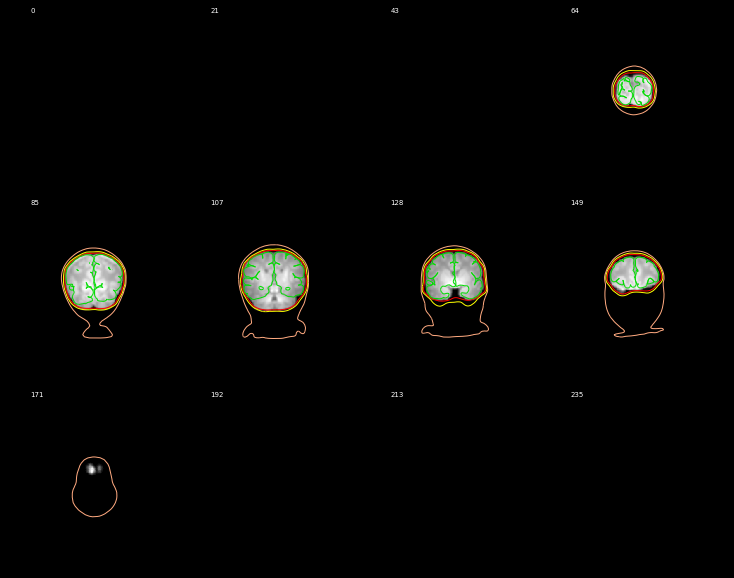

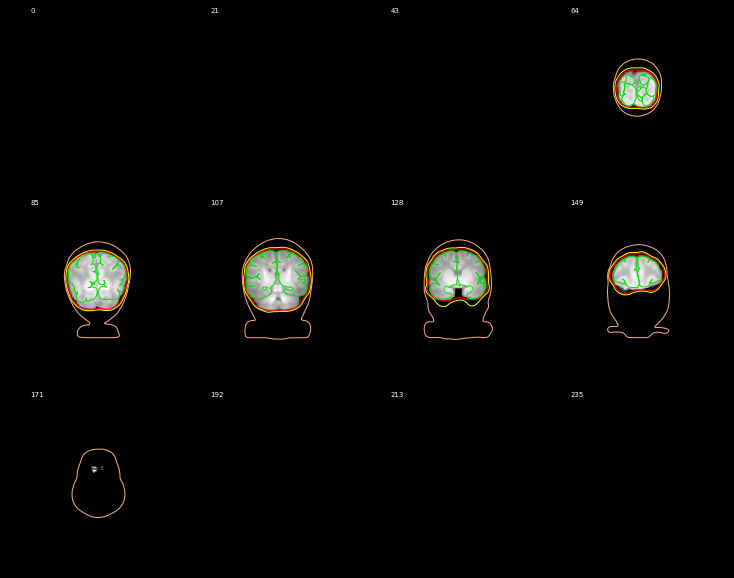

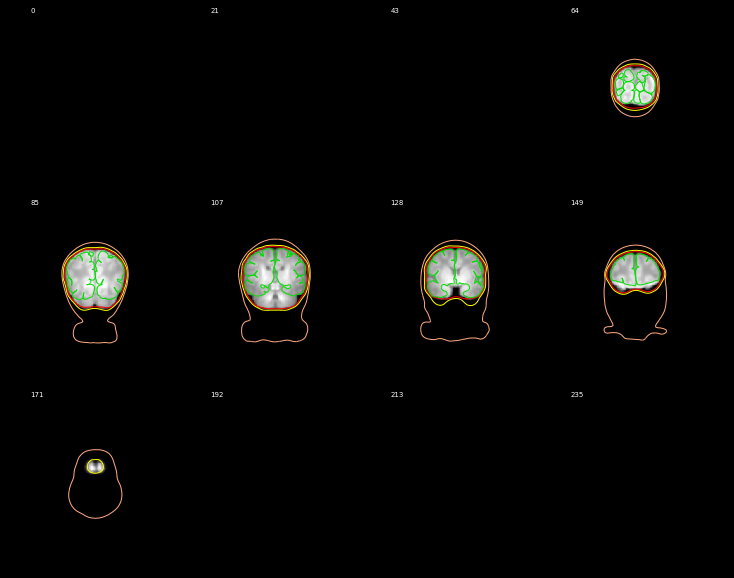

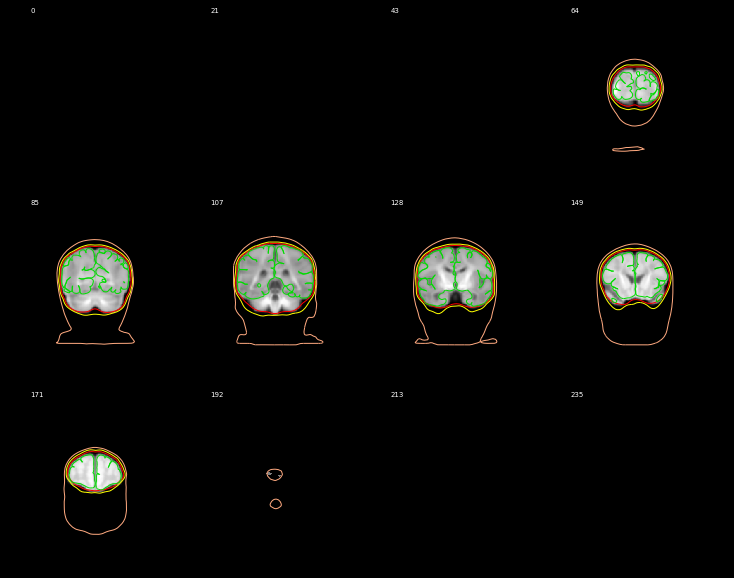

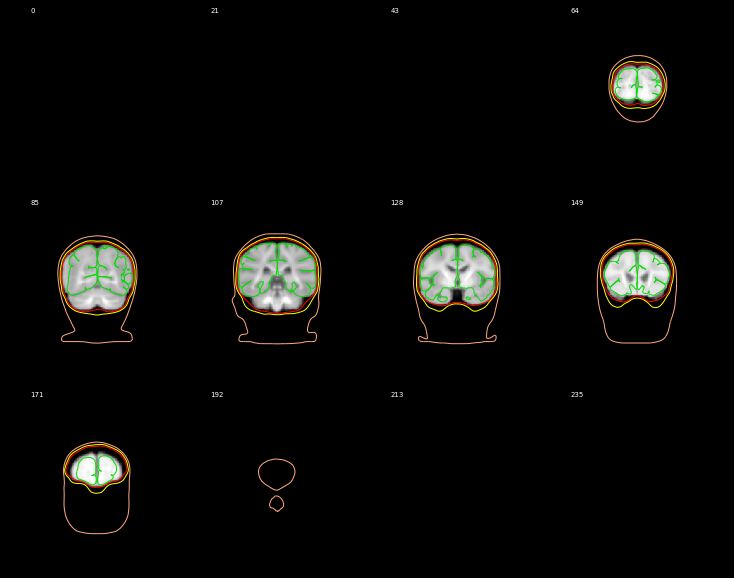

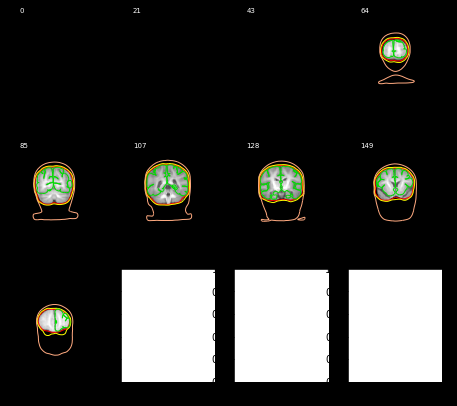

In [272]:
for subject in subjects:    
    print("Processing {}".format(subject))
    atlas = Atlas(subjects_dir=fs_subject_path, fs_subject=subject)
    fig = atlas.plot_bem(brain_surfaces='pial', orientation='coronal', show=False)
    fig.set_size_inches(10, 8, forward=True)        

# Verifying the meshes works for BEM modeling with MNE

In [45]:
for subject in tqdm(subjects):

    print("################################################################")          
    print("Processing {}".format(subject))
    try:
        check_bem(subject)
    except RuntimeError as e:
        print("################################################################")   
        print("################################################################")   
        print("################################################################")   
        print("Runtime error for {}".format(subject)) 
        print(e)
        raise 

################################################################
Processing ANTS2-0Weeks3T
Setting up the source space with the following parameters:

SUBJECTS_DIR = /usr/local/freesurfer/subjects
Subject      = ANTS2-0Weeks3T
Surface      = white
Octahedron subdivision grade 6

>>> 1. Creating the source space...

Doing the octahedral vertex picking...
Loading /usr/local/freesurfer/subjects/ANTS2-0Weeks3T/surf/lh.white...
Mapping lh ANTS2-0Weeks3T -> oct (6) ...
    Triangle neighbors and vertex normals...
Loading geometry from /usr/local/freesurfer/subjects/ANTS2-0Weeks3T/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 4098/39756 selected to source space (oct = 6)

Loading /usr/local/freesurfer/subjects/ANTS2-0Weeks3T/surf/rh.white...
Mapping rh ANTS2-0Weeks3T -> oct (6) ...
    Triangle neighbors and vertex normals...
Loading geometry from /usr/local/freesurfer/subjects/ANTS2-0Weeks3T/surf/rh.sphere...
Setting up the triangulation for the 

Source spaces are in MRI coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
    Skipping interior check for 9 sources that fit inside a sphere of radius   27.5 mm
    Skipping solid angle check for 0 points using Qhull
9 sources remaining after excluding the sources outside the surface and less than    5.0 mm inside.
Adjusting the neighborhood info.

Selecting voxels from Right-Putamen
24 sources remaining after excluding sources too far from VOI voxels
Source spaces are in MRI coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
    Skipping interior check for 24 sources that fit inside a sphere of radius   27.5 mm
    Skipping solid angle check for 0 points using Qhull
24 sources remaining after excluding the sources outside the surface and less than    5.0 mm inside.
Adjusting the neighborhood info.

Selecting voxels from Right-Thalamus
41 sources remaining after exc


Loading /usr/local/freesurfer/subjects/ANTS1-0Months3T/surf/rh.white...
Mapping rh ANTS1-0Months3T -> oct (6) ...
    Triangle neighbors and vertex normals...
Loading geometry from /usr/local/freesurfer/subjects/ANTS1-0Months3T/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
loaded rh.white 4098/36610 selected to source space (oct = 6)

You are now one step closer to computing the gain matrix
Creating the BEM geometry...
outer skin  CM is  -0.74  -3.01 -11.87 mm
outer skull CM is   0.51 -15.50  12.00 mm
inner skull CM is   0.50 -15.93  12.38 mm
Checking that outer skull surface is inside outer skin  surface...
Checking that inner skull surface is inside outer skull surface...
Checking distance between outer skin  and outer skull surfaces...
Minimum distance between the outer skin  and outer skull surfaces is approximately    1.2 mm
Checking distance between outer skull and inner skull surfaces...
Minimum distance between the outer skull and inner skull surf

    Skipping solid angle check for 0 points using Qhull
22 sources remaining after excluding the sources outside the surface and less than    5.0 mm inside.
Adjusting the neighborhood info.

Selecting voxels from Right-Thalamus
45 sources remaining after excluding sources too far from VOI voxels
Source spaces are in MRI coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
    Skipping interior check for 45 sources that fit inside a sphere of radius   28.0 mm
    Skipping solid angle check for 0 points using Qhull
45 sources remaining after excluding the sources outside the surface and less than    5.0 mm inside.
Adjusting the neighborhood info.

Reading /usr/local/freesurfer/subjects/ANTS1-0Months3T/mri/aseg.mgz...
Source space : MRI voxel -> MRI (surface RAS)
     0.005000  0.000000  0.000000     -50.00 mm
     0.000000  0.005000  0.000000     -75.00 mm
     0.000000  0.000000  0.005000     -35.00 mm
     0.000000  0.000000  0.


You are now one step closer to computing the gain matrix
Creating the BEM geometry...
outer skin  CM is   3.48  -5.88 -16.62 mm
outer skull CM is   3.87 -15.94  13.68 mm
inner skull CM is   3.96 -16.62  14.99 mm
Checking that outer skull surface is inside outer skin  surface...
Checking that inner skull surface is inside outer skull surface...
Checking distance between outer skin  and outer skull surfaces...
Minimum distance between the outer skin  and outer skull surfaces is approximately    1.0 mm
Checking distance between outer skull and inner skull surfaces...
Minimum distance between the outer skull and inner skull surfaces is approximately    1.1 mm
Surfaces passed the basic topology checks.
Complete.

Approximation method : Linear collocation

Three-layer model surfaces loaded.
Computing the linear collocation solution...
    Matrix coefficients...
        outer skin  (2561) -> outer skin  (2561) ...
        outer skin  (2561) -> outer skull (2562) ...
        outer skin  (2561

Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
    Skipping interior check for 47 sources that fit inside a sphere of radius   29.3 mm
    Skipping solid angle check for 0 points using Qhull
47 sources remaining after excluding the sources outside the surface and less than    5.0 mm inside.
Adjusting the neighborhood info.

Reading /usr/local/freesurfer/subjects/ANTS2-0Months3T/mri/aseg.mgz...
Source space : MRI voxel -> MRI (surface RAS)
     0.005000  0.000000  0.000000     -45.00 mm
     0.000000  0.005000  0.000000     -80.00 mm
     0.000000  0.000000  0.005000     -30.00 mm
     0.000000  0.000000  0.000000       1.00
MRI volume : MRI voxel -> MRI (surface RAS)
    -0.001000  0.000000  0.000000     128.00 mm
     0.000000  0.000000  0.001000    -128.00 mm
     0.000000 -0.001000  0.000000     128.00 mm
     0.000000  0.000000  0.000000       1.00
MRI volume : MRI (surface RAS) -> RAS (non-zero origin)
     1.000000  0.000000  0.0

Complete.

Approximation method : Linear collocation

Three-layer model surfaces loaded.
Computing the linear collocation solution...
    Matrix coefficients...
        outer skin  (2562) -> outer skin  (2562) ...
        outer skin  (2562) -> outer skull (2562) ...
        outer skin  (2562) -> inner skull (2562) ...
        outer skull (2562) -> outer skin  (2562) ...
        outer skull (2562) -> outer skull (2562) ...
        outer skull (2562) -> inner skull (2562) ...
        inner skull (2562) -> outer skin  (2562) ...
        inner skull (2562) -> outer skull (2562) ...
        inner skull (2562) -> inner skull (2562) ...
    Inverting the coefficient matrix...
IP approach required...
    Matrix coefficients (homog)...
        inner skull (2562) -> inner skull (2562) ...
    Inverting the coefficient matrix (homog)...
    Modify the original solution to incorporate IP approach...
        Combining...
        Scaling...
Solution ready.
BEM geometry computations complete.
BEM    

MRI volume : MRI voxel -> MRI (surface RAS)
    -0.001000  0.000000  0.000000     128.00 mm
     0.000000  0.000000  0.001000    -128.00 mm
     0.000000 -0.001000  0.000000     128.00 mm
     0.000000  0.000000  0.000000       1.00
MRI volume : MRI (surface RAS) -> RAS (non-zero origin)
     1.000000  0.000000  0.000000      -3.00 mm
     0.000000  1.000000  0.000000      -8.00 mm
     0.000000  0.000000  1.000000      -7.50 mm
     0.000000  0.000000  0.000000       1.00
Setting up interpolation for Left-Amygdala...
 24000/16777216 nonzero values [done]
Setting up interpolation for Left-Caudate...
 104000/16777216 nonzero values [done]
Setting up interpolation for Left-Hippocampus...
 68000/16777216 nonzero values [done]
Setting up interpolation for Left-Pallidum...
 61000/16777216 nonzero values [done]
Setting up interpolation for Left-Putamen...
 103000/16777216 nonzero values [done]
Setting up interpolation for Left-Thalamus...
 174000/16777216 nonzero values [done]
Setting up int

    Matrix coefficients...
        outer skin  (2562) -> outer skin  (2562) ...
        outer skin  (2562) -> outer skull (2562) ...
        outer skin  (2562) -> inner skull (2562) ...
        outer skull (2562) -> outer skin  (2562) ...
        outer skull (2562) -> outer skull (2562) ...
        outer skull (2562) -> inner skull (2562) ...
        inner skull (2562) -> outer skin  (2562) ...
        inner skull (2562) -> outer skull (2562) ...
        inner skull (2562) -> inner skull (2562) ...
    Inverting the coefficient matrix...
IP approach required...
    Matrix coefficients (homog)...
        inner skull (2562) -> inner skull (2562) ...
    Inverting the coefficient matrix (homog)...
    Modify the original solution to incorporate IP approach...
        Combining...
        Scaling...
Solution ready.
BEM geometry computations complete.
BEM              : <ConductorModel  |  BEM (3 layers)>
grid                  : 5.0 mm
mindist               : 5.0 mm
MRI volume            : 

     0.000000 -0.001000  0.000000     128.00 mm
     0.000000  0.000000  0.000000       1.00
MRI volume : MRI (surface RAS) -> RAS (non-zero origin)
     1.000000  0.000000  0.000000      -0.50 mm
     0.000000  1.000000  0.000000      -9.50 mm
     0.000000  0.000000  1.000000     -10.00 mm
     0.000000  0.000000  0.000000       1.00
Setting up interpolation for Left-Amygdala...
 29000/16777216 nonzero values [done]
Setting up interpolation for Left-Caudate...
 61000/16777216 nonzero values [done]
Setting up interpolation for Left-Hippocampus...
 56000/16777216 nonzero values [done]
Setting up interpolation for Left-Pallidum...
 51000/16777216 nonzero values [done]
Setting up interpolation for Left-Putamen...
 74000/16777216 nonzero values [done]
Setting up interpolation for Left-Thalamus...
 132000/16777216 nonzero values [done]
Setting up interpolation for Right-Amygdala...
 26000/16777216 nonzero values [done]
Setting up interpolation for Right-Caudate...
 66000/16777216 nonzero v

    Matrix coefficients (homog)...
        inner skull (2562) -> inner skull (2562) ...
    Inverting the coefficient matrix (homog)...
    Modify the original solution to incorporate IP approach...
        Combining...
        Scaling...
Solution ready.
BEM geometry computations complete.
BEM              : <ConductorModel  |  BEM (3 layers)>
grid                  : 5.0 mm
mindist               : 5.0 mm
MRI volume            : /usr/local/freesurfer/subjects/ANTS6-0Months3T/mri/aseg.mgz

Taking inner skull from <ConductorModel  |  BEM (3 layers)>
Surface CM = (   1.9   -7.0    8.5) mm
Surface fits inside a sphere with radius   72.5 mm
Surface extent:
    x =  -57.3 ...   60.6 mm
    y =  -75.1 ...   64.9 mm
    z =  -41.0 ...   69.5 mm
Grid extent:
    x =  -60.0 ...   65.0 mm
    y =  -80.0 ...   65.0 mm
    z =  -45.0 ...   70.0 mm
18720 sources before omitting any.
12015 sources after omitting infeasible sources not within 0.0 - 72.5 mm.

Selecting voxels from Left-Amygdala
12 sourc

 72000/16777216 nonzero values [done]
Setting up interpolation for Left-Pallidum...
 52000/16777216 nonzero values [done]
Setting up interpolation for Left-Putamen...
 82000/16777216 nonzero values [done]
Setting up interpolation for Left-Thalamus...
 122000/16777216 nonzero values [done]
Setting up interpolation for Right-Amygdala...
 32000/16777216 nonzero values [done]
Setting up interpolation for Right-Caudate...
 79000/16777216 nonzero values [done]
Setting up interpolation for Right-Hippocampus...
 72000/16777216 nonzero values [done]
Setting up interpolation for Right-Pallidum...
 44000/16777216 nonzero values [done]
Setting up interpolation for Right-Putamen...
 75000/16777216 nonzero values [done]
Setting up interpolation for Right-Thalamus...
 126000/16777216 nonzero values [done]
Overwriting existing file.
    Write a source space...
    [done]
    Write a source space...
    [done]
    Write a source space...
    [done]
    Write a source space...
    [done]
    Write a sou

    z =  -50.0 ...   75.0 mm
19604 sources before omitting any.
12443 sources after omitting infeasible sources not within 0.0 - 72.8 mm.

Selecting voxels from Left-Amygdala
9 sources remaining after excluding sources too far from VOI voxels
Source spaces are in MRI coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
    Skipping interior check for 8 sources that fit inside a sphere of radius   33.3 mm
    Skipping solid angle check for 0 points using Qhull
9 sources remaining after excluding the sources outside the surface and less than    5.0 mm inside.
Adjusting the neighborhood info.

Selecting voxels from Left-Caudate
19 sources remaining after excluding sources too far from VOI voxels
Source spaces are in MRI coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
    Skipping interior check for 8 sources that fit inside a sphere of radius   33.3 mm
    Skipping soli

    Write a source space...
    [done]
    Write a source space...
    [done]
    Write a source space...
    [done]
    Write a source space...
    [done]
    Write a source space...
    [done]
    Write a source space...
    [done]
    Write a source space...
    [done]
    Write a source space...
    [done]
    Write a source space...
    [done]
    Write a source space...
    [done]
    Write a source space...
    [done]
    Write a source space...
    [done]
    Write a source space...
    [done]
    Write a source space...
    [done]
    14 source spaces written
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    Reading a s

24 sources remaining after excluding sources too far from VOI voxels
Source spaces are in MRI coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
    Skipping interior check for 20 sources that fit inside a sphere of radius   34.5 mm
    Skipping solid angle check for 0 points using Qhull
24 sources remaining after excluding the sources outside the surface and less than    5.0 mm inside.
Adjusting the neighborhood info.

Selecting voxels from Left-Hippocampus
20 sources remaining after excluding sources too far from VOI voxels
Source spaces are in MRI coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
    Skipping interior check for 20 sources that fit inside a sphere of radius   34.5 mm
    Skipping solid angle check for 0 points using Qhull
20 sources remaining after excluding the sources outside the surface and less than    5.0 mm inside.
Adjusting the neighborhood 

    [done]
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    14 source spaces read
Reading labels from parcellation...
   read 34 labels from /usr/local/freesurfer/subjects/ANTS9-0Months3T/label/lh.aparc.annot
   read 34 labels from /usr/local/freesurfer/subjects/ANTS9-0Months3T/label/rh.aparc.annot
bankssts-lh
bankssts-rh
caudalanteriorcingulate-lh
caudalanteriorcingulate-rh
Surprising label structure. Trying to repair triangles.
caudalmiddlefrontal-lh
Surprising label structure. Trying to repair triangles.
caudalmiddlefrontal-rh
cuneus-lh
cuneus-rh
Surprising label structure. Trying to 

Adjusting the neighborhood info.

Selecting voxels from Left-Hippocampus
21 sources remaining after excluding sources too far from VOI voxels
Source spaces are in MRI coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
    Skipping interior check for 16 sources that fit inside a sphere of radius   28.9 mm
    Skipping solid angle check for 0 points using Qhull
21 sources remaining after excluding the sources outside the surface and less than    5.0 mm inside.
Adjusting the neighborhood info.

Selecting voxels from Left-Pallidum
9 sources remaining after excluding sources too far from VOI voxels
Source spaces are in MRI coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
    Skipping interior check for 9 sources that fit inside a sphere of radius   28.9 mm
    Skipping solid angle check for 0 points using Qhull
9 sources remaining after excluding the sources outside the 

    [done]
    14 source spaces read
Reading labels from parcellation...
   read 34 labels from /usr/local/freesurfer/subjects/ANTS10-5Months3T/label/lh.aparc.annot
   read 34 labels from /usr/local/freesurfer/subjects/ANTS10-5Months3T/label/rh.aparc.annot
bankssts-lh
bankssts-rh
Surprising label structure. Trying to repair triangles.
caudalanteriorcingulate-lh
Surprising label structure. Trying to repair triangles.
caudalanteriorcingulate-rh
Surprising label structure. Trying to repair triangles.
caudalmiddlefrontal-lh
caudalmiddlefrontal-rh
cuneus-lh
Surprising label structure. Trying to repair triangles.
cuneus-rh
Surprising label structure. Trying to repair triangles.
entorhinal-lh
entorhinal-rh
Surprising label structure. Trying to repair triangles.
frontalpole-lh
frontalpole-rh
fusiform-lh
fusiform-rh
inferiorparietal-lh
inferiorparietal-rh
inferiortemporal-lh
inferiortemporal-rh
insula-lh
Surprising label structure. Trying to repair triangles.
insula-rh
Surprising label structur

Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
    Skipping interior check for 10 sources that fit inside a sphere of radius   32.4 mm
    Skipping solid angle check for 0 points using Qhull
10 sources remaining after excluding the sources outside the surface and less than    5.0 mm inside.
Adjusting the neighborhood info.

Selecting voxels from Left-Putamen
34 sources remaining after excluding sources too far from VOI voxels
Source spaces are in MRI coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
    Skipping interior check for 26 sources that fit inside a sphere of radius   32.4 mm
    Skipping solid angle check for 0 points using Qhull
34 sources remaining after excluding the sources outside the surface and less than    5.0 mm inside.
Adjusting the neighborhood info.

Selecting voxels from Left-Thalamus
52 sources remaining after excluding sources too far from VOI voxels

inferiortemporal-lh
inferiortemporal-rh
insula-lh
Surprising label structure. Trying to repair triangles.
insula-rh
Surprising label structure. Trying to repair triangles.
isthmuscingulate-lh
isthmuscingulate-rh
Surprising label structure. Trying to repair triangles.
lateraloccipital-lh
lateraloccipital-rh
lateralorbitofrontal-lh
lateralorbitofrontal-rh
Surprising label structure. Trying to repair triangles.
lingual-lh
lingual-rh
medialorbitofrontal-lh
medialorbitofrontal-rh
Surprising label structure. Trying to repair triangles.
middletemporal-lh
middletemporal-rh
paracentral-lh
paracentral-rh
parahippocampal-lh
Surprising label structure. Trying to repair triangles.
parahippocampal-rh
Surprising label structure. Trying to repair triangles.
parsopercularis-lh
parsopercularis-rh
parsorbitalis-lh
parsorbitalis-rh
parstriangularis-lh
parstriangularis-rh
pericalcarine-lh
pericalcarine-rh
postcentral-lh
Surprising label structure. Trying to repair triangles.
postcentral-rh
posteriorcingula

    Skipping solid angle check for 0 points using Qhull
44 sources remaining after excluding the sources outside the surface and less than    5.0 mm inside.
Adjusting the neighborhood info.

Selecting voxels from Left-Thalamus
59 sources remaining after excluding sources too far from VOI voxels
Source spaces are in MRI coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
    Skipping interior check for 59 sources that fit inside a sphere of radius   38.3 mm
    Skipping solid angle check for 0 points using Qhull
59 sources remaining after excluding the sources outside the surface and less than    5.0 mm inside.
Adjusting the neighborhood info.

Selecting voxels from Right-Amygdala
11 sources remaining after excluding sources too far from VOI voxels
Source spaces are in MRI coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
    Skipping interior check for 11 sources that

lingual-lh
lingual-rh
medialorbitofrontal-lh
medialorbitofrontal-rh
middletemporal-lh
middletemporal-rh
paracentral-lh
paracentral-rh
parahippocampal-lh
Surprising label structure. Trying to repair triangles.
parahippocampal-rh
Surprising label structure. Trying to repair triangles.
parsopercularis-lh
parsopercularis-rh
parsorbitalis-lh
parsorbitalis-rh
parstriangularis-lh
Surprising label structure. Trying to repair triangles.
parstriangularis-rh
pericalcarine-lh
pericalcarine-rh
postcentral-lh
Surprising label structure. Trying to repair triangles.
postcentral-rh
posteriorcingulate-lh
posteriorcingulate-rh
Surprising label structure. Trying to repair triangles.
precentral-lh
precentral-rh
Surprising label structure. Trying to repair triangles.
precuneus-lh
precuneus-rh
Surprising label structure. Trying to repair triangles.
rostralanteriorcingulate-lh
rostralanteriorcingulate-rh
Surprising label structure. Trying to repair triangles.
rostralmiddlefrontal-lh
Surprising label structure

    Skipping interior check for 50 sources that fit inside a sphere of radius   27.6 mm
    Skipping solid angle check for 0 points using Qhull
50 sources remaining after excluding the sources outside the surface and less than    5.0 mm inside.
Adjusting the neighborhood info.

Selecting voxels from Right-Amygdala
11 sources remaining after excluding sources too far from VOI voxels
Source spaces are in MRI coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
    Skipping interior check for 5 sources that fit inside a sphere of radius   27.6 mm
    Skipping solid angle check for 0 points using Qhull
11 sources remaining after excluding the sources outside the surface and less than    5.0 mm inside.
Adjusting the neighborhood info.

Selecting voxels from Right-Caudate
25 sources remaining after excluding sources too far from VOI voxels
Source spaces are in MRI coordinates.
Checking that the sources are inside the surface and at le

parahippocampal-rh
Surprising label structure. Trying to repair triangles.
parsopercularis-lh
parsopercularis-rh
parsorbitalis-lh
parsorbitalis-rh
parstriangularis-lh
parstriangularis-rh
pericalcarine-lh
pericalcarine-rh
postcentral-lh
postcentral-rh
posteriorcingulate-lh
Surprising label structure. Trying to repair triangles.
posteriorcingulate-rh
precentral-lh
Surprising label structure. Trying to repair triangles.
precentral-rh
Surprising label structure. Trying to repair triangles.
precuneus-lh
Surprising label structure. Trying to repair triangles.
precuneus-rh
Surprising label structure. Trying to repair triangles.
rostralanteriorcingulate-lh
rostralanteriorcingulate-rh
rostralmiddlefrontal-lh
rostralmiddlefrontal-rh
superiorfrontal-lh
superiorfrontal-rh
superiorparietal-lh
superiorparietal-rh
superiortemporal-lh
Surprising label structure. Trying to repair triangles.
superiortemporal-rh
Surprising label structure. Trying to repair triangles.
supramarginal-lh
supramarginal-rh
Sur


Selecting voxels from Right-Amygdala
11 sources remaining after excluding sources too far from VOI voxels
Source spaces are in MRI coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
    Skipping interior check for 9 sources that fit inside a sphere of radius   33.3 mm
    Skipping solid angle check for 0 points using Qhull
11 sources remaining after excluding the sources outside the surface and less than    5.0 mm inside.
Adjusting the neighborhood info.

Selecting voxels from Right-Caudate
35 sources remaining after excluding sources too far from VOI voxels
Source spaces are in MRI coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
    Skipping interior check for 17 sources that fit inside a sphere of radius   33.3 mm
    Skipping solid angle check for 0 points using Qhull
35 sources remaining after excluding the sources outside the surface and less than    5.0 mm i

precuneus-lh
precuneus-rh
Surprising label structure. Trying to repair triangles.
rostralanteriorcingulate-lh
Surprising label structure. Trying to repair triangles.
rostralanteriorcingulate-rh
Surprising label structure. Trying to repair triangles.
rostralmiddlefrontal-lh
Surprising label structure. Trying to repair triangles.
rostralmiddlefrontal-rh
superiorfrontal-lh
superiorfrontal-rh
superiorparietal-lh
superiorparietal-rh
superiortemporal-lh
Surprising label structure. Trying to repair triangles.
superiortemporal-rh
supramarginal-lh
supramarginal-rh
temporalpole-lh
temporalpole-rh
transversetemporal-lh
Surprising label structure. Trying to repair triangles.
transversetemporal-rh
left_hemi
right_hemi
Amygdala-lh
Caudate-lh
Hippocampus-lh
Pallidum-lh
Putamen-lh
Thalamus-lh
Amygdala-rh
Caudate-rh
Hippocampus-rh
Pallidum-rh
Putamen-rh
Thalamus-rh
Reading labels from parcellation...
   read 34 labels from /usr/local/freesurfer/subjects/ANTS2-0Years3T/label/lh.aparc.annot
   read 34 la

# Loading fiducials 

In [12]:
fiducial_labels = ["AC", "PC", "Nz", "Iz", "LPA", "RPA", "LMA", 
                   "RMA", "LEOG", "REOG", "LEMG", "REMG", 
                   "mid_EOG_nose", "Cz"]

In [124]:
montages = {}
fiducials = {}
head_fiducials = []
brain_fiducials = []
for subject in subjects:
    age_str = parse("ANTS{}", subject).fixed[0]
    path = get_source_file(subject.replace("ANTS", "AVG"), "Sources/Electrodes", 
                            "fiducial_electrodes", extension="txt")
    print(path)    
    
    with path.open('r') as tsv_file:
        tsv_file.readline()
        reader = csv.reader(tsv_file, delimiter=' ', lineterminator='\n')
        fiducials[age_str] = {label: np.array([float(x), float(y), float(z)]) # - delta 
                                  for label, (_, x, y, z) in zip(fiducial_labels, reader)}              
        
    volume_info = read_geometry(fs_subject_path / subject / "bem" / "outer_skull.surf", 
                                                       read_metadata=True)[2] 

    # The fiducials are defined with respect to AC, AC being at [0, 0, 0] in the Talairach/MNI system
    fiducials[age_str]["AC"] = np.array([0, 0, 0])
    
    delta = volume_info["cras"] #/1000      
    delta = np.zeros(3)

    #tmp = np.vstack((pd.DataFrame(fiducials[age_str]).values*1000 - delta.reshape((3, 1)), np.ones((1, 14))))/1000
    tmp = pd.DataFrame(fiducials[age_str]).T #.values
    #tmp = pd.DataFrame(tmp).T
    tmp.index = list(fiducials[age_str].keys())

    head_fiducials.append(np.concatenate((tmp.loc["LPA"], 
                                          tmp.loc["Nz"], 
                                          tmp.loc["RPA"])))
    brain_fiducials.append(np.concatenate((tmp.loc["AC"], 
                                           tmp.loc["PC"])))

/media/christian/ElementsSE/Richards/Infants/Sources/Electrodes/AVG2-0Weeks3T_fiducial_electrodes.txt
/media/christian/ElementsSE/Richards/Infants/Sources/Electrodes/AVG1-0Months3T_fiducial_electrodes.txt
/media/christian/ElementsSE/Richards/Infants/Sources/Electrodes/AVG2-0Months3T_fiducial_electrodes.txt
/media/christian/ElementsSE/Richards/Infants/Sources/Electrodes/AVG3-0Months3T_fiducial_electrodes.txt
/media/christian/ElementsSE/Richards/Infants/Sources/Electrodes/AVG4-5Months3T_fiducial_electrodes.txt
/media/christian/ElementsSE/Richards/Infants/Sources/Electrodes/AVG6-0Months3T_fiducial_electrodes.txt
/media/christian/ElementsSE/Richards/Infants/Sources/Electrodes/AVG7-5Months3T_fiducial_electrodes.txt
/media/christian/ElementsSE/Richards/Infants/Sources/Electrodes/AVG9-0Months3T_fiducial_electrodes.txt
/media/christian/ElementsSE/Richards/Infants/Sources/Electrodes/AVG10-5Months3T_fiducial_electrodes.txt
/media/christian/ElementsSE/Richards/Infants/Sources/Electrodes/AVG12-0Mo

In [117]:
tmp = pd.DataFrame(np.stack(head_fiducials))
tmp.index = list(ages.values())
tmp.columns = ["LPA_x", "LPA_y", "LPA_z", "NAS_x", "NAS_y", "NAS_z", "RPA_x", "RPA_y", "RPA_z"]
tmp*1000

LPA_x  LPA_y  LPA_z  NAS_x  NAS_y  NAS_z  RPA_x  RPA_y  RPA_z
2 weeks      -41.0    5.0  -34.0   -1.0   48.0    6.0   39.0    4.0  -33.0
1 month      -41.0    4.0  -36.0   -1.0   49.0   -1.0   41.0    3.0  -34.0
2 months     -44.0    3.0  -33.0    0.0   49.0    4.0   43.0    0.0  -31.0
3 months     -53.0   -7.0  -43.0    0.0   54.0  -16.0   53.0   -9.0  -41.0
4.5 months   -54.0   -9.0  -41.0   -1.0   57.0  -15.0   53.0   -8.0  -42.0
6 months     -53.0  -13.0  -44.0    3.0   54.0  -23.0   55.0  -15.0  -43.0
7.5 months   -56.0  -12.0  -43.0   -2.0   60.0  -15.0   55.0   -8.0  -44.0
9 months     -57.0  -12.0  -43.0   -1.0   57.0  -19.0   53.0  -11.0  -45.0
10.5 months  -60.0  -18.0  -41.0   -1.0   60.0  -23.0   56.0  -15.0  -47.0
12 months    -58.0   -6.0  -46.0    1.0   63.0  -16.0   57.0   -8.0  -48.0
15 months    -59.0   -9.0  -48.0    1.0   64.0  -16.0   58.0  -12.0  -47.0
18 months    -61.0  -16.0  -44.0   -2.0   64.0  -26.0   58.0  -14.0  -44.0
24 months    -61.0  -12.0  -45.0   -1.0   68.0  -20.0   59.0  -14.0  -44.0

In [118]:
tmp = pd.DataFrame(np.stack(brain_fiducials))
tmp.index = list(ages.values())
tmp.columns = ["AC_x", "AC_y", "AC_z", "PC_x", "PC_y", "PC_z"]
tmp*1000

AC_x  AC_y  AC_z  PC_x  PC_y  PC_z
2 weeks       0.0   0.0   0.0  -1.0 -18.0  -3.0
1 month       0.0   0.0   0.0  -1.0 -18.0  -4.0
2 months      0.0   0.0   0.0  -1.0 -20.0  -3.0
3 months      0.0   0.0   0.0  -1.0 -20.0   0.0
4.5 months    0.0   0.0   0.0  -1.0 -21.0   1.0
6 months      0.0   0.0   0.0  -1.0 -22.0   1.0
7.5 months    0.0   0.0   0.0  -1.0 -21.0   1.0
9 months      0.0   0.0   0.0  -1.0 -22.0   1.0
10.5 months   0.0   0.0   0.0  -1.0 -23.0   1.0
12 months     0.0   0.0   0.0  -1.0 -21.0  -3.0
15 months     0.0   0.0   0.0  -1.0 -24.0  -1.0
18 months     0.0   0.0   0.0  -2.0 -24.0   1.0
24 months     0.0   0.0   0.0  -1.0 -24.0   0.0

In [134]:
# The IH point is not defined in the MND, so 
# we found it manually in Brainstorm
ih = {"2-0Weeks3T": [1.5, -29.5, 32.5],
      "1-0Months3T": [2.5, -20.0, 35.5],
      "2-0Months3T": [1.0, -36.0, 32.5], 
      "3-0Months3T": [10.0, -24.0, 45.5], 
      "4-5Months3T": [-0.5, -36.5, 49.9], 
      "6-0Months3T": [4.0, -33.5, 45.0], 
      "7-5Months3T": [1.0, -31.0, 40.5], 
      "9-0Months3T": [0.5, -35.0, 42.0], 
      "10-5Months3T": [0.0, -26.5, 52.50], 
      "12-0Months3T": [0.5, -35.0, 47.0], 
      "15-0Months3T": [1.0, -40.0, 49.5], 
      "18-0Months3T": [2.0, -38.5, 53.0], 
      "2-0Years3T": [2.0, -42.5, 50.5]}     



# Saving fiducials for Brainstorm

In [135]:
import numpy, scipy.io
mdict = {}
for subject in fiducials:
    fiducials[subject]["IH"] = np.array(ih[subject])       
    mdict["s" + subject.replace("-", "_")] = np.array([fiducials[subject][label]*1000 
                                                 for label in ['Nz', 'LPA', 'RPA', 'AC', 'PC', 'IH']])

scipy.io.savemat('/home/christian/brainstorm_db/fiducials.mat', mdict=mdict)    

# Saving montages

In [127]:
def correct_positions(subject, ch_pos, verbose=False):
    path = str(fs_subject_path / subject / "bem" / "outer_skin.surf")
    vertices, faces, volume_info_ = read_geometry(path, read_metadata=True)
    mesh = trimesh.Trimesh(vertices=vertices, faces=faces)

    pos = np.array(list(ch_pos.values()))*1000

    new_pos, dist = trimesh.proximity.closest_point(mesh, pos)[:2]
    new_pos /= 1000.0

    if verbose:
        print(subject, dist.mean(), dist.std())
    return {key:pos for key, pos in zip(ch_pos.keys(), new_pos)}


montages = {}
montage_strs = ["HGSN128", "10-5", "10-10", "10-20"]
for montage_str in montage_strs:
    montages[montage_str] = {}
    for subject in subjects:
        path = get_source_file(subject.replace("ANTS", "AVG"), "Sources/Electrodes", 
                                "{}_electrodes".format(montage_str), extension="txt", missing=None)    
        age_str = parse("ANTS{}", subject).fixed[0]
        
        with path.open('r') as tsv_file:
            tsv_file.readline()
            reader = csv.reader(tsv_file, delimiter=' ', lineterminator='\n')
            # Positions in this files are in RAS

            volume_info = read_geometry(fs_subject_path / subject / "bem" / "outer_skull.surf", 
                                                               read_metadata=True)[2] 

            delta = volume_info["cras"] #/1000        

            #ch_pos = {"E{}".format(ch_name):(np.hstack([np.array([[float(x), float(y), float(z)]])*1000 - delta, [[1]]]).T).T[0, :3]/1000 
            ch_pos = {"E{}".format(ch_name):(np.array([[float(x), float(y), float(z)]]) - delta/1000)[0, :3] 
                      for ch_name, x, y, z in reader if ch_name != "name"}
            ch_pos = correct_positions(subject, ch_pos, verbose=True)

            tmp = np.vstack((pd.DataFrame(fiducials[age_str]).values*1000 - delta.reshape((3, 1)), np.ones((1, 14))))
            brain_fiducials = pd.DataFrame(tmp.T[:, :3]/1000)
            brain_fiducials.index = list(fiducials[age_str].keys())

            ch_pos["E129"] = brain_fiducials.loc["Cz"].values # Reference channel        

            
        corrected_brain_fiducials = {label:brain_fiducials.loc[label].values for label in brain_fiducials.index}
        corrected_brain_fiducials = correct_positions(subject, corrected_brain_fiducials)
        corrected_brain_fiducials["AC"] = brain_fiducials.loc["AC"].values
        corrected_brain_fiducials["PC"] = brain_fiducials.loc["PC"].values   
        brain_fiducials.loc[list(corrected_brain_fiducials.keys())] = np.array(list(corrected_brain_fiducials.values()))
        hsp = np.array(list(brain_fiducials.drop(["Nz", "LPA", "RPA"]).values))
        montage = mne.channels.make_dig_montage(ch_pos=ch_pos,  #  These fiducials are in RAS space
                                                nasion=brain_fiducials.loc["Nz"].values,
                                                lpa=brain_fiducials.loc["LPA"].values,
                                                rpa=brain_fiducials.loc["RPA"].values,
                                                hsp=hsp,
                                                coord_frame="head")    

        montage_fname = fs_subject_path / subject / "{}-montage.fif".format(montage_str)
        montage.save(montage_fname)
        montages[montage_str][subject] = montage

ANTS2-0Weeks3T 1.6629396310743214 1.0800639737753912
ANTS1-0Months3T 1.4229776599513182 0.8176069366243952
ANTS2-0Months3T 1.4479328046893065 0.988329420912219
ANTS3-0Months3T 1.1460178824966647 0.7428759984892969
ANTS4-5Months3T 1.320115593798395 0.8643460685159464
ANTS6-0Months3T 1.170120863980761 1.0332179796848047
ANTS7-5Months3T 1.2800679615232906 0.7870801638198015
ANTS9-0Months3T 1.510123487918975 0.9392037685361991
ANTS10-5Months3T 0.952150579738261 0.6486580743561816
ANTS12-0Months3T 1.2717182864893144 0.7139702111081343
ANTS15-0Months3T 1.3045904638190216 0.9382924739285521
ANTS18-0Months3T 1.4507162467029993 0.8734302882408549
ANTS2-0Years3T 1.2779260648344322 0.8803288448591443
ANTS2-0Weeks3T 3.1480254350305206 2.0855130179654853
ANTS1-0Months3T 3.7063467204570495 1.4526682973439875
ANTS2-0Months3T 3.109528416817212 1.6986974031287998
ANTS3-0Months3T 3.7732282599498936 1.6369546531635946
ANTS4-5Months3T 3.2783561669086385 1.6544628425351586
ANTS6-0Months3T 3.665589655133446

In [128]:
def sphere_mesh(pos, radius, color=None):
    mesh = trimesh.creation.icosphere(radius=radius, color=color)
    mesh.vertices += pos
    return mesh

for montage_str in ["10-5", "10-10", "10-20", "HGSN128"]:
    for subject in subjects:
        path = fs_subject_path / subject / "{}-montage.fif".format(montage_str) 

        montage = mne.channels.read_dig_fif(path)
        
        montage_meshes = []
        for dig in montage.dig:
            label = str(dig).split("|")[1].split(":")[0].strip()
            pos = dig["r"]*1000
            if "EEG" in label:
                montage_meshes.append(sphere_mesh(pos, 2.5))
            
        montage_mesh = trimesh.util.concatenate(montage_meshes)
        
        path_out = fs_subject_path / subject / "surf" / path.with_suffix(".obj").name
        with path_out.open('w') as file_obj:
            file_obj.write(trimesh.exchange.obj.export_obj(montage_mesh))
            
            
        path_white = fs_subject_path / subject / "surf" / "lh.white"
        volume_info = read_geometry(path_white, read_metadata=True)[2]            
            
        path_out = fs_subject_path / subject / "surf" / path.with_suffix(".surf").name
        write_geometry(str(path_out), montage_mesh.vertices, montage_mesh.faces, 
                       volume_info=volume_info)
        
        if montage_str == "HGSN128":
            montage_meshes = []
            for dig in montage.dig:
                label = str(dig).split("|")[1].split(":")[0].strip()
                pos = dig["r"]*1000
                if not "EEG" in label:
                    montage_meshes.append(sphere_mesh(pos, 2.5))

            montage_mesh = trimesh.util.concatenate(montage_meshes)

            path_out = fs_subject_path / subject / "surf" / "fiducials.obj"
            with path_out.open('w') as file_obj:
                file_obj.write(trimesh.exchange.obj.export_obj(montage_mesh))

            path_white = fs_subject_path / subject / "surf" / "lh.white"
            volume_info = read_geometry(path_white, read_metadata=True)[2]            

            path_out = fs_subject_path / subject / "surf" / "fiducials.surf"
            write_geometry(str(path_out), montage_mesh.vertices, montage_mesh.faces, 
                           volume_info=volume_info)        

In [ ]:
# Tend to crash notebooks. Running it separately from ipython.

import os
import mne
from pathlib import Path
from mayavi import mlab
from copy import deepcopy
from eegip import DatasetMng
from mne.viz import plot_alignment, set_3d_view

os.environ["ETS_TOOLKIT"] = "wx"
mlab.init_notebook(backend="png")
fs_subject_path = Path("/usr/local/freesurfer/subjects/")

os.chdir("/home/christian/synchedin/infants_atlas_modeling/infant_template_paper")

dataset_mng = DatasetMng(config={}, dataset_name="eegip_london")
recording = list(dataset_mng.dataset.recordings.values())[0]

chan_name_map = {'Fp2': 'E9', 'Fz': 'E11', 'NAS': 'E17', 'Fp1': 'E22', 'F3': 'E24', 'F7': 'E33',
                 'C3': 'E36', 'T7': 'E45', 'P3': 'E52', 'LM': 'E57', 'P7': 'E58', 'Pz': 'E62',
                 'O1': 'E70', 'Oz': 'E75', 'O2': 'E83', 'P4': 'E92', 'P8': 'E96', 'RM': 'E100',
                 'C4': 'E104', 'T8': 'E108', 'F8': 'E122', 'F4': 'E124', 'Cz': 'E129'}

subjects = ["ANTS2-0Weeks3T", "ANTS1-0Months3T", "ANTS2-0Months3T", "ANTS3-0Months3T", 
            "ANTS4-5Months3T", "ANTS6-0Months3T", "ANTS7-5Months3T", "ANTS9-0Months3T", 
            "ANTS10-5Months3T", "ANTS12-0Months3T", "ANTS15-0Months3T", "ANTS18-0Months3T", 
            "ANTS2-0Years3T"]

def save_images(subject_, montage_fname_, raw):
    montage = mne.channels.read_dig_fif(montage_fname_)
    raw.rename_channels(chan_name_map)
    raw.rename_channels({"E{}".format(no):"EEG{:03}".format(no) for no in range(1, 130)})
    raw = raw.set_channel_types({name: "eeg" for name in raw.copy().pick("eog").ch_names})
    raw.set_montage(montage)
    
    fig_ = plot_alignment(raw.info, eeg='projected', show_axes=False, 
                          trans=None, surfaces="head", coord_frame='head', 
                          subject=subject_)    
    

    set_3d_view(figure=fig_, azimuth=135, elevation=80)
    fig_.scene.save(subject_ + "_1.png")

    set_3d_view(figure=fig_, azimuth=45, elevation=80)
    fig_.scene.save(subject_ + "_2.png")

    set_3d_view(figure=fig_, azimuth=270, elevation=80)
    fig_.scene.save(subject_ + "_3.png")

    
    fig_ = plot_alignment(raw.info, eeg=['original', 'projected'], show_axes=True, 
                          trans=None, surfaces="head", coord_frame='head', dig=True, 
                          subject=subject_)    
    

    set_3d_view(figure=fig_, azimuth=135, elevation=80)
    fig_.scene.save(subject_ + "_clear_1.png")

    set_3d_view(figure=fig_, azimuth=45, elevation=80)
    fig_.scene.save(subject_ + "_clear_2.png")

    set_3d_view(figure=fig_, azimuth=270, elevation=80)
    fig_.scene.save(subject_ + "_clear_3.png")

    
for subject in subjects:
    print("Processing ", subject, "...")
    montage_fname = fs_subject_path / subject / "GSN-HydroCel-129-montage.fif"
    save_images(subject, str(montage_fname), deepcopy(recording.preprocessed_raw))    

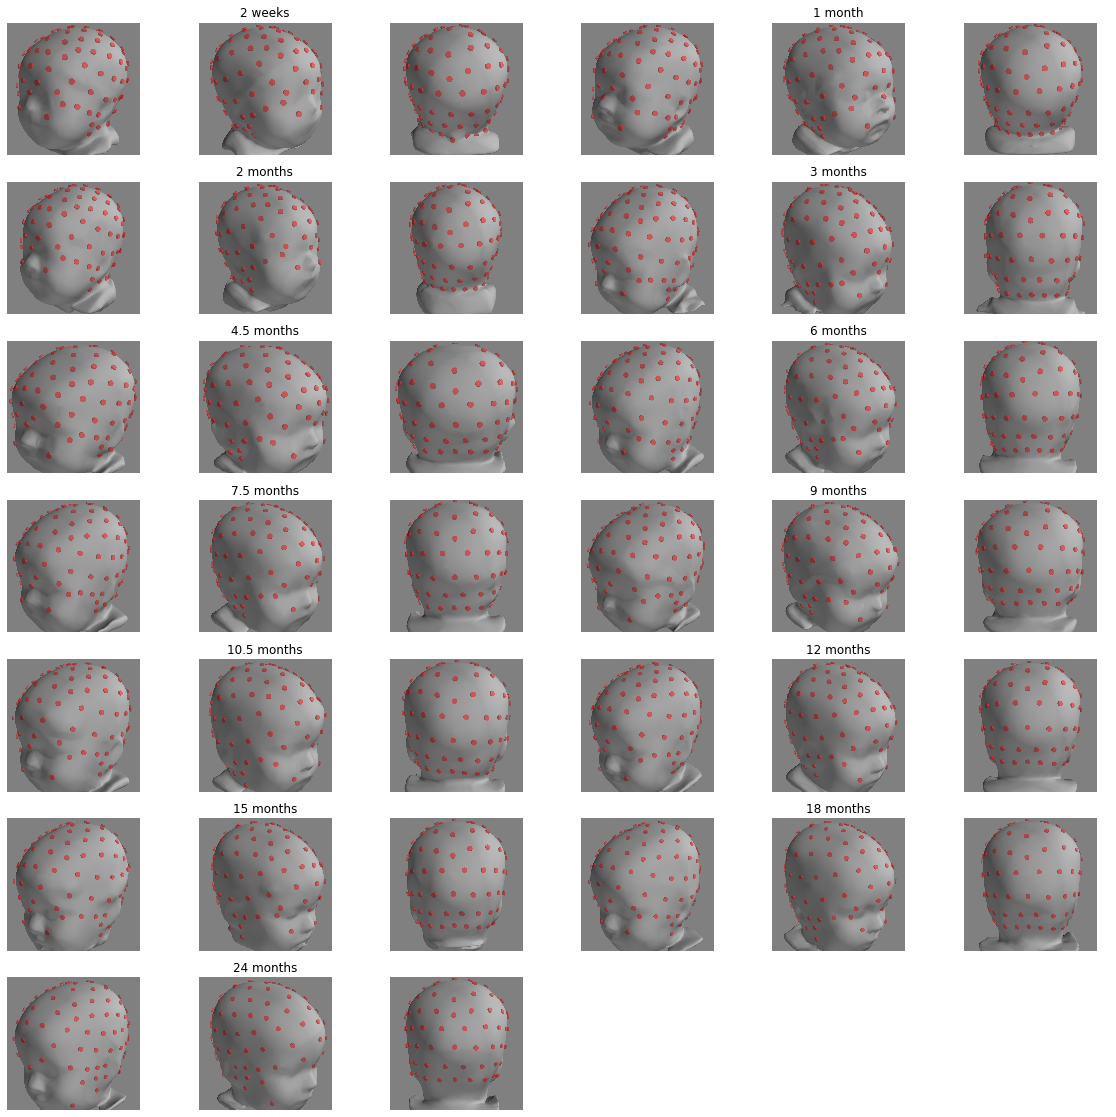

In [336]:
fig, axes = plt.subplots(7, 6, figsize=(20, 20))

def ax_gen(): 
    for ax_ in axes.ravel(): yield ax_

gen = ax_gen()      
for subject in ages:
    for i in [1, 2, 3]:
        ax = next(gen)
        img = mpimg.imread("{}_{}.png".format(subject, i))
        ax.imshow(img)
        ax.axis("off")        
        if i == 2:
            ax.set_title(ages[subject])

for _ in range(3):
    ax = next(gen)
    ax.axis("off")            
            
fig.savefig("sensor_coregistration.png")

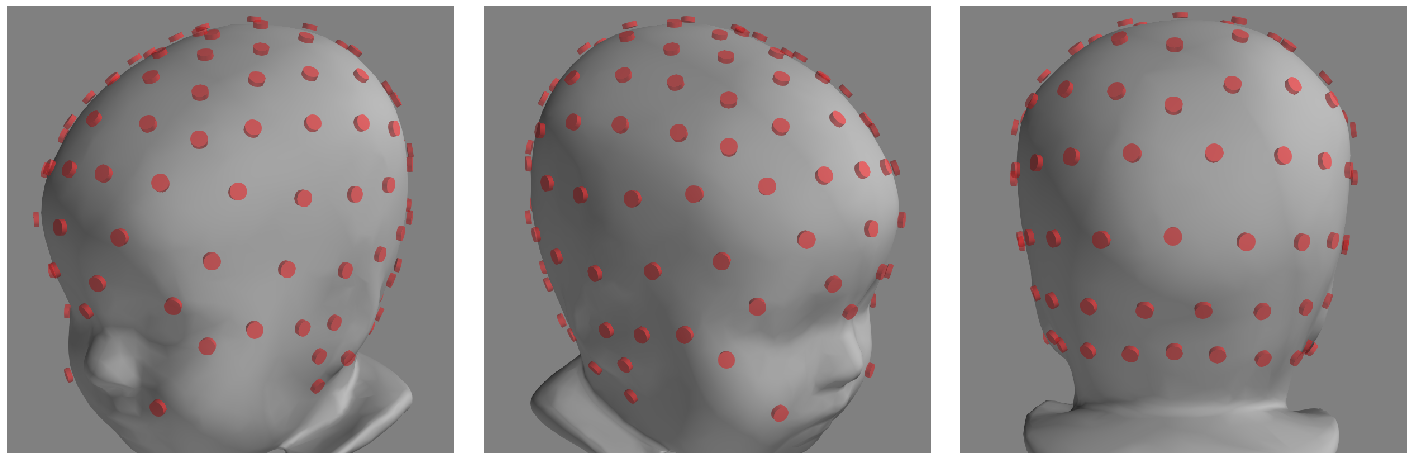

In [337]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6.5))

def ax_gen(): 
    for ax in axes.ravel(): yield ax

gen = ax_gen()      
subject = 'ANTS12-0Months3T_brain'
for i in [1, 2, 3]:
    ax = next(gen)
    img = mpimg.imread("{}_{}.png".format(subject, i))
    ax.imshow(img)
    ax.axis("off")        

fig.tight_layout()
fig.savefig("sensor_coregistration_example_12mo.png")

# Making obj meshes from freesurfer brain (pial, wm) surfaces for visualization in blender

In [341]:
for subject in subjects:
    for file_name in ["lh.white", "rh.white", "lh.pial", "rh.pial"]:   
        path_fs = fs_subject_path / subject / "surf" / file_name

        try:
            coords, faces = read_geometry(path_fs)
        except:
            raise

        bem_output_path = fs_subject_path / subject / "bem" / file_name.replace(".", "_")
        bem_output_path = bem_output_path.with_suffix(".obj")
        bem_output_path.parent.mkdir(parents=True, exist_ok=True)

        mesh = trimesh.Trimesh(vertices=coords, faces=faces)
        with bem_output_path.open("w") as file_obj:
             file_obj.write(trimesh.exchange.obj.export_obj(mesh))

In [ ]:
# Blender code
# /home/christian/gdrive/Publications (current)/Journal/infants atlas/models.blend
"""
#----------------------------------------------------------
# File chain.py
# Creates an array modifier and applies it
# Update to API rev. 36523
#----------------------------------------------------------
import bpy, bmesh
import math
from math import pi
import numpy as np


def hex_to_rgb( hex_value ):
    b = (hex_value & 0xFF) / 255.0
    g = ((hex_value >> 8) & 0xFF) / 255.0
    r = ((hex_value >> 16) & 0xFF) / 255.0
    return r, g, b

def get_material(material_name, h):
    material = bpy.data.materials.get(material_name)
    if material is None:
        material = bpy.data.materials.new(material_name)
    material.use_nodes = True
    principled_bsdf = material.node_tree.nodes['Principled BSDF']
    if principled_bsdf is not None:
        # Base color
        principled_bsdf.inputs[0].default_value = (*hex_to_rgb(h), 1)  
        # Alpha
        principled_bsdf.inputs[18].default_value = 1.0  
        
    #material.use_transparency = False
    return material

def clear_scene():
    context = bpy.context
    scene = context.scene

    objs = bpy.data.objects
    for obj in objs:
        objs.remove(obj, do_unlink=True)
        
    # Save and re-open the file to clean up the data blocks
    bpy.ops.wm.save_as_mainfile(filepath=bpy.data.filepath)
    bpy.ops.wm.open_mainfile(filepath=bpy.data.filepath)


def add_camera():
    context = bpy.context
    scene = context.scene
    
    cam = bpy.data.cameras.new("main_cam")
    cam_obj = bpy.data.objects.new("main_cam", cam)
    bpy.context.collection.objects.link(cam_obj)
    cam_obj.location = (0, 0.03, 4)
    cam.clip_end = 5
    cam.clip_start = 0
    cam.lens = 140
    cam.lens = 80
    cam.display_size = 5
    cam.dof.focus_distance = 4
    cam_obj.rotation_euler[2] = 3.14159
    
    #scene.render.pixel_aspect_y = 4
    #scene.render.pixel_aspect_x = 3
    scene.render.film_transparent = True



def add_light():
    
    scene = bpy.context.scene

    # Create new lamp datablock
    lamp_data = bpy.data.lights.new(name="lamp", type='POINT')
    lamp_data.energy = 1000
    lamp_data.shadow_soft_size = 11

    # Create new object with our lamp datablock
    lamp_object = bpy.data.objects.new(name="lamp", object_data=lamp_data)

    # Link lamp object to the scene so it'll appear in this scene
    scene.collection.objects.link(lamp_object)

    # Place lamp to a specified location
    lamp_object.location = (-2.75692, -3.90951, 3.34581)

    # And finally select it make active
    bpy.context.view_layer.objects.active = lamp_object    


def import_subject(subject, pos, materials):
    for component in ["bem/outer_skin_large", "bem/outer_skull_large", "bem/inner_skull_large",
                      ]:
        filepath = "/usr/local/freesurfer/subjects/{}/bem/{}.obj".format(subject, component)
        name = "{}_{}".format(subject, component)
        bpy.ops.import_scene.obj(filepath = filepath)
        imported_object = [obj for obj in bpy.data.objects if obj.tag is False][0]
        imported_object.name = name
        imported_object.scale = (1e-3, 1e-3, 1e-3)
        imported_object.location.xyz = pos
        imported_object.tag = True
        if component == "outer_skin":
            imported_object.active_material = materials["skin"]
        else:
            imported_object.active_material = materials["bones"]
                
        # Cut
        bm = bmesh.new()
        bm.from_mesh(imported_object.data)
        verts_to_delete = [g for g in bm.verts[:] if g.co[0] > pos[0] and g.co[2] > pos[2]]
        bmesh.ops.delete(bm, geom=verts_to_delete, context="VERTS")
        bm.to_mesh(imported_object.data)
        bm.free()   

        imported_object.rotation_euler[0] = 1.22173
        imported_object.rotation_euler[1] = -0.349066

    for component in ["lh_white", "rh_white", "lh_pial", "rh_pial"]:
        filepath = "/usr/local/freesurfer/subjects/{}/bem/{}.obj".format(subject, component)
        name = "{}_{}".format(subject, component)
        try:
            bpy.ops.import_scene.obj(filepath = filepath)
        except:
            return
        imported_object = [obj for obj in bpy.data.objects if obj.tag is False][0]
        imported_object.name = name
        imported_object.scale = (1e-3, 1e-3, 1e-3)
        imported_object.location.xyz = pos
        imported_object.tag = True
        imported_object.active_material = materials["pial"]
        
        imported_object.rotation_euler[0] = 1.22173
        imported_object.rotation_euler[1] = -0.349066     


def run():
    
    clear_scene()
    for obj in bpy.data.objects:
        obj.tag = True

    babies = [["ANTS2-0Weeks3T", "ANTS1-0Months3T", "ANTS2-0Months3T", "ANTS3-0Months3T", "ANTS4-5Months3T"],
              ["ANTS6-0Months3T", "ANTS7-5Months3T", "ANTS9-0Months3T", "ANTS10-5Months3T", "ANTS12-0Months3T"], 
              ["ANTS15-0Months3T", "ANTS18-0Months3T", "ANTS2-0Years3T"]]         

    materials = {}
    materials["skin"] = get_material("skin", 0xBD826E)
    materials["pial"] = get_material("pial", 0x737475)
    materials["bones"] = get_material("pial", 0xFFFFFF)
    materials["fiducials"] = get_material("pial", 0xFF0000)
    materials["electrodes"] = get_material("pial", 0x0000FF)

    y = -0.25
    for no_row, subject_row in enumerate(babies):
        x = 0.175*2.0
        for no_col, subject in enumerate(subject_row):
            import_subject(subject, [x, y, 0], materials)
            x -= 0.175
        y += 0.25


    bpy.context.scene.unit_settings.length_unit = 'MILLIMETERS'
    add_camera()
    add_light()


    return


if __name__ == "__main__":
    run()

""";

# Command to check the quality of the models in FreeView

In [340]:
for subject in subjects:
    print("""
subject_path={path}
freeview -v $subject_path/brainmask.nii.gz \\
            $subject_path/mprage.nii.gz \\
         -f $subject_path/surf/lh.pial:edgecolor=red \\
            $subject_path/surf/rh.pial:edgecolor=red \\
            $subject_path/surf/lh.white:edgecolor=blue \\
            $subject_path/surf/rh.white:edgecolor=blue \\
            $subject_path/bem/outer_skin.surf:edgecolor=yellow \\
            $subject_path/bem/outer_skull.surf:edgecolor=purple \\
            $subject_path/bem/inner_skull.surf:edgecolor=yellow    
""".format(path=fs_subject_path / subject))

    


subject_path=/usr/local/freesurfer/subjects/ANTS2-0Weeks3T
freeview -v $subject_path/brainmask.nii.gz \
            $subject_path/mprage.nii.gz \
         -f $subject_path/surf/lh.pial:edgecolor=red \
            $subject_path/surf/rh.pial:edgecolor=red \
            $subject_path/surf/lh.white:edgecolor=blue \
            $subject_path/surf/rh.white:edgecolor=blue \
            $subject_path/bem/outer_skin.surf:edgecolor=yellow \
            $subject_path/bem/outer_skull.surf:edgecolor=purple \
            $subject_path/bem/inner_skull.surf:edgecolor=yellow    


subject_path=/usr/local/freesurfer/subjects/ANTS1-0Months3T
freeview -v $subject_path/brainmask.nii.gz \
            $subject_path/mprage.nii.gz \
         -f $subject_path/surf/lh.pial:edgecolor=red \
            $subject_path/surf/rh.pial:edgecolor=red \
            $subject_path/surf/lh.white:edgecolor=blue \
            $subject_path/surf/rh.white:edgecolor=blue \
            $subject_path/bem/outer_skin.surf:edgecolor=y

In [424]:
col_montages = []
col_subjects = []
col_exists = []
for montage in ["HGSN128", "10-5", "10-10", "10-20"]:
    for subject in subjects:
        path = get_source_file(subject.replace("ANTS", "AVG"), "Sources/Electrodes", 
                                "{}_electrodes".format(montage), extension="txt", missing=None)    
    
        col_exists.append(path.exists())
        col_montages.append(montage)
        col_subjects.append(subject)

In [425]:
df_elect = pd.DataFrame(dict(exists=col_exists, montage=col_montages, subject=col_subjects))

In [426]:
df_elect.pivot_table(index="subject", values="exists", columns="montage")

montage           10-10  10-20   10-5  HGSN128
subject                                       
ANTS1-0Months3T    True   True   True     True
ANTS10-5Months3T  False  False  False     True
ANTS12-0Months3T   True   True   True     True
ANTS15-0Months3T   True   True   True     True
ANTS18-0Months3T   True   True   True     True
ANTS2-0Months3T    True   True   True     True
ANTS2-0Weeks3T     True   True   True     True
ANTS2-0Years3T     True   True   True     True
ANTS3-0Months3T    True   True   True     True
ANTS4-5Months3T    True   True   True     True
ANTS6-0Months3T    True   True   True     True
ANTS7-5Months3T    True   True   True     True
ANTS9-0Months3T    True   True   True     True